PREPROCESSING AND STACKING 

In [2]:
# Imports
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import SimpleITK as sitk # Loading, saving, and converting medical images
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, ConcatItemsd,
    NormalizeIntensityd, Spacingd, CropForegroundd,
    Resized, Compose, SaveImaged
)
from monai.data import Dataset
import torch
from monai.transforms import Resize
from pathlib import Path

c:\Users\user\anaconda3\envs\brain_mri_env\lib\site-packages\ignite\handlers\checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


Preprocessing Training Data

In [3]:
# Configuration
brats_root = Path(r"C:/Users/user/NeuroSegNet/data/raw/BraTS2025-GLI-PRE-Challenge-TrainingData/BraTS2025-GLI-PRE-Challenge-TrainingData")
output_dir = Path("data/processed/")
output_dir.mkdir(parents=True, exist_ok=True)

modalities = ["t1n", "t1c", "t2w", "t2f"]
print(f"Path exists: {brats_root.exists()}")
print(f"Sample folders: {[p.name for p in brats_root.glob('*')][:5]}")

Path exists: True
Sample folders: ['BraTS-GLI-00000-000', 'BraTS-GLI-00002-000', 'BraTS-GLI-00003-000', 'BraTS-GLI-00005-000', 'BraTS-GLI-00006-000']


In [5]:
# Build MONAI transform pipeline
modality_keys = [f"image-{mod}" for mod in modalities]

preprocessing = Compose([
    LoadImaged(keys=modality_keys),
    EnsureChannelFirstd(keys=modality_keys),
    ConcatItemsd(keys=modality_keys, name="image", dim=0),  # Combine into (4, H, W, D)
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    Spacingd(keys="image", pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
    CropForegroundd(keys="image", source_key="image"),
    Resized(keys="image", spatial_size=(128, 128, 128)),
    SaveImaged(keys="image", output_dir=output_dir, output_postfix="norm", separate_folder=False)
])

c:\Users\user\anaconda3\envs\brain_mri_env\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [ ]:
# Robust Preprocessing Loop with Debug Prints
processed = 0
patients = sorted(list(brats_root.glob("*")))

for patient_path in tqdm(patients, desc="Preprocessing Patients"):
    patient_id = patient_path.name.strip()  # strip whitespace
    data = {}
    missing = False

    for mod in modalities:
        expected_file = patient_path / f"{patient_id}-{mod}.nii.gz"
        
        if not expected_file.exists():
            # Print all files in the folder if missing
            available = list(patient_path.glob("*.nii.gz"))
            print(f"[Missing] Expected: {expected_file.name} in {patient_path}")
            print(f"Available files: {[f.name for f in available]}")
            missing = True
            break
        else:
            data[f"image-{mod}"] = str(expected_file)

    if missing:
        continue

    dataset = Dataset(data=[data], transform=preprocessing)

    try:
        _ = dataset[0]
        processed += 1
    except Exception as e:
        print(f"[Error] {patient_id}: {e}")

print(f"Successfully processed {processed} 4-channel images.")

Preprocessing Patients:   0%|          | 0/1251 [00:00<?, ?it/s]

2025-05-27 12:29:10,117 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00000-000-t1n_norm.nii.gz


Preprocessing Patients:   0%|          | 1/1251 [00:05<1:57:05,  5.62s/it]

2025-05-27 12:29:14,000 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00002-000-t1n_norm.nii.gz


Preprocessing Patients:   0%|          | 2/1251 [00:08<1:27:46,  4.22s/it]

2025-05-27 12:29:17,137 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00003-000-t1n_norm.nii.gz


Preprocessing Patients:   0%|          | 3/1251 [00:11<1:16:25,  3.67s/it]

2025-05-27 12:29:20,556 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00005-000-t1n_norm.nii.gz


Preprocessing Patients:   0%|          | 4/1251 [00:15<1:18:09,  3.76s/it]

2025-05-27 12:29:24,456 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00006-000-t1n_norm.nii.gz


Preprocessing Patients:   0%|          | 5/1251 [00:19<1:18:54,  3.80s/it]

2025-05-27 12:29:27,856 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00008-000-t1n_norm.nii.gz


Preprocessing Patients:   0%|          | 6/1251 [00:22<1:13:57,  3.56s/it]

2025-05-27 12:29:31,196 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00008-001-t1n_norm.nii.gz


Preprocessing Patients:   1%|          | 7/1251 [00:26<1:14:01,  3.57s/it]

2025-05-27 12:29:34,301 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00009-000-t1n_norm.nii.gz


Preprocessing Patients:   1%|          | 8/1251 [00:29<1:12:49,  3.52s/it]

2025-05-27 12:29:38,144 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00009-001-t1n_norm.nii.gz


Preprocessing Patients:   1%|          | 9/1251 [00:33<1:15:50,  3.66s/it]

2025-05-27 12:29:42,065 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00011-000-t1n_norm.nii.gz


Preprocessing Patients:   1%|          | 10/1251 [00:37<1:15:45,  3.66s/it]

2025-05-27 12:29:45,666 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00012-000-t1n_norm.nii.gz


Preprocessing Patients:   1%|          | 11/1251 [00:40<1:13:54,  3.58s/it]

2025-05-27 12:29:49,158 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00014-000-t1n_norm.nii.gz


Preprocessing Patients:   1%|          | 12/1251 [00:44<1:11:43,  3.47s/it]

2025-05-27 12:29:52,369 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00014-001-t1n_norm.nii.gz


Preprocessing Patients:   1%|          | 13/1251 [00:47<1:10:29,  3.42s/it]

2025-05-27 12:29:55,610 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00016-000-t1n_norm.nii.gz


Preprocessing Patients:   1%|          | 14/1251 [00:51<1:12:56,  3.54s/it]

2025-05-27 12:29:59,281 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00016-001-t1n_norm.nii.gz


Preprocessing Patients:   1%|          | 15/1251 [00:54<1:10:56,  3.44s/it]

2025-05-27 12:30:02,191 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00017-000-t1n_norm.nii.gz


Preprocessing Patients:   1%|▏         | 16/1251 [00:57<1:06:18,  3.22s/it]

2025-05-27 12:30:05,110 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00017-001-t1n_norm.nii.gz


Preprocessing Patients:   1%|▏         | 17/1251 [00:59<1:03:41,  3.10s/it]

2025-05-27 12:30:08,333 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00018-000-t1n_norm.nii.gz


Preprocessing Patients:   1%|▏         | 18/1251 [01:03<1:05:20,  3.18s/it]

2025-05-27 12:30:11,713 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00019-000-t1n_norm.nii.gz


Preprocessing Patients:   2%|▏         | 19/1251 [01:06<1:06:32,  3.24s/it]

2025-05-27 12:30:14,993 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00020-000-t1n_norm.nii.gz


Preprocessing Patients:   2%|▏         | 20/1251 [01:10<1:07:34,  3.29s/it]

2025-05-27 12:30:17,838 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00020-001-t1n_norm.nii.gz


Preprocessing Patients:   2%|▏         | 21/1251 [01:12<1:03:53,  3.12s/it]

2025-05-27 12:30:20,703 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00021-000-t1n_norm.nii.gz


Preprocessing Patients:   2%|▏         | 22/1251 [01:15<1:00:44,  2.97s/it]

2025-05-27 12:30:23,648 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00021-001-t1n_norm.nii.gz


Preprocessing Patients:   2%|▏         | 23/1251 [01:18<1:03:54,  3.12s/it]

2025-05-27 12:30:27,204 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00022-000-t1n_norm.nii.gz


Preprocessing Patients:   2%|▏         | 24/1251 [01:22<1:06:21,  3.24s/it]

2025-05-27 12:30:30,461 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00022-001-t1n_norm.nii.gz


Preprocessing Patients:   2%|▏         | 25/1251 [01:25<1:07:20,  3.30s/it]

2025-05-27 12:30:33,758 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00024-000-t1n_norm.nii.gz


Preprocessing Patients:   2%|▏         | 26/1251 [01:28<1:05:40,  3.22s/it]

2025-05-27 12:30:36,905 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00024-001-t1n_norm.nii.gz


Preprocessing Patients:   2%|▏         | 27/1251 [01:31<1:04:48,  3.18s/it]

2025-05-27 12:30:40,304 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00025-000-t1n_norm.nii.gz


Preprocessing Patients:   2%|▏         | 28/1251 [01:35<1:06:19,  3.25s/it]

2025-05-27 12:30:43,890 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00026-000-t1n_norm.nii.gz


Preprocessing Patients:   2%|▏         | 29/1251 [01:38<1:08:05,  3.34s/it]

2025-05-27 12:30:46,951 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00028-000-t1n_norm.nii.gz


Preprocessing Patients:   2%|▏         | 30/1251 [01:41<1:06:19,  3.26s/it]

2025-05-27 12:30:49,982 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00030-000-t1n_norm.nii.gz


Preprocessing Patients:   2%|▏         | 31/1251 [01:44<1:04:59,  3.20s/it]

2025-05-27 12:30:52,999 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00031-000-t1n_norm.nii.gz


Preprocessing Patients:   3%|▎         | 32/1251 [01:47<1:01:30,  3.03s/it]

2025-05-27 12:30:55,795 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00031-001-t1n_norm.nii.gz


Preprocessing Patients:   3%|▎         | 33/1251 [01:50<1:02:41,  3.09s/it]

2025-05-27 12:30:59,250 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00032-000-t1n_norm.nii.gz


Preprocessing Patients:   3%|▎         | 34/1251 [01:54<1:05:07,  3.21s/it]

2025-05-27 12:31:02,514 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00032-001-t1n_norm.nii.gz


Preprocessing Patients:   3%|▎         | 35/1251 [01:57<1:05:57,  3.25s/it]

2025-05-27 12:31:06,050 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00033-000-t1n_norm.nii.gz


Preprocessing Patients:   3%|▎         | 36/1251 [02:01<1:08:08,  3.37s/it]

2025-05-27 12:31:09,854 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00035-000-t1n_norm.nii.gz


Preprocessing Patients:   3%|▎         | 37/1251 [02:04<1:09:13,  3.42s/it]

2025-05-27 12:31:13,482 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00036-000-t1n_norm.nii.gz


Preprocessing Patients:   3%|▎         | 38/1251 [02:09<1:16:27,  3.78s/it]

2025-05-27 12:31:18,013 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00036-001-t1n_norm.nii.gz


Preprocessing Patients:   3%|▎         | 39/1251 [02:13<1:15:15,  3.73s/it]

2025-05-27 12:31:21,144 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00043-000-t1n_norm.nii.gz


Preprocessing Patients:   3%|▎         | 40/1251 [02:15<1:09:17,  3.43s/it]

2025-05-27 12:31:23,961 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00044-000-t1n_norm.nii.gz


Preprocessing Patients:   3%|▎         | 41/1251 [02:18<1:06:59,  3.32s/it]

2025-05-27 12:31:26,772 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00045-000-t1n_norm.nii.gz


Preprocessing Patients:   3%|▎         | 42/1251 [02:21<1:04:51,  3.22s/it]

2025-05-27 12:31:30,115 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00045-001-t1n_norm.nii.gz


Preprocessing Patients:   3%|▎         | 43/1251 [02:25<1:07:54,  3.37s/it]

2025-05-27 12:31:33,748 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00046-000-t1n_norm.nii.gz


Preprocessing Patients:   4%|▎         | 44/1251 [02:28<1:04:35,  3.21s/it]

2025-05-27 12:31:36,898 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00048-000-t1n_norm.nii.gz


Preprocessing Patients:   4%|▎         | 45/1251 [02:32<1:07:45,  3.37s/it]

2025-05-27 12:31:40,749 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00048-001-t1n_norm.nii.gz


Preprocessing Patients:   4%|▎         | 46/1251 [02:35<1:07:27,  3.36s/it]

2025-05-27 12:31:43,639 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00049-000-t1n_norm.nii.gz


Preprocessing Patients:   4%|▍         | 47/1251 [02:38<1:05:56,  3.29s/it]

2025-05-27 12:31:46,900 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00051-000-t1n_norm.nii.gz


Preprocessing Patients:   4%|▍         | 48/1251 [02:42<1:08:29,  3.42s/it]

2025-05-27 12:31:50,615 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00052-000-t1n_norm.nii.gz


Preprocessing Patients:   4%|▍         | 49/1251 [02:45<1:07:42,  3.38s/it]

2025-05-27 12:31:53,664 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00053-000-t1n_norm.nii.gz


Preprocessing Patients:   4%|▍         | 50/1251 [02:48<1:03:58,  3.20s/it]

2025-05-27 12:31:56,851 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00053-001-t1n_norm.nii.gz


Preprocessing Patients:   4%|▍         | 51/1251 [02:51<1:04:18,  3.22s/it]

2025-05-27 12:31:59,990 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00054-000-t1n_norm.nii.gz


Preprocessing Patients:   4%|▍         | 52/1251 [02:55<1:06:28,  3.33s/it]

2025-05-27 12:32:03,908 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00056-000-t1n_norm.nii.gz


Preprocessing Patients:   4%|▍         | 53/1251 [02:59<1:09:22,  3.47s/it]

2025-05-27 12:32:07,443 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00056-001-t1n_norm.nii.gz


Preprocessing Patients:   4%|▍         | 54/1251 [03:02<1:08:02,  3.41s/it]

2025-05-27 12:32:10,285 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00058-000-t1n_norm.nii.gz


Preprocessing Patients:   4%|▍         | 55/1251 [03:05<1:04:01,  3.21s/it]

2025-05-27 12:32:13,113 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00058-001-t1n_norm.nii.gz


Preprocessing Patients:   4%|▍         | 56/1251 [03:08<1:02:52,  3.16s/it]

2025-05-27 12:32:16,378 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00059-000-t1n_norm.nii.gz


Preprocessing Patients:   5%|▍         | 57/1251 [03:11<1:02:25,  3.14s/it]

2025-05-27 12:32:19,756 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00059-001-t1n_norm.nii.gz


Preprocessing Patients:   5%|▍         | 58/1251 [03:15<1:06:37,  3.35s/it]

2025-05-27 12:32:23,410 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00060-000-t1n_norm.nii.gz


Preprocessing Patients:   5%|▍         | 59/1251 [03:18<1:06:47,  3.36s/it]

2025-05-27 12:32:26,490 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00061-000-t1n_norm.nii.gz


Preprocessing Patients:   5%|▍         | 60/1251 [03:21<1:04:23,  3.24s/it]

2025-05-27 12:32:29,531 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00061-001-t1n_norm.nii.gz


Preprocessing Patients:   5%|▍         | 61/1251 [03:24<1:04:32,  3.25s/it]

2025-05-27 12:32:33,002 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00062-000-t1n_norm.nii.gz


Preprocessing Patients:   5%|▍         | 62/1251 [03:28<1:05:03,  3.28s/it]

2025-05-27 12:32:36,524 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00063-000-t1n_norm.nii.gz


Preprocessing Patients:   5%|▌         | 63/1251 [03:31<1:06:24,  3.35s/it]

2025-05-27 12:32:39,992 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00064-000-t1n_norm.nii.gz


Preprocessing Patients:   5%|▌         | 64/1251 [03:34<1:06:48,  3.38s/it]

2025-05-27 12:32:43,115 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00066-000-t1n_norm.nii.gz


Preprocessing Patients:   5%|▌         | 65/1251 [03:38<1:04:33,  3.27s/it]

2025-05-27 12:32:45,913 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00068-000-t1n_norm.nii.gz


Preprocessing Patients:   5%|▌         | 66/1251 [03:40<1:02:11,  3.15s/it]

2025-05-27 12:32:49,127 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00070-000-t1n_norm.nii.gz


Preprocessing Patients:   5%|▌         | 67/1251 [03:44<1:03:47,  3.23s/it]

2025-05-27 12:32:52,689 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00071-000-t1n_norm.nii.gz


Preprocessing Patients:   5%|▌         | 68/1251 [03:47<1:04:03,  3.25s/it]

2025-05-27 12:32:55,838 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00072-000-t1n_norm.nii.gz


Preprocessing Patients:   6%|▌         | 69/1251 [03:50<1:02:50,  3.19s/it]

2025-05-27 12:32:58,856 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00072-001-t1n_norm.nii.gz


Preprocessing Patients:   6%|▌         | 70/1251 [03:53<1:03:39,  3.23s/it]

2025-05-27 12:33:02,333 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00074-000-t1n_norm.nii.gz


Preprocessing Patients:   6%|▌         | 71/1251 [03:57<1:05:27,  3.33s/it]

2025-05-27 12:33:05,939 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00077-000-t1n_norm.nii.gz


Preprocessing Patients:   6%|▌         | 72/1251 [04:01<1:07:44,  3.45s/it]

2025-05-27 12:33:09,664 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00078-000-t1n_norm.nii.gz


Preprocessing Patients:   6%|▌         | 73/1251 [04:05<1:09:38,  3.55s/it]

2025-05-27 12:33:13,414 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00081-000-t1n_norm.nii.gz


Preprocessing Patients:   6%|▌         | 74/1251 [04:08<1:11:04,  3.62s/it]

2025-05-27 12:33:17,070 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00084-000-t1n_norm.nii.gz


Preprocessing Patients:   6%|▌         | 75/1251 [04:11<1:07:48,  3.46s/it]

2025-05-27 12:33:20,360 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00084-001-t1n_norm.nii.gz


Preprocessing Patients:   6%|▌         | 76/1251 [04:15<1:06:59,  3.42s/it]

2025-05-27 12:33:24,321 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00085-000-t1n_norm.nii.gz


Preprocessing Patients:   6%|▌         | 77/1251 [04:19<1:13:44,  3.77s/it]

2025-05-27 12:33:28,479 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00087-000-t1n_norm.nii.gz


Preprocessing Patients:   6%|▌         | 78/1251 [04:23<1:12:03,  3.69s/it]

2025-05-27 12:33:31,329 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00087-001-t1n_norm.nii.gz


Preprocessing Patients:   6%|▋         | 79/1251 [04:26<1:08:17,  3.50s/it]

2025-05-27 12:33:34,192 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00088-000-t1n_norm.nii.gz


Preprocessing Patients:   6%|▋         | 80/1251 [04:29<1:04:02,  3.28s/it]

2025-05-27 12:33:37,434 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00088-001-t1n_norm.nii.gz


Preprocessing Patients:   6%|▋         | 81/1251 [04:32<1:04:03,  3.29s/it]

2025-05-27 12:33:40,800 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00089-000-t1n_norm.nii.gz


Preprocessing Patients:   7%|▋         | 82/1251 [04:35<1:02:43,  3.22s/it]

2025-05-27 12:33:43,654 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00090-000-t1n_norm.nii.gz


Preprocessing Patients:   7%|▋         | 83/1251 [04:38<1:01:44,  3.17s/it]

2025-05-27 12:33:46,579 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00090-001-t1n_norm.nii.gz


Preprocessing Patients:   7%|▋         | 84/1251 [04:41<1:00:32,  3.11s/it]

2025-05-27 12:33:49,545 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00094-000-t1n_norm.nii.gz


Preprocessing Patients:   7%|▋         | 85/1251 [04:44<1:00:42,  3.12s/it]

2025-05-27 12:33:53,548 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00095-000-t1n_norm.nii.gz


Preprocessing Patients:   7%|▋         | 86/1251 [04:49<1:08:32,  3.53s/it]

2025-05-27 12:33:58,451 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00095-001-t1n_norm.nii.gz


Preprocessing Patients:   7%|▋         | 87/1251 [04:54<1:18:20,  4.04s/it]

2025-05-27 12:34:03,163 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00096-000-t1n_norm.nii.gz


Preprocessing Patients:   7%|▋         | 88/1251 [04:58<1:16:48,  3.96s/it]

2025-05-27 12:34:06,503 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00096-001-t1n_norm.nii.gz


Preprocessing Patients:   7%|▋         | 89/1251 [05:02<1:20:50,  4.17s/it]

2025-05-27 12:34:11,908 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00097-000-t1n_norm.nii.gz


Preprocessing Patients:   7%|▋         | 90/1251 [05:06<1:19:53,  4.13s/it]

2025-05-27 12:34:15,497 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00097-001-t1n_norm.nii.gz


Preprocessing Patients:   7%|▋         | 91/1251 [05:10<1:17:00,  3.98s/it]

2025-05-27 12:34:18,480 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00098-000-t1n_norm.nii.gz


Preprocessing Patients:   7%|▋         | 92/1251 [05:13<1:12:02,  3.73s/it]

2025-05-27 12:34:21,532 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00098-001-t1n_norm.nii.gz


Preprocessing Patients:   7%|▋         | 93/1251 [05:16<1:05:58,  3.42s/it]

2025-05-27 12:34:25,074 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00099-000-t1n_norm.nii.gz


Preprocessing Patients:   8%|▊         | 94/1251 [05:20<1:07:49,  3.52s/it]

2025-05-27 12:34:28,795 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00099-001-t1n_norm.nii.gz


Preprocessing Patients:   8%|▊         | 95/1251 [05:23<1:08:40,  3.56s/it]

2025-05-27 12:34:32,084 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00100-000-t1n_norm.nii.gz


Preprocessing Patients:   8%|▊         | 96/1251 [05:26<1:05:11,  3.39s/it]

2025-05-27 12:34:34,634 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00101-000-t1n_norm.nii.gz


Preprocessing Patients:   8%|▊         | 97/1251 [05:29<1:02:22,  3.24s/it]

2025-05-27 12:34:37,520 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00102-000-t1n_norm.nii.gz


Preprocessing Patients:   8%|▊         | 98/1251 [05:32<57:17,  2.98s/it]  

2025-05-27 12:34:40,434 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00103-000-t1n_norm.nii.gz


Preprocessing Patients:   8%|▊         | 99/1251 [05:35<59:55,  3.12s/it]

2025-05-27 12:34:44,056 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00104-000-t1n_norm.nii.gz


Preprocessing Patients:   8%|▊         | 100/1251 [05:38<1:01:28,  3.20s/it]

2025-05-27 12:34:47,024 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00105-000-t1n_norm.nii.gz


Preprocessing Patients:   8%|▊         | 101/1251 [05:42<1:01:58,  3.23s/it]

2025-05-27 12:34:50,380 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00106-000-t1n_norm.nii.gz


Preprocessing Patients:   8%|▊         | 102/1251 [05:45<1:02:19,  3.25s/it]

2025-05-27 12:34:54,005 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00107-000-t1n_norm.nii.gz


Preprocessing Patients:   8%|▊         | 103/1251 [05:48<1:02:12,  3.25s/it]

2025-05-27 12:34:57,609 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00108-000-t1n_norm.nii.gz


Preprocessing Patients:   8%|▊         | 104/1251 [05:52<1:05:06,  3.41s/it]

2025-05-27 12:35:01,175 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00109-000-t1n_norm.nii.gz


Preprocessing Patients:   8%|▊         | 105/1251 [05:56<1:06:14,  3.47s/it]

2025-05-27 12:35:04,900 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00110-000-t1n_norm.nii.gz


Preprocessing Patients:   8%|▊         | 106/1251 [05:59<1:06:09,  3.47s/it]

2025-05-27 12:35:07,636 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00111-000-t1n_norm.nii.gz


Preprocessing Patients:   9%|▊         | 107/1251 [06:02<1:03:43,  3.34s/it]

2025-05-27 12:35:10,652 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00112-000-t1n_norm.nii.gz


Preprocessing Patients:   9%|▊         | 108/1251 [06:05<1:02:59,  3.31s/it]

2025-05-27 12:35:14,343 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00113-000-t1n_norm.nii.gz


Preprocessing Patients:   9%|▊         | 109/1251 [06:09<1:05:06,  3.42s/it]

2025-05-27 12:35:18,681 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00115-000-t1n_norm.nii.gz


Preprocessing Patients:   9%|▉         | 110/1251 [06:14<1:11:53,  3.78s/it]

2025-05-27 12:35:22,530 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00116-000-t1n_norm.nii.gz


Preprocessing Patients:   9%|▉         | 111/1251 [06:17<1:10:11,  3.69s/it]

2025-05-27 12:35:25,929 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00117-000-t1n_norm.nii.gz


Preprocessing Patients:   9%|▉         | 112/1251 [06:20<1:06:12,  3.49s/it]

2025-05-27 12:35:29,537 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00118-000-t1n_norm.nii.gz


Preprocessing Patients:   9%|▉         | 113/1251 [06:24<1:09:16,  3.65s/it]

2025-05-27 12:35:33,780 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00120-000-t1n_norm.nii.gz


Preprocessing Patients:   9%|▉         | 114/1251 [06:28<1:12:36,  3.83s/it]

2025-05-27 12:35:37,408 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00121-000-t1n_norm.nii.gz


Preprocessing Patients:   9%|▉         | 115/1251 [06:32<1:08:42,  3.63s/it]

2025-05-27 12:35:40,119 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00122-000-t1n_norm.nii.gz


Preprocessing Patients:   9%|▉         | 116/1251 [06:34<1:03:38,  3.36s/it]

2025-05-27 12:35:42,774 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00123-000-t1n_norm.nii.gz


Preprocessing Patients:   9%|▉         | 117/1251 [06:37<1:01:23,  3.25s/it]

2025-05-27 12:35:46,095 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00124-000-t1n_norm.nii.gz


Preprocessing Patients:   9%|▉         | 118/1251 [06:40<1:00:50,  3.22s/it]

2025-05-27 12:35:49,417 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00126-000-t1n_norm.nii.gz


Preprocessing Patients:  10%|▉         | 119/1251 [06:44<1:00:27,  3.20s/it]

2025-05-27 12:35:52,365 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00127-000-t1n_norm.nii.gz


Preprocessing Patients:  10%|▉         | 120/1251 [06:47<59:29,  3.16s/it]  

2025-05-27 12:35:55,058 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00128-000-t1n_norm.nii.gz


Preprocessing Patients:  10%|▉         | 121/1251 [06:49<56:44,  3.01s/it]

2025-05-27 12:35:58,080 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00130-000-t1n_norm.nii.gz


Preprocessing Patients:  10%|▉         | 122/1251 [06:53<58:38,  3.12s/it]

2025-05-27 12:36:01,705 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00131-000-t1n_norm.nii.gz


Preprocessing Patients:  10%|▉         | 123/1251 [06:56<1:00:42,  3.23s/it]

2025-05-27 12:36:05,152 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00132-000-t1n_norm.nii.gz


Preprocessing Patients:  10%|▉         | 124/1251 [07:00<1:02:34,  3.33s/it]

2025-05-27 12:36:08,486 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00133-000-t1n_norm.nii.gz


Preprocessing Patients:  10%|▉         | 125/1251 [07:03<1:02:36,  3.34s/it]

2025-05-27 12:36:12,699 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00134-000-t1n_norm.nii.gz


Preprocessing Patients:  10%|█         | 126/1251 [07:07<1:06:21,  3.54s/it]

2025-05-27 12:36:15,893 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00136-000-t1n_norm.nii.gz


Preprocessing Patients:  10%|█         | 127/1251 [07:11<1:05:31,  3.50s/it]

2025-05-27 12:36:19,815 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00137-000-t1n_norm.nii.gz


Preprocessing Patients:  10%|█         | 128/1251 [07:14<1:05:50,  3.52s/it]

2025-05-27 12:36:23,064 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00138-000-t1n_norm.nii.gz


Preprocessing Patients:  10%|█         | 129/1251 [07:17<1:03:39,  3.40s/it]

2025-05-27 12:36:25,742 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00139-000-t1n_norm.nii.gz


Preprocessing Patients:  10%|█         | 130/1251 [07:20<1:00:11,  3.22s/it]

2025-05-27 12:36:28,550 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00140-000-t1n_norm.nii.gz


Preprocessing Patients:  10%|█         | 131/1251 [07:23<57:12,  3.06s/it]  

2025-05-27 12:36:31,624 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00142-000-t1n_norm.nii.gz


Preprocessing Patients:  11%|█         | 132/1251 [07:26<59:06,  3.17s/it]

2025-05-27 12:36:35,121 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00143-000-t1n_norm.nii.gz


Preprocessing Patients:  11%|█         | 133/1251 [07:29<59:18,  3.18s/it]

2025-05-27 12:36:38,276 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00144-000-t1n_norm.nii.gz


Preprocessing Patients:  11%|█         | 134/1251 [07:33<1:00:02,  3.22s/it]

2025-05-27 12:36:41,113 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00146-000-t1n_norm.nii.gz


Preprocessing Patients:  11%|█         | 135/1251 [07:36<58:50,  3.16s/it]  

2025-05-27 12:36:44,249 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00147-000-t1n_norm.nii.gz


Preprocessing Patients:  11%|█         | 136/1251 [07:39<57:01,  3.07s/it]

2025-05-27 12:36:47,724 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00148-000-t1n_norm.nii.gz


Preprocessing Patients:  11%|█         | 137/1251 [07:42<59:50,  3.22s/it]

2025-05-27 12:36:51,343 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00149-000-t1n_norm.nii.gz


Preprocessing Patients:  11%|█         | 138/1251 [07:46<1:01:40,  3.33s/it]

2025-05-27 12:36:54,558 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00150-000-t1n_norm.nii.gz


Preprocessing Patients:  11%|█         | 139/1251 [07:49<1:01:12,  3.30s/it]

2025-05-27 12:36:57,431 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00151-000-t1n_norm.nii.gz


Preprocessing Patients:  11%|█         | 140/1251 [07:52<1:00:25,  3.26s/it]

2025-05-27 12:37:01,004 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00152-000-t1n_norm.nii.gz


Preprocessing Patients:  11%|█▏        | 141/1251 [07:56<1:01:34,  3.33s/it]

2025-05-27 12:37:04,379 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00154-000-t1n_norm.nii.gz


Preprocessing Patients:  11%|█▏        | 142/1251 [07:59<1:01:10,  3.31s/it]

2025-05-27 12:37:08,438 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00155-000-t1n_norm.nii.gz


Preprocessing Patients:  11%|█▏        | 143/1251 [08:03<1:07:45,  3.67s/it]

2025-05-27 12:37:12,416 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00156-000-t1n_norm.nii.gz


Preprocessing Patients:  12%|█▏        | 144/1251 [08:07<1:06:07,  3.58s/it]

2025-05-27 12:37:15,512 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00157-000-t1n_norm.nii.gz


Preprocessing Patients:  12%|█▏        | 145/1251 [08:10<1:03:04,  3.42s/it]

2025-05-27 12:37:18,591 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00158-000-t1n_norm.nii.gz


Preprocessing Patients:  12%|█▏        | 146/1251 [08:13<1:01:31,  3.34s/it]

2025-05-27 12:37:22,131 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00159-000-t1n_norm.nii.gz


Preprocessing Patients:  12%|█▏        | 147/1251 [08:17<1:05:11,  3.54s/it]

2025-05-27 12:37:26,038 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00160-000-t1n_norm.nii.gz


Preprocessing Patients:  12%|█▏        | 148/1251 [08:21<1:06:11,  3.60s/it]

2025-05-27 12:37:29,806 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00162-000-t1n_norm.nii.gz


Preprocessing Patients:  12%|█▏        | 149/1251 [08:25<1:07:48,  3.69s/it]

2025-05-27 12:37:33,885 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00165-000-t1n_norm.nii.gz


Preprocessing Patients:  12%|█▏        | 150/1251 [08:29<1:09:14,  3.77s/it]

2025-05-27 12:37:37,939 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00166-000-t1n_norm.nii.gz


Preprocessing Patients:  12%|█▏        | 151/1251 [08:33<1:11:47,  3.92s/it]

2025-05-27 12:37:42,700 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00167-000-t1n_norm.nii.gz


Preprocessing Patients:  12%|█▏        | 152/1251 [08:38<1:16:40,  4.19s/it]

2025-05-27 12:37:46,497 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00170-000-t1n_norm.nii.gz


Preprocessing Patients:  12%|█▏        | 153/1251 [08:41<1:11:09,  3.89s/it]

2025-05-27 12:37:49,232 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00171-000-t1n_norm.nii.gz


Preprocessing Patients:  12%|█▏        | 154/1251 [08:44<1:04:38,  3.54s/it]

2025-05-27 12:37:52,184 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00172-000-t1n_norm.nii.gz


Preprocessing Patients:  12%|█▏        | 155/1251 [08:47<1:03:26,  3.47s/it]

2025-05-27 12:37:56,282 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00176-000-t1n_norm.nii.gz


Preprocessing Patients:  12%|█▏        | 156/1251 [08:51<1:08:54,  3.78s/it]

2025-05-27 12:38:00,940 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00177-000-t1n_norm.nii.gz


Preprocessing Patients:  13%|█▎        | 157/1251 [08:56<1:12:32,  3.98s/it]

2025-05-27 12:38:04,784 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00178-000-t1n_norm.nii.gz


Preprocessing Patients:  13%|█▎        | 158/1251 [09:00<1:11:16,  3.91s/it]

2025-05-27 12:38:08,730 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00183-000-t1n_norm.nii.gz


Preprocessing Patients:  13%|█▎        | 159/1251 [09:03<1:10:32,  3.88s/it]

2025-05-27 12:38:12,429 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00184-000-t1n_norm.nii.gz


Preprocessing Patients:  13%|█▎        | 160/1251 [09:07<1:11:55,  3.96s/it]

2025-05-27 12:38:16,839 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00185-000-t1n_norm.nii.gz


Preprocessing Patients:  13%|█▎        | 161/1251 [09:12<1:12:48,  4.01s/it]

2025-05-27 12:38:20,787 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00186-000-t1n_norm.nii.gz


Preprocessing Patients:  13%|█▎        | 162/1251 [09:16<1:12:19,  3.99s/it]

2025-05-27 12:38:25,154 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00187-000-t1n_norm.nii.gz


Preprocessing Patients:  13%|█▎        | 163/1251 [09:20<1:13:58,  4.08s/it]

2025-05-27 12:38:28,763 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00188-000-t1n_norm.nii.gz


Preprocessing Patients:  13%|█▎        | 164/1251 [09:23<1:11:28,  3.95s/it]

2025-05-27 12:38:32,211 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00191-000-t1n_norm.nii.gz


Preprocessing Patients:  13%|█▎        | 165/1251 [09:26<1:06:01,  3.65s/it]

2025-05-27 12:38:35,017 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00192-000-t1n_norm.nii.gz


Preprocessing Patients:  13%|█▎        | 166/1251 [09:29<1:01:19,  3.39s/it]

2025-05-27 12:38:37,751 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00193-000-t1n_norm.nii.gz


Preprocessing Patients:  13%|█▎        | 167/1251 [09:32<59:13,  3.28s/it]  

2025-05-27 12:38:41,007 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00194-000-t1n_norm.nii.gz


Preprocessing Patients:  13%|█▎        | 168/1251 [09:36<1:00:29,  3.35s/it]

2025-05-27 12:38:46,296 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00195-000-t1n_norm.nii.gz


Preprocessing Patients:  14%|█▎        | 169/1251 [09:41<1:11:18,  3.95s/it]

2025-05-27 12:38:51,156 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00196-000-t1n_norm.nii.gz


Preprocessing Patients:  14%|█▎        | 170/1251 [09:46<1:15:35,  4.20s/it]

2025-05-27 12:38:55,737 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00199-000-t1n_norm.nii.gz


Preprocessing Patients:  14%|█▎        | 171/1251 [09:51<1:19:47,  4.43s/it]

2025-05-27 12:39:00,401 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00201-000-t1n_norm.nii.gz


Preprocessing Patients:  14%|█▎        | 172/1251 [09:55<1:19:45,  4.43s/it]

2025-05-27 12:39:04,571 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00203-000-t1n_norm.nii.gz


Preprocessing Patients:  14%|█▍        | 173/1251 [09:59<1:16:21,  4.25s/it]

2025-05-27 12:39:08,044 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00204-000-t1n_norm.nii.gz


Preprocessing Patients:  14%|█▍        | 174/1251 [10:02<1:09:59,  3.90s/it]

2025-05-27 12:39:11,436 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00206-000-t1n_norm.nii.gz


Preprocessing Patients:  14%|█▍        | 175/1251 [10:06<1:10:45,  3.95s/it]

2025-05-27 12:39:15,717 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00207-000-t1n_norm.nii.gz


Preprocessing Patients:  14%|█▍        | 176/1251 [10:11<1:12:49,  4.06s/it]

2025-05-27 12:39:20,068 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00209-000-t1n_norm.nii.gz


Preprocessing Patients:  14%|█▍        | 177/1251 [10:15<1:11:52,  4.02s/it]

2025-05-27 12:39:23,644 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00210-000-t1n_norm.nii.gz


Preprocessing Patients:  14%|█▍        | 178/1251 [10:18<1:10:30,  3.94s/it]

2025-05-27 12:39:27,416 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00211-000-t1n_norm.nii.gz


Preprocessing Patients:  14%|█▍        | 179/1251 [10:22<1:09:54,  3.91s/it]

2025-05-27 12:39:31,614 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00212-000-t1n_norm.nii.gz


Preprocessing Patients:  14%|█▍        | 180/1251 [10:26<1:11:42,  4.02s/it]

2025-05-27 12:39:35,873 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00214-000-t1n_norm.nii.gz


Preprocessing Patients:  14%|█▍        | 181/1251 [10:30<1:11:44,  4.02s/it]

2025-05-27 12:39:39,686 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00216-000-t1n_norm.nii.gz


Preprocessing Patients:  15%|█▍        | 182/1251 [10:34<1:09:37,  3.91s/it]

2025-05-27 12:39:43,222 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00217-000-t1n_norm.nii.gz


Preprocessing Patients:  15%|█▍        | 183/1251 [10:38<1:09:53,  3.93s/it]

2025-05-27 12:39:47,637 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00218-000-t1n_norm.nii.gz


Preprocessing Patients:  15%|█▍        | 184/1251 [10:42<1:12:36,  4.08s/it]

2025-05-27 12:39:51,832 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00219-000-t1n_norm.nii.gz


Preprocessing Patients:  15%|█▍        | 185/1251 [10:46<1:10:26,  3.96s/it]

2025-05-27 12:39:55,160 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00220-000-t1n_norm.nii.gz


Preprocessing Patients:  15%|█▍        | 186/1251 [10:50<1:07:46,  3.82s/it]

2025-05-27 12:39:58,740 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00221-000-t1n_norm.nii.gz


Preprocessing Patients:  15%|█▍        | 187/1251 [10:54<1:09:51,  3.94s/it]

2025-05-27 12:40:03,004 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00222-000-t1n_norm.nii.gz


Preprocessing Patients:  15%|█▌        | 188/1251 [10:58<1:10:25,  3.98s/it]

2025-05-27 12:40:07,131 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00227-000-t1n_norm.nii.gz


Preprocessing Patients:  15%|█▌        | 189/1251 [11:02<1:10:56,  4.01s/it]

2025-05-27 12:40:11,348 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00228-000-t1n_norm.nii.gz


Preprocessing Patients:  15%|█▌        | 190/1251 [11:06<1:12:06,  4.08s/it]

2025-05-27 12:40:15,017 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00230-000-t1n_norm.nii.gz


Preprocessing Patients:  15%|█▌        | 191/1251 [11:10<1:09:13,  3.92s/it]

2025-05-27 12:40:19,033 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00231-000-t1n_norm.nii.gz


Preprocessing Patients:  15%|█▌        | 192/1251 [11:14<1:12:02,  4.08s/it]

2025-05-27 12:40:24,199 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00233-000-t1n_norm.nii.gz


Preprocessing Patients:  15%|█▌        | 193/1251 [11:19<1:17:06,  4.37s/it]

2025-05-27 12:40:28,202 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00234-000-t1n_norm.nii.gz


Preprocessing Patients:  16%|█▌        | 194/1251 [11:23<1:14:00,  4.20s/it]

2025-05-27 12:40:32,069 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00235-000-t1n_norm.nii.gz


Preprocessing Patients:  16%|█▌        | 195/1251 [11:27<1:13:54,  4.20s/it]

2025-05-27 12:40:36,628 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00236-000-t1n_norm.nii.gz


Preprocessing Patients:  16%|█▌        | 196/1251 [11:32<1:14:06,  4.21s/it]

2025-05-27 12:40:40,509 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00237-000-t1n_norm.nii.gz


Preprocessing Patients:  16%|█▌        | 197/1251 [11:35<1:12:13,  4.11s/it]

2025-05-27 12:40:44,232 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00238-000-t1n_norm.nii.gz


Preprocessing Patients:  16%|█▌        | 198/1251 [11:39<1:10:41,  4.03s/it]

2025-05-27 12:40:48,366 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00239-000-t1n_norm.nii.gz


Preprocessing Patients:  16%|█▌        | 199/1251 [11:44<1:11:51,  4.10s/it]

2025-05-27 12:40:53,194 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00240-000-t1n_norm.nii.gz


Preprocessing Patients:  16%|█▌        | 200/1251 [11:48<1:13:56,  4.22s/it]

2025-05-27 12:40:57,200 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00241-000-t1n_norm.nii.gz


Preprocessing Patients:  16%|█▌        | 201/1251 [11:52<1:12:18,  4.13s/it]

2025-05-27 12:41:00,851 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00242-000-t1n_norm.nii.gz


Preprocessing Patients:  16%|█▌        | 202/1251 [11:55<1:08:52,  3.94s/it]

2025-05-27 12:41:04,463 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00243-000-t1n_norm.nii.gz


Preprocessing Patients:  16%|█▌        | 203/1251 [11:59<1:09:04,  3.96s/it]

2025-05-27 12:41:09,262 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00246-000-t1n_norm.nii.gz


Preprocessing Patients:  16%|█▋        | 204/1251 [12:04<1:13:25,  4.21s/it]

2025-05-27 12:41:13,213 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00247-000-t1n_norm.nii.gz


Preprocessing Patients:  16%|█▋        | 205/1251 [12:08<1:10:36,  4.05s/it]

2025-05-27 12:41:16,753 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00249-000-t1n_norm.nii.gz


Preprocessing Patients:  16%|█▋        | 206/1251 [12:12<1:08:27,  3.93s/it]

2025-05-27 12:41:21,175 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00250-000-t1n_norm.nii.gz


Preprocessing Patients:  17%|█▋        | 207/1251 [12:16<1:09:22,  3.99s/it]

2025-05-27 12:41:24,554 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00251-000-t1n_norm.nii.gz


Preprocessing Patients:  17%|█▋        | 208/1251 [12:19<1:07:35,  3.89s/it]

2025-05-27 12:41:28,033 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00253-000-t1n_norm.nii.gz


Preprocessing Patients:  17%|█▋        | 209/1251 [12:22<1:03:19,  3.65s/it]

2025-05-27 12:41:31,015 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00254-000-t1n_norm.nii.gz


Preprocessing Patients:  17%|█▋        | 210/1251 [12:25<58:37,  3.38s/it]  

2025-05-27 12:41:33,846 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00258-000-t1n_norm.nii.gz


Preprocessing Patients:  17%|█▋        | 211/1251 [12:28<56:03,  3.23s/it]

2025-05-27 12:41:36,887 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00259-000-t1n_norm.nii.gz


Preprocessing Patients:  17%|█▋        | 212/1251 [12:32<57:10,  3.30s/it]

2025-05-27 12:41:40,399 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00260-000-t1n_norm.nii.gz


Preprocessing Patients:  17%|█▋        | 213/1251 [12:35<58:06,  3.36s/it]

2025-05-27 12:41:43,627 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00261-000-t1n_norm.nii.gz


Preprocessing Patients:  17%|█▋        | 214/1251 [12:38<56:06,  3.25s/it]

2025-05-27 12:41:46,815 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00262-000-t1n_norm.nii.gz


Preprocessing Patients:  17%|█▋        | 215/1251 [12:41<54:05,  3.13s/it]

2025-05-27 12:41:49,578 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00263-000-t1n_norm.nii.gz


Preprocessing Patients:  17%|█▋        | 216/1251 [12:44<54:29,  3.16s/it]

2025-05-27 12:41:52,927 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00266-000-t1n_norm.nii.gz


Preprocessing Patients:  17%|█▋        | 217/1251 [12:47<54:55,  3.19s/it]

2025-05-27 12:41:56,151 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00267-000-t1n_norm.nii.gz


Preprocessing Patients:  17%|█▋        | 218/1251 [12:51<55:30,  3.22s/it]

2025-05-27 12:41:59,367 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00269-000-t1n_norm.nii.gz


Preprocessing Patients:  18%|█▊        | 219/1251 [12:54<54:34,  3.17s/it]

2025-05-27 12:42:02,282 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00270-000-t1n_norm.nii.gz


Preprocessing Patients:  18%|█▊        | 220/1251 [12:56<51:48,  3.02s/it]

2025-05-27 12:42:04,772 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00271-000-t1n_norm.nii.gz


Preprocessing Patients:  18%|█▊        | 221/1251 [12:59<51:14,  2.98s/it]

2025-05-27 12:42:07,789 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00273-000-t1n_norm.nii.gz


Preprocessing Patients:  18%|█▊        | 222/1251 [13:02<50:41,  2.96s/it]

2025-05-27 12:42:11,101 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00274-000-t1n_norm.nii.gz


Preprocessing Patients:  18%|█▊        | 223/1251 [13:05<52:29,  3.06s/it]

2025-05-27 12:42:14,385 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00275-000-t1n_norm.nii.gz


Preprocessing Patients:  18%|█▊        | 224/1251 [13:09<53:08,  3.11s/it]

2025-05-27 12:42:17,258 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00280-000-t1n_norm.nii.gz


Preprocessing Patients:  18%|█▊        | 225/1251 [13:12<52:48,  3.09s/it]

2025-05-27 12:42:20,149 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00281-000-t1n_norm.nii.gz


Preprocessing Patients:  18%|█▊        | 226/1251 [13:14<50:30,  2.96s/it]

2025-05-27 12:42:23,285 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00282-000-t1n_norm.nii.gz


Preprocessing Patients:  18%|█▊        | 227/1251 [13:18<53:51,  3.16s/it]

2025-05-27 12:42:27,349 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00283-000-t1n_norm.nii.gz


Preprocessing Patients:  18%|█▊        | 228/1251 [13:22<58:00,  3.40s/it]

2025-05-27 12:42:31,148 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00284-000-t1n_norm.nii.gz


Preprocessing Patients:  18%|█▊        | 229/1251 [13:25<57:55,  3.40s/it]

2025-05-27 12:42:34,328 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00285-000-t1n_norm.nii.gz


Preprocessing Patients:  18%|█▊        | 230/1251 [13:29<57:11,  3.36s/it]

2025-05-27 12:42:37,151 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00286-000-t1n_norm.nii.gz


Preprocessing Patients:  18%|█▊        | 231/1251 [13:32<55:25,  3.26s/it]

2025-05-27 12:42:40,568 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00288-000-t1n_norm.nii.gz


Preprocessing Patients:  19%|█▊        | 232/1251 [13:35<56:28,  3.33s/it]

2025-05-27 12:42:44,068 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00289-000-t1n_norm.nii.gz


Preprocessing Patients:  19%|█▊        | 233/1251 [13:39<57:50,  3.41s/it]

2025-05-27 12:42:48,165 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00290-000-t1n_norm.nii.gz


Preprocessing Patients:  19%|█▊        | 234/1251 [13:43<59:30,  3.51s/it]

2025-05-27 12:42:51,287 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00291-000-t1n_norm.nii.gz


Preprocessing Patients:  19%|█▉        | 235/1251 [13:45<56:37,  3.34s/it]

2025-05-27 12:42:54,232 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00292-000-t1n_norm.nii.gz


Preprocessing Patients:  19%|█▉        | 236/1251 [13:49<55:33,  3.28s/it]

2025-05-27 12:42:57,443 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00293-000-t1n_norm.nii.gz


Preprocessing Patients:  19%|█▉        | 237/1251 [13:52<57:32,  3.40s/it]

2025-05-27 12:43:01,299 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00294-000-t1n_norm.nii.gz


Preprocessing Patients:  19%|█▉        | 238/1251 [13:56<58:48,  3.48s/it]

2025-05-27 12:43:04,663 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00296-000-t1n_norm.nii.gz


Preprocessing Patients:  19%|█▉        | 239/1251 [13:59<57:03,  3.38s/it]

2025-05-27 12:43:07,672 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00297-000-t1n_norm.nii.gz


Preprocessing Patients:  19%|█▉        | 240/1251 [14:02<53:36,  3.18s/it]

2025-05-27 12:43:10,572 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00298-000-t1n_norm.nii.gz


Preprocessing Patients:  19%|█▉        | 241/1251 [14:05<53:12,  3.16s/it]

2025-05-27 12:43:13,862 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00299-000-t1n_norm.nii.gz


Preprocessing Patients:  19%|█▉        | 242/1251 [14:08<55:05,  3.28s/it]

2025-05-27 12:43:17,318 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00300-000-t1n_norm.nii.gz


Preprocessing Patients:  19%|█▉        | 243/1251 [14:12<57:19,  3.41s/it]

2025-05-27 12:43:20,966 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00301-000-t1n_norm.nii.gz


Preprocessing Patients:  20%|█▉        | 244/1251 [14:16<56:42,  3.38s/it]

2025-05-27 12:43:24,095 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00303-000-t1n_norm.nii.gz


Preprocessing Patients:  20%|█▉        | 245/1251 [14:18<54:40,  3.26s/it]

2025-05-27 12:43:27,212 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00304-000-t1n_norm.nii.gz


Preprocessing Patients:  20%|█▉        | 246/1251 [14:22<54:37,  3.26s/it]

2025-05-27 12:43:30,818 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00305-000-t1n_norm.nii.gz


Preprocessing Patients:  20%|█▉        | 247/1251 [14:25<56:36,  3.38s/it]

2025-05-27 12:43:34,333 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00306-000-t1n_norm.nii.gz


Preprocessing Patients:  20%|█▉        | 248/1251 [14:29<55:56,  3.35s/it]

2025-05-27 12:43:37,160 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00309-000-t1n_norm.nii.gz


Preprocessing Patients:  20%|█▉        | 249/1251 [14:32<53:35,  3.21s/it]

2025-05-27 12:43:40,082 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00310-000-t1n_norm.nii.gz


Preprocessing Patients:  20%|█▉        | 250/1251 [14:34<51:03,  3.06s/it]

2025-05-27 12:43:42,842 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00311-000-t1n_norm.nii.gz


Preprocessing Patients:  20%|██        | 251/1251 [14:37<50:24,  3.02s/it]

2025-05-27 12:43:46,012 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00312-000-t1n_norm.nii.gz


Preprocessing Patients:  20%|██        | 252/1251 [14:40<51:04,  3.07s/it]

2025-05-27 12:43:48,978 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00313-000-t1n_norm.nii.gz


Preprocessing Patients:  20%|██        | 253/1251 [14:43<49:54,  3.00s/it]

2025-05-27 12:43:51,743 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00314-000-t1n_norm.nii.gz


Preprocessing Patients:  20%|██        | 254/1251 [14:46<48:13,  2.90s/it]

2025-05-27 12:43:54,487 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00316-000-t1n_norm.nii.gz


Preprocessing Patients:  20%|██        | 255/1251 [14:49<47:43,  2.87s/it]

2025-05-27 12:43:57,034 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00317-000-t1n_norm.nii.gz


Preprocessing Patients:  20%|██        | 256/1251 [14:51<47:08,  2.84s/it]

2025-05-27 12:44:00,156 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00318-000-t1n_norm.nii.gz


Preprocessing Patients:  21%|██        | 257/1251 [14:54<47:38,  2.88s/it]

2025-05-27 12:44:03,263 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00320-000-t1n_norm.nii.gz


Preprocessing Patients:  21%|██        | 258/1251 [14:58<49:21,  2.98s/it]

2025-05-27 12:44:06,202 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00321-000-t1n_norm.nii.gz


Preprocessing Patients:  21%|██        | 259/1251 [15:01<48:39,  2.94s/it]

2025-05-27 12:44:08,859 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00322-000-t1n_norm.nii.gz


Preprocessing Patients:  21%|██        | 260/1251 [15:03<45:28,  2.75s/it]

2025-05-27 12:44:11,281 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00324-000-t1n_norm.nii.gz


Preprocessing Patients:  21%|██        | 261/1251 [15:06<45:20,  2.75s/it]

2025-05-27 12:44:13,813 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00325-000-t1n_norm.nii.gz


Preprocessing Patients:  21%|██        | 262/1251 [15:08<43:26,  2.64s/it]

2025-05-27 12:44:16,687 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00327-000-t1n_norm.nii.gz


Preprocessing Patients:  21%|██        | 263/1251 [15:11<45:25,  2.76s/it]

2025-05-27 12:44:20,053 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00328-000-t1n_norm.nii.gz


Preprocessing Patients:  21%|██        | 264/1251 [15:14<48:17,  2.94s/it]

2025-05-27 12:44:22,851 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00329-000-t1n_norm.nii.gz


Preprocessing Patients:  21%|██        | 265/1251 [15:17<48:09,  2.93s/it]

2025-05-27 12:44:25,734 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00331-000-t1n_norm.nii.gz


Preprocessing Patients:  21%|██▏       | 266/1251 [15:20<47:47,  2.91s/it]

2025-05-27 12:44:28,506 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00332-000-t1n_norm.nii.gz


Preprocessing Patients:  21%|██▏       | 267/1251 [15:22<44:54,  2.74s/it]

2025-05-27 12:44:30,872 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00334-000-t1n_norm.nii.gz


Preprocessing Patients:  21%|██▏       | 268/1251 [15:25<45:13,  2.76s/it]

2025-05-27 12:44:33,868 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00336-000-t1n_norm.nii.gz


Preprocessing Patients:  22%|██▏       | 269/1251 [15:28<47:03,  2.87s/it]

2025-05-27 12:44:37,131 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00338-000-t1n_norm.nii.gz


Preprocessing Patients:  22%|██▏       | 270/1251 [15:31<46:56,  2.87s/it]

2025-05-27 12:44:39,767 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00339-000-t1n_norm.nii.gz


Preprocessing Patients:  22%|██▏       | 271/1251 [15:34<46:37,  2.85s/it]

2025-05-27 12:44:42,378 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00340-000-t1n_norm.nii.gz


Preprocessing Patients:  22%|██▏       | 272/1251 [15:37<44:55,  2.75s/it]

2025-05-27 12:44:44,954 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00341-000-t1n_norm.nii.gz


Preprocessing Patients:  22%|██▏       | 273/1251 [15:39<42:28,  2.61s/it]

2025-05-27 12:44:47,324 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00343-000-t1n_norm.nii.gz


Preprocessing Patients:  22%|██▏       | 274/1251 [15:42<43:53,  2.70s/it]

2025-05-27 12:44:50,487 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00344-000-t1n_norm.nii.gz


Preprocessing Patients:  22%|██▏       | 275/1251 [15:45<46:27,  2.86s/it]

2025-05-27 12:44:53,570 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00346-000-t1n_norm.nii.gz


Preprocessing Patients:  22%|██▏       | 276/1251 [15:48<45:33,  2.80s/it]

2025-05-27 12:44:56,435 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00347-000-t1n_norm.nii.gz


Preprocessing Patients:  22%|██▏       | 277/1251 [15:51<45:49,  2.82s/it]

2025-05-27 12:44:58,866 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00348-000-t1n_norm.nii.gz


Preprocessing Patients:  22%|██▏       | 278/1251 [15:53<44:35,  2.75s/it]

2025-05-27 12:45:01,399 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00349-000-t1n_norm.nii.gz


Preprocessing Patients:  22%|██▏       | 279/1251 [15:55<42:22,  2.62s/it]

2025-05-27 12:45:04,080 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00350-000-t1n_norm.nii.gz


Preprocessing Patients:  22%|██▏       | 280/1251 [15:58<43:32,  2.69s/it]

2025-05-27 12:45:07,067 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00351-000-t1n_norm.nii.gz


Preprocessing Patients:  22%|██▏       | 281/1251 [16:02<46:51,  2.90s/it]

2025-05-27 12:45:10,231 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00352-000-t1n_norm.nii.gz


Preprocessing Patients:  23%|██▎       | 282/1251 [16:05<46:56,  2.91s/it]

2025-05-27 12:45:13,047 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00353-000-t1n_norm.nii.gz


Preprocessing Patients:  23%|██▎       | 283/1251 [16:07<44:34,  2.76s/it]

2025-05-27 12:45:15,414 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00356-000-t1n_norm.nii.gz


Preprocessing Patients:  23%|██▎       | 284/1251 [16:10<44:04,  2.73s/it]

2025-05-27 12:45:17,983 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00359-000-t1n_norm.nii.gz


Preprocessing Patients:  23%|██▎       | 285/1251 [16:12<42:11,  2.62s/it]

2025-05-27 12:45:20,883 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00360-000-t1n_norm.nii.gz


Preprocessing Patients:  23%|██▎       | 286/1251 [16:15<44:22,  2.76s/it]

2025-05-27 12:45:24,007 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00364-000-t1n_norm.nii.gz


Preprocessing Patients:  23%|██▎       | 287/1251 [16:18<46:40,  2.91s/it]

2025-05-27 12:45:26,850 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00366-000-t1n_norm.nii.gz


Preprocessing Patients:  23%|██▎       | 288/1251 [16:21<45:42,  2.85s/it]

2025-05-27 12:45:29,471 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00367-000-t1n_norm.nii.gz


Preprocessing Patients:  23%|██▎       | 289/1251 [16:24<43:58,  2.74s/it]

2025-05-27 12:45:32,136 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00369-000-t1n_norm.nii.gz


Preprocessing Patients:  23%|██▎       | 290/1251 [16:26<43:29,  2.71s/it]

2025-05-27 12:45:34,481 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00370-000-t1n_norm.nii.gz


Preprocessing Patients:  23%|██▎       | 291/1251 [16:29<43:00,  2.69s/it]

2025-05-27 12:45:37,559 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00371-000-t1n_norm.nii.gz


Preprocessing Patients:  23%|██▎       | 292/1251 [16:32<44:09,  2.76s/it]

2025-05-27 12:45:40,702 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00373-000-t1n_norm.nii.gz


Preprocessing Patients:  23%|██▎       | 293/1251 [16:35<45:54,  2.88s/it]

2025-05-27 12:45:43,605 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00375-000-t1n_norm.nii.gz


Preprocessing Patients:  24%|██▎       | 294/1251 [16:38<45:58,  2.88s/it]

2025-05-27 12:45:46,187 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00376-000-t1n_norm.nii.gz


Preprocessing Patients:  24%|██▎       | 295/1251 [16:40<44:03,  2.76s/it]

2025-05-27 12:45:48,968 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00377-000-t1n_norm.nii.gz


Preprocessing Patients:  24%|██▎       | 296/1251 [16:43<43:31,  2.73s/it]

2025-05-27 12:45:51,432 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00378-000-t1n_norm.nii.gz


Preprocessing Patients:  24%|██▎       | 297/1251 [16:46<43:56,  2.76s/it]

2025-05-27 12:45:54,447 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00379-000-t1n_norm.nii.gz


Preprocessing Patients:  24%|██▍       | 298/1251 [16:49<45:25,  2.86s/it]

2025-05-27 12:45:57,668 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00380-000-t1n_norm.nii.gz


Preprocessing Patients:  24%|██▍       | 299/1251 [16:52<45:04,  2.84s/it]

2025-05-27 12:46:00,559 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00382-000-t1n_norm.nii.gz


Preprocessing Patients:  24%|██▍       | 300/1251 [16:55<45:57,  2.90s/it]

2025-05-27 12:46:03,048 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00383-000-t1n_norm.nii.gz


Preprocessing Patients:  24%|██▍       | 301/1251 [16:57<44:02,  2.78s/it]

2025-05-27 12:46:05,653 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00386-000-t1n_norm.nii.gz


Preprocessing Patients:  24%|██▍       | 302/1251 [17:00<42:19,  2.68s/it]

2025-05-27 12:46:08,265 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00387-000-t1n_norm.nii.gz


Preprocessing Patients:  24%|██▍       | 303/1251 [17:02<42:48,  2.71s/it]

2025-05-27 12:46:11,052 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00388-000-t1n_norm.nii.gz


Preprocessing Patients:  24%|██▍       | 304/1251 [17:06<44:43,  2.83s/it]

2025-05-27 12:46:14,339 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00389-000-t1n_norm.nii.gz


Preprocessing Patients:  24%|██▍       | 305/1251 [17:08<44:47,  2.84s/it]

2025-05-27 12:46:17,225 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00390-000-t1n_norm.nii.gz


Preprocessing Patients:  24%|██▍       | 306/1251 [17:11<44:52,  2.85s/it]

2025-05-27 12:46:19,708 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00391-000-t1n_norm.nii.gz


Preprocessing Patients:  25%|██▍       | 307/1251 [17:14<43:33,  2.77s/it]

2025-05-27 12:46:22,191 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00392-000-t1n_norm.nii.gz


Preprocessing Patients:  25%|██▍       | 308/1251 [17:16<41:32,  2.64s/it]

2025-05-27 12:46:25,337 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00395-000-t1n_norm.nii.gz


Preprocessing Patients:  25%|██▍       | 309/1251 [17:20<47:31,  3.03s/it]

2025-05-27 12:46:29,469 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00397-000-t1n_norm.nii.gz


Preprocessing Patients:  25%|██▍       | 310/1251 [17:24<50:40,  3.23s/it]

2025-05-27 12:46:32,506 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00399-000-t1n_norm.nii.gz


Preprocessing Patients:  25%|██▍       | 311/1251 [17:27<48:45,  3.11s/it]

2025-05-27 12:46:35,042 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00400-000-t1n_norm.nii.gz


Preprocessing Patients:  25%|██▍       | 312/1251 [17:29<46:41,  2.98s/it]

2025-05-27 12:46:37,749 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00401-000-t1n_norm.nii.gz


Preprocessing Patients:  25%|██▌       | 313/1251 [17:32<43:59,  2.81s/it]

2025-05-27 12:46:40,773 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00402-000-t1n_norm.nii.gz


Preprocessing Patients:  25%|██▌       | 314/1251 [17:36<48:04,  3.08s/it]

2025-05-27 12:46:45,714 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00403-000-t1n_norm.nii.gz


Preprocessing Patients:  25%|██▌       | 315/1251 [17:41<57:18,  3.67s/it]

2025-05-27 12:46:50,206 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00404-000-t1n_norm.nii.gz


Preprocessing Patients:  25%|██▌       | 316/1251 [17:45<59:33,  3.82s/it]

2025-05-27 12:46:53,763 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00405-000-t1n_norm.nii.gz


Preprocessing Patients:  25%|██▌       | 317/1251 [17:48<56:08,  3.61s/it]

2025-05-27 12:46:57,454 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00406-000-t1n_norm.nii.gz


Preprocessing Patients:  25%|██▌       | 318/1251 [17:52<1:00:48,  3.91s/it]

2025-05-27 12:47:01,419 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00407-000-t1n_norm.nii.gz


Preprocessing Patients:  25%|██▌       | 319/1251 [17:56<56:58,  3.67s/it]  

2025-05-27 12:47:04,773 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00409-000-t1n_norm.nii.gz


Preprocessing Patients:  26%|██▌       | 320/1251 [17:59<55:57,  3.61s/it]

2025-05-27 12:47:07,806 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00410-000-t1n_norm.nii.gz


Preprocessing Patients:  26%|██▌       | 321/1251 [18:03<55:48,  3.60s/it]

2025-05-27 12:47:11,472 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00412-000-t1n_norm.nii.gz


Preprocessing Patients:  26%|██▌       | 322/1251 [18:06<55:40,  3.60s/it]

2025-05-27 12:47:15,072 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00413-000-t1n_norm.nii.gz


Preprocessing Patients:  26%|██▌       | 323/1251 [18:10<55:44,  3.60s/it]

2025-05-27 12:47:19,265 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00414-000-t1n_norm.nii.gz


Preprocessing Patients:  26%|██▌       | 324/1251 [18:14<59:49,  3.87s/it]

2025-05-27 12:47:23,365 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00416-000-t1n_norm.nii.gz


Preprocessing Patients:  26%|██▌       | 325/1251 [18:18<59:21,  3.85s/it]

2025-05-27 12:47:26,685 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00417-000-t1n_norm.nii.gz


Preprocessing Patients:  26%|██▌       | 326/1251 [18:21<55:30,  3.60s/it]

2025-05-27 12:47:30,012 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00418-000-t1n_norm.nii.gz


Preprocessing Patients:  26%|██▌       | 327/1251 [18:24<54:10,  3.52s/it]

2025-05-27 12:47:33,442 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00419-000-t1n_norm.nii.gz


Preprocessing Patients:  26%|██▌       | 328/1251 [18:28<53:28,  3.48s/it]

2025-05-27 12:47:36,553 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00421-000-t1n_norm.nii.gz


Preprocessing Patients:  26%|██▋       | 329/1251 [18:31<51:35,  3.36s/it]

2025-05-27 12:47:39,625 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00423-000-t1n_norm.nii.gz


Preprocessing Patients:  26%|██▋       | 330/1251 [18:34<51:54,  3.38s/it]

2025-05-27 12:47:42,814 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00425-000-t1n_norm.nii.gz


Preprocessing Patients:  26%|██▋       | 331/1251 [18:37<50:12,  3.27s/it]

2025-05-27 12:47:46,294 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00426-000-t1n_norm.nii.gz


Preprocessing Patients:  27%|██▋       | 332/1251 [18:41<52:29,  3.43s/it]

2025-05-27 12:47:50,621 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00429-000-t1n_norm.nii.gz


Preprocessing Patients:  27%|██▋       | 333/1251 [18:45<53:49,  3.52s/it]

2025-05-27 12:47:53,451 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00430-000-t1n_norm.nii.gz


Preprocessing Patients:  27%|██▋       | 334/1251 [18:48<49:33,  3.24s/it]

2025-05-27 12:47:55,992 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00431-000-t1n_norm.nii.gz


Preprocessing Patients:  27%|██▋       | 335/1251 [18:50<48:02,  3.15s/it]

2025-05-27 12:47:58,928 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00432-000-t1n_norm.nii.gz


Preprocessing Patients:  27%|██▋       | 336/1251 [18:53<47:23,  3.11s/it]

2025-05-27 12:48:02,332 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00433-000-t1n_norm.nii.gz


Preprocessing Patients:  27%|██▋       | 337/1251 [18:57<48:36,  3.19s/it]

2025-05-27 12:48:05,864 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00436-000-t1n_norm.nii.gz


Preprocessing Patients:  27%|██▋       | 338/1251 [19:00<50:22,  3.31s/it]

2025-05-27 12:48:09,450 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00440-000-t1n_norm.nii.gz


Preprocessing Patients:  27%|██▋       | 339/1251 [19:04<53:15,  3.50s/it]

2025-05-27 12:48:13,606 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00441-000-t1n_norm.nii.gz


Preprocessing Patients:  27%|██▋       | 340/1251 [19:09<56:16,  3.71s/it]

2025-05-27 12:48:18,041 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00442-000-t1n_norm.nii.gz


Preprocessing Patients:  27%|██▋       | 341/1251 [19:13<59:05,  3.90s/it]

2025-05-27 12:48:22,577 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00443-000-t1n_norm.nii.gz


Preprocessing Patients:  27%|██▋       | 342/1251 [19:17<1:01:41,  4.07s/it]

2025-05-27 12:48:27,018 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00444-000-t1n_norm.nii.gz


Preprocessing Patients:  27%|██▋       | 343/1251 [19:21<1:00:47,  4.02s/it]

2025-05-27 12:48:30,078 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00445-000-t1n_norm.nii.gz


Preprocessing Patients:  27%|██▋       | 344/1251 [19:24<56:59,  3.77s/it]  

2025-05-27 12:48:33,677 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00446-000-t1n_norm.nii.gz


Preprocessing Patients:  28%|██▊       | 345/1251 [19:28<57:10,  3.79s/it]

2025-05-27 12:48:36,910 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00448-000-t1n_norm.nii.gz


Preprocessing Patients:  28%|██▊       | 346/1251 [19:31<53:00,  3.51s/it]

2025-05-27 12:48:39,607 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00449-000-t1n_norm.nii.gz


Preprocessing Patients:  28%|██▊       | 347/1251 [19:34<50:01,  3.32s/it]

2025-05-27 12:48:42,778 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00451-000-t1n_norm.nii.gz


Preprocessing Patients:  28%|██▊       | 348/1251 [19:37<48:13,  3.20s/it]

2025-05-27 12:48:45,514 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00452-000-t1n_norm.nii.gz


Preprocessing Patients:  28%|██▊       | 349/1251 [19:40<47:21,  3.15s/it]

2025-05-27 12:48:48,986 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00453-000-t1n_norm.nii.gz


Preprocessing Patients:  28%|██▊       | 350/1251 [19:44<49:38,  3.31s/it]

2025-05-27 12:48:52,382 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00454-000-t1n_norm.nii.gz


Preprocessing Patients:  28%|██▊       | 351/1251 [19:47<49:43,  3.32s/it]

2025-05-27 12:48:55,928 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00455-000-t1n_norm.nii.gz


Preprocessing Patients:  28%|██▊       | 352/1251 [19:50<49:52,  3.33s/it]

2025-05-27 12:49:00,064 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00456-000-t1n_norm.nii.gz


Preprocessing Patients:  28%|██▊       | 353/1251 [19:55<53:58,  3.61s/it]

2025-05-27 12:49:04,312 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00457-000-t1n_norm.nii.gz


Preprocessing Patients:  28%|██▊       | 354/1251 [19:59<57:59,  3.88s/it]

2025-05-27 12:49:07,749 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00459-000-t1n_norm.nii.gz


Preprocessing Patients:  28%|██▊       | 355/1251 [20:02<53:14,  3.57s/it]

2025-05-27 12:49:10,818 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00464-000-t1n_norm.nii.gz


Preprocessing Patients:  28%|██▊       | 356/1251 [20:05<51:02,  3.42s/it]

2025-05-27 12:49:13,543 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00464-001-t1n_norm.nii.gz


Preprocessing Patients:  29%|██▊       | 357/1251 [20:08<49:07,  3.30s/it]

2025-05-27 12:49:16,527 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00466-000-t1n_norm.nii.gz


Preprocessing Patients:  29%|██▊       | 358/1251 [20:11<46:03,  3.09s/it]

2025-05-27 12:49:19,169 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00468-000-t1n_norm.nii.gz


Preprocessing Patients:  29%|██▊       | 359/1251 [20:13<44:34,  3.00s/it]

2025-05-27 12:49:22,303 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00469-000-t1n_norm.nii.gz


Preprocessing Patients:  29%|██▉       | 360/1251 [20:17<46:02,  3.10s/it]

2025-05-27 12:49:25,575 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00469-001-t1n_norm.nii.gz


Preprocessing Patients:  29%|██▉       | 361/1251 [20:20<48:11,  3.25s/it]

2025-05-27 12:49:29,505 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00470-000-t1n_norm.nii.gz


Preprocessing Patients:  29%|██▉       | 362/1251 [20:24<50:54,  3.44s/it]

2025-05-27 12:49:33,381 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00472-000-t1n_norm.nii.gz


Preprocessing Patients:  29%|██▉       | 363/1251 [20:28<52:35,  3.55s/it]

2025-05-27 12:49:37,192 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00477-000-t1n_norm.nii.gz


Preprocessing Patients:  29%|██▉       | 364/1251 [20:32<54:46,  3.71s/it]

2025-05-27 12:49:41,524 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00477-001-t1n_norm.nii.gz


Preprocessing Patients:  29%|██▉       | 365/1251 [20:37<58:44,  3.98s/it]

2025-05-27 12:49:45,449 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00478-000-t1n_norm.nii.gz


Preprocessing Patients:  29%|██▉       | 366/1251 [20:40<55:50,  3.79s/it]

2025-05-27 12:49:48,561 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00478-001-t1n_norm.nii.gz


Preprocessing Patients:  29%|██▉       | 367/1251 [20:43<53:28,  3.63s/it]

2025-05-27 12:49:52,205 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00479-000-t1n_norm.nii.gz


Preprocessing Patients:  29%|██▉       | 368/1251 [20:47<51:53,  3.53s/it]

2025-05-27 12:49:55,610 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00479-001-t1n_norm.nii.gz


Preprocessing Patients:  29%|██▉       | 369/1251 [20:50<52:22,  3.56s/it]

2025-05-27 12:49:59,024 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00480-000-t1n_norm.nii.gz


Preprocessing Patients:  30%|██▉       | 370/1251 [20:53<49:47,  3.39s/it]

2025-05-27 12:50:01,894 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00480-001-t1n_norm.nii.gz


Preprocessing Patients:  30%|██▉       | 371/1251 [20:57<51:02,  3.48s/it]

2025-05-27 12:50:05,399 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00481-000-t1n_norm.nii.gz


Preprocessing Patients:  30%|██▉       | 372/1251 [21:00<49:42,  3.39s/it]

2025-05-27 12:50:08,857 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00481-001-t1n_norm.nii.gz


Preprocessing Patients:  30%|██▉       | 373/1251 [21:04<49:44,  3.40s/it]

2025-05-27 12:50:12,385 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00483-000-t1n_norm.nii.gz


Preprocessing Patients:  30%|██▉       | 374/1251 [21:07<49:21,  3.38s/it]

2025-05-27 12:50:15,789 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00483-001-t1n_norm.nii.gz


Preprocessing Patients:  30%|██▉       | 375/1251 [21:10<48:21,  3.31s/it]

2025-05-27 12:50:18,522 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00485-000-t1n_norm.nii.gz


Preprocessing Patients:  30%|███       | 376/1251 [21:13<46:13,  3.17s/it]

2025-05-27 12:50:21,256 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00485-001-t1n_norm.nii.gz


Preprocessing Patients:  30%|███       | 377/1251 [21:16<45:24,  3.12s/it]

2025-05-27 12:50:24,499 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00488-000-t1n_norm.nii.gz


Preprocessing Patients:  30%|███       | 378/1251 [21:19<46:04,  3.17s/it]

2025-05-27 12:50:28,089 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00491-000-t1n_norm.nii.gz


Preprocessing Patients:  30%|███       | 379/1251 [21:23<47:23,  3.26s/it]

2025-05-27 12:50:31,440 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00491-001-t1n_norm.nii.gz


Preprocessing Patients:  30%|███       | 380/1251 [21:26<46:41,  3.22s/it]

2025-05-27 12:50:34,286 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00493-000-t1n_norm.nii.gz


Preprocessing Patients:  30%|███       | 381/1251 [21:29<45:22,  3.13s/it]

2025-05-27 12:50:37,049 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00494-000-t1n_norm.nii.gz


Preprocessing Patients:  31%|███       | 382/1251 [21:31<43:26,  3.00s/it]

2025-05-27 12:50:40,166 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00494-001-t1n_norm.nii.gz


Preprocessing Patients:  31%|███       | 383/1251 [21:35<44:50,  3.10s/it]

2025-05-27 12:50:43,960 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00495-000-t1n_norm.nii.gz


Preprocessing Patients:  31%|███       | 384/1251 [21:39<50:17,  3.48s/it]

2025-05-27 12:50:47,892 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00495-001-t1n_norm.nii.gz


Preprocessing Patients:  31%|███       | 385/1251 [21:42<48:10,  3.34s/it]

2025-05-27 12:50:50,726 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00496-000-t1n_norm.nii.gz


Preprocessing Patients:  31%|███       | 386/1251 [21:45<47:21,  3.28s/it]

2025-05-27 12:50:53,626 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00498-000-t1n_norm.nii.gz


Preprocessing Patients:  31%|███       | 387/1251 [21:48<46:26,  3.23s/it]

2025-05-27 12:50:58,083 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00498-001-t1n_norm.nii.gz


Preprocessing Patients:  31%|███       | 388/1251 [21:53<52:20,  3.64s/it]

2025-05-27 12:51:01,770 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00499-000-t1n_norm.nii.gz


Preprocessing Patients:  31%|███       | 389/1251 [21:56<51:21,  3.57s/it]

2025-05-27 12:51:04,862 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00499-001-t1n_norm.nii.gz


Preprocessing Patients:  31%|███       | 390/1251 [21:59<49:15,  3.43s/it]

2025-05-27 12:51:08,004 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00500-000-t1n_norm.nii.gz


Preprocessing Patients:  31%|███▏      | 391/1251 [22:02<46:55,  3.27s/it]

2025-05-27 12:51:10,923 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00500-001-t1n_norm.nii.gz


Preprocessing Patients:  31%|███▏      | 392/1251 [22:05<46:10,  3.23s/it]

2025-05-27 12:51:14,304 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00501-000-t1n_norm.nii.gz


Preprocessing Patients:  31%|███▏      | 393/1251 [22:09<46:52,  3.28s/it]

2025-05-27 12:51:17,589 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00502-000-t1n_norm.nii.gz


Preprocessing Patients:  31%|███▏      | 394/1251 [22:12<46:25,  3.25s/it]

2025-05-27 12:51:20,637 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00502-001-t1n_norm.nii.gz


Preprocessing Patients:  32%|███▏      | 395/1251 [22:15<44:18,  3.11s/it]

2025-05-27 12:51:23,538 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00504-000-t1n_norm.nii.gz


Preprocessing Patients:  32%|███▏      | 396/1251 [22:18<43:49,  3.08s/it]

2025-05-27 12:51:26,510 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00505-000-t1n_norm.nii.gz


Preprocessing Patients:  32%|███▏      | 397/1251 [22:21<43:55,  3.09s/it]

2025-05-27 12:51:29,618 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00506-000-t1n_norm.nii.gz


Preprocessing Patients:  32%|███▏      | 398/1251 [22:24<44:37,  3.14s/it]

2025-05-27 12:51:33,174 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00507-000-t1n_norm.nii.gz


Preprocessing Patients:  32%|███▏      | 399/1251 [22:28<45:33,  3.21s/it]

2025-05-27 12:51:36,128 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00510-000-t1n_norm.nii.gz


Preprocessing Patients:  32%|███▏      | 400/1251 [22:30<43:23,  3.06s/it]

2025-05-27 12:51:38,850 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00510-001-t1n_norm.nii.gz


Preprocessing Patients:  32%|███▏      | 401/1251 [22:33<42:23,  2.99s/it]

2025-05-27 12:51:41,517 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00511-000-t1n_norm.nii.gz


Preprocessing Patients:  32%|███▏      | 402/1251 [22:36<42:14,  2.99s/it]

2025-05-27 12:51:45,202 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00511-001-t1n_norm.nii.gz


Preprocessing Patients:  32%|███▏      | 403/1251 [22:40<46:04,  3.26s/it]

2025-05-27 12:51:48,786 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00512-000-t1n_norm.nii.gz


Preprocessing Patients:  32%|███▏      | 404/1251 [22:43<46:35,  3.30s/it]

2025-05-27 12:51:51,940 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00513-000-t1n_norm.nii.gz


Preprocessing Patients:  32%|███▏      | 405/1251 [22:46<44:37,  3.16s/it]

2025-05-27 12:51:54,875 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00514-000-t1n_norm.nii.gz


Preprocessing Patients:  32%|███▏      | 406/1251 [22:49<43:27,  3.09s/it]

2025-05-27 12:51:57,747 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00514-001-t1n_norm.nii.gz


Preprocessing Patients:  33%|███▎      | 407/1251 [22:52<43:02,  3.06s/it]

2025-05-27 12:52:00,800 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00516-000-t1n_norm.nii.gz


Preprocessing Patients:  33%|███▎      | 408/1251 [22:55<43:25,  3.09s/it]

2025-05-27 12:52:04,067 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00517-000-t1n_norm.nii.gz


Preprocessing Patients:  33%|███▎      | 409/1251 [22:59<44:04,  3.14s/it]

2025-05-27 12:52:07,317 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00517-001-t1n_norm.nii.gz


Preprocessing Patients:  33%|███▎      | 410/1251 [23:02<43:58,  3.14s/it]

2025-05-27 12:52:10,422 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00518-000-t1n_norm.nii.gz


Preprocessing Patients:  33%|███▎      | 411/1251 [23:05<44:03,  3.15s/it]

2025-05-27 12:52:13,221 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00518-001-t1n_norm.nii.gz


Preprocessing Patients:  33%|███▎      | 412/1251 [23:08<43:19,  3.10s/it]

2025-05-27 12:52:16,447 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00519-000-t1n_norm.nii.gz


Preprocessing Patients:  33%|███▎      | 413/1251 [23:11<43:50,  3.14s/it]

2025-05-27 12:52:19,867 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00520-000-t1n_norm.nii.gz


Preprocessing Patients:  33%|███▎      | 414/1251 [23:14<43:54,  3.15s/it]

2025-05-27 12:52:23,094 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00520-001-t1n_norm.nii.gz


Preprocessing Patients:  33%|███▎      | 415/1251 [23:17<43:26,  3.12s/it]

2025-05-27 12:52:25,871 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00523-000-t1n_norm.nii.gz


Preprocessing Patients:  33%|███▎      | 416/1251 [23:20<42:24,  3.05s/it]

2025-05-27 12:52:28,617 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00524-000-t1n_norm.nii.gz


Preprocessing Patients:  33%|███▎      | 417/1251 [23:23<42:26,  3.05s/it]

2025-05-27 12:52:31,974 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00525-000-t1n_norm.nii.gz


Preprocessing Patients:  33%|███▎      | 418/1251 [23:26<42:14,  3.04s/it]

2025-05-27 12:52:35,369 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00525-001-t1n_norm.nii.gz


Preprocessing Patients:  33%|███▎      | 419/1251 [23:30<43:58,  3.17s/it]

2025-05-27 12:52:38,637 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00526-000-t1n_norm.nii.gz


Preprocessing Patients:  34%|███▎      | 420/1251 [23:33<44:13,  3.19s/it]

2025-05-27 12:52:41,517 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00528-000-t1n_norm.nii.gz


Preprocessing Patients:  34%|███▎      | 421/1251 [23:36<43:28,  3.14s/it]

2025-05-27 12:52:44,479 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00529-000-t1n_norm.nii.gz


Preprocessing Patients:  34%|███▎      | 422/1251 [23:39<42:03,  3.04s/it]

2025-05-27 12:52:47,543 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00530-000-t1n_norm.nii.gz


Preprocessing Patients:  34%|███▍      | 423/1251 [23:42<43:24,  3.15s/it]

2025-05-27 12:52:51,205 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00532-000-t1n_norm.nii.gz


Preprocessing Patients:  34%|███▍      | 424/1251 [23:46<44:58,  3.26s/it]

2025-05-27 12:52:54,590 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00533-000-t1n_norm.nii.gz


Preprocessing Patients:  34%|███▍      | 425/1251 [23:49<44:49,  3.26s/it]

2025-05-27 12:52:57,327 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00537-000-t1n_norm.nii.gz


Preprocessing Patients:  34%|███▍      | 426/1251 [23:52<43:19,  3.15s/it]

2025-05-27 12:53:00,396 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00538-000-t1n_norm.nii.gz


Preprocessing Patients:  34%|███▍      | 427/1251 [23:55<41:14,  3.00s/it]

2025-05-27 12:53:03,102 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00539-000-t1n_norm.nii.gz


Preprocessing Patients:  34%|███▍      | 428/1251 [23:58<41:34,  3.03s/it]

2025-05-27 12:53:06,522 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00540-000-t1n_norm.nii.gz


Preprocessing Patients:  34%|███▍      | 429/1251 [24:01<43:26,  3.17s/it]

2025-05-27 12:53:09,745 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00540-001-t1n_norm.nii.gz


Preprocessing Patients:  34%|███▍      | 430/1251 [24:04<43:22,  3.17s/it]

2025-05-27 12:53:12,728 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00542-000-t1n_norm.nii.gz


Preprocessing Patients:  34%|███▍      | 431/1251 [24:07<41:02,  3.00s/it]

2025-05-27 12:53:15,452 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00543-000-t1n_norm.nii.gz


Preprocessing Patients:  35%|███▍      | 432/1251 [24:10<39:32,  2.90s/it]

2025-05-27 12:53:17,997 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00544-000-t1n_norm.nii.gz


Preprocessing Patients:  35%|███▍      | 433/1251 [24:12<39:15,  2.88s/it]

2025-05-27 12:53:21,001 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00544-001-t1n_norm.nii.gz


Preprocessing Patients:  35%|███▍      | 434/1251 [24:17<45:19,  3.33s/it]

2025-05-27 12:53:26,227 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00545-000-t1n_norm.nii.gz


Preprocessing Patients:  35%|███▍      | 435/1251 [24:21<48:33,  3.57s/it]

2025-05-27 12:53:29,301 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00545-001-t1n_norm.nii.gz


Preprocessing Patients:  35%|███▍      | 436/1251 [24:24<45:34,  3.36s/it]

2025-05-27 12:53:32,159 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00547-000-t1n_norm.nii.gz


Preprocessing Patients:  35%|███▍      | 437/1251 [24:26<42:00,  3.10s/it]

2025-05-27 12:53:34,892 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00547-001-t1n_norm.nii.gz


Preprocessing Patients:  35%|███▌      | 438/1251 [24:30<44:11,  3.26s/it]

2025-05-27 12:53:38,791 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00548-000-t1n_norm.nii.gz


Preprocessing Patients:  35%|███▌      | 439/1251 [24:33<44:39,  3.30s/it]

2025-05-27 12:53:42,226 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00548-001-t1n_norm.nii.gz


Preprocessing Patients:  35%|███▌      | 440/1251 [24:37<44:56,  3.33s/it]

2025-05-27 12:53:45,400 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00549-000-t1n_norm.nii.gz


Preprocessing Patients:  35%|███▌      | 441/1251 [24:40<44:14,  3.28s/it]

2025-05-27 12:53:48,307 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00549-001-t1n_norm.nii.gz


Preprocessing Patients:  35%|███▌      | 442/1251 [24:42<41:21,  3.07s/it]

2025-05-27 12:53:50,821 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00550-000-t1n_norm.nii.gz


Preprocessing Patients:  35%|███▌      | 443/1251 [24:45<40:00,  2.97s/it]

2025-05-27 12:53:53,723 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00550-001-t1n_norm.nii.gz


Preprocessing Patients:  35%|███▌      | 444/1251 [24:48<40:23,  3.00s/it]

2025-05-27 12:53:56,991 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00551-000-t1n_norm.nii.gz


Preprocessing Patients:  36%|███▌      | 445/1251 [24:51<40:27,  3.01s/it]

2025-05-27 12:53:59,941 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00552-000-t1n_norm.nii.gz


Preprocessing Patients:  36%|███▌      | 446/1251 [24:55<41:26,  3.09s/it]

2025-05-27 12:54:03,228 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00552-001-t1n_norm.nii.gz


Preprocessing Patients:  36%|███▌      | 447/1251 [24:58<41:54,  3.13s/it]

2025-05-27 12:54:06,276 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00554-000-t1n_norm.nii.gz


Preprocessing Patients:  36%|███▌      | 448/1251 [25:01<41:45,  3.12s/it]

2025-05-27 12:54:10,045 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00555-000-t1n_norm.nii.gz


Preprocessing Patients:  36%|███▌      | 449/1251 [25:05<45:28,  3.40s/it]

2025-05-27 12:54:13,793 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00555-001-t1n_norm.nii.gz


Preprocessing Patients:  36%|███▌      | 450/1251 [25:09<47:13,  3.54s/it]

2025-05-27 12:54:17,359 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00556-000-t1n_norm.nii.gz


Preprocessing Patients:  36%|███▌      | 451/1251 [25:12<44:05,  3.31s/it]

2025-05-27 12:54:20,438 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00556-001-t1n_norm.nii.gz


Preprocessing Patients:  36%|███▌      | 452/1251 [25:15<43:41,  3.28s/it]

2025-05-27 12:54:23,508 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00557-000-t1n_norm.nii.gz


Preprocessing Patients:  36%|███▌      | 453/1251 [25:18<44:08,  3.32s/it]

2025-05-27 12:54:27,545 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00558-000-t1n_norm.nii.gz


Preprocessing Patients:  36%|███▋      | 454/1251 [25:23<48:28,  3.65s/it]

2025-05-27 12:54:31,516 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00558-001-t1n_norm.nii.gz


Preprocessing Patients:  36%|███▋      | 455/1251 [25:26<47:08,  3.55s/it]

2025-05-27 12:54:34,202 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00559-000-t1n_norm.nii.gz


Preprocessing Patients:  36%|███▋      | 456/1251 [25:29<43:13,  3.26s/it]

2025-05-27 12:54:36,986 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00559-001-t1n_norm.nii.gz


Preprocessing Patients:  37%|███▋      | 457/1251 [25:31<40:56,  3.09s/it]

2025-05-27 12:54:39,643 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00561-000-t1n_norm.nii.gz


Preprocessing Patients:  37%|███▋      | 458/1251 [25:34<40:06,  3.04s/it]

2025-05-27 12:54:42,600 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00563-000-t1n_norm.nii.gz


Preprocessing Patients:  37%|███▋      | 459/1251 [25:37<40:35,  3.08s/it]

2025-05-27 12:54:45,734 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00565-000-t1n_norm.nii.gz


Preprocessing Patients:  37%|███▋      | 460/1251 [25:40<38:27,  2.92s/it]

2025-05-27 12:54:48,618 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00567-000-t1n_norm.nii.gz


Preprocessing Patients:  37%|███▋      | 461/1251 [25:43<38:25,  2.92s/it]

2025-05-27 12:54:51,273 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00568-000-t1n_norm.nii.gz


Preprocessing Patients:  37%|███▋      | 462/1251 [25:46<37:49,  2.88s/it]

2025-05-27 12:54:53,751 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00569-000-t1n_norm.nii.gz


Preprocessing Patients:  37%|███▋      | 463/1251 [25:48<35:49,  2.73s/it]

2025-05-27 12:54:56,518 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00570-000-t1n_norm.nii.gz


Preprocessing Patients:  37%|███▋      | 464/1251 [25:51<36:27,  2.78s/it]

2025-05-27 12:54:59,684 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00571-000-t1n_norm.nii.gz


Preprocessing Patients:  37%|███▋      | 465/1251 [25:54<37:39,  2.87s/it]

2025-05-27 12:55:02,402 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00572-000-t1n_norm.nii.gz


Preprocessing Patients:  37%|███▋      | 466/1251 [25:57<37:17,  2.85s/it]

2025-05-27 12:55:05,210 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00574-000-t1n_norm.nii.gz


Preprocessing Patients:  37%|███▋      | 467/1251 [25:59<36:38,  2.80s/it]

2025-05-27 12:55:07,815 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00575-000-t1n_norm.nii.gz


Preprocessing Patients:  37%|███▋      | 468/1251 [26:02<35:47,  2.74s/it]

2025-05-27 12:55:10,199 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00576-000-t1n_norm.nii.gz


Preprocessing Patients:  37%|███▋      | 469/1251 [26:04<33:52,  2.60s/it]

2025-05-27 12:55:13,131 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00577-000-t1n_norm.nii.gz


Preprocessing Patients:  38%|███▊      | 470/1251 [26:07<35:47,  2.75s/it]

2025-05-27 12:55:16,138 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00578-000-t1n_norm.nii.gz


Preprocessing Patients:  38%|███▊      | 471/1251 [26:11<37:34,  2.89s/it]

2025-05-27 12:55:18,985 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00579-000-t1n_norm.nii.gz


Preprocessing Patients:  38%|███▊      | 472/1251 [26:14<37:41,  2.90s/it]

2025-05-27 12:55:21,987 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00580-000-t1n_norm.nii.gz


Preprocessing Patients:  38%|███▊      | 473/1251 [26:16<36:36,  2.82s/it]

2025-05-27 12:55:24,594 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00581-000-t1n_norm.nii.gz


Preprocessing Patients:  38%|███▊      | 474/1251 [26:19<35:18,  2.73s/it]

2025-05-27 12:55:26,913 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00582-000-t1n_norm.nii.gz


Preprocessing Patients:  38%|███▊      | 475/1251 [26:22<35:44,  2.76s/it]

2025-05-27 12:55:30,289 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00583-000-t1n_norm.nii.gz


Preprocessing Patients:  38%|███▊      | 476/1251 [26:25<37:49,  2.93s/it]

2025-05-27 12:55:33,551 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00584-000-t1n_norm.nii.gz


Preprocessing Patients:  38%|███▊      | 477/1251 [26:28<37:36,  2.92s/it]

2025-05-27 12:55:36,188 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00586-000-t1n_norm.nii.gz


Preprocessing Patients:  38%|███▊      | 478/1251 [26:30<36:59,  2.87s/it]

2025-05-27 12:55:38,714 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00587-000-t1n_norm.nii.gz


Preprocessing Patients:  38%|███▊      | 479/1251 [26:33<35:24,  2.75s/it]

2025-05-27 12:55:41,355 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00588-000-t1n_norm.nii.gz


Preprocessing Patients:  38%|███▊      | 480/1251 [26:35<34:30,  2.69s/it]

2025-05-27 12:55:43,889 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00589-000-t1n_norm.nii.gz


Preprocessing Patients:  38%|███▊      | 481/1251 [26:38<35:32,  2.77s/it]

2025-05-27 12:55:46,964 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00590-000-t1n_norm.nii.gz


Preprocessing Patients:  39%|███▊      | 482/1251 [26:42<36:52,  2.88s/it]

2025-05-27 12:55:50,319 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00591-000-t1n_norm.nii.gz


Preprocessing Patients:  39%|███▊      | 483/1251 [26:45<37:10,  2.90s/it]

2025-05-27 12:55:53,105 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00593-000-t1n_norm.nii.gz


Preprocessing Patients:  39%|███▊      | 484/1251 [26:47<36:22,  2.84s/it]

2025-05-27 12:55:55,652 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00594-000-t1n_norm.nii.gz


Preprocessing Patients:  39%|███▉      | 485/1251 [26:50<35:45,  2.80s/it]

2025-05-27 12:55:58,293 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00596-000-t1n_norm.nii.gz


Preprocessing Patients:  39%|███▉      | 486/1251 [26:53<35:19,  2.77s/it]

2025-05-27 12:56:01,454 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00597-000-t1n_norm.nii.gz


Preprocessing Patients:  39%|███▉      | 487/1251 [26:56<36:42,  2.88s/it]

2025-05-27 12:56:04,858 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00598-000-t1n_norm.nii.gz


Preprocessing Patients:  39%|███▉      | 488/1251 [26:59<38:38,  3.04s/it]

2025-05-27 12:56:07,709 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00599-000-t1n_norm.nii.gz


Preprocessing Patients:  39%|███▉      | 489/1251 [27:02<39:01,  3.07s/it]

2025-05-27 12:56:10,918 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00601-000-t1n_norm.nii.gz


Preprocessing Patients:  39%|███▉      | 490/1251 [27:05<38:30,  3.04s/it]

2025-05-27 12:56:13,623 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00602-000-t1n_norm.nii.gz


Preprocessing Patients:  39%|███▉      | 491/1251 [27:08<35:51,  2.83s/it]

2025-05-27 12:56:16,051 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00602-001-t1n_norm.nii.gz


Preprocessing Patients:  39%|███▉      | 492/1251 [27:11<36:19,  2.87s/it]

2025-05-27 12:56:19,218 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00604-000-t1n_norm.nii.gz


Preprocessing Patients:  39%|███▉      | 493/1251 [27:14<37:34,  2.97s/it]

2025-05-27 12:56:22,543 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00605-000-t1n_norm.nii.gz


Preprocessing Patients:  39%|███▉      | 494/1251 [27:17<37:19,  2.96s/it]

2025-05-27 12:56:25,413 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00606-000-t1n_norm.nii.gz


Preprocessing Patients:  40%|███▉      | 495/1251 [27:20<36:42,  2.91s/it]

2025-05-27 12:56:28,090 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00607-000-t1n_norm.nii.gz


Preprocessing Patients:  40%|███▉      | 496/1251 [27:23<36:48,  2.93s/it]

2025-05-27 12:56:30,890 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00607-001-t1n_norm.nii.gz


Preprocessing Patients:  40%|███▉      | 497/1251 [27:25<36:58,  2.94s/it]

2025-05-27 12:56:34,252 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00608-000-t1n_norm.nii.gz


Preprocessing Patients:  40%|███▉      | 498/1251 [27:29<37:43,  3.01s/it]

2025-05-27 12:56:37,473 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00608-001-t1n_norm.nii.gz


Preprocessing Patients:  40%|███▉      | 499/1251 [27:32<37:41,  3.01s/it]

2025-05-27 12:56:40,237 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00610-000-t1n_norm.nii.gz


Preprocessing Patients:  40%|███▉      | 500/1251 [27:35<37:10,  2.97s/it]

2025-05-27 12:56:42,962 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00610-001-t1n_norm.nii.gz


Preprocessing Patients:  40%|████      | 501/1251 [27:37<36:07,  2.89s/it]

2025-05-27 12:56:45,618 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00611-000-t1n_norm.nii.gz


Preprocessing Patients:  40%|████      | 502/1251 [27:40<34:26,  2.76s/it]

2025-05-27 12:56:48,245 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00611-001-t1n_norm.nii.gz


Preprocessing Patients:  40%|████      | 503/1251 [27:43<35:31,  2.85s/it]

2025-05-27 12:56:51,391 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00612-000-t1n_norm.nii.gz


Preprocessing Patients:  40%|████      | 504/1251 [27:46<37:30,  3.01s/it]

2025-05-27 12:56:54,658 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00612-001-t1n_norm.nii.gz


Preprocessing Patients:  40%|████      | 505/1251 [27:49<36:45,  2.96s/it]

2025-05-27 12:56:57,438 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00613-000-t1n_norm.nii.gz


Preprocessing Patients:  40%|████      | 506/1251 [27:51<35:01,  2.82s/it]

2025-05-27 12:56:59,748 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00613-001-t1n_norm.nii.gz


Preprocessing Patients:  41%|████      | 507/1251 [27:54<35:14,  2.84s/it]

2025-05-27 12:57:03,022 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00615-000-t1n_norm.nii.gz


Preprocessing Patients:  41%|████      | 508/1251 [27:58<37:16,  3.01s/it]

2025-05-27 12:57:06,511 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00616-000-t1n_norm.nii.gz


Preprocessing Patients:  41%|████      | 509/1251 [28:01<38:06,  3.08s/it]

2025-05-27 12:57:09,950 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00618-000-t1n_norm.nii.gz


Preprocessing Patients:  41%|████      | 510/1251 [28:04<38:19,  3.10s/it]

2025-05-27 12:57:12,730 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00619-000-t1n_norm.nii.gz


Preprocessing Patients:  41%|████      | 511/1251 [28:07<37:42,  3.06s/it]

2025-05-27 12:57:15,406 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00619-001-t1n_norm.nii.gz


Preprocessing Patients:  41%|████      | 512/1251 [28:10<35:40,  2.90s/it]

2025-05-27 12:57:18,077 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00620-000-t1n_norm.nii.gz


Preprocessing Patients:  41%|████      | 513/1251 [28:12<35:02,  2.85s/it]

2025-05-27 12:57:21,586 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00620-001-t1n_norm.nii.gz


Preprocessing Patients:  41%|████      | 514/1251 [28:16<38:47,  3.16s/it]

2025-05-27 12:57:25,827 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00621-000-t1n_norm.nii.gz


Preprocessing Patients:  41%|████      | 515/1251 [28:20<41:52,  3.41s/it]

2025-05-27 12:57:28,974 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00622-000-t1n_norm.nii.gz


Preprocessing Patients:  41%|████      | 516/1251 [28:23<39:53,  3.26s/it]

2025-05-27 12:57:31,653 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00623-000-t1n_norm.nii.gz


Preprocessing Patients:  41%|████▏     | 517/1251 [28:26<38:23,  3.14s/it]

2025-05-27 12:57:34,425 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00624-000-t1n_norm.nii.gz


Preprocessing Patients:  41%|████▏     | 518/1251 [28:29<36:56,  3.02s/it]

2025-05-27 12:57:37,754 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00625-000-t1n_norm.nii.gz


Preprocessing Patients:  41%|████▏     | 519/1251 [28:32<37:57,  3.11s/it]

2025-05-27 12:57:41,173 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00626-000-t1n_norm.nii.gz


Preprocessing Patients:  42%|████▏     | 520/1251 [28:35<38:34,  3.17s/it]

2025-05-27 12:57:43,959 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00628-000-t1n_norm.nii.gz


Preprocessing Patients:  42%|████▏     | 521/1251 [28:38<37:18,  3.07s/it]

2025-05-27 12:57:46,760 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00630-000-t1n_norm.nii.gz


Preprocessing Patients:  42%|████▏     | 522/1251 [28:41<36:39,  3.02s/it]

2025-05-27 12:57:49,620 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00630-001-t1n_norm.nii.gz


Preprocessing Patients:  42%|████▏     | 523/1251 [28:44<35:16,  2.91s/it]

2025-05-27 12:57:52,399 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00631-000-t1n_norm.nii.gz


Preprocessing Patients:  42%|████▏     | 524/1251 [28:47<35:41,  2.95s/it]

2025-05-27 12:57:55,470 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00636-000-t1n_norm.nii.gz


Preprocessing Patients:  42%|████▏     | 525/1251 [28:50<36:35,  3.02s/it]

2025-05-27 12:57:58,723 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00636-001-t1n_norm.nii.gz


Preprocessing Patients:  42%|████▏     | 526/1251 [28:53<36:38,  3.03s/it]

2025-05-27 12:58:01,629 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00638-000-t1n_norm.nii.gz


Preprocessing Patients:  42%|████▏     | 527/1251 [28:56<35:19,  2.93s/it]

2025-05-27 12:58:04,175 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00639-000-t1n_norm.nii.gz


Preprocessing Patients:  42%|████▏     | 528/1251 [28:58<34:31,  2.86s/it]

2025-05-27 12:58:06,756 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00640-000-t1n_norm.nii.gz


Preprocessing Patients:  42%|████▏     | 529/1251 [29:01<34:10,  2.84s/it]

2025-05-27 12:58:09,995 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00641-000-t1n_norm.nii.gz


Preprocessing Patients:  42%|████▏     | 530/1251 [29:04<35:18,  2.94s/it]

2025-05-27 12:58:13,345 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00641-001-t1n_norm.nii.gz


Preprocessing Patients:  42%|████▏     | 531/1251 [29:08<36:22,  3.03s/it]

2025-05-27 12:58:16,069 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00642-000-t1n_norm.nii.gz


Preprocessing Patients:  43%|████▎     | 532/1251 [29:10<34:50,  2.91s/it]

2025-05-27 12:58:18,676 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00645-000-t1n_norm.nii.gz


Preprocessing Patients:  43%|████▎     | 533/1251 [29:13<33:27,  2.80s/it]

2025-05-27 12:58:21,320 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00645-001-t1n_norm.nii.gz


Preprocessing Patients:  43%|████▎     | 534/1251 [29:15<32:51,  2.75s/it]

2025-05-27 12:58:23,973 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00646-000-t1n_norm.nii.gz


Preprocessing Patients:  43%|████▎     | 535/1251 [29:19<34:29,  2.89s/it]

2025-05-27 12:58:27,389 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00646-001-t1n_norm.nii.gz


Preprocessing Patients:  43%|████▎     | 536/1251 [29:22<36:23,  3.05s/it]

2025-05-27 12:58:30,930 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00649-000-t1n_norm.nii.gz


Preprocessing Patients:  43%|████▎     | 537/1251 [29:26<37:34,  3.16s/it]

2025-05-27 12:58:34,490 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00649-001-t1n_norm.nii.gz


Preprocessing Patients:  43%|████▎     | 538/1251 [29:30<40:35,  3.42s/it]

2025-05-27 12:58:38,388 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00650-000-t1n_norm.nii.gz


Preprocessing Patients:  43%|████▎     | 539/1251 [29:34<43:15,  3.65s/it]

2025-05-27 12:58:43,083 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00651-000-t1n_norm.nii.gz


Preprocessing Patients:  43%|████▎     | 540/1251 [29:38<45:00,  3.80s/it]

2025-05-27 12:58:46,686 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00652-000-t1n_norm.nii.gz


Preprocessing Patients:  43%|████▎     | 541/1251 [29:41<42:59,  3.63s/it]

2025-05-27 12:58:50,181 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00654-000-t1n_norm.nii.gz


Preprocessing Patients:  43%|████▎     | 542/1251 [29:45<42:51,  3.63s/it]

2025-05-27 12:58:53,707 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00654-001-t1n_norm.nii.gz


Preprocessing Patients:  43%|████▎     | 543/1251 [29:48<41:46,  3.54s/it]

2025-05-27 12:58:56,954 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00655-000-t1n_norm.nii.gz


Preprocessing Patients:  43%|████▎     | 544/1251 [29:51<40:47,  3.46s/it]

2025-05-27 12:59:00,241 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00655-001-t1n_norm.nii.gz


Preprocessing Patients:  44%|████▎     | 545/1251 [29:55<41:19,  3.51s/it]

2025-05-27 12:59:03,728 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00656-000-t1n_norm.nii.gz


Preprocessing Patients:  44%|████▎     | 546/1251 [29:58<40:48,  3.47s/it]

2025-05-27 12:59:07,091 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00657-000-t1n_norm.nii.gz


Preprocessing Patients:  44%|████▎     | 547/1251 [30:02<40:59,  3.49s/it]

2025-05-27 12:59:10,415 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00658-000-t1n_norm.nii.gz


Preprocessing Patients:  44%|████▍     | 548/1251 [30:05<38:30,  3.29s/it]

2025-05-27 12:59:13,988 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00659-000-t1n_norm.nii.gz


Preprocessing Patients:  44%|████▍     | 549/1251 [30:08<39:58,  3.42s/it]

2025-05-27 12:59:17,736 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00661-000-t1n_norm.nii.gz


Preprocessing Patients:  44%|████▍     | 550/1251 [30:12<41:36,  3.56s/it]

2025-05-27 12:59:21,011 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00663-000-t1n_norm.nii.gz


Preprocessing Patients:  44%|████▍     | 551/1251 [30:15<39:53,  3.42s/it]

2025-05-27 12:59:23,811 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00667-000-t1n_norm.nii.gz


Preprocessing Patients:  44%|████▍     | 552/1251 [30:19<38:43,  3.32s/it]

2025-05-27 12:59:27,190 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00668-000-t1n_norm.nii.gz


Preprocessing Patients:  44%|████▍     | 553/1251 [30:22<39:20,  3.38s/it]

2025-05-27 12:59:31,123 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00674-000-t1n_norm.nii.gz


Preprocessing Patients:  44%|████▍     | 554/1251 [30:26<41:05,  3.54s/it]

2025-05-27 12:59:34,742 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00674-001-t1n_norm.nii.gz


Preprocessing Patients:  44%|████▍     | 555/1251 [30:29<39:32,  3.41s/it]

2025-05-27 12:59:37,873 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00675-000-t1n_norm.nii.gz


Preprocessing Patients:  44%|████▍     | 556/1251 [30:32<38:09,  3.29s/it]

2025-05-27 12:59:40,515 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00675-001-t1n_norm.nii.gz


Preprocessing Patients:  45%|████▍     | 557/1251 [30:35<36:28,  3.15s/it]

2025-05-27 12:59:43,230 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00676-000-t1n_norm.nii.gz


Preprocessing Patients:  45%|████▍     | 558/1251 [30:38<35:15,  3.05s/it]

2025-05-27 12:59:46,495 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00676-001-t1n_norm.nii.gz


Preprocessing Patients:  45%|████▍     | 559/1251 [30:41<36:07,  3.13s/it]

2025-05-27 12:59:50,153 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00677-000-t1n_norm.nii.gz


Preprocessing Patients:  45%|████▍     | 560/1251 [30:45<37:29,  3.26s/it]

2025-05-27 12:59:53,489 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00679-000-t1n_norm.nii.gz


Preprocessing Patients:  45%|████▍     | 561/1251 [30:48<37:57,  3.30s/it]

2025-05-27 12:59:57,389 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00680-000-t1n_norm.nii.gz


Preprocessing Patients:  45%|████▍     | 562/1251 [30:52<40:22,  3.52s/it]

2025-05-27 13:00:00,961 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00680-001-t1n_norm.nii.gz


Preprocessing Patients:  45%|████▌     | 563/1251 [30:56<42:42,  3.72s/it]

2025-05-27 13:00:07,064 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00682-000-t1n_norm.nii.gz


Preprocessing Patients:  45%|████▌     | 564/1251 [31:03<53:51,  4.70s/it]

2025-05-27 13:00:13,261 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00682-001-t1n_norm.nii.gz


Preprocessing Patients:  45%|████▌     | 565/1251 [31:09<56:43,  4.96s/it]

2025-05-27 13:00:18,924 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00683-000-t1n_norm.nii.gz


Preprocessing Patients:  45%|████▌     | 566/1251 [31:14<58:05,  5.09s/it]

2025-05-27 13:00:24,075 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00683-001-t1n_norm.nii.gz


Preprocessing Patients:  45%|████▌     | 567/1251 [31:19<58:33,  5.14s/it]

2025-05-27 13:00:28,651 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00684-000-t1n_norm.nii.gz


Preprocessing Patients:  45%|████▌     | 568/1251 [31:23<53:13,  4.68s/it]

2025-05-27 13:00:32,254 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00685-000-t1n_norm.nii.gz


Preprocessing Patients:  45%|████▌     | 569/1251 [31:27<52:15,  4.60s/it]

2025-05-27 13:00:36,804 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00685-001-t1n_norm.nii.gz


Preprocessing Patients:  46%|████▌     | 570/1251 [31:33<54:12,  4.78s/it]

2025-05-27 13:00:42,491 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00686-000-t1n_norm.nii.gz


Preprocessing Patients:  46%|████▌     | 571/1251 [31:37<52:34,  4.64s/it]

2025-05-27 13:00:46,175 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00687-000-t1n_norm.nii.gz


Preprocessing Patients:  46%|████▌     | 572/1251 [31:41<49:58,  4.42s/it]

2025-05-27 13:00:50,440 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00688-000-t1n_norm.nii.gz


Preprocessing Patients:  46%|████▌     | 573/1251 [31:45<49:49,  4.41s/it]

2025-05-27 13:00:54,511 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00689-000-t1n_norm.nii.gz


Preprocessing Patients:  46%|████▌     | 574/1251 [31:49<47:45,  4.23s/it]

2025-05-27 13:00:57,908 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00689-001-t1n_norm.nii.gz


Preprocessing Patients:  46%|████▌     | 575/1251 [31:52<44:41,  3.97s/it]

2025-05-27 13:01:01,521 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00690-000-t1n_norm.nii.gz


Preprocessing Patients:  46%|████▌     | 576/1251 [31:56<43:27,  3.86s/it]

2025-05-27 13:01:04,899 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00691-000-t1n_norm.nii.gz


Preprocessing Patients:  46%|████▌     | 577/1251 [32:00<43:12,  3.85s/it]

2025-05-27 13:01:08,695 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00691-001-t1n_norm.nii.gz


Preprocessing Patients:  46%|████▌     | 578/1251 [32:04<43:11,  3.85s/it]

2025-05-27 13:01:12,303 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00692-000-t1n_norm.nii.gz


Preprocessing Patients:  46%|████▋     | 579/1251 [32:07<40:35,  3.62s/it]

2025-05-27 13:01:15,291 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00692-001-t1n_norm.nii.gz


Preprocessing Patients:  46%|████▋     | 580/1251 [32:09<37:30,  3.35s/it]

2025-05-27 13:01:18,158 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00693-000-t1n_norm.nii.gz


Preprocessing Patients:  46%|████▋     | 581/1251 [32:12<35:35,  3.19s/it]

2025-05-27 13:01:21,022 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00694-000-t1n_norm.nii.gz


Preprocessing Patients:  47%|████▋     | 582/1251 [32:16<35:47,  3.21s/it]

2025-05-27 13:01:24,311 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00694-001-t1n_norm.nii.gz


Preprocessing Patients:  47%|████▋     | 583/1251 [32:19<36:55,  3.32s/it]

2025-05-27 13:01:27,663 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00697-000-t1n_norm.nii.gz


Preprocessing Patients:  47%|████▋     | 584/1251 [32:22<35:41,  3.21s/it]

2025-05-27 13:01:30,815 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00698-000-t1n_norm.nii.gz


Preprocessing Patients:  47%|████▋     | 585/1251 [32:25<34:43,  3.13s/it]

2025-05-27 13:01:33,896 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00703-000-t1n_norm.nii.gz


Preprocessing Patients:  47%|████▋     | 586/1251 [32:28<35:13,  3.18s/it]

2025-05-27 13:01:37,097 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00703-001-t1n_norm.nii.gz


Preprocessing Patients:  47%|████▋     | 587/1251 [32:32<36:07,  3.26s/it]

2025-05-27 13:01:40,408 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00704-000-t1n_norm.nii.gz


Preprocessing Patients:  47%|████▋     | 588/1251 [32:35<36:01,  3.26s/it]

2025-05-27 13:01:43,648 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00705-000-t1n_norm.nii.gz


Preprocessing Patients:  47%|████▋     | 589/1251 [32:38<35:48,  3.24s/it]

2025-05-27 13:01:46,951 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00706-000-t1n_norm.nii.gz


Preprocessing Patients:  47%|████▋     | 590/1251 [32:41<34:38,  3.15s/it]

2025-05-27 13:01:49,622 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00707-000-t1n_norm.nii.gz


Preprocessing Patients:  47%|████▋     | 591/1251 [32:44<33:30,  3.05s/it]

2025-05-27 13:01:52,359 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00708-000-t1n_norm.nii.gz


Preprocessing Patients:  47%|████▋     | 592/1251 [32:47<33:08,  3.02s/it]

2025-05-27 13:01:55,702 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00708-001-t1n_norm.nii.gz


Preprocessing Patients:  47%|████▋     | 593/1251 [32:50<33:54,  3.09s/it]

2025-05-27 13:01:58,977 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00709-000-t1n_norm.nii.gz


Preprocessing Patients:  47%|████▋     | 594/1251 [32:53<33:27,  3.06s/it]

2025-05-27 13:02:01,627 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00714-000-t1n_norm.nii.gz


Preprocessing Patients:  48%|████▊     | 595/1251 [32:56<32:20,  2.96s/it]

2025-05-27 13:02:04,233 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00714-001-t1n_norm.nii.gz


Preprocessing Patients:  48%|████▊     | 596/1251 [32:59<31:49,  2.92s/it]

2025-05-27 13:02:07,141 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00715-000-t1n_norm.nii.gz


Preprocessing Patients:  48%|████▊     | 597/1251 [33:01<30:57,  2.84s/it]

2025-05-27 13:02:10,197 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00715-001-t1n_norm.nii.gz


Preprocessing Patients:  48%|████▊     | 598/1251 [33:05<32:01,  2.94s/it]

2025-05-27 13:02:13,604 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00716-000-t1n_norm.nii.gz


Preprocessing Patients:  48%|████▊     | 599/1251 [33:08<33:26,  3.08s/it]

2025-05-27 13:02:16,412 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00718-000-t1n_norm.nii.gz


Preprocessing Patients:  48%|████▊     | 600/1251 [33:11<32:47,  3.02s/it]

2025-05-27 13:02:19,296 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00723-000-t1n_norm.nii.gz


Preprocessing Patients:  48%|████▊     | 601/1251 [33:14<33:12,  3.07s/it]

2025-05-27 13:02:22,760 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00724-000-t1n_norm.nii.gz


Preprocessing Patients:  48%|████▊     | 602/1251 [33:17<33:43,  3.12s/it]

2025-05-27 13:02:25,943 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00725-000-t1n_norm.nii.gz


Preprocessing Patients:  48%|████▊     | 603/1251 [33:20<33:59,  3.15s/it]

2025-05-27 13:02:29,352 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00725-001-t1n_norm.nii.gz


Preprocessing Patients:  48%|████▊     | 604/1251 [33:24<34:17,  3.18s/it]

2025-05-27 13:02:32,254 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00727-000-t1n_norm.nii.gz


Preprocessing Patients:  48%|████▊     | 605/1251 [33:27<33:05,  3.07s/it]

2025-05-27 13:02:34,899 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00727-001-t1n_norm.nii.gz


Preprocessing Patients:  48%|████▊     | 606/1251 [33:29<31:59,  2.98s/it]

2025-05-27 13:02:37,742 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00728-000-t1n_norm.nii.gz


Preprocessing Patients:  49%|████▊     | 607/1251 [33:32<30:43,  2.86s/it]

2025-05-27 13:02:40,564 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00729-000-t1n_norm.nii.gz


Preprocessing Patients:  49%|████▊     | 608/1251 [33:35<31:31,  2.94s/it]

2025-05-27 13:02:43,729 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00729-001-t1n_norm.nii.gz


Preprocessing Patients:  49%|████▊     | 609/1251 [33:38<32:43,  3.06s/it]

2025-05-27 13:02:46,894 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00730-000-t1n_norm.nii.gz


Preprocessing Patients:  49%|████▉     | 610/1251 [33:41<32:23,  3.03s/it]

2025-05-27 13:02:49,793 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00730-001-t1n_norm.nii.gz


Preprocessing Patients:  49%|████▉     | 611/1251 [33:44<31:57,  3.00s/it]

2025-05-27 13:02:52,890 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00731-000-t1n_norm.nii.gz


Preprocessing Patients:  49%|████▉     | 612/1251 [33:47<31:26,  2.95s/it]

2025-05-27 13:02:55,332 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00731-001-t1n_norm.nii.gz


Preprocessing Patients:  49%|████▉     | 613/1251 [33:50<30:54,  2.91s/it]

2025-05-27 13:02:58,712 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00732-000-t1n_norm.nii.gz


Preprocessing Patients:  49%|████▉     | 614/1251 [33:53<33:04,  3.11s/it]

2025-05-27 13:03:02,396 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00732-001-t1n_norm.nii.gz


Preprocessing Patients:  49%|████▉     | 615/1251 [33:57<33:31,  3.16s/it]

2025-05-27 13:03:05,465 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00733-000-t1n_norm.nii.gz


Preprocessing Patients:  49%|████▉     | 616/1251 [34:00<32:49,  3.10s/it]

2025-05-27 13:03:08,199 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00733-001-t1n_norm.nii.gz


Preprocessing Patients:  49%|████▉     | 617/1251 [34:02<31:44,  3.00s/it]

2025-05-27 13:03:11,007 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00734-000-t1n_norm.nii.gz


Preprocessing Patients:  49%|████▉     | 618/1251 [34:06<32:14,  3.06s/it]

2025-05-27 13:03:14,403 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00734-001-t1n_norm.nii.gz


Preprocessing Patients:  49%|████▉     | 619/1251 [34:09<33:14,  3.16s/it]

2025-05-27 13:03:17,885 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00735-000-t1n_norm.nii.gz


Preprocessing Patients:  50%|████▉     | 620/1251 [34:12<33:06,  3.15s/it]

2025-05-27 13:03:20,970 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00735-001-t1n_norm.nii.gz


Preprocessing Patients:  50%|████▉     | 621/1251 [34:15<32:34,  3.10s/it]

2025-05-27 13:03:23,561 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00736-000-t1n_norm.nii.gz


Preprocessing Patients:  50%|████▉     | 622/1251 [34:18<31:20,  2.99s/it]

2025-05-27 13:03:26,298 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00736-001-t1n_norm.nii.gz


Preprocessing Patients:  50%|████▉     | 623/1251 [34:21<30:38,  2.93s/it]

2025-05-27 13:03:29,761 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00737-000-t1n_norm.nii.gz


Preprocessing Patients:  50%|████▉     | 624/1251 [34:24<32:04,  3.07s/it]

2025-05-27 13:03:33,159 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00739-000-t1n_norm.nii.gz


Preprocessing Patients:  50%|████▉     | 625/1251 [34:28<34:04,  3.27s/it]

2025-05-27 13:03:37,079 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00740-000-t1n_norm.nii.gz


Preprocessing Patients:  50%|█████     | 626/1251 [34:32<35:34,  3.42s/it]

2025-05-27 13:03:40,228 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00742-000-t1n_norm.nii.gz


Preprocessing Patients:  50%|█████     | 627/1251 [34:34<33:48,  3.25s/it]

2025-05-27 13:03:42,797 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00744-000-t1n_norm.nii.gz


Preprocessing Patients:  50%|█████     | 628/1251 [34:37<32:30,  3.13s/it]

2025-05-27 13:03:45,908 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00746-000-t1n_norm.nii.gz


Preprocessing Patients:  50%|█████     | 629/1251 [34:40<32:17,  3.11s/it]

2025-05-27 13:03:49,447 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00747-000-t1n_norm.nii.gz


Preprocessing Patients:  50%|█████     | 630/1251 [34:44<32:56,  3.18s/it]

2025-05-27 13:03:52,388 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00750-000-t1n_norm.nii.gz


Preprocessing Patients:  50%|█████     | 631/1251 [34:47<32:15,  3.12s/it]

2025-05-27 13:03:55,218 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00750-001-t1n_norm.nii.gz


Preprocessing Patients:  51%|█████     | 632/1251 [34:50<32:12,  3.12s/it]

2025-05-27 13:03:58,267 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00751-000-t1n_norm.nii.gz


Preprocessing Patients:  51%|█████     | 633/1251 [34:53<31:20,  3.04s/it]

2025-05-27 13:04:01,524 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00751-001-t1n_norm.nii.gz


Preprocessing Patients:  51%|█████     | 634/1251 [34:56<32:39,  3.18s/it]

2025-05-27 13:04:05,202 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00753-000-t1n_norm.nii.gz


Preprocessing Patients:  51%|█████     | 635/1251 [35:00<33:54,  3.30s/it]

2025-05-27 13:04:08,558 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00753-001-t1n_norm.nii.gz


Preprocessing Patients:  51%|█████     | 636/1251 [35:03<32:52,  3.21s/it]

2025-05-27 13:04:11,162 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00756-000-t1n_norm.nii.gz


Preprocessing Patients:  51%|█████     | 637/1251 [35:06<32:00,  3.13s/it]

2025-05-27 13:04:14,284 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00756-001-t1n_norm.nii.gz


Preprocessing Patients:  51%|█████     | 638/1251 [35:09<31:36,  3.09s/it]

2025-05-27 13:04:17,450 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00757-000-t1n_norm.nii.gz


Preprocessing Patients:  51%|█████     | 639/1251 [35:12<32:04,  3.14s/it]

2025-05-27 13:04:21,028 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00758-000-t1n_norm.nii.gz


Preprocessing Patients:  51%|█████     | 640/1251 [35:16<34:00,  3.34s/it]

2025-05-27 13:04:24,701 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00759-000-t1n_norm.nii.gz


Preprocessing Patients:  51%|█████     | 641/1251 [35:19<33:31,  3.30s/it]

2025-05-27 13:04:27,432 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00760-000-t1n_norm.nii.gz


Preprocessing Patients:  51%|█████▏    | 642/1251 [35:22<32:35,  3.21s/it]

2025-05-27 13:04:30,247 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00764-000-t1n_norm.nii.gz


Preprocessing Patients:  51%|█████▏    | 643/1251 [35:25<30:47,  3.04s/it]

2025-05-27 13:04:33,381 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00765-000-t1n_norm.nii.gz


Preprocessing Patients:  51%|█████▏    | 644/1251 [35:28<31:16,  3.09s/it]

2025-05-27 13:04:36,749 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00767-000-t1n_norm.nii.gz


Preprocessing Patients:  52%|█████▏    | 645/1251 [35:31<32:15,  3.19s/it]

2025-05-27 13:04:39,840 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00767-001-t1n_norm.nii.gz


Preprocessing Patients:  52%|█████▏    | 646/1251 [35:34<31:21,  3.11s/it]

2025-05-27 13:04:42,541 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00768-000-t1n_norm.nii.gz


Preprocessing Patients:  52%|█████▏    | 647/1251 [35:37<29:21,  2.92s/it]

2025-05-27 13:04:45,047 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00768-001-t1n_norm.nii.gz


Preprocessing Patients:  52%|█████▏    | 648/1251 [35:39<28:58,  2.88s/it]

2025-05-27 13:04:47,828 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00772-000-t1n_norm.nii.gz


Preprocessing Patients:  52%|█████▏    | 649/1251 [35:42<29:22,  2.93s/it]

2025-05-27 13:04:51,193 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00772-001-t1n_norm.nii.gz


Preprocessing Patients:  52%|█████▏    | 650/1251 [35:46<31:05,  3.10s/it]

2025-05-27 13:04:54,709 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00773-000-t1n_norm.nii.gz


Preprocessing Patients:  52%|█████▏    | 651/1251 [35:49<30:41,  3.07s/it]

2025-05-27 13:04:57,538 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00774-000-t1n_norm.nii.gz


Preprocessing Patients:  52%|█████▏    | 652/1251 [35:52<29:45,  2.98s/it]

2025-05-27 13:05:00,038 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00774-001-t1n_norm.nii.gz


Preprocessing Patients:  52%|█████▏    | 653/1251 [35:54<28:56,  2.90s/it]

2025-05-27 13:05:02,848 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00775-000-t1n_norm.nii.gz


Preprocessing Patients:  52%|█████▏    | 654/1251 [35:57<28:22,  2.85s/it]

2025-05-27 13:05:06,133 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00775-001-t1n_norm.nii.gz


Preprocessing Patients:  52%|█████▏    | 655/1251 [36:01<30:10,  3.04s/it]

2025-05-27 13:05:09,631 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00777-000-t1n_norm.nii.gz


Preprocessing Patients:  52%|█████▏    | 656/1251 [36:04<31:04,  3.13s/it]

2025-05-27 13:05:12,467 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00777-001-t1n_norm.nii.gz


Preprocessing Patients:  53%|█████▎    | 657/1251 [36:07<30:47,  3.11s/it]

2025-05-27 13:05:15,444 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00778-000-t1n_norm.nii.gz


Preprocessing Patients:  53%|█████▎    | 658/1251 [36:10<29:06,  2.95s/it]

2025-05-27 13:05:18,169 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00780-000-t1n_norm.nii.gz


Preprocessing Patients:  53%|█████▎    | 659/1251 [36:12<28:18,  2.87s/it]

2025-05-27 13:05:21,257 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00781-000-t1n_norm.nii.gz


Preprocessing Patients:  53%|█████▎    | 660/1251 [36:16<30:42,  3.12s/it]

2025-05-27 13:05:24,866 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00782-000-t1n_norm.nii.gz


Preprocessing Patients:  53%|█████▎    | 661/1251 [36:20<32:21,  3.29s/it]

2025-05-27 13:05:28,537 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00784-000-t1n_norm.nii.gz


Preprocessing Patients:  53%|█████▎    | 662/1251 [36:24<33:46,  3.44s/it]

2025-05-27 13:05:32,500 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00787-000-t1n_norm.nii.gz


Preprocessing Patients:  53%|█████▎    | 663/1251 [36:27<35:01,  3.57s/it]

2025-05-27 13:05:35,944 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00788-000-t1n_norm.nii.gz


Preprocessing Patients:  53%|█████▎    | 664/1251 [36:31<34:13,  3.50s/it]

2025-05-27 13:05:39,426 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00789-000-t1n_norm.nii.gz


Preprocessing Patients:  53%|█████▎    | 665/1251 [36:34<33:16,  3.41s/it]

2025-05-27 13:05:42,708 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00791-000-t1n_norm.nii.gz


Preprocessing Patients:  53%|█████▎    | 666/1251 [36:37<32:15,  3.31s/it]

2025-05-27 13:05:45,664 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00792-000-t1n_norm.nii.gz


Preprocessing Patients:  53%|█████▎    | 667/1251 [36:40<31:08,  3.20s/it]

2025-05-27 13:05:48,392 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00793-000-t1n_norm.nii.gz


Preprocessing Patients:  53%|█████▎    | 668/1251 [36:43<30:10,  3.11s/it]

2025-05-27 13:05:51,267 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00795-000-t1n_norm.nii.gz


Preprocessing Patients:  53%|█████▎    | 669/1251 [36:46<29:49,  3.08s/it]

2025-05-27 13:05:54,715 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00796-000-t1n_norm.nii.gz


Preprocessing Patients:  54%|█████▎    | 670/1251 [36:49<30:18,  3.13s/it]

2025-05-27 13:05:57,965 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00797-000-t1n_norm.nii.gz


Preprocessing Patients:  54%|█████▎    | 671/1251 [36:52<30:26,  3.15s/it]

2025-05-27 13:06:00,885 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00799-000-t1n_norm.nii.gz


Preprocessing Patients:  54%|█████▎    | 672/1251 [36:56<30:38,  3.17s/it]

2025-05-27 13:06:03,911 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00800-000-t1n_norm.nii.gz


Preprocessing Patients:  54%|█████▍    | 673/1251 [36:58<29:09,  3.03s/it]

2025-05-27 13:06:06,686 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00801-000-t1n_norm.nii.gz


Preprocessing Patients:  54%|█████▍    | 674/1251 [37:01<28:36,  2.97s/it]

2025-05-27 13:06:09,927 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00802-000-t1n_norm.nii.gz


Preprocessing Patients:  54%|█████▍    | 675/1251 [37:05<30:07,  3.14s/it]

2025-05-27 13:06:13,442 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00803-000-t1n_norm.nii.gz


Preprocessing Patients:  54%|█████▍    | 676/1251 [37:08<30:31,  3.19s/it]

2025-05-27 13:06:16,219 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00804-000-t1n_norm.nii.gz


Preprocessing Patients:  54%|█████▍    | 677/1251 [37:11<29:04,  3.04s/it]

2025-05-27 13:06:19,103 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00805-000-t1n_norm.nii.gz


Preprocessing Patients:  54%|█████▍    | 678/1251 [37:13<28:33,  2.99s/it]

2025-05-27 13:06:21,915 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00806-000-t1n_norm.nii.gz


Preprocessing Patients:  54%|█████▍    | 679/1251 [37:16<28:09,  2.95s/it]

2025-05-27 13:06:25,014 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00807-000-t1n_norm.nii.gz


Preprocessing Patients:  54%|█████▍    | 680/1251 [37:20<29:52,  3.14s/it]

2025-05-27 13:06:28,734 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00808-000-t1n_norm.nii.gz


Preprocessing Patients:  54%|█████▍    | 681/1251 [37:24<31:36,  3.33s/it]

2025-05-27 13:06:32,198 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00809-000-t1n_norm.nii.gz


Preprocessing Patients:  55%|█████▍    | 682/1251 [37:27<30:37,  3.23s/it]

2025-05-27 13:06:35,042 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00810-000-t1n_norm.nii.gz


Preprocessing Patients:  55%|█████▍    | 683/1251 [37:29<28:24,  3.00s/it]

2025-05-27 13:06:37,575 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00811-000-t1n_norm.nii.gz


Preprocessing Patients:  55%|█████▍    | 684/1251 [37:32<27:55,  2.96s/it]

2025-05-27 13:06:40,497 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00814-000-t1n_norm.nii.gz


Preprocessing Patients:  55%|█████▍    | 685/1251 [37:35<28:35,  3.03s/it]

2025-05-27 13:06:44,072 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00816-000-t1n_norm.nii.gz


Preprocessing Patients:  55%|█████▍    | 686/1251 [37:39<31:15,  3.32s/it]

2025-05-27 13:06:47,716 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00818-000-t1n_norm.nii.gz


Preprocessing Patients:  55%|█████▍    | 687/1251 [37:42<30:20,  3.23s/it]

2025-05-27 13:06:50,930 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00819-000-t1n_norm.nii.gz


Preprocessing Patients:  55%|█████▍    | 688/1251 [37:45<29:54,  3.19s/it]

2025-05-27 13:06:53,815 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00820-000-t1n_norm.nii.gz


Preprocessing Patients:  55%|█████▌    | 689/1251 [37:48<29:29,  3.15s/it]

2025-05-27 13:06:57,047 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00823-000-t1n_norm.nii.gz


Preprocessing Patients:  55%|█████▌    | 690/1251 [37:52<31:30,  3.37s/it]

2025-05-27 13:07:01,202 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00824-000-t1n_norm.nii.gz


Preprocessing Patients:  55%|█████▌    | 691/1251 [37:56<32:47,  3.51s/it]

2025-05-27 13:07:04,475 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00828-000-t1n_norm.nii.gz


Preprocessing Patients:  55%|█████▌    | 692/1251 [37:59<30:16,  3.25s/it]

2025-05-27 13:07:07,253 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00830-000-t1n_norm.nii.gz


Preprocessing Patients:  55%|█████▌    | 693/1251 [38:01<28:50,  3.10s/it]

2025-05-27 13:07:10,002 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00831-000-t1n_norm.nii.gz


Preprocessing Patients:  55%|█████▌    | 694/1251 [38:04<28:03,  3.02s/it]

2025-05-27 13:07:12,703 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00834-000-t1n_norm.nii.gz


Preprocessing Patients:  56%|█████▌    | 695/1251 [38:07<26:58,  2.91s/it]

2025-05-27 13:07:15,858 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00836-000-t1n_norm.nii.gz


Preprocessing Patients:  56%|█████▌    | 696/1251 [38:10<27:27,  2.97s/it]

2025-05-27 13:07:19,002 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00837-000-t1n_norm.nii.gz


Preprocessing Patients:  56%|█████▌    | 697/1251 [38:13<27:37,  2.99s/it]

2025-05-27 13:07:21,412 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00838-000-t1n_norm.nii.gz


Preprocessing Patients:  56%|█████▌    | 698/1251 [38:16<26:16,  2.85s/it]

2025-05-27 13:07:23,944 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00839-000-t1n_norm.nii.gz


Preprocessing Patients:  56%|█████▌    | 699/1251 [38:18<25:02,  2.72s/it]

2025-05-27 13:07:26,720 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00840-000-t1n_norm.nii.gz


Preprocessing Patients:  56%|█████▌    | 700/1251 [38:21<25:27,  2.77s/it]

2025-05-27 13:07:29,509 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00999-000-t1n_norm.nii.gz


Preprocessing Patients:  56%|█████▌    | 701/1251 [38:24<26:55,  2.94s/it]

2025-05-27 13:07:33,134 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01000-000-t1n_norm.nii.gz


Preprocessing Patients:  56%|█████▌    | 702/1251 [38:28<28:33,  3.12s/it]

2025-05-27 13:07:36,264 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01001-000-t1n_norm.nii.gz


Preprocessing Patients:  56%|█████▌    | 703/1251 [38:30<27:00,  2.96s/it]

2025-05-27 13:07:38,835 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01002-000-t1n_norm.nii.gz


Preprocessing Patients:  56%|█████▋    | 704/1251 [38:33<25:34,  2.80s/it]

2025-05-27 13:07:41,054 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01003-000-t1n_norm.nii.gz


Preprocessing Patients:  56%|█████▋    | 705/1251 [38:35<24:33,  2.70s/it]

2025-05-27 13:07:43,826 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01004-000-t1n_norm.nii.gz


Preprocessing Patients:  56%|█████▋    | 706/1251 [38:38<24:34,  2.70s/it]

2025-05-27 13:07:46,798 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01005-000-t1n_norm.nii.gz


Preprocessing Patients:  57%|█████▋    | 707/1251 [38:41<25:44,  2.84s/it]

2025-05-27 13:07:50,442 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01007-000-t1n_norm.nii.gz


Preprocessing Patients:  57%|█████▋    | 708/1251 [38:45<28:02,  3.10s/it]

2025-05-27 13:07:53,312 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01008-000-t1n_norm.nii.gz


Preprocessing Patients:  57%|█████▋    | 709/1251 [38:48<27:24,  3.03s/it]

2025-05-27 13:07:56,063 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01009-000-t1n_norm.nii.gz


Preprocessing Patients:  57%|█████▋    | 710/1251 [38:50<25:38,  2.84s/it]

2025-05-27 13:07:58,611 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01010-000-t1n_norm.nii.gz


Preprocessing Patients:  57%|█████▋    | 711/1251 [38:53<25:24,  2.82s/it]

2025-05-27 13:08:01,640 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01011-000-t1n_norm.nii.gz


Preprocessing Patients:  57%|█████▋    | 712/1251 [38:56<26:22,  2.94s/it]

2025-05-27 13:08:04,762 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01012-000-t1n_norm.nii.gz


Preprocessing Patients:  57%|█████▋    | 713/1251 [38:59<27:15,  3.04s/it]

2025-05-27 13:08:07,911 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01013-000-t1n_norm.nii.gz


Preprocessing Patients:  57%|█████▋    | 714/1251 [39:02<26:24,  2.95s/it]

2025-05-27 13:08:10,627 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01014-000-t1n_norm.nii.gz


Preprocessing Patients:  57%|█████▋    | 715/1251 [39:05<25:36,  2.87s/it]

2025-05-27 13:08:13,048 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01015-000-t1n_norm.nii.gz


Preprocessing Patients:  57%|█████▋    | 716/1251 [39:07<24:38,  2.76s/it]

2025-05-27 13:08:15,884 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01016-000-t1n_norm.nii.gz


Preprocessing Patients:  57%|█████▋    | 717/1251 [39:10<24:32,  2.76s/it]

2025-05-27 13:08:18,912 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01017-000-t1n_norm.nii.gz


Preprocessing Patients:  57%|█████▋    | 718/1251 [39:13<25:45,  2.90s/it]

2025-05-27 13:08:22,046 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01018-000-t1n_norm.nii.gz


Preprocessing Patients:  57%|█████▋    | 719/1251 [39:16<26:19,  2.97s/it]

2025-05-27 13:08:24,958 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01019-000-t1n_norm.nii.gz


Preprocessing Patients:  58%|█████▊    | 720/1251 [39:19<26:19,  2.97s/it]

2025-05-27 13:08:27,815 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01020-000-t1n_norm.nii.gz


Preprocessing Patients:  58%|█████▊    | 721/1251 [39:22<24:40,  2.79s/it]

2025-05-27 13:08:30,210 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01021-000-t1n_norm.nii.gz


Preprocessing Patients:  58%|█████▊    | 722/1251 [39:25<24:55,  2.83s/it]

2025-05-27 13:08:33,376 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01022-000-t1n_norm.nii.gz


Preprocessing Patients:  58%|█████▊    | 723/1251 [39:28<25:37,  2.91s/it]

2025-05-27 13:08:36,483 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01023-000-t1n_norm.nii.gz


Preprocessing Patients:  58%|█████▊    | 724/1251 [39:31<25:34,  2.91s/it]

2025-05-27 13:08:39,424 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01024-000-t1n_norm.nii.gz


Preprocessing Patients:  58%|█████▊    | 725/1251 [39:34<25:40,  2.93s/it]

2025-05-27 13:08:42,093 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01025-000-t1n_norm.nii.gz


Preprocessing Patients:  58%|█████▊    | 726/1251 [39:36<25:02,  2.86s/it]

2025-05-27 13:08:44,982 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01026-000-t1n_norm.nii.gz


Preprocessing Patients:  58%|█████▊    | 727/1251 [39:39<24:44,  2.83s/it]

2025-05-27 13:08:47,647 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01027-000-t1n_norm.nii.gz


Preprocessing Patients:  58%|█████▊    | 728/1251 [39:42<25:08,  2.88s/it]

2025-05-27 13:08:50,873 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01027-001-t1n_norm.nii.gz


Preprocessing Patients:  58%|█████▊    | 729/1251 [39:46<27:07,  3.12s/it]

2025-05-27 13:08:54,427 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01028-000-t1n_norm.nii.gz


Preprocessing Patients:  58%|█████▊    | 730/1251 [39:49<26:29,  3.05s/it]

2025-05-27 13:08:57,467 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01029-000-t1n_norm.nii.gz


Preprocessing Patients:  58%|█████▊    | 731/1251 [39:51<25:44,  2.97s/it]

2025-05-27 13:08:59,875 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01030-000-t1n_norm.nii.gz


Preprocessing Patients:  59%|█████▊    | 732/1251 [39:54<25:12,  2.91s/it]

2025-05-27 13:09:02,548 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01031-000-t1n_norm.nii.gz


Preprocessing Patients:  59%|█████▊    | 733/1251 [39:57<24:10,  2.80s/it]

2025-05-27 13:09:05,940 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01032-000-t1n_norm.nii.gz


Preprocessing Patients:  59%|█████▊    | 734/1251 [40:01<26:53,  3.12s/it]

2025-05-27 13:09:09,633 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01033-000-t1n_norm.nii.gz


Preprocessing Patients:  59%|█████▉    | 735/1251 [40:04<26:49,  3.12s/it]

2025-05-27 13:09:12,359 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01034-000-t1n_norm.nii.gz


Preprocessing Patients:  59%|█████▉    | 736/1251 [40:07<25:52,  3.01s/it]

2025-05-27 13:09:14,984 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01035-000-t1n_norm.nii.gz


Preprocessing Patients:  59%|█████▉    | 737/1251 [40:09<24:55,  2.91s/it]

2025-05-27 13:09:17,590 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01036-000-t1n_norm.nii.gz


Preprocessing Patients:  59%|█████▉    | 738/1251 [40:12<23:23,  2.74s/it]

2025-05-27 13:09:20,099 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01037-000-t1n_norm.nii.gz


Preprocessing Patients:  59%|█████▉    | 739/1251 [40:14<23:49,  2.79s/it]

2025-05-27 13:09:23,222 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01038-000-t1n_norm.nii.gz


Preprocessing Patients:  59%|█████▉    | 740/1251 [40:18<24:56,  2.93s/it]

2025-05-27 13:09:26,419 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01039-000-t1n_norm.nii.gz


Preprocessing Patients:  59%|█████▉    | 741/1251 [40:21<24:45,  2.91s/it]

2025-05-27 13:09:29,160 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01040-000-t1n_norm.nii.gz


Preprocessing Patients:  59%|█████▉    | 742/1251 [40:23<24:19,  2.87s/it]

2025-05-27 13:09:31,750 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01041-000-t1n_norm.nii.gz


Preprocessing Patients:  59%|█████▉    | 743/1251 [40:26<23:58,  2.83s/it]

2025-05-27 13:09:34,362 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01042-000-t1n_norm.nii.gz


Preprocessing Patients:  59%|█████▉    | 744/1251 [40:28<22:21,  2.65s/it]

2025-05-27 13:09:36,990 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01043-000-t1n_norm.nii.gz


Preprocessing Patients:  60%|█████▉    | 745/1251 [40:31<22:54,  2.72s/it]

2025-05-27 13:09:39,965 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01044-000-t1n_norm.nii.gz


Preprocessing Patients:  60%|█████▉    | 746/1251 [40:34<24:05,  2.86s/it]

2025-05-27 13:09:42,974 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01045-000-t1n_norm.nii.gz


Preprocessing Patients:  60%|█████▉    | 747/1251 [40:37<23:51,  2.84s/it]

2025-05-27 13:09:45,656 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01046-000-t1n_norm.nii.gz


Preprocessing Patients:  60%|█████▉    | 748/1251 [40:40<23:07,  2.76s/it]

2025-05-27 13:09:48,196 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01047-000-t1n_norm.nii.gz


Preprocessing Patients:  60%|█████▉    | 749/1251 [40:42<22:43,  2.72s/it]

2025-05-27 13:09:50,809 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01048-000-t1n_norm.nii.gz


Preprocessing Patients:  60%|█████▉    | 750/1251 [40:45<22:31,  2.70s/it]

2025-05-27 13:09:54,232 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01049-000-t1n_norm.nii.gz


Preprocessing Patients:  60%|██████    | 751/1251 [40:48<24:21,  2.92s/it]

2025-05-27 13:09:57,428 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01050-000-t1n_norm.nii.gz


Preprocessing Patients:  60%|██████    | 752/1251 [40:52<25:04,  3.01s/it]

2025-05-27 13:10:00,195 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01051-000-t1n_norm.nii.gz


Preprocessing Patients:  60%|██████    | 753/1251 [40:54<24:21,  2.93s/it]

2025-05-27 13:10:02,916 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01052-000-t1n_norm.nii.gz


Preprocessing Patients:  60%|██████    | 754/1251 [40:57<23:11,  2.80s/it]

2025-05-27 13:10:05,409 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01053-000-t1n_norm.nii.gz


Preprocessing Patients:  60%|██████    | 755/1251 [40:59<22:24,  2.71s/it]

2025-05-27 13:10:07,952 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01054-000-t1n_norm.nii.gz


Preprocessing Patients:  60%|██████    | 756/1251 [41:02<22:52,  2.77s/it]

2025-05-27 13:10:11,077 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01055-000-t1n_norm.nii.gz


Preprocessing Patients:  61%|██████    | 757/1251 [41:05<23:32,  2.86s/it]

2025-05-27 13:10:14,218 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01056-000-t1n_norm.nii.gz


Preprocessing Patients:  61%|██████    | 758/1251 [41:08<23:36,  2.87s/it]

2025-05-27 13:10:16,831 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01057-000-t1n_norm.nii.gz


Preprocessing Patients:  61%|██████    | 759/1251 [41:11<23:05,  2.82s/it]

2025-05-27 13:10:19,443 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01058-000-t1n_norm.nii.gz


Preprocessing Patients:  61%|██████    | 760/1251 [41:14<22:28,  2.75s/it]

2025-05-27 13:10:22,078 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01059-000-t1n_norm.nii.gz


Preprocessing Patients:  61%|██████    | 761/1251 [41:16<21:48,  2.67s/it]

2025-05-27 13:10:24,622 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01060-000-t1n_norm.nii.gz


Preprocessing Patients:  61%|██████    | 762/1251 [41:19<22:34,  2.77s/it]

2025-05-27 13:10:27,709 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01061-000-t1n_norm.nii.gz


Preprocessing Patients:  61%|██████    | 763/1251 [41:22<23:02,  2.83s/it]

2025-05-27 13:10:30,574 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01062-000-t1n_norm.nii.gz


Preprocessing Patients:  61%|██████    | 764/1251 [41:25<22:03,  2.72s/it]

2025-05-27 13:10:33,018 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01063-000-t1n_norm.nii.gz


Preprocessing Patients:  61%|██████    | 765/1251 [41:27<21:51,  2.70s/it]

2025-05-27 13:10:35,537 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01064-000-t1n_norm.nii.gz


Preprocessing Patients:  61%|██████    | 766/1251 [41:30<21:17,  2.64s/it]

2025-05-27 13:10:38,096 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01065-000-t1n_norm.nii.gz


Preprocessing Patients:  61%|██████▏   | 767/1251 [41:32<21:02,  2.61s/it]

2025-05-27 13:10:40,840 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01066-000-t1n_norm.nii.gz


Preprocessing Patients:  61%|██████▏   | 768/1251 [41:36<22:44,  2.82s/it]

2025-05-27 13:10:44,179 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01067-000-t1n_norm.nii.gz


Preprocessing Patients:  61%|██████▏   | 769/1251 [41:39<23:24,  2.91s/it]

2025-05-27 13:10:47,308 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01068-000-t1n_norm.nii.gz


Preprocessing Patients:  62%|██████▏   | 770/1251 [41:41<23:09,  2.89s/it]

2025-05-27 13:10:50,224 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01069-000-t1n_norm.nii.gz


Preprocessing Patients:  62%|██████▏   | 771/1251 [41:44<22:47,  2.85s/it]

2025-05-27 13:10:52,593 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01070-000-t1n_norm.nii.gz


Preprocessing Patients:  62%|██████▏   | 772/1251 [41:47<22:12,  2.78s/it]

2025-05-27 13:10:55,145 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01071-000-t1n_norm.nii.gz


Preprocessing Patients:  62%|██████▏   | 773/1251 [41:49<21:15,  2.67s/it]

2025-05-27 13:10:58,306 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01072-000-t1n_norm.nii.gz


Preprocessing Patients:  62%|██████▏   | 774/1251 [41:53<22:48,  2.87s/it]

2025-05-27 13:11:01,488 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01073-000-t1n_norm.nii.gz


Preprocessing Patients:  62%|██████▏   | 775/1251 [41:56<23:22,  2.95s/it]

2025-05-27 13:11:04,120 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01074-000-t1n_norm.nii.gz


Preprocessing Patients:  62%|██████▏   | 776/1251 [41:59<22:58,  2.90s/it]

2025-05-27 13:11:06,884 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01075-000-t1n_norm.nii.gz


Preprocessing Patients:  62%|██████▏   | 777/1251 [42:01<21:31,  2.72s/it]

2025-05-27 13:11:09,233 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01076-000-t1n_norm.nii.gz


Preprocessing Patients:  62%|██████▏   | 778/1251 [42:03<21:13,  2.69s/it]

2025-05-27 13:11:11,745 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01077-000-t1n_norm.nii.gz


Preprocessing Patients:  62%|██████▏   | 779/1251 [42:06<21:25,  2.72s/it]

2025-05-27 13:11:14,923 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01078-000-t1n_norm.nii.gz


Preprocessing Patients:  62%|██████▏   | 780/1251 [42:09<21:45,  2.77s/it]

2025-05-27 13:11:18,113 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01079-000-t1n_norm.nii.gz


Preprocessing Patients:  62%|██████▏   | 781/1251 [42:12<22:41,  2.90s/it]

2025-05-27 13:11:20,953 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01080-000-t1n_norm.nii.gz


Preprocessing Patients:  63%|██████▎   | 782/1251 [42:15<22:40,  2.90s/it]

2025-05-27 13:11:23,571 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01081-000-t1n_norm.nii.gz


Preprocessing Patients:  63%|██████▎   | 783/1251 [42:18<21:38,  2.78s/it]

2025-05-27 13:11:26,280 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01082-000-t1n_norm.nii.gz


Preprocessing Patients:  63%|██████▎   | 784/1251 [42:20<21:01,  2.70s/it]

2025-05-27 13:11:29,132 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01083-000-t1n_norm.nii.gz


Preprocessing Patients:  63%|██████▎   | 785/1251 [42:24<22:22,  2.88s/it]

2025-05-27 13:11:32,174 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01084-000-t1n_norm.nii.gz


Preprocessing Patients:  63%|██████▎   | 786/1251 [42:27<22:53,  2.95s/it]

2025-05-27 13:11:35,231 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01085-000-t1n_norm.nii.gz


Preprocessing Patients:  63%|██████▎   | 787/1251 [42:29<22:06,  2.86s/it]

2025-05-27 13:11:38,016 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01086-000-t1n_norm.nii.gz


Preprocessing Patients:  63%|██████▎   | 788/1251 [42:32<21:54,  2.84s/it]

2025-05-27 13:11:40,366 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01087-000-t1n_norm.nii.gz


Preprocessing Patients:  63%|██████▎   | 789/1251 [42:35<20:56,  2.72s/it]

2025-05-27 13:11:43,047 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01088-000-t1n_norm.nii.gz


Preprocessing Patients:  63%|██████▎   | 790/1251 [42:37<20:46,  2.70s/it]

2025-05-27 13:11:46,315 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01089-000-t1n_norm.nii.gz


Preprocessing Patients:  63%|██████▎   | 791/1251 [42:41<22:28,  2.93s/it]

2025-05-27 13:11:49,835 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01090-000-t1n_norm.nii.gz


Preprocessing Patients:  63%|██████▎   | 792/1251 [42:44<23:43,  3.10s/it]

2025-05-27 13:11:52,604 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01091-000-t1n_norm.nii.gz


Preprocessing Patients:  63%|██████▎   | 793/1251 [42:47<23:14,  3.04s/it]

2025-05-27 13:11:55,390 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01092-000-t1n_norm.nii.gz


Preprocessing Patients:  63%|██████▎   | 794/1251 [42:49<21:26,  2.82s/it]

2025-05-27 13:11:57,847 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01093-000-t1n_norm.nii.gz


Preprocessing Patients:  64%|██████▎   | 795/1251 [42:52<20:57,  2.76s/it]

2025-05-27 13:12:00,755 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01094-000-t1n_norm.nii.gz


Preprocessing Patients:  64%|██████▎   | 796/1251 [42:55<22:30,  2.97s/it]

2025-05-27 13:12:04,100 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01095-000-t1n_norm.nii.gz


Preprocessing Patients:  64%|██████▎   | 797/1251 [42:59<22:48,  3.01s/it]

2025-05-27 13:12:07,215 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01096-000-t1n_norm.nii.gz


Preprocessing Patients:  64%|██████▍   | 798/1251 [43:01<22:08,  2.93s/it]

2025-05-27 13:12:09,989 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01097-000-t1n_norm.nii.gz


Preprocessing Patients:  64%|██████▍   | 799/1251 [43:04<21:45,  2.89s/it]

2025-05-27 13:12:12,385 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01098-000-t1n_norm.nii.gz


Preprocessing Patients:  64%|██████▍   | 800/1251 [43:07<20:58,  2.79s/it]

2025-05-27 13:12:15,075 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01099-000-t1n_norm.nii.gz


Preprocessing Patients:  64%|██████▍   | 801/1251 [43:09<20:32,  2.74s/it]

2025-05-27 13:12:18,289 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01100-000-t1n_norm.nii.gz


Preprocessing Patients:  64%|██████▍   | 802/1251 [43:13<21:48,  2.91s/it]

2025-05-27 13:12:21,366 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01101-000-t1n_norm.nii.gz


Preprocessing Patients:  64%|██████▍   | 803/1251 [43:16<22:02,  2.95s/it]

2025-05-27 13:12:24,175 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01102-000-t1n_norm.nii.gz


Preprocessing Patients:  64%|██████▍   | 804/1251 [43:19<21:52,  2.94s/it]

2025-05-27 13:12:27,039 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01103-000-t1n_norm.nii.gz


Preprocessing Patients:  64%|██████▍   | 805/1251 [43:21<20:42,  2.79s/it]

2025-05-27 13:12:29,380 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01104-000-t1n_norm.nii.gz


Preprocessing Patients:  64%|██████▍   | 806/1251 [43:24<20:26,  2.76s/it]

2025-05-27 13:12:32,235 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01105-000-t1n_norm.nii.gz


Preprocessing Patients:  65%|██████▍   | 807/1251 [43:27<20:58,  2.84s/it]

2025-05-27 13:12:35,569 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01106-000-t1n_norm.nii.gz


Preprocessing Patients:  65%|██████▍   | 808/1251 [43:30<22:05,  2.99s/it]

2025-05-27 13:12:39,083 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01107-000-t1n_norm.nii.gz


Preprocessing Patients:  65%|██████▍   | 809/1251 [43:33<22:45,  3.09s/it]

2025-05-27 13:12:41,643 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01108-000-t1n_norm.nii.gz


Preprocessing Patients:  65%|██████▍   | 810/1251 [43:36<20:48,  2.83s/it]

2025-05-27 13:12:44,069 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01109-000-t1n_norm.nii.gz


Preprocessing Patients:  65%|██████▍   | 811/1251 [43:38<20:08,  2.75s/it]

2025-05-27 13:12:46,577 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01110-000-t1n_norm.nii.gz


Preprocessing Patients:  65%|██████▍   | 812/1251 [43:41<19:56,  2.72s/it]

2025-05-27 13:12:49,471 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01111-000-t1n_norm.nii.gz


Preprocessing Patients:  65%|██████▍   | 813/1251 [43:44<20:22,  2.79s/it]

2025-05-27 13:12:52,709 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01112-000-t1n_norm.nii.gz


Preprocessing Patients:  65%|██████▌   | 814/1251 [43:47<21:24,  2.94s/it]

2025-05-27 13:12:55,660 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01113-000-t1n_norm.nii.gz


Preprocessing Patients:  65%|██████▌   | 815/1251 [43:50<21:05,  2.90s/it]

2025-05-27 13:12:58,235 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01114-000-t1n_norm.nii.gz


Preprocessing Patients:  65%|██████▌   | 816/1251 [43:52<20:23,  2.81s/it]

2025-05-27 13:13:01,029 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01115-000-t1n_norm.nii.gz


Preprocessing Patients:  65%|██████▌   | 817/1251 [43:55<19:46,  2.73s/it]

2025-05-27 13:13:03,422 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01116-000-t1n_norm.nii.gz


Preprocessing Patients:  65%|██████▌   | 818/1251 [43:58<20:10,  2.80s/it]

2025-05-27 13:13:06,636 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01117-000-t1n_norm.nii.gz


Preprocessing Patients:  65%|██████▌   | 819/1251 [44:01<21:06,  2.93s/it]

2025-05-27 13:13:10,137 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01118-000-t1n_norm.nii.gz


Preprocessing Patients:  66%|██████▌   | 820/1251 [44:04<21:30,  3.00s/it]

2025-05-27 13:13:12,839 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01119-000-t1n_norm.nii.gz


Preprocessing Patients:  66%|██████▌   | 821/1251 [44:07<20:32,  2.87s/it]

2025-05-27 13:13:15,532 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01120-000-t1n_norm.nii.gz


Preprocessing Patients:  66%|██████▌   | 822/1251 [44:10<20:25,  2.86s/it]

2025-05-27 13:13:18,190 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01121-000-t1n_norm.nii.gz


Preprocessing Patients:  66%|██████▌   | 823/1251 [44:12<19:49,  2.78s/it]

2025-05-27 13:13:20,939 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01122-000-t1n_norm.nii.gz


Preprocessing Patients:  66%|██████▌   | 824/1251 [44:15<19:49,  2.79s/it]

2025-05-27 13:13:23,921 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01123-000-t1n_norm.nii.gz


Preprocessing Patients:  66%|██████▌   | 825/1251 [44:18<20:46,  2.93s/it]

2025-05-27 13:13:26,971 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01124-000-t1n_norm.nii.gz


Preprocessing Patients:  66%|██████▌   | 826/1251 [44:21<20:54,  2.95s/it]

2025-05-27 13:13:29,696 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01125-000-t1n_norm.nii.gz


Preprocessing Patients:  66%|██████▌   | 827/1251 [44:24<19:39,  2.78s/it]

2025-05-27 13:13:32,522 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01126-000-t1n_norm.nii.gz


Preprocessing Patients:  66%|██████▌   | 828/1251 [44:27<19:55,  2.83s/it]

2025-05-27 13:13:35,035 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01127-000-t1n_norm.nii.gz


Preprocessing Patients:  66%|██████▋   | 829/1251 [44:29<19:30,  2.77s/it]

2025-05-27 13:13:37,924 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01128-000-t1n_norm.nii.gz


Preprocessing Patients:  66%|██████▋   | 830/1251 [44:32<19:43,  2.81s/it]

2025-05-27 13:13:41,214 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01129-000-t1n_norm.nii.gz


Preprocessing Patients:  66%|██████▋   | 831/1251 [44:35<20:19,  2.90s/it]

2025-05-27 13:13:43,993 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01130-000-t1n_norm.nii.gz


Preprocessing Patients:  67%|██████▋   | 832/1251 [44:38<19:57,  2.86s/it]

2025-05-27 13:13:46,517 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01131-000-t1n_norm.nii.gz


Preprocessing Patients:  67%|██████▋   | 833/1251 [44:41<19:12,  2.76s/it]

2025-05-27 13:13:49,050 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01132-000-t1n_norm.nii.gz


Preprocessing Patients:  67%|██████▋   | 834/1251 [44:43<18:13,  2.62s/it]

2025-05-27 13:13:51,330 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01133-000-t1n_norm.nii.gz


Preprocessing Patients:  67%|██████▋   | 835/1251 [44:46<18:47,  2.71s/it]

2025-05-27 13:13:54,487 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01134-000-t1n_norm.nii.gz


Preprocessing Patients:  67%|██████▋   | 836/1251 [44:49<19:34,  2.83s/it]

2025-05-27 13:13:57,721 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01135-000-t1n_norm.nii.gz


Preprocessing Patients:  67%|██████▋   | 837/1251 [44:52<19:26,  2.82s/it]

2025-05-27 13:14:00,618 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01136-000-t1n_norm.nii.gz


Preprocessing Patients:  67%|██████▋   | 838/1251 [44:55<19:40,  2.86s/it]

2025-05-27 13:14:03,071 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01137-000-t1n_norm.nii.gz


Preprocessing Patients:  67%|██████▋   | 839/1251 [44:57<19:00,  2.77s/it]

2025-05-27 13:14:05,672 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01138-000-t1n_norm.nii.gz


Preprocessing Patients:  67%|██████▋   | 840/1251 [45:00<18:10,  2.65s/it]

2025-05-27 13:14:08,433 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01139-000-t1n_norm.nii.gz


Preprocessing Patients:  67%|██████▋   | 841/1251 [45:03<19:06,  2.80s/it]

2025-05-27 13:14:11,447 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01140-000-t1n_norm.nii.gz


Preprocessing Patients:  67%|██████▋   | 842/1251 [45:06<19:42,  2.89s/it]

2025-05-27 13:14:14,553 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01141-000-t1n_norm.nii.gz


Preprocessing Patients:  67%|██████▋   | 843/1251 [45:09<19:42,  2.90s/it]

2025-05-27 13:14:17,462 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01142-000-t1n_norm.nii.gz


Preprocessing Patients:  67%|██████▋   | 844/1251 [45:12<19:15,  2.84s/it]

2025-05-27 13:14:19,926 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01143-000-t1n_norm.nii.gz


Preprocessing Patients:  68%|██████▊   | 845/1251 [45:14<18:45,  2.77s/it]

2025-05-27 13:14:22,768 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01144-000-t1n_norm.nii.gz


Preprocessing Patients:  68%|██████▊   | 846/1251 [45:18<20:07,  2.98s/it]

2025-05-27 13:14:26,322 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01145-000-t1n_norm.nii.gz


Preprocessing Patients:  68%|██████▊   | 847/1251 [45:21<20:17,  3.01s/it]

2025-05-27 13:14:29,471 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01146-000-t1n_norm.nii.gz


Preprocessing Patients:  68%|██████▊   | 848/1251 [45:24<19:58,  2.97s/it]

2025-05-27 13:14:32,217 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01147-000-t1n_norm.nii.gz


Preprocessing Patients:  68%|██████▊   | 849/1251 [45:26<19:15,  2.87s/it]

2025-05-27 13:14:34,582 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01148-000-t1n_norm.nii.gz


Preprocessing Patients:  68%|██████▊   | 850/1251 [45:29<18:03,  2.70s/it]

2025-05-27 13:14:37,021 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01149-000-t1n_norm.nii.gz


Preprocessing Patients:  68%|██████▊   | 851/1251 [45:31<17:34,  2.64s/it]

2025-05-27 13:14:39,364 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01150-000-t1n_norm.nii.gz


Preprocessing Patients:  68%|██████▊   | 852/1251 [45:34<17:41,  2.66s/it]

2025-05-27 13:14:42,300 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01151-000-t1n_norm.nii.gz


Preprocessing Patients:  68%|██████▊   | 853/1251 [45:37<18:07,  2.73s/it]

2025-05-27 13:14:45,488 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01152-000-t1n_norm.nii.gz


Preprocessing Patients:  68%|██████▊   | 854/1251 [45:40<18:38,  2.82s/it]

2025-05-27 13:14:48,435 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01153-000-t1n_norm.nii.gz


Preprocessing Patients:  68%|██████▊   | 855/1251 [45:43<19:09,  2.90s/it]

2025-05-27 13:14:51,123 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01154-000-t1n_norm.nii.gz


Preprocessing Patients:  68%|██████▊   | 856/1251 [45:46<18:47,  2.85s/it]

2025-05-27 13:14:53,892 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01155-000-t1n_norm.nii.gz


Preprocessing Patients:  69%|██████▊   | 857/1251 [45:48<18:10,  2.77s/it]

2025-05-27 13:14:56,965 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01156-000-t1n_norm.nii.gz


Preprocessing Patients:  69%|██████▊   | 858/1251 [45:51<19:23,  2.96s/it]

2025-05-27 13:15:00,814 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01157-000-t1n_norm.nii.gz


Preprocessing Patients:  69%|██████▊   | 859/1251 [45:55<20:51,  3.19s/it]

2025-05-27 13:15:04,081 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01158-000-t1n_norm.nii.gz


Preprocessing Patients:  69%|██████▊   | 860/1251 [45:58<20:53,  3.21s/it]

2025-05-27 13:15:06,883 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01159-000-t1n_norm.nii.gz


Preprocessing Patients:  69%|██████▉   | 861/1251 [46:01<20:20,  3.13s/it]

2025-05-27 13:15:10,020 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01160-000-t1n_norm.nii.gz


Preprocessing Patients:  69%|██████▉   | 862/1251 [46:04<19:52,  3.07s/it]

2025-05-27 13:15:13,214 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01160-001-t1n_norm.nii.gz


Preprocessing Patients:  69%|██████▉   | 863/1251 [46:08<20:37,  3.19s/it]

2025-05-27 13:15:16,789 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01161-000-t1n_norm.nii.gz


Preprocessing Patients:  69%|██████▉   | 864/1251 [46:11<21:06,  3.27s/it]

2025-05-27 13:15:19,920 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01162-000-t1n_norm.nii.gz


Preprocessing Patients:  69%|██████▉   | 865/1251 [46:15<21:04,  3.28s/it]

2025-05-27 13:15:22,919 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01163-000-t1n_norm.nii.gz


Preprocessing Patients:  69%|██████▉   | 866/1251 [46:17<20:00,  3.12s/it]

2025-05-27 13:15:25,847 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01164-000-t1n_norm.nii.gz


Preprocessing Patients:  69%|██████▉   | 867/1251 [46:20<19:30,  3.05s/it]

2025-05-27 13:15:29,021 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01165-000-t1n_norm.nii.gz


Preprocessing Patients:  69%|██████▉   | 868/1251 [46:23<19:58,  3.13s/it]

2025-05-27 13:15:32,371 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01166-000-t1n_norm.nii.gz


Preprocessing Patients:  69%|██████▉   | 869/1251 [46:27<20:24,  3.21s/it]

2025-05-27 13:15:35,472 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01167-000-t1n_norm.nii.gz


Preprocessing Patients:  70%|██████▉   | 870/1251 [46:30<20:09,  3.18s/it]

2025-05-27 13:15:38,268 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01168-000-t1n_norm.nii.gz


Preprocessing Patients:  70%|██████▉   | 871/1251 [46:32<18:32,  2.93s/it]

2025-05-27 13:15:40,951 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01169-000-t1n_norm.nii.gz


Preprocessing Patients:  70%|██████▉   | 872/1251 [46:35<18:21,  2.91s/it]

2025-05-27 13:15:43,526 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01170-000-t1n_norm.nii.gz


Preprocessing Patients:  70%|██████▉   | 873/1251 [46:38<18:26,  2.93s/it]

2025-05-27 13:15:46,891 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01171-000-t1n_norm.nii.gz


Preprocessing Patients:  70%|██████▉   | 874/1251 [46:42<19:41,  3.14s/it]

2025-05-27 13:15:50,953 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01172-000-t1n_norm.nii.gz


Preprocessing Patients:  70%|██████▉   | 875/1251 [46:45<20:41,  3.30s/it]

2025-05-27 13:15:53,892 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01173-000-t1n_norm.nii.gz


Preprocessing Patients:  70%|███████   | 876/1251 [46:48<19:33,  3.13s/it]

2025-05-27 13:15:56,836 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01174-000-t1n_norm.nii.gz


Preprocessing Patients:  70%|███████   | 877/1251 [46:51<19:05,  3.06s/it]

2025-05-27 13:15:59,485 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01175-000-t1n_norm.nii.gz


Preprocessing Patients:  70%|███████   | 878/1251 [46:54<19:10,  3.08s/it]

2025-05-27 13:16:03,074 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01176-000-t1n_norm.nii.gz


Preprocessing Patients:  70%|███████   | 879/1251 [46:58<19:34,  3.16s/it]

2025-05-27 13:16:06,280 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01177-000-t1n_norm.nii.gz


Preprocessing Patients:  70%|███████   | 880/1251 [47:01<19:14,  3.11s/it]

2025-05-27 13:16:09,248 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01178-000-t1n_norm.nii.gz


Preprocessing Patients:  70%|███████   | 881/1251 [47:04<18:58,  3.08s/it]

2025-05-27 13:16:12,180 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01179-000-t1n_norm.nii.gz


Preprocessing Patients:  71%|███████   | 882/1251 [47:07<18:48,  3.06s/it]

2025-05-27 13:16:14,962 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01180-000-t1n_norm.nii.gz


Preprocessing Patients:  71%|███████   | 883/1251 [47:10<18:32,  3.02s/it]

2025-05-27 13:16:18,257 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01181-000-t1n_norm.nii.gz


Preprocessing Patients:  71%|███████   | 884/1251 [47:13<19:13,  3.14s/it]

2025-05-27 13:16:21,767 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01182-000-t1n_norm.nii.gz


Preprocessing Patients:  71%|███████   | 885/1251 [47:16<18:53,  3.10s/it]

2025-05-27 13:16:24,689 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01183-000-t1n_norm.nii.gz


Preprocessing Patients:  71%|███████   | 886/1251 [47:19<18:54,  3.11s/it]

2025-05-27 13:16:27,368 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01184-000-t1n_norm.nii.gz


Preprocessing Patients:  71%|███████   | 887/1251 [47:22<18:04,  2.98s/it]

2025-05-27 13:16:30,332 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01185-000-t1n_norm.nii.gz


Preprocessing Patients:  71%|███████   | 888/1251 [47:24<17:30,  2.89s/it]

2025-05-27 13:16:33,144 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01186-000-t1n_norm.nii.gz


Preprocessing Patients:  71%|███████   | 889/1251 [47:28<18:08,  3.01s/it]

2025-05-27 13:16:36,619 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01187-000-t1n_norm.nii.gz


Preprocessing Patients:  71%|███████   | 890/1251 [47:31<18:55,  3.15s/it]

2025-05-27 13:16:39,886 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01188-000-t1n_norm.nii.gz


Preprocessing Patients:  71%|███████   | 891/1251 [47:34<18:37,  3.10s/it]

2025-05-27 13:16:42,719 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01189-000-t1n_norm.nii.gz


Preprocessing Patients:  71%|███████▏  | 892/1251 [47:37<17:49,  2.98s/it]

2025-05-27 13:16:45,872 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01190-000-t1n_norm.nii.gz


Preprocessing Patients:  71%|███████▏  | 893/1251 [47:40<18:21,  3.08s/it]

2025-05-27 13:16:48,840 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01191-000-t1n_norm.nii.gz


Preprocessing Patients:  71%|███████▏  | 894/1251 [47:43<18:23,  3.09s/it]

2025-05-27 13:16:52,457 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01192-000-t1n_norm.nii.gz


Preprocessing Patients:  72%|███████▏  | 895/1251 [47:47<19:30,  3.29s/it]

2025-05-27 13:16:55,642 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01193-000-t1n_norm.nii.gz


Preprocessing Patients:  72%|███████▏  | 896/1251 [47:50<18:39,  3.15s/it]

2025-05-27 13:16:58,509 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01194-000-t1n_norm.nii.gz


Preprocessing Patients:  72%|███████▏  | 897/1251 [47:53<18:13,  3.09s/it]

2025-05-27 13:17:01,439 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01195-000-t1n_norm.nii.gz


Preprocessing Patients:  72%|███████▏  | 898/1251 [47:56<17:49,  3.03s/it]

2025-05-27 13:17:04,136 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01196-000-t1n_norm.nii.gz


Preprocessing Patients:  72%|███████▏  | 899/1251 [47:59<18:00,  3.07s/it]

2025-05-27 13:17:07,752 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01197-000-t1n_norm.nii.gz


Preprocessing Patients:  72%|███████▏  | 900/1251 [48:02<18:25,  3.15s/it]

2025-05-27 13:17:11,081 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01198-000-t1n_norm.nii.gz


Preprocessing Patients:  72%|███████▏  | 901/1251 [48:05<18:08,  3.11s/it]

2025-05-27 13:17:13,772 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01199-000-t1n_norm.nii.gz


Preprocessing Patients:  72%|███████▏  | 902/1251 [48:08<17:43,  3.05s/it]

2025-05-27 13:17:16,512 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01200-000-t1n_norm.nii.gz


Preprocessing Patients:  72%|███████▏  | 903/1251 [48:11<17:04,  2.94s/it]

2025-05-27 13:17:19,363 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01201-000-t1n_norm.nii.gz


Preprocessing Patients:  72%|███████▏  | 904/1251 [48:14<16:52,  2.92s/it]

2025-05-27 13:17:22,883 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01202-000-t1n_norm.nii.gz


Preprocessing Patients:  72%|███████▏  | 905/1251 [48:17<17:38,  3.06s/it]

2025-05-27 13:17:26,272 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01203-000-t1n_norm.nii.gz


Preprocessing Patients:  72%|███████▏  | 906/1251 [48:20<18:09,  3.16s/it]

2025-05-27 13:17:28,838 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01204-000-t1n_norm.nii.gz


Preprocessing Patients:  73%|███████▎  | 907/1251 [48:23<17:12,  3.00s/it]

2025-05-27 13:17:31,630 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01205-000-t1n_norm.nii.gz


Preprocessing Patients:  73%|███████▎  | 908/1251 [48:26<16:16,  2.85s/it]

2025-05-27 13:17:34,199 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01206-000-t1n_norm.nii.gz


Preprocessing Patients:  73%|███████▎  | 909/1251 [48:28<16:01,  2.81s/it]

2025-05-27 13:17:36,835 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01207-000-t1n_norm.nii.gz


Preprocessing Patients:  73%|███████▎  | 910/1251 [48:31<16:19,  2.87s/it]

2025-05-27 13:17:40,119 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01208-000-t1n_norm.nii.gz


Preprocessing Patients:  73%|███████▎  | 911/1251 [48:35<16:51,  2.97s/it]

2025-05-27 13:17:43,277 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01209-000-t1n_norm.nii.gz


Preprocessing Patients:  73%|███████▎  | 912/1251 [48:37<16:21,  2.89s/it]

2025-05-27 13:17:45,864 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01210-000-t1n_norm.nii.gz


Preprocessing Patients:  73%|███████▎  | 913/1251 [48:40<16:01,  2.84s/it]

2025-05-27 13:17:48,407 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01211-000-t1n_norm.nii.gz


Preprocessing Patients:  73%|███████▎  | 914/1251 [48:43<15:40,  2.79s/it]

2025-05-27 13:17:51,153 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01212-000-t1n_norm.nii.gz


Preprocessing Patients:  73%|███████▎  | 915/1251 [48:45<15:28,  2.76s/it]

2025-05-27 13:17:54,460 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01213-000-t1n_norm.nii.gz


Preprocessing Patients:  73%|███████▎  | 916/1251 [48:49<16:53,  3.02s/it]

2025-05-27 13:17:58,026 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01214-000-t1n_norm.nii.gz


Preprocessing Patients:  73%|███████▎  | 917/1251 [48:52<17:21,  3.12s/it]

2025-05-27 13:18:00,973 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01215-000-t1n_norm.nii.gz


Preprocessing Patients:  73%|███████▎  | 918/1251 [48:55<17:01,  3.07s/it]

2025-05-27 13:18:03,709 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01216-000-t1n_norm.nii.gz


Preprocessing Patients:  73%|███████▎  | 919/1251 [48:58<16:04,  2.90s/it]

2025-05-27 13:18:06,371 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01217-000-t1n_norm.nii.gz


Preprocessing Patients:  74%|███████▎  | 920/1251 [49:00<15:40,  2.84s/it]

2025-05-27 13:18:09,184 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01218-000-t1n_norm.nii.gz


Preprocessing Patients:  74%|███████▎  | 921/1251 [49:04<16:04,  2.92s/it]

2025-05-27 13:18:12,357 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01219-000-t1n_norm.nii.gz


Preprocessing Patients:  74%|███████▎  | 922/1251 [49:07<16:35,  3.03s/it]

2025-05-27 13:18:15,536 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01220-000-t1n_norm.nii.gz


Preprocessing Patients:  74%|███████▍  | 923/1251 [49:10<16:14,  2.97s/it]

2025-05-27 13:18:18,370 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01221-000-t1n_norm.nii.gz


Preprocessing Patients:  74%|███████▍  | 924/1251 [49:13<15:59,  2.93s/it]

2025-05-27 13:18:20,853 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01222-000-t1n_norm.nii.gz


Preprocessing Patients:  74%|███████▍  | 925/1251 [49:15<15:15,  2.81s/it]

2025-05-27 13:18:23,581 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01223-000-t1n_norm.nii.gz


Preprocessing Patients:  74%|███████▍  | 926/1251 [49:18<15:11,  2.80s/it]

2025-05-27 13:18:26,828 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01224-000-t1n_norm.nii.gz


Preprocessing Patients:  74%|███████▍  | 927/1251 [49:21<15:39,  2.90s/it]

2025-05-27 13:18:29,869 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01225-000-t1n_norm.nii.gz


Preprocessing Patients:  74%|███████▍  | 928/1251 [49:24<16:22,  3.04s/it]

2025-05-27 13:18:32,773 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01226-000-t1n_norm.nii.gz


Preprocessing Patients:  74%|███████▍  | 929/1251 [49:27<15:50,  2.95s/it]

2025-05-27 13:18:35,444 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01227-000-t1n_norm.nii.gz


Preprocessing Patients:  74%|███████▍  | 930/1251 [49:29<14:41,  2.75s/it]

2025-05-27 13:18:38,133 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01228-000-t1n_norm.nii.gz


Preprocessing Patients:  74%|███████▍  | 931/1251 [49:32<15:11,  2.85s/it]

2025-05-27 13:18:41,020 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01229-000-t1n_norm.nii.gz


Preprocessing Patients:  75%|███████▍  | 932/1251 [49:35<15:23,  2.90s/it]

2025-05-27 13:18:44,226 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01230-000-t1n_norm.nii.gz


Preprocessing Patients:  75%|███████▍  | 933/1251 [49:39<16:00,  3.02s/it]

2025-05-27 13:18:47,451 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01231-000-t1n_norm.nii.gz


Preprocessing Patients:  75%|███████▍  | 934/1251 [49:41<15:22,  2.91s/it]

2025-05-27 13:18:50,198 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01232-000-t1n_norm.nii.gz


Preprocessing Patients:  75%|███████▍  | 935/1251 [49:44<15:18,  2.91s/it]

2025-05-27 13:18:52,827 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01233-000-t1n_norm.nii.gz


Preprocessing Patients:  75%|███████▍  | 936/1251 [49:47<15:00,  2.86s/it]

2025-05-27 13:18:55,435 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01234-000-t1n_norm.nii.gz


Preprocessing Patients:  75%|███████▍  | 937/1251 [49:50<14:22,  2.75s/it]

2025-05-27 13:18:58,400 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01235-000-t1n_norm.nii.gz


Preprocessing Patients:  75%|███████▍  | 938/1251 [49:53<15:13,  2.92s/it]

2025-05-27 13:19:02,148 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01236-000-t1n_norm.nii.gz


Preprocessing Patients:  75%|███████▌  | 939/1251 [49:57<16:24,  3.16s/it]

2025-05-27 13:19:05,256 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01237-000-t1n_norm.nii.gz


Preprocessing Patients:  75%|███████▌  | 940/1251 [50:00<16:12,  3.13s/it]

2025-05-27 13:19:08,158 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01238-000-t1n_norm.nii.gz


Preprocessing Patients:  75%|███████▌  | 941/1251 [50:02<15:19,  2.97s/it]

2025-05-27 13:19:10,804 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01239-000-t1n_norm.nii.gz


Preprocessing Patients:  75%|███████▌  | 942/1251 [50:05<14:40,  2.85s/it]

2025-05-27 13:19:13,844 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01240-000-t1n_norm.nii.gz


Preprocessing Patients:  75%|███████▌  | 943/1251 [50:09<15:58,  3.11s/it]

2025-05-27 13:19:17,792 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01241-000-t1n_norm.nii.gz


Preprocessing Patients:  75%|███████▌  | 944/1251 [50:12<16:59,  3.32s/it]

2025-05-27 13:19:20,792 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01242-000-t1n_norm.nii.gz


Preprocessing Patients:  76%|███████▌  | 945/1251 [50:15<16:19,  3.20s/it]

2025-05-27 13:19:23,657 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01243-000-t1n_norm.nii.gz


Preprocessing Patients:  76%|███████▌  | 946/1251 [50:18<15:02,  2.96s/it]

2025-05-27 13:19:26,140 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01244-000-t1n_norm.nii.gz


Preprocessing Patients:  76%|███████▌  | 947/1251 [50:20<14:26,  2.85s/it]

2025-05-27 13:19:28,923 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01245-000-t1n_norm.nii.gz


Preprocessing Patients:  76%|███████▌  | 948/1251 [50:23<14:44,  2.92s/it]

2025-05-27 13:19:32,128 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01246-000-t1n_norm.nii.gz


Preprocessing Patients:  76%|███████▌  | 949/1251 [50:26<14:59,  2.98s/it]

2025-05-27 13:19:35,305 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01247-000-t1n_norm.nii.gz


Preprocessing Patients:  76%|███████▌  | 950/1251 [50:29<14:41,  2.93s/it]

2025-05-27 13:19:37,635 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01248-000-t1n_norm.nii.gz


Preprocessing Patients:  76%|███████▌  | 951/1251 [50:32<13:55,  2.79s/it]

2025-05-27 13:19:40,063 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01249-000-t1n_norm.nii.gz


Preprocessing Patients:  76%|███████▌  | 952/1251 [50:34<13:14,  2.66s/it]

2025-05-27 13:19:42,725 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01250-000-t1n_norm.nii.gz


Preprocessing Patients:  76%|███████▌  | 953/1251 [50:37<13:29,  2.72s/it]

2025-05-27 13:19:45,591 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01251-000-t1n_norm.nii.gz


Preprocessing Patients:  76%|███████▋  | 954/1251 [50:40<13:54,  2.81s/it]

2025-05-27 13:19:48,694 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01252-000-t1n_norm.nii.gz


Preprocessing Patients:  76%|███████▋  | 955/1251 [50:43<14:28,  2.93s/it]

2025-05-27 13:19:51,760 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01253-000-t1n_norm.nii.gz


Preprocessing Patients:  76%|███████▋  | 956/1251 [50:46<13:57,  2.84s/it]

2025-05-27 13:19:54,372 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01254-000-t1n_norm.nii.gz


Preprocessing Patients:  76%|███████▋  | 957/1251 [50:49<13:58,  2.85s/it]

2025-05-27 13:19:57,288 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01255-000-t1n_norm.nii.gz


Preprocessing Patients:  77%|███████▋  | 958/1251 [50:52<14:11,  2.91s/it]

2025-05-27 13:20:00,126 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01256-000-t1n_norm.nii.gz


Preprocessing Patients:  77%|███████▋  | 959/1251 [50:54<13:46,  2.83s/it]

2025-05-27 13:20:03,406 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01257-000-t1n_norm.nii.gz


Preprocessing Patients:  77%|███████▋  | 960/1251 [50:58<14:17,  2.95s/it]

2025-05-27 13:20:06,475 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01258-000-t1n_norm.nii.gz


Preprocessing Patients:  77%|███████▋  | 961/1251 [51:01<14:29,  3.00s/it]

2025-05-27 13:20:09,283 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01259-000-t1n_norm.nii.gz


Preprocessing Patients:  77%|███████▋  | 962/1251 [51:04<14:14,  2.96s/it]

2025-05-27 13:20:12,023 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01260-000-t1n_norm.nii.gz


Preprocessing Patients:  77%|███████▋  | 963/1251 [51:06<13:26,  2.80s/it]

2025-05-27 13:20:14,567 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01261-000-t1n_norm.nii.gz


Preprocessing Patients:  77%|███████▋  | 964/1251 [51:09<13:10,  2.76s/it]

2025-05-27 13:20:17,323 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01262-000-t1n_norm.nii.gz


Preprocessing Patients:  77%|███████▋  | 965/1251 [51:12<13:28,  2.83s/it]

2025-05-27 13:20:20,419 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01263-000-t1n_norm.nii.gz


Preprocessing Patients:  77%|███████▋  | 966/1251 [51:15<13:51,  2.92s/it]

2025-05-27 13:20:23,545 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01264-000-t1n_norm.nii.gz


Preprocessing Patients:  77%|███████▋  | 967/1251 [51:18<13:50,  2.93s/it]

2025-05-27 13:20:26,590 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01265-000-t1n_norm.nii.gz


Preprocessing Patients:  77%|███████▋  | 968/1251 [51:21<14:02,  2.98s/it]

2025-05-27 13:20:29,140 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01266-000-t1n_norm.nii.gz


Preprocessing Patients:  77%|███████▋  | 969/1251 [51:24<13:37,  2.90s/it]

2025-05-27 13:20:31,970 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01267-000-t1n_norm.nii.gz


Preprocessing Patients:  78%|███████▊  | 970/1251 [51:26<13:13,  2.82s/it]

2025-05-27 13:20:35,140 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01268-000-t1n_norm.nii.gz


Preprocessing Patients:  78%|███████▊  | 971/1251 [51:30<13:55,  2.98s/it]

2025-05-27 13:20:38,533 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01269-000-t1n_norm.nii.gz


Preprocessing Patients:  78%|███████▊  | 972/1251 [51:33<14:20,  3.09s/it]

2025-05-27 13:20:41,407 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01270-000-t1n_norm.nii.gz


Preprocessing Patients:  78%|███████▊  | 973/1251 [51:36<13:46,  2.97s/it]

2025-05-27 13:20:44,200 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01271-000-t1n_norm.nii.gz


Preprocessing Patients:  78%|███████▊  | 974/1251 [51:38<13:07,  2.84s/it]

2025-05-27 13:20:46,517 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01272-000-t1n_norm.nii.gz


Preprocessing Patients:  78%|███████▊  | 975/1251 [51:41<12:43,  2.77s/it]

2025-05-27 13:20:49,395 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01273-000-t1n_norm.nii.gz


Preprocessing Patients:  78%|███████▊  | 976/1251 [51:44<12:52,  2.81s/it]

2025-05-27 13:20:52,675 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01274-000-t1n_norm.nii.gz


Preprocessing Patients:  78%|███████▊  | 977/1251 [51:47<13:20,  2.92s/it]

2025-05-27 13:20:55,519 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01275-000-t1n_norm.nii.gz


Preprocessing Patients:  78%|███████▊  | 978/1251 [51:50<13:16,  2.92s/it]

2025-05-27 13:20:58,161 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01276-000-t1n_norm.nii.gz


Preprocessing Patients:  78%|███████▊  | 979/1251 [51:52<12:50,  2.83s/it]

2025-05-27 13:21:00,816 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01277-000-t1n_norm.nii.gz


Preprocessing Patients:  78%|███████▊  | 980/1251 [51:55<12:18,  2.73s/it]

2025-05-27 13:21:03,608 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01278-000-t1n_norm.nii.gz


Preprocessing Patients:  78%|███████▊  | 981/1251 [51:58<12:49,  2.85s/it]

2025-05-27 13:21:06,598 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01279-000-t1n_norm.nii.gz


Preprocessing Patients:  78%|███████▊  | 982/1251 [52:01<13:22,  2.98s/it]

2025-05-27 13:21:09,986 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01280-000-t1n_norm.nii.gz


Preprocessing Patients:  79%|███████▊  | 983/1251 [52:05<13:54,  3.11s/it]

2025-05-27 13:21:13,160 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01281-000-t1n_norm.nii.gz


Preprocessing Patients:  79%|███████▊  | 984/1251 [52:07<13:12,  2.97s/it]

2025-05-27 13:21:16,019 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01282-000-t1n_norm.nii.gz


Preprocessing Patients:  79%|███████▊  | 985/1251 [52:10<12:50,  2.90s/it]

2025-05-27 13:21:18,352 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01283-000-t1n_norm.nii.gz


Preprocessing Patients:  79%|███████▉  | 986/1251 [52:13<12:14,  2.77s/it]

2025-05-27 13:21:21,106 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01284-000-t1n_norm.nii.gz


Preprocessing Patients:  79%|███████▉  | 987/1251 [52:16<12:43,  2.89s/it]

2025-05-27 13:21:24,668 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01285-000-t1n_norm.nii.gz


Preprocessing Patients:  79%|███████▉  | 988/1251 [52:19<13:20,  3.04s/it]

2025-05-27 13:21:27,792 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01286-000-t1n_norm.nii.gz


Preprocessing Patients:  79%|███████▉  | 989/1251 [52:22<13:00,  2.98s/it]

2025-05-27 13:21:30,467 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01287-000-t1n_norm.nii.gz


Preprocessing Patients:  79%|███████▉  | 990/1251 [52:25<12:44,  2.93s/it]

2025-05-27 13:21:33,136 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01288-000-t1n_norm.nii.gz


Preprocessing Patients:  79%|███████▉  | 991/1251 [52:27<12:21,  2.85s/it]

2025-05-27 13:21:36,103 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01289-000-t1n_norm.nii.gz


Preprocessing Patients:  79%|███████▉  | 992/1251 [52:30<12:29,  2.89s/it]

2025-05-27 13:21:39,260 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01290-000-t1n_norm.nii.gz


Preprocessing Patients:  79%|███████▉  | 993/1251 [52:34<13:07,  3.05s/it]

2025-05-27 13:21:42,683 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01291-000-t1n_norm.nii.gz


Preprocessing Patients:  79%|███████▉  | 994/1251 [52:37<13:20,  3.11s/it]

2025-05-27 13:21:45,484 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01292-000-t1n_norm.nii.gz


Preprocessing Patients:  80%|███████▉  | 995/1251 [52:40<12:46,  2.99s/it]

2025-05-27 13:21:48,323 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01293-000-t1n_norm.nii.gz


Preprocessing Patients:  80%|███████▉  | 996/1251 [52:42<12:16,  2.89s/it]

2025-05-27 13:21:50,999 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01294-000-t1n_norm.nii.gz


Preprocessing Patients:  80%|███████▉  | 997/1251 [52:45<12:16,  2.90s/it]

2025-05-27 13:21:53,969 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01295-000-t1n_norm.nii.gz


Preprocessing Patients:  80%|███████▉  | 998/1251 [52:49<12:38,  3.00s/it]

2025-05-27 13:21:57,351 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01296-000-t1n_norm.nii.gz


Preprocessing Patients:  80%|███████▉  | 999/1251 [52:52<13:16,  3.16s/it]

2025-05-27 13:22:00,696 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01297-000-t1n_norm.nii.gz


Preprocessing Patients:  80%|███████▉  | 1000/1251 [52:55<12:34,  3.01s/it]

2025-05-27 13:22:03,433 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01298-000-t1n_norm.nii.gz


Preprocessing Patients:  80%|████████  | 1001/1251 [52:58<12:17,  2.95s/it]

2025-05-27 13:22:05,916 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01299-000-t1n_norm.nii.gz


Preprocessing Patients:  80%|████████  | 1002/1251 [53:00<11:40,  2.82s/it]

2025-05-27 13:22:08,687 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01300-000-t1n_norm.nii.gz


Preprocessing Patients:  80%|████████  | 1003/1251 [53:03<11:46,  2.85s/it]

2025-05-27 13:22:12,026 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01301-000-t1n_norm.nii.gz


Preprocessing Patients:  80%|████████  | 1004/1251 [53:06<12:19,  3.00s/it]

2025-05-27 13:22:15,018 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01302-000-t1n_norm.nii.gz


Preprocessing Patients:  80%|████████  | 1005/1251 [53:09<12:12,  2.98s/it]

2025-05-27 13:22:17,820 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01303-000-t1n_norm.nii.gz


Preprocessing Patients:  80%|████████  | 1006/1251 [53:12<11:46,  2.88s/it]

2025-05-27 13:22:20,424 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01304-000-t1n_norm.nii.gz


Preprocessing Patients:  80%|████████  | 1007/1251 [53:14<11:08,  2.74s/it]

2025-05-27 13:22:22,714 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01305-000-t1n_norm.nii.gz


Preprocessing Patients:  81%|████████  | 1008/1251 [53:17<11:04,  2.73s/it]

2025-05-27 13:22:25,837 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01306-000-t1n_norm.nii.gz


Preprocessing Patients:  81%|████████  | 1009/1251 [53:20<11:40,  2.90s/it]

2025-05-27 13:22:29,250 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01307-000-t1n_norm.nii.gz


Preprocessing Patients:  81%|████████  | 1010/1251 [53:24<11:57,  2.98s/it]

2025-05-27 13:22:32,339 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01308-000-t1n_norm.nii.gz


Preprocessing Patients:  81%|████████  | 1011/1251 [53:26<11:53,  2.97s/it]

2025-05-27 13:22:34,867 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01309-000-t1n_norm.nii.gz


Preprocessing Patients:  81%|████████  | 1012/1251 [53:29<11:29,  2.89s/it]

2025-05-27 13:22:37,912 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01310-000-t1n_norm.nii.gz


Preprocessing Patients:  81%|████████  | 1013/1251 [53:32<11:54,  3.00s/it]

2025-05-27 13:22:41,324 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01311-000-t1n_norm.nii.gz


Preprocessing Patients:  81%|████████  | 1014/1251 [53:36<12:21,  3.13s/it]

2025-05-27 13:22:45,493 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01312-000-t1n_norm.nii.gz


Preprocessing Patients:  81%|████████  | 1015/1251 [53:40<13:50,  3.52s/it]

2025-05-27 13:22:49,714 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01313-000-t1n_norm.nii.gz


Preprocessing Patients:  81%|████████  | 1016/1251 [53:44<14:09,  3.62s/it]

2025-05-27 13:22:53,206 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01314-000-t1n_norm.nii.gz


Preprocessing Patients:  81%|████████▏ | 1017/1251 [53:48<14:08,  3.63s/it]

2025-05-27 13:22:57,616 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01315-000-t1n_norm.nii.gz


Preprocessing Patients:  81%|████████▏ | 1018/1251 [53:52<15:15,  3.93s/it]

2025-05-27 13:23:01,233 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01316-000-t1n_norm.nii.gz


Preprocessing Patients:  81%|████████▏ | 1019/1251 [53:56<14:26,  3.73s/it]

2025-05-27 13:23:04,641 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01317-000-t1n_norm.nii.gz


Preprocessing Patients:  82%|████████▏ | 1020/1251 [53:59<13:36,  3.53s/it]

2025-05-27 13:23:07,081 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01318-000-t1n_norm.nii.gz


Preprocessing Patients:  82%|████████▏ | 1021/1251 [54:01<12:16,  3.20s/it]

2025-05-27 13:23:09,601 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01319-000-t1n_norm.nii.gz


Preprocessing Patients:  82%|████████▏ | 1022/1251 [54:04<11:15,  2.95s/it]

2025-05-27 13:23:12,243 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01320-000-t1n_norm.nii.gz


Preprocessing Patients:  82%|████████▏ | 1023/1251 [54:07<11:12,  2.95s/it]

2025-05-27 13:23:15,541 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01321-000-t1n_norm.nii.gz


Preprocessing Patients:  82%|████████▏ | 1024/1251 [54:10<11:43,  3.10s/it]

2025-05-27 13:23:18,528 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01322-000-t1n_norm.nii.gz


Preprocessing Patients:  82%|████████▏ | 1025/1251 [54:13<11:30,  3.05s/it]

2025-05-27 13:23:21,434 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01323-000-t1n_norm.nii.gz


Preprocessing Patients:  82%|████████▏ | 1026/1251 [54:15<10:51,  2.90s/it]

2025-05-27 13:23:23,834 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01324-000-t1n_norm.nii.gz


Preprocessing Patients:  82%|████████▏ | 1027/1251 [54:18<10:27,  2.80s/it]

2025-05-27 13:23:26,284 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01325-000-t1n_norm.nii.gz


Preprocessing Patients:  82%|████████▏ | 1028/1251 [54:20<09:59,  2.69s/it]

2025-05-27 13:23:29,229 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01326-000-t1n_norm.nii.gz


Preprocessing Patients:  82%|████████▏ | 1029/1251 [54:23<10:20,  2.79s/it]

2025-05-27 13:23:32,375 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01327-000-t1n_norm.nii.gz


Preprocessing Patients:  82%|████████▏ | 1030/1251 [54:27<10:45,  2.92s/it]

2025-05-27 13:23:35,422 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01328-000-t1n_norm.nii.gz


Preprocessing Patients:  82%|████████▏ | 1031/1251 [54:30<10:41,  2.92s/it]

2025-05-27 13:23:37,853 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01329-000-t1n_norm.nii.gz


Preprocessing Patients:  82%|████████▏ | 1032/1251 [54:32<10:03,  2.76s/it]

2025-05-27 13:23:40,480 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01330-000-t1n_norm.nii.gz


Preprocessing Patients:  83%|████████▎ | 1033/1251 [54:35<09:52,  2.72s/it]

2025-05-27 13:23:42,931 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01331-000-t1n_norm.nii.gz


Preprocessing Patients:  83%|████████▎ | 1034/1251 [54:37<09:41,  2.68s/it]

2025-05-27 13:23:45,822 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01332-000-t1n_norm.nii.gz


Preprocessing Patients:  83%|████████▎ | 1035/1251 [54:40<10:11,  2.83s/it]

2025-05-27 13:23:49,139 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01333-000-t1n_norm.nii.gz


Preprocessing Patients:  83%|████████▎ | 1036/1251 [54:43<10:09,  2.83s/it]

2025-05-27 13:23:51,801 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01334-000-t1n_norm.nii.gz


Preprocessing Patients:  83%|████████▎ | 1037/1251 [54:46<10:01,  2.81s/it]

2025-05-27 13:23:54,345 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01335-000-t1n_norm.nii.gz


Preprocessing Patients:  83%|████████▎ | 1038/1251 [54:49<09:41,  2.73s/it]

2025-05-27 13:23:56,927 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01336-000-t1n_norm.nii.gz


Preprocessing Patients:  83%|████████▎ | 1039/1251 [54:51<09:15,  2.62s/it]

2025-05-27 13:23:59,426 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01337-000-t1n_norm.nii.gz


Preprocessing Patients:  83%|████████▎ | 1040/1251 [54:54<09:32,  2.71s/it]

2025-05-27 13:24:02,459 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01338-000-t1n_norm.nii.gz


Preprocessing Patients:  83%|████████▎ | 1041/1251 [54:57<09:51,  2.82s/it]

2025-05-27 13:24:05,775 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01339-000-t1n_norm.nii.gz


Preprocessing Patients:  83%|████████▎ | 1042/1251 [55:00<10:09,  2.91s/it]

2025-05-27 13:24:08,595 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01340-000-t1n_norm.nii.gz


Preprocessing Patients:  83%|████████▎ | 1043/1251 [55:03<09:51,  2.85s/it]

2025-05-27 13:24:11,163 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01341-000-t1n_norm.nii.gz


Preprocessing Patients:  83%|████████▎ | 1044/1251 [55:05<09:44,  2.82s/it]

2025-05-27 13:24:13,832 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01342-000-t1n_norm.nii.gz


Preprocessing Patients:  84%|████████▎ | 1045/1251 [55:08<09:22,  2.73s/it]

2025-05-27 13:24:16,593 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01343-000-t1n_norm.nii.gz


Preprocessing Patients:  84%|████████▎ | 1046/1251 [55:11<09:33,  2.80s/it]

2025-05-27 13:24:19,658 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01344-000-t1n_norm.nii.gz


Preprocessing Patients:  84%|████████▎ | 1047/1251 [55:14<09:46,  2.87s/it]

2025-05-27 13:24:22,691 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01345-000-t1n_norm.nii.gz


Preprocessing Patients:  84%|████████▍ | 1048/1251 [55:17<10:08,  3.00s/it]

2025-05-27 13:24:25,775 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01346-000-t1n_norm.nii.gz


Preprocessing Patients:  84%|████████▍ | 1049/1251 [55:20<09:48,  2.91s/it]

2025-05-27 13:24:28,592 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01347-000-t1n_norm.nii.gz


Preprocessing Patients:  84%|████████▍ | 1050/1251 [55:23<09:28,  2.83s/it]

2025-05-27 13:24:30,991 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01348-000-t1n_norm.nii.gz


Preprocessing Patients:  84%|████████▍ | 1051/1251 [55:25<09:17,  2.79s/it]

2025-05-27 13:24:33,837 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01349-000-t1n_norm.nii.gz


Preprocessing Patients:  84%|████████▍ | 1052/1251 [55:28<09:09,  2.76s/it]

2025-05-27 13:24:36,964 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01350-000-t1n_norm.nii.gz


Preprocessing Patients:  84%|████████▍ | 1053/1251 [55:31<09:35,  2.91s/it]

2025-05-27 13:24:39,918 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01351-000-t1n_norm.nii.gz


Preprocessing Patients:  84%|████████▍ | 1054/1251 [55:34<09:30,  2.89s/it]

2025-05-27 13:24:42,541 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01352-000-t1n_norm.nii.gz


Preprocessing Patients:  84%|████████▍ | 1055/1251 [55:37<09:04,  2.78s/it]

2025-05-27 13:24:45,130 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01353-000-t1n_norm.nii.gz


Preprocessing Patients:  84%|████████▍ | 1056/1251 [55:39<08:52,  2.73s/it]

2025-05-27 13:24:47,629 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01354-000-t1n_norm.nii.gz


Preprocessing Patients:  84%|████████▍ | 1057/1251 [55:42<08:53,  2.75s/it]

2025-05-27 13:24:50,821 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01355-000-t1n_norm.nii.gz


Preprocessing Patients:  85%|████████▍ | 1058/1251 [55:46<09:32,  2.97s/it]

2025-05-27 13:24:54,905 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01356-000-t1n_norm.nii.gz


Preprocessing Patients:  85%|████████▍ | 1059/1251 [55:50<10:30,  3.28s/it]

2025-05-27 13:24:58,996 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01357-000-t1n_norm.nii.gz


Preprocessing Patients:  85%|████████▍ | 1060/1251 [55:54<11:24,  3.58s/it]

2025-05-27 13:25:02,713 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01358-000-t1n_norm.nii.gz


Preprocessing Patients:  85%|████████▍ | 1061/1251 [55:57<10:57,  3.46s/it]

2025-05-27 13:25:06,022 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01359-000-t1n_norm.nii.gz


Preprocessing Patients:  85%|████████▍ | 1062/1251 [56:01<11:03,  3.51s/it]

2025-05-27 13:25:10,242 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01360-000-t1n_norm.nii.gz


Preprocessing Patients:  85%|████████▍ | 1063/1251 [56:05<11:38,  3.72s/it]

2025-05-27 13:25:14,216 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01361-000-t1n_norm.nii.gz


Preprocessing Patients:  85%|████████▌ | 1064/1251 [56:08<11:25,  3.67s/it]

2025-05-27 13:25:17,093 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01362-000-t1n_norm.nii.gz


Preprocessing Patients:  85%|████████▌ | 1065/1251 [56:11<10:47,  3.48s/it]

2025-05-27 13:25:19,748 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01363-000-t1n_norm.nii.gz


Preprocessing Patients:  85%|████████▌ | 1066/1251 [56:14<10:06,  3.28s/it]

2025-05-27 13:25:23,227 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01364-000-t1n_norm.nii.gz


Preprocessing Patients:  85%|████████▌ | 1067/1251 [56:18<10:50,  3.54s/it]

2025-05-27 13:25:27,678 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01365-000-t1n_norm.nii.gz


Preprocessing Patients:  85%|████████▌ | 1068/1251 [56:22<11:14,  3.69s/it]

2025-05-27 13:25:31,533 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01366-000-t1n_norm.nii.gz


Preprocessing Patients:  85%|████████▌ | 1069/1251 [56:26<11:13,  3.70s/it]

2025-05-27 13:25:35,058 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01367-000-t1n_norm.nii.gz


Preprocessing Patients:  86%|████████▌ | 1070/1251 [56:30<11:11,  3.71s/it]

2025-05-27 13:25:38,829 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01368-000-t1n_norm.nii.gz


Preprocessing Patients:  86%|████████▌ | 1071/1251 [56:33<10:58,  3.66s/it]

2025-05-27 13:25:42,460 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01369-000-t1n_norm.nii.gz


Preprocessing Patients:  86%|████████▌ | 1072/1251 [56:37<10:51,  3.64s/it]

2025-05-27 13:25:46,125 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01370-000-t1n_norm.nii.gz


Preprocessing Patients:  86%|████████▌ | 1073/1251 [56:40<10:26,  3.52s/it]

2025-05-27 13:25:49,279 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01371-000-t1n_norm.nii.gz


Preprocessing Patients:  86%|████████▌ | 1074/1251 [56:44<10:20,  3.51s/it]

2025-05-27 13:25:51,986 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01372-000-t1n_norm.nii.gz


Preprocessing Patients:  86%|████████▌ | 1075/1251 [56:46<09:34,  3.27s/it]

2025-05-27 13:25:54,945 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01373-000-t1n_norm.nii.gz


Preprocessing Patients:  86%|████████▌ | 1076/1251 [56:49<09:02,  3.10s/it]

2025-05-27 13:25:57,907 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01374-000-t1n_norm.nii.gz


Preprocessing Patients:  86%|████████▌ | 1077/1251 [56:52<08:48,  3.04s/it]

2025-05-27 13:26:00,420 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01375-000-t1n_norm.nii.gz


Preprocessing Patients:  86%|████████▌ | 1078/1251 [56:55<08:27,  2.93s/it]

2025-05-27 13:26:03,336 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01376-000-t1n_norm.nii.gz


Preprocessing Patients:  86%|████████▋ | 1079/1251 [56:58<08:17,  2.90s/it]

2025-05-27 13:26:06,093 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01377-000-t1n_norm.nii.gz


Preprocessing Patients:  86%|████████▋ | 1080/1251 [57:00<07:59,  2.80s/it]

2025-05-27 13:26:08,406 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01378-000-t1n_norm.nii.gz


Preprocessing Patients:  86%|████████▋ | 1081/1251 [57:03<07:40,  2.71s/it]

2025-05-27 13:26:11,165 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01379-000-t1n_norm.nii.gz


Preprocessing Patients:  86%|████████▋ | 1082/1251 [57:06<07:55,  2.81s/it]

2025-05-27 13:26:14,336 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01380-000-t1n_norm.nii.gz


Preprocessing Patients:  87%|████████▋ | 1083/1251 [57:08<07:48,  2.79s/it]

2025-05-27 13:26:16,856 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01381-000-t1n_norm.nii.gz


Preprocessing Patients:  87%|████████▋ | 1084/1251 [57:11<07:46,  2.79s/it]

2025-05-27 13:26:19,383 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01382-000-t1n_norm.nii.gz


Preprocessing Patients:  87%|████████▋ | 1085/1251 [57:13<07:18,  2.64s/it]

2025-05-27 13:26:21,796 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01383-000-t1n_norm.nii.gz


Preprocessing Patients:  87%|████████▋ | 1086/1251 [57:16<07:09,  2.60s/it]

2025-05-27 13:26:24,402 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01384-000-t1n_norm.nii.gz


Preprocessing Patients:  87%|████████▋ | 1087/1251 [57:19<07:15,  2.66s/it]

2025-05-27 13:26:27,610 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01385-000-t1n_norm.nii.gz


Preprocessing Patients:  87%|████████▋ | 1088/1251 [57:22<07:51,  2.90s/it]

2025-05-27 13:26:30,886 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01386-000-t1n_norm.nii.gz


Preprocessing Patients:  87%|████████▋ | 1089/1251 [57:25<07:42,  2.85s/it]

2025-05-27 13:26:33,520 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01387-000-t1n_norm.nii.gz


Preprocessing Patients:  87%|████████▋ | 1090/1251 [57:28<07:32,  2.81s/it]

2025-05-27 13:26:36,033 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01388-000-t1n_norm.nii.gz


Preprocessing Patients:  87%|████████▋ | 1091/1251 [57:30<07:19,  2.75s/it]

2025-05-27 13:26:38,700 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01389-000-t1n_norm.nii.gz


Preprocessing Patients:  87%|████████▋ | 1092/1251 [57:33<07:04,  2.67s/it]

2025-05-27 13:26:41,307 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01390-000-t1n_norm.nii.gz


Preprocessing Patients:  87%|████████▋ | 1093/1251 [57:36<07:15,  2.76s/it]

2025-05-27 13:26:44,681 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01391-000-t1n_norm.nii.gz


Preprocessing Patients:  87%|████████▋ | 1094/1251 [57:39<07:51,  3.00s/it]

2025-05-27 13:26:47,774 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01392-000-t1n_norm.nii.gz


Preprocessing Patients:  88%|████████▊ | 1095/1251 [57:42<07:29,  2.88s/it]

2025-05-27 13:26:50,452 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01393-000-t1n_norm.nii.gz


Preprocessing Patients:  88%|████████▊ | 1096/1251 [57:44<07:12,  2.79s/it]

2025-05-27 13:26:52,660 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01394-000-t1n_norm.nii.gz


Preprocessing Patients:  88%|████████▊ | 1097/1251 [57:47<06:46,  2.64s/it]

2025-05-27 13:26:55,151 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01395-000-t1n_norm.nii.gz


Preprocessing Patients:  88%|████████▊ | 1098/1251 [57:49<06:34,  2.58s/it]

2025-05-27 13:26:57,811 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01396-000-t1n_norm.nii.gz


Preprocessing Patients:  88%|████████▊ | 1099/1251 [57:52<06:50,  2.70s/it]

2025-05-27 13:27:00,887 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01397-000-t1n_norm.nii.gz


Preprocessing Patients:  88%|████████▊ | 1100/1251 [57:55<07:09,  2.84s/it]

2025-05-27 13:27:03,815 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01398-000-t1n_norm.nii.gz


Preprocessing Patients:  88%|████████▊ | 1101/1251 [57:58<06:51,  2.75s/it]

2025-05-27 13:27:06,380 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01399-000-t1n_norm.nii.gz


Preprocessing Patients:  88%|████████▊ | 1102/1251 [58:01<06:47,  2.73s/it]

2025-05-27 13:27:08,925 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01400-000-t1n_norm.nii.gz


Preprocessing Patients:  88%|████████▊ | 1103/1251 [58:03<06:36,  2.68s/it]

2025-05-27 13:27:11,496 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01401-000-t1n_norm.nii.gz


Preprocessing Patients:  88%|████████▊ | 1104/1251 [58:06<06:21,  2.59s/it]

2025-05-27 13:27:14,508 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01402-000-t1n_norm.nii.gz


Preprocessing Patients:  88%|████████▊ | 1105/1251 [58:09<06:49,  2.81s/it]

2025-05-27 13:27:17,405 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01403-000-t1n_norm.nii.gz


Preprocessing Patients:  88%|████████▊ | 1106/1251 [58:12<06:54,  2.86s/it]

2025-05-27 13:27:20,170 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01404-000-t1n_norm.nii.gz


Preprocessing Patients:  88%|████████▊ | 1107/1251 [58:14<06:41,  2.79s/it]

2025-05-27 13:27:23,234 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01405-000-t1n_norm.nii.gz


Preprocessing Patients:  89%|████████▊ | 1108/1251 [58:17<06:39,  2.80s/it]

2025-05-27 13:27:25,621 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01406-000-t1n_norm.nii.gz


Preprocessing Patients:  89%|████████▊ | 1109/1251 [58:20<06:21,  2.69s/it]

2025-05-27 13:27:28,016 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01407-000-t1n_norm.nii.gz


Preprocessing Patients:  89%|████████▊ | 1110/1251 [58:22<06:15,  2.66s/it]

2025-05-27 13:27:31,142 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01408-000-t1n_norm.nii.gz


Preprocessing Patients:  89%|████████▉ | 1111/1251 [58:25<06:30,  2.79s/it]

2025-05-27 13:27:34,136 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01409-000-t1n_norm.nii.gz


Preprocessing Patients:  89%|████████▉ | 1112/1251 [58:28<06:38,  2.87s/it]

2025-05-27 13:27:36,894 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01410-000-t1n_norm.nii.gz


Preprocessing Patients:  89%|████████▉ | 1113/1251 [58:31<06:34,  2.86s/it]

2025-05-27 13:27:39,652 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01411-000-t1n_norm.nii.gz


Preprocessing Patients:  89%|████████▉ | 1114/1251 [58:34<06:12,  2.72s/it]

2025-05-27 13:27:42,029 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01412-000-t1n_norm.nii.gz


Preprocessing Patients:  89%|████████▉ | 1115/1251 [58:36<06:07,  2.70s/it]

2025-05-27 13:27:44,778 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01413-000-t1n_norm.nii.gz


Preprocessing Patients:  89%|████████▉ | 1116/1251 [58:39<06:13,  2.77s/it]

2025-05-27 13:27:47,837 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01414-000-t1n_norm.nii.gz


Preprocessing Patients:  89%|████████▉ | 1117/1251 [58:42<06:15,  2.80s/it]

2025-05-27 13:27:50,932 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01415-000-t1n_norm.nii.gz


Preprocessing Patients:  89%|████████▉ | 1118/1251 [58:45<06:26,  2.90s/it]

2025-05-27 13:27:53,866 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01416-000-t1n_norm.nii.gz


Preprocessing Patients:  89%|████████▉ | 1119/1251 [58:48<06:26,  2.92s/it]

2025-05-27 13:27:56,889 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01417-000-t1n_norm.nii.gz


Preprocessing Patients:  90%|████████▉ | 1120/1251 [58:52<06:43,  3.08s/it]

2025-05-27 13:28:00,254 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01418-000-t1n_norm.nii.gz


Preprocessing Patients:  90%|████████▉ | 1121/1251 [58:55<06:41,  3.09s/it]

2025-05-27 13:28:03,546 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01419-000-t1n_norm.nii.gz


Preprocessing Patients:  90%|████████▉ | 1122/1251 [58:58<06:27,  3.00s/it]

2025-05-27 13:28:06,387 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01420-000-t1n_norm.nii.gz


Preprocessing Patients:  90%|████████▉ | 1123/1251 [59:01<06:29,  3.04s/it]

2025-05-27 13:28:09,068 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01421-000-t1n_norm.nii.gz


Preprocessing Patients:  90%|████████▉ | 1124/1251 [59:03<06:10,  2.92s/it]

2025-05-27 13:28:12,007 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01422-000-t1n_norm.nii.gz


Preprocessing Patients:  90%|████████▉ | 1125/1251 [59:06<06:03,  2.88s/it]

2025-05-27 13:28:14,653 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01423-000-t1n_norm.nii.gz


Preprocessing Patients:  90%|█████████ | 1126/1251 [59:09<06:04,  2.91s/it]

2025-05-27 13:28:18,740 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01424-000-t1n_norm.nii.gz


Preprocessing Patients:  90%|█████████ | 1127/1251 [59:13<06:49,  3.30s/it]

2025-05-27 13:28:22,557 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01425-000-t1n_norm.nii.gz


Preprocessing Patients:  90%|█████████ | 1128/1251 [59:17<07:16,  3.55s/it]

2025-05-27 13:28:26,847 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01426-000-t1n_norm.nii.gz


Preprocessing Patients:  90%|█████████ | 1129/1251 [59:21<07:24,  3.64s/it]

2025-05-27 13:28:29,935 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01427-000-t1n_norm.nii.gz


Preprocessing Patients:  90%|█████████ | 1130/1251 [59:24<06:43,  3.34s/it]

2025-05-27 13:28:32,488 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01428-000-t1n_norm.nii.gz


Preprocessing Patients:  90%|█████████ | 1131/1251 [59:27<06:30,  3.26s/it]

2025-05-27 13:28:36,454 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01429-000-t1n_norm.nii.gz


Preprocessing Patients:  90%|█████████ | 1132/1251 [59:31<06:50,  3.45s/it]

2025-05-27 13:28:40,254 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01430-000-t1n_norm.nii.gz


Preprocessing Patients:  91%|█████████ | 1133/1251 [59:34<06:45,  3.44s/it]

2025-05-27 13:28:42,775 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01431-000-t1n_norm.nii.gz


Preprocessing Patients:  91%|█████████ | 1134/1251 [59:37<06:16,  3.22s/it]

2025-05-27 13:28:45,636 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01432-000-t1n_norm.nii.gz


Preprocessing Patients:  91%|█████████ | 1135/1251 [59:40<05:57,  3.08s/it]

2025-05-27 13:28:48,356 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01433-000-t1n_norm.nii.gz


Preprocessing Patients:  91%|█████████ | 1136/1251 [59:43<05:50,  3.05s/it]

2025-05-27 13:28:51,521 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01434-000-t1n_norm.nii.gz


Preprocessing Patients:  91%|█████████ | 1137/1251 [59:46<06:01,  3.17s/it]

2025-05-27 13:28:54,777 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01435-000-t1n_norm.nii.gz


Preprocessing Patients:  91%|█████████ | 1138/1251 [59:49<05:39,  3.00s/it]

2025-05-27 13:28:57,571 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01436-000-t1n_norm.nii.gz


Preprocessing Patients:  91%|█████████ | 1139/1251 [59:51<05:24,  2.89s/it]

2025-05-27 13:29:00,189 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01437-000-t1n_norm.nii.gz


Preprocessing Patients:  91%|█████████ | 1140/1251 [59:54<05:21,  2.90s/it]

2025-05-27 13:29:02,674 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01438-000-t1n_norm.nii.gz


Preprocessing Patients:  91%|█████████ | 1141/1251 [59:57<05:00,  2.74s/it]

2025-05-27 13:29:05,591 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01439-000-t1n_norm.nii.gz


Preprocessing Patients:  91%|█████████▏| 1142/1251 [1:00:00<05:20,  2.94s/it]

2025-05-27 13:29:09,109 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01440-000-t1n_norm.nii.gz


Preprocessing Patients:  91%|█████████▏| 1143/1251 [1:00:03<05:25,  3.02s/it]

2025-05-27 13:29:12,245 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01441-000-t1n_norm.nii.gz


Preprocessing Patients:  91%|█████████▏| 1144/1251 [1:00:07<05:29,  3.08s/it]

2025-05-27 13:29:14,898 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01442-000-t1n_norm.nii.gz


Preprocessing Patients:  92%|█████████▏| 1145/1251 [1:00:09<05:03,  2.87s/it]

2025-05-27 13:29:17,762 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01443-000-t1n_norm.nii.gz


Preprocessing Patients:  92%|█████████▏| 1146/1251 [1:00:12<05:04,  2.90s/it]

2025-05-27 13:29:20,329 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01444-000-t1n_norm.nii.gz


Preprocessing Patients:  92%|█████████▏| 1147/1251 [1:00:15<04:53,  2.82s/it]

2025-05-27 13:29:23,378 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01445-000-t1n_norm.nii.gz


Preprocessing Patients:  92%|█████████▏| 1148/1251 [1:00:18<04:59,  2.90s/it]

2025-05-27 13:29:26,439 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01446-000-t1n_norm.nii.gz


Preprocessing Patients:  92%|█████████▏| 1149/1251 [1:00:21<05:01,  2.95s/it]

2025-05-27 13:29:29,456 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01447-000-t1n_norm.nii.gz


Preprocessing Patients:  92%|█████████▏| 1150/1251 [1:00:24<04:54,  2.91s/it]

2025-05-27 13:29:31,939 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01448-000-t1n_norm.nii.gz


Preprocessing Patients:  92%|█████████▏| 1151/1251 [1:00:26<04:40,  2.80s/it]

2025-05-27 13:29:34,645 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01449-000-t1n_norm.nii.gz


Preprocessing Patients:  92%|█████████▏| 1152/1251 [1:00:29<04:37,  2.80s/it]

2025-05-27 13:29:37,922 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01450-000-t1n_norm.nii.gz


Preprocessing Patients:  92%|█████████▏| 1153/1251 [1:00:32<04:47,  2.94s/it]

2025-05-27 13:29:41,094 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01451-000-t1n_norm.nii.gz


Preprocessing Patients:  92%|█████████▏| 1154/1251 [1:00:35<04:52,  3.01s/it]

2025-05-27 13:29:44,036 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01452-000-t1n_norm.nii.gz


Preprocessing Patients:  92%|█████████▏| 1155/1251 [1:00:39<04:57,  3.10s/it]

2025-05-27 13:29:47,127 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01453-000-t1n_norm.nii.gz


Preprocessing Patients:  92%|█████████▏| 1156/1251 [1:00:41<04:44,  2.99s/it]

2025-05-27 13:29:50,013 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01454-000-t1n_norm.nii.gz


Preprocessing Patients:  92%|█████████▏| 1157/1251 [1:00:44<04:30,  2.88s/it]

2025-05-27 13:29:52,451 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01455-000-t1n_norm.nii.gz


Preprocessing Patients:  93%|█████████▎| 1158/1251 [1:00:47<04:27,  2.88s/it]

2025-05-27 13:29:55,633 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01456-000-t1n_norm.nii.gz


Preprocessing Patients:  93%|█████████▎| 1159/1251 [1:00:50<04:30,  2.94s/it]

2025-05-27 13:29:58,611 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01457-000-t1n_norm.nii.gz


Preprocessing Patients:  93%|█████████▎| 1160/1251 [1:00:53<04:21,  2.88s/it]

2025-05-27 13:30:01,456 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01458-000-t1n_norm.nii.gz


Preprocessing Patients:  93%|█████████▎| 1161/1251 [1:00:55<04:15,  2.84s/it]

2025-05-27 13:30:03,811 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01459-000-t1n_norm.nii.gz


Preprocessing Patients:  93%|█████████▎| 1162/1251 [1:00:58<04:07,  2.78s/it]

2025-05-27 13:30:06,612 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01460-000-t1n_norm.nii.gz


Preprocessing Patients:  93%|█████████▎| 1163/1251 [1:01:01<03:55,  2.68s/it]

2025-05-27 13:30:09,248 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01461-000-t1n_norm.nii.gz


Preprocessing Patients:  93%|█████████▎| 1164/1251 [1:01:03<03:59,  2.75s/it]

2025-05-27 13:30:12,275 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01462-000-t1n_norm.nii.gz


Preprocessing Patients:  93%|█████████▎| 1165/1251 [1:01:07<04:13,  2.95s/it]

2025-05-27 13:30:15,445 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01463-000-t1n_norm.nii.gz


Preprocessing Patients:  93%|█████████▎| 1166/1251 [1:01:10<04:04,  2.87s/it]

2025-05-27 13:30:18,368 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01464-000-t1n_norm.nii.gz


Preprocessing Patients:  93%|█████████▎| 1167/1251 [1:01:12<04:00,  2.86s/it]

2025-05-27 13:30:21,011 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01465-000-t1n_norm.nii.gz


Preprocessing Patients:  93%|█████████▎| 1168/1251 [1:01:15<03:51,  2.79s/it]

2025-05-27 13:30:23,363 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01466-000-t1n_norm.nii.gz


Preprocessing Patients:  93%|█████████▎| 1169/1251 [1:01:18<03:47,  2.77s/it]

2025-05-27 13:30:26,583 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01467-000-t1n_norm.nii.gz


Preprocessing Patients:  94%|█████████▎| 1170/1251 [1:01:21<03:51,  2.86s/it]

2025-05-27 13:30:29,715 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01468-000-t1n_norm.nii.gz


Preprocessing Patients:  94%|█████████▎| 1171/1251 [1:01:24<03:58,  2.98s/it]

2025-05-27 13:30:32,641 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01469-000-t1n_norm.nii.gz


Preprocessing Patients:  94%|█████████▎| 1172/1251 [1:01:27<03:51,  2.92s/it]

2025-05-27 13:30:35,227 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01470-000-t1n_norm.nii.gz


Preprocessing Patients:  94%|█████████▍| 1173/1251 [1:01:30<04:00,  3.09s/it]

2025-05-27 13:30:39,496 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01471-000-t1n_norm.nii.gz


Preprocessing Patients:  94%|█████████▍| 1174/1251 [1:01:35<04:33,  3.55s/it]

2025-05-27 13:30:44,454 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01472-000-t1n_norm.nii.gz


Preprocessing Patients:  94%|█████████▍| 1175/1251 [1:01:40<04:54,  3.88s/it]

2025-05-27 13:30:48,700 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01473-000-t1n_norm.nii.gz


Preprocessing Patients:  94%|█████████▍| 1176/1251 [1:01:43<04:48,  3.85s/it]

2025-05-27 13:30:52,475 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01474-000-t1n_norm.nii.gz


Preprocessing Patients:  94%|█████████▍| 1177/1251 [1:01:47<04:38,  3.77s/it]

2025-05-27 13:30:55,900 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01475-000-t1n_norm.nii.gz


Preprocessing Patients:  94%|█████████▍| 1178/1251 [1:01:51<04:33,  3.75s/it]

2025-05-27 13:30:59,513 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01476-000-t1n_norm.nii.gz


Preprocessing Patients:  94%|█████████▍| 1179/1251 [1:01:54<04:25,  3.68s/it]

2025-05-27 13:31:02,921 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01477-000-t1n_norm.nii.gz


Preprocessing Patients:  94%|█████████▍| 1180/1251 [1:01:57<04:08,  3.50s/it]

2025-05-27 13:31:06,002 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01478-000-t1n_norm.nii.gz


Preprocessing Patients:  94%|█████████▍| 1181/1251 [1:02:00<03:51,  3.30s/it]

2025-05-27 13:31:08,635 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01479-000-t1n_norm.nii.gz


Preprocessing Patients:  94%|█████████▍| 1182/1251 [1:02:03<03:40,  3.20s/it]

2025-05-27 13:31:11,479 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01480-000-t1n_norm.nii.gz


Preprocessing Patients:  95%|█████████▍| 1183/1251 [1:02:06<03:24,  3.01s/it]

2025-05-27 13:31:14,399 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01481-000-t1n_norm.nii.gz


Preprocessing Patients:  95%|█████████▍| 1184/1251 [1:02:09<03:24,  3.05s/it]

2025-05-27 13:31:18,053 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01482-000-t1n_norm.nii.gz


Preprocessing Patients:  95%|█████████▍| 1185/1251 [1:02:13<03:34,  3.25s/it]

2025-05-27 13:31:21,247 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01483-000-t1n_norm.nii.gz


Preprocessing Patients:  95%|█████████▍| 1186/1251 [1:02:16<03:27,  3.20s/it]

2025-05-27 13:31:24,040 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01484-000-t1n_norm.nii.gz


Preprocessing Patients:  95%|█████████▍| 1187/1251 [1:02:19<03:21,  3.15s/it]

2025-05-27 13:31:27,058 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01485-000-t1n_norm.nii.gz


Preprocessing Patients:  95%|█████████▍| 1188/1251 [1:02:21<03:06,  2.97s/it]

2025-05-27 13:31:29,889 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01486-000-t1n_norm.nii.gz


Preprocessing Patients:  95%|█████████▌| 1189/1251 [1:02:24<03:07,  3.02s/it]

2025-05-27 13:31:33,126 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01487-000-t1n_norm.nii.gz


Preprocessing Patients:  95%|█████████▌| 1190/1251 [1:02:28<03:07,  3.08s/it]

2025-05-27 13:31:36,166 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01488-000-t1n_norm.nii.gz


Preprocessing Patients:  95%|█████████▌| 1191/1251 [1:02:30<03:01,  3.03s/it]

2025-05-27 13:31:38,997 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01489-000-t1n_norm.nii.gz


Preprocessing Patients:  95%|█████████▌| 1192/1251 [1:02:33<02:54,  2.95s/it]

2025-05-27 13:31:41,672 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01490-000-t1n_norm.nii.gz


Preprocessing Patients:  95%|█████████▌| 1193/1251 [1:02:36<02:44,  2.83s/it]

2025-05-27 13:31:44,332 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01491-000-t1n_norm.nii.gz


Preprocessing Patients:  95%|█████████▌| 1194/1251 [1:02:39<02:47,  2.94s/it]

2025-05-27 13:31:47,647 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01492-000-t1n_norm.nii.gz


Preprocessing Patients:  96%|█████████▌| 1195/1251 [1:02:42<02:45,  2.96s/it]

2025-05-27 13:31:51,057 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01493-000-t1n_norm.nii.gz


Preprocessing Patients:  96%|█████████▌| 1196/1251 [1:02:45<02:50,  3.10s/it]

2025-05-27 13:31:53,892 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01494-000-t1n_norm.nii.gz


Preprocessing Patients:  96%|█████████▌| 1197/1251 [1:02:48<02:40,  2.97s/it]

2025-05-27 13:31:56,504 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01495-000-t1n_norm.nii.gz


Preprocessing Patients:  96%|█████████▌| 1198/1251 [1:02:51<02:35,  2.93s/it]

2025-05-27 13:31:59,361 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01496-000-t1n_norm.nii.gz


Preprocessing Patients:  96%|█████████▌| 1199/1251 [1:02:54<02:28,  2.86s/it]

2025-05-27 13:32:02,481 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01497-000-t1n_norm.nii.gz


Preprocessing Patients:  96%|█████████▌| 1200/1251 [1:02:57<02:31,  2.97s/it]

2025-05-27 13:32:05,925 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01498-000-t1n_norm.nii.gz


Preprocessing Patients:  96%|█████████▌| 1201/1251 [1:03:00<02:36,  3.13s/it]

2025-05-27 13:32:08,748 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01499-000-t1n_norm.nii.gz


Preprocessing Patients:  96%|█████████▌| 1202/1251 [1:03:03<02:29,  3.05s/it]

2025-05-27 13:32:11,639 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01500-000-t1n_norm.nii.gz


Preprocessing Patients:  96%|█████████▌| 1203/1251 [1:03:06<02:18,  2.89s/it]

2025-05-27 13:32:14,189 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01501-000-t1n_norm.nii.gz


Preprocessing Patients:  96%|█████████▌| 1204/1251 [1:03:08<02:12,  2.81s/it]

2025-05-27 13:32:17,342 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01502-000-t1n_norm.nii.gz


Preprocessing Patients:  96%|█████████▋| 1205/1251 [1:03:12<02:18,  3.01s/it]

2025-05-27 13:32:20,588 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01503-000-t1n_norm.nii.gz


Preprocessing Patients:  96%|█████████▋| 1206/1251 [1:03:15<02:21,  3.14s/it]

2025-05-27 13:32:23,909 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01504-000-t1n_norm.nii.gz


Preprocessing Patients:  96%|█████████▋| 1207/1251 [1:03:18<02:16,  3.11s/it]

2025-05-27 13:32:26,867 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01505-000-t1n_norm.nii.gz


Preprocessing Patients:  97%|█████████▋| 1208/1251 [1:03:21<02:08,  2.98s/it]

2025-05-27 13:32:29,580 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01506-000-t1n_norm.nii.gz


Preprocessing Patients:  97%|█████████▋| 1209/1251 [1:03:24<02:05,  2.99s/it]

2025-05-27 13:32:32,625 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01507-000-t1n_norm.nii.gz


Preprocessing Patients:  97%|█████████▋| 1210/1251 [1:03:27<02:05,  3.07s/it]

2025-05-27 13:32:35,931 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01508-000-t1n_norm.nii.gz


Preprocessing Patients:  97%|█████████▋| 1211/1251 [1:03:30<02:03,  3.08s/it]

2025-05-27 13:32:39,311 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01509-000-t1n_norm.nii.gz


Preprocessing Patients:  97%|█████████▋| 1212/1251 [1:03:34<02:04,  3.18s/it]

2025-05-27 13:32:42,309 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01510-000-t1n_norm.nii.gz


Preprocessing Patients:  97%|█████████▋| 1213/1251 [1:03:37<01:56,  3.07s/it]

2025-05-27 13:32:44,945 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01511-000-t1n_norm.nii.gz


Preprocessing Patients:  97%|█████████▋| 1214/1251 [1:03:39<01:47,  2.91s/it]

2025-05-27 13:32:47,870 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01512-000-t1n_norm.nii.gz


Preprocessing Patients:  97%|█████████▋| 1215/1251 [1:03:42<01:48,  3.00s/it]

2025-05-27 13:32:51,010 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01513-000-t1n_norm.nii.gz


Preprocessing Patients:  97%|█████████▋| 1216/1251 [1:03:46<01:49,  3.11s/it]

2025-05-27 13:32:54,386 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01514-000-t1n_norm.nii.gz


Preprocessing Patients:  97%|█████████▋| 1217/1251 [1:03:49<01:45,  3.11s/it]

2025-05-27 13:32:57,771 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01515-000-t1n_norm.nii.gz


Preprocessing Patients:  97%|█████████▋| 1218/1251 [1:03:52<01:46,  3.21s/it]

2025-05-27 13:33:01,048 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01516-000-t1n_norm.nii.gz


Preprocessing Patients:  97%|█████████▋| 1219/1251 [1:03:55<01:42,  3.20s/it]

2025-05-27 13:33:04,536 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01517-000-t1n_norm.nii.gz


Preprocessing Patients:  98%|█████████▊| 1220/1251 [1:03:59<01:42,  3.29s/it]

2025-05-27 13:33:08,004 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01518-000-t1n_norm.nii.gz


Preprocessing Patients:  98%|█████████▊| 1221/1251 [1:04:03<01:42,  3.41s/it]

2025-05-27 13:33:11,539 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01519-000-t1n_norm.nii.gz


Preprocessing Patients:  98%|█████████▊| 1222/1251 [1:04:06<01:37,  3.35s/it]

2025-05-27 13:33:14,323 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01520-000-t1n_norm.nii.gz


Preprocessing Patients:  98%|█████████▊| 1223/1251 [1:04:09<01:31,  3.25s/it]

2025-05-27 13:33:17,573 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01521-000-t1n_norm.nii.gz


Preprocessing Patients:  98%|█████████▊| 1224/1251 [1:04:12<01:26,  3.20s/it]

2025-05-27 13:33:20,757 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01522-000-t1n_norm.nii.gz


Preprocessing Patients:  98%|█████████▊| 1225/1251 [1:04:15<01:22,  3.17s/it]

2025-05-27 13:33:24,233 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01523-000-t1n_norm.nii.gz


Preprocessing Patients:  98%|█████████▊| 1226/1251 [1:04:19<01:24,  3.36s/it]

2025-05-27 13:33:27,652 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01524-000-t1n_norm.nii.gz


Preprocessing Patients:  98%|█████████▊| 1227/1251 [1:04:22<01:18,  3.29s/it]

2025-05-27 13:33:30,565 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01525-000-t1n_norm.nii.gz


Preprocessing Patients:  98%|█████████▊| 1228/1251 [1:04:25<01:12,  3.17s/it]

2025-05-27 13:33:33,359 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01526-000-t1n_norm.nii.gz


Preprocessing Patients:  98%|█████████▊| 1229/1251 [1:04:27<01:05,  2.96s/it]

2025-05-27 13:33:36,178 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01527-000-t1n_norm.nii.gz


Preprocessing Patients:  98%|█████████▊| 1230/1251 [1:04:30<01:03,  3.01s/it]

2025-05-27 13:33:39,118 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01528-000-t1n_norm.nii.gz


Preprocessing Patients:  98%|█████████▊| 1231/1251 [1:04:34<01:02,  3.10s/it]

2025-05-27 13:33:42,623 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01529-000-t1n_norm.nii.gz


Preprocessing Patients:  98%|█████████▊| 1232/1251 [1:04:37<01:00,  3.19s/it]

2025-05-27 13:33:45,660 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01530-000-t1n_norm.nii.gz


Preprocessing Patients:  99%|█████████▊| 1233/1251 [1:04:40<00:55,  3.08s/it]

2025-05-27 13:33:48,603 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01531-000-t1n_norm.nii.gz


Preprocessing Patients:  99%|█████████▊| 1234/1251 [1:04:43<00:51,  3.04s/it]

2025-05-27 13:33:51,813 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01532-000-t1n_norm.nii.gz


Preprocessing Patients:  99%|█████████▊| 1235/1251 [1:04:46<00:51,  3.19s/it]

2025-05-27 13:33:55,234 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01533-000-t1n_norm.nii.gz


Preprocessing Patients:  99%|█████████▉| 1236/1251 [1:04:50<00:49,  3.29s/it]

2025-05-27 13:33:58,778 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01534-000-t1n_norm.nii.gz


Preprocessing Patients:  99%|█████████▉| 1237/1251 [1:04:53<00:46,  3.31s/it]

2025-05-27 13:34:01,874 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01535-000-t1n_norm.nii.gz


Preprocessing Patients:  99%|█████████▉| 1238/1251 [1:04:56<00:40,  3.14s/it]

2025-05-27 13:34:04,630 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01536-000-t1n_norm.nii.gz


Preprocessing Patients:  99%|█████████▉| 1239/1251 [1:04:59<00:36,  3.03s/it]

2025-05-27 13:34:07,287 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01537-000-t1n_norm.nii.gz


Preprocessing Patients:  99%|█████████▉| 1240/1251 [1:05:02<00:32,  3.00s/it]

2025-05-27 13:34:10,647 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01610-000-t1n_norm.nii.gz


Preprocessing Patients:  99%|█████████▉| 1241/1251 [1:05:06<00:32,  3.26s/it]

2025-05-27 13:34:14,601 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01657-000-t1n_norm.nii.gz


Preprocessing Patients:  99%|█████████▉| 1242/1251 [1:05:09<00:29,  3.30s/it]

2025-05-27 13:34:17,815 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01658-000-t1n_norm.nii.gz


Preprocessing Patients:  99%|█████████▉| 1243/1251 [1:05:12<00:26,  3.30s/it]

2025-05-27 13:34:20,841 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01659-000-t1n_norm.nii.gz


Preprocessing Patients:  99%|█████████▉| 1244/1251 [1:05:15<00:22,  3.19s/it]

2025-05-27 13:34:24,710 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01660-000-t1n_norm.nii.gz


Preprocessing Patients: 100%|█████████▉| 1245/1251 [1:05:20<00:20,  3.50s/it]

2025-05-27 13:34:28,578 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01661-000-t1n_norm.nii.gz


Preprocessing Patients: 100%|██████████| 1251/1251 [1:05:23<00:00,  3.14s/it]

[Error] BraTS-GLI-01662-000: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x0000021ADDF47E20>
[Error] BraTS-GLI-01663-000: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x0000021ADDF47E20>
[Error] BraTS-GLI-01664-000: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x0000021ADDF47E20>
[Error] BraTS-GLI-01665-000: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x0000021ADDF47E20>
[Error] BraTS-GLI-01666-000: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x0000021ADDF47E20>
Successfully processed 1246 4-channel images.


In [97]:
# Save preprocessed 4-channel volumes to disk
output_dir = Path("../data/processed")
output_dir.mkdir(parents=True, exist_ok=True)

for patient_path in tqdm(patients, desc="Saving preprocessed volumes"):
    patient_id = patient_path.name.strip()
    data = {}
    missing = False

    for mod in modalities:
        expected_file = patient_path / f"{patient_id}-{mod}.nii.gz"
        if not expected_file.exists():
            missing = True
            break
        else:
            data[f"image-{mod}"] = str(expected_file)

    if missing:
        continue

    dataset = Dataset(data=[data], transform=preprocessing)

    try:
        img = dataset[0]["image"]
        img_np = img.numpy()  # shape (4, H, W, D)
        img_np = np.transpose(img_np, (1, 2, 3, 0))  # (H, W, D, 4)

        out_img = nib.Nifti1Image(img_np, affine=np.eye(4))
        nib.save(out_img, output_dir / f"{patient_id}_image.nii.gz")
        print(f"Saved {patient_id}_image.nii.gz")
    except Exception as e:
        print(f"Failed to save {patient_id}: {e}")

Saving preprocessed volumes:   0%|          | 0/1251 [00:00<?, ?it/s]

2025-05-27 14:24:34,034 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00000-000-t1n_norm.nii.gz


Saving preprocessed volumes:   0%|          | 1/1251 [00:07<2:28:03,  7.11s/it]

Saved BraTS-GLI-00000-000_image.nii.gz
2025-05-27 14:24:40,349 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00002-000-t1n_norm.nii.gz


Saving preprocessed volumes:   0%|          | 2/1251 [00:13<2:18:36,  6.66s/it]

Saved BraTS-GLI-00002-000_image.nii.gz
2025-05-27 14:24:46,722 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00003-000-t1n_norm.nii.gz


Saving preprocessed volumes:   0%|          | 3/1251 [00:20<2:17:42,  6.62s/it]

Saved BraTS-GLI-00003-000_image.nii.gz
2025-05-27 14:24:53,372 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00005-000-t1n_norm.nii.gz


Saving preprocessed volumes:   0%|          | 4/1251 [00:26<2:18:50,  6.68s/it]

Saved BraTS-GLI-00005-000_image.nii.gz
2025-05-27 14:24:59,732 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00006-000-t1n_norm.nii.gz


Saving preprocessed volumes:   0%|          | 5/1251 [00:32<2:12:13,  6.37s/it]

Saved BraTS-GLI-00006-000_image.nii.gz
2025-05-27 14:25:06,060 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00008-000-t1n_norm.nii.gz


Saving preprocessed volumes:   0%|          | 6/1251 [00:39<2:17:02,  6.60s/it]

Saved BraTS-GLI-00008-000_image.nii.gz
2025-05-27 14:25:12,786 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00008-001-t1n_norm.nii.gz


Saving preprocessed volumes:   1%|          | 7/1251 [00:46<2:17:57,  6.65s/it]

Saved BraTS-GLI-00008-001_image.nii.gz
2025-05-27 14:25:19,536 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00009-000-t1n_norm.nii.gz


Saving preprocessed volumes:   1%|          | 8/1251 [00:53<2:18:14,  6.67s/it]

Saved BraTS-GLI-00009-000_image.nii.gz
2025-05-27 14:25:26,494 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00009-001-t1n_norm.nii.gz


Saving preprocessed volumes:   1%|          | 9/1251 [01:00<2:21:15,  6.82s/it]

Saved BraTS-GLI-00009-001_image.nii.gz
2025-05-27 14:25:33,271 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00011-000-t1n_norm.nii.gz


Saving preprocessed volumes:   1%|          | 10/1251 [01:06<2:15:15,  6.54s/it]

Saved BraTS-GLI-00011-000_image.nii.gz
2025-05-27 14:25:39,491 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00012-000-t1n_norm.nii.gz


Saving preprocessed volumes:   1%|          | 11/1251 [01:13<2:19:00,  6.73s/it]

Saved BraTS-GLI-00012-000_image.nii.gz
2025-05-27 14:25:46,964 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00014-000-t1n_norm.nii.gz


Saving preprocessed volumes:   1%|          | 12/1251 [01:20<2:22:22,  6.89s/it]

Saved BraTS-GLI-00014-000_image.nii.gz
2025-05-27 14:25:54,260 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00014-001-t1n_norm.nii.gz


Saving preprocessed volumes:   1%|          | 13/1251 [01:27<2:24:33,  7.01s/it]

Saved BraTS-GLI-00014-001_image.nii.gz
2025-05-27 14:26:01,228 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00016-000-t1n_norm.nii.gz


Saving preprocessed volumes:   1%|          | 14/1251 [01:34<2:18:52,  6.74s/it]

Saved BraTS-GLI-00016-000_image.nii.gz
2025-05-27 14:26:07,046 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00016-001-t1n_norm.nii.gz


Saving preprocessed volumes:   1%|          | 15/1251 [01:40<2:18:37,  6.73s/it]

Saved BraTS-GLI-00016-001_image.nii.gz
2025-05-27 14:26:14,143 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00017-000-t1n_norm.nii.gz


Saving preprocessed volumes:   1%|▏         | 16/1251 [01:47<2:19:06,  6.76s/it]

Saved BraTS-GLI-00017-000_image.nii.gz
2025-05-27 14:26:20,704 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00017-001-t1n_norm.nii.gz


Saving preprocessed volumes:   1%|▏         | 17/1251 [01:53<2:16:01,  6.61s/it]

Saved BraTS-GLI-00017-001_image.nii.gz
2025-05-27 14:26:27,033 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00018-000-t1n_norm.nii.gz


Saving preprocessed volumes:   1%|▏         | 18/1251 [02:00<2:15:24,  6.59s/it]

Saved BraTS-GLI-00018-000_image.nii.gz
2025-05-27 14:26:33,777 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00019-000-t1n_norm.nii.gz


Saving preprocessed volumes:   2%|▏         | 19/1251 [02:07<2:18:24,  6.74s/it]

Saved BraTS-GLI-00019-000_image.nii.gz
2025-05-27 14:26:41,030 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00020-000-t1n_norm.nii.gz


Saving preprocessed volumes:   2%|▏         | 20/1251 [02:14<2:22:10,  6.93s/it]

Saved BraTS-GLI-00020-000_image.nii.gz
2025-05-27 14:26:48,134 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00020-001-t1n_norm.nii.gz


Saving preprocessed volumes:   2%|▏         | 21/1251 [02:21<2:22:16,  6.94s/it]

Saved BraTS-GLI-00020-001_image.nii.gz
2025-05-27 14:26:54,809 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00021-000-t1n_norm.nii.gz


Saving preprocessed volumes:   2%|▏         | 22/1251 [02:28<2:21:41,  6.92s/it]

Saved BraTS-GLI-00021-000_image.nii.gz
2025-05-27 14:27:01,961 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00021-001-t1n_norm.nii.gz


Saving preprocessed volumes:   2%|▏         | 23/1251 [02:35<2:21:48,  6.93s/it]

Saved BraTS-GLI-00021-001_image.nii.gz
2025-05-27 14:27:08,679 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00022-000-t1n_norm.nii.gz


Saving preprocessed volumes:   2%|▏         | 24/1251 [02:41<2:12:54,  6.50s/it]

Saved BraTS-GLI-00022-000_image.nii.gz
2025-05-27 14:27:14,425 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00022-001-t1n_norm.nii.gz


Saving preprocessed volumes:   2%|▏         | 25/1251 [02:47<2:14:04,  6.56s/it]

Saved BraTS-GLI-00022-001_image.nii.gz
2025-05-27 14:27:20,992 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00024-000-t1n_norm.nii.gz


Saving preprocessed volumes:   2%|▏         | 26/1251 [02:54<2:11:44,  6.45s/it]

Saved BraTS-GLI-00024-000_image.nii.gz
2025-05-27 14:27:27,366 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00024-001-t1n_norm.nii.gz


Saving preprocessed volumes:   2%|▏         | 27/1251 [03:01<2:15:46,  6.66s/it]

Saved BraTS-GLI-00024-001_image.nii.gz
2025-05-27 14:27:34,275 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00025-000-t1n_norm.nii.gz


Saving preprocessed volumes:   2%|▏         | 28/1251 [03:07<2:13:29,  6.55s/it]

Saved BraTS-GLI-00025-000_image.nii.gz
2025-05-27 14:27:40,430 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00026-000-t1n_norm.nii.gz


Saving preprocessed volumes:   2%|▏         | 29/1251 [03:13<2:10:45,  6.42s/it]

Saved BraTS-GLI-00026-000_image.nii.gz
2025-05-27 14:27:46,657 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00028-000-t1n_norm.nii.gz


Saving preprocessed volumes:   2%|▏         | 30/1251 [03:19<2:10:41,  6.42s/it]

Saved BraTS-GLI-00028-000_image.nii.gz
2025-05-27 14:27:52,850 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00030-000-t1n_norm.nii.gz


Saving preprocessed volumes:   2%|▏         | 31/1251 [03:26<2:08:13,  6.31s/it]

Saved BraTS-GLI-00030-000_image.nii.gz
2025-05-27 14:27:59,066 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00031-000-t1n_norm.nii.gz


Saving preprocessed volumes:   3%|▎         | 32/1251 [03:31<2:05:54,  6.20s/it]

Saved BraTS-GLI-00031-000_image.nii.gz
2025-05-27 14:28:05,025 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00031-001-t1n_norm.nii.gz


Saving preprocessed volumes:   3%|▎         | 33/1251 [03:38<2:08:03,  6.31s/it]

Saved BraTS-GLI-00031-001_image.nii.gz
2025-05-27 14:28:11,804 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00032-000-t1n_norm.nii.gz


Saving preprocessed volumes:   3%|▎         | 34/1251 [03:44<2:07:39,  6.29s/it]

Saved BraTS-GLI-00032-000_image.nii.gz
2025-05-27 14:28:18,199 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00032-001-t1n_norm.nii.gz


Saving preprocessed volumes:   3%|▎         | 35/1251 [03:51<2:12:59,  6.56s/it]

Saved BraTS-GLI-00032-001_image.nii.gz
2025-05-27 14:28:24,999 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00033-000-t1n_norm.nii.gz


Saving preprocessed volumes:   3%|▎         | 36/1251 [03:57<2:08:36,  6.35s/it]

Saved BraTS-GLI-00033-000_image.nii.gz
2025-05-27 14:28:30,962 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00035-000-t1n_norm.nii.gz


Saving preprocessed volumes:   3%|▎         | 37/1251 [04:03<2:06:54,  6.27s/it]

Saved BraTS-GLI-00035-000_image.nii.gz
2025-05-27 14:28:37,107 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00036-000-t1n_norm.nii.gz


Saving preprocessed volumes:   3%|▎         | 38/1251 [04:10<2:08:15,  6.34s/it]

Saved BraTS-GLI-00036-000_image.nii.gz
2025-05-27 14:28:43,436 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00036-001-t1n_norm.nii.gz


Saving preprocessed volumes:   3%|▎         | 39/1251 [04:17<2:10:33,  6.46s/it]

Saved BraTS-GLI-00036-001_image.nii.gz
2025-05-27 14:28:50,317 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00043-000-t1n_norm.nii.gz


Saving preprocessed volumes:   3%|▎         | 40/1251 [04:23<2:11:52,  6.53s/it]

Saved BraTS-GLI-00043-000_image.nii.gz
2025-05-27 14:28:57,166 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00044-000-t1n_norm.nii.gz


Saving preprocessed volumes:   3%|▎         | 41/1251 [04:30<2:14:26,  6.67s/it]

Saved BraTS-GLI-00044-000_image.nii.gz
2025-05-27 14:29:04,003 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00045-000-t1n_norm.nii.gz


Saving preprocessed volumes:   3%|▎         | 42/1251 [04:37<2:12:54,  6.60s/it]

Saved BraTS-GLI-00045-000_image.nii.gz
2025-05-27 14:29:10,619 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00045-001-t1n_norm.nii.gz


Saving preprocessed volumes:   3%|▎         | 43/1251 [04:43<2:11:58,  6.56s/it]

Saved BraTS-GLI-00045-001_image.nii.gz
2025-05-27 14:29:16,860 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00046-000-t1n_norm.nii.gz


Saving preprocessed volumes:   4%|▎         | 44/1251 [04:49<2:08:04,  6.37s/it]

Saved BraTS-GLI-00046-000_image.nii.gz
2025-05-27 14:29:23,132 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00048-000-t1n_norm.nii.gz


Saving preprocessed volumes:   4%|▎         | 45/1251 [04:56<2:09:34,  6.45s/it]

Saved BraTS-GLI-00048-000_image.nii.gz
2025-05-27 14:29:29,480 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00048-001-t1n_norm.nii.gz


Saving preprocessed volumes:   4%|▎         | 46/1251 [05:03<2:11:01,  6.52s/it]

Saved BraTS-GLI-00048-001_image.nii.gz
2025-05-27 14:29:36,023 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00049-000-t1n_norm.nii.gz


Saving preprocessed volumes:   4%|▍         | 47/1251 [05:09<2:07:51,  6.37s/it]

Saved BraTS-GLI-00049-000_image.nii.gz
2025-05-27 14:29:42,265 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00051-000-t1n_norm.nii.gz


Saving preprocessed volumes:   4%|▍         | 48/1251 [05:15<2:06:13,  6.30s/it]

Saved BraTS-GLI-00051-000_image.nii.gz
2025-05-27 14:29:48,308 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00052-000-t1n_norm.nii.gz


Saving preprocessed volumes:   4%|▍         | 49/1251 [05:21<2:05:40,  6.27s/it]

Saved BraTS-GLI-00052-000_image.nii.gz
2025-05-27 14:29:54,912 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00053-000-t1n_norm.nii.gz


Saving preprocessed volumes:   4%|▍         | 50/1251 [05:28<2:12:47,  6.63s/it]

Saved BraTS-GLI-00053-000_image.nii.gz
2025-05-27 14:30:02,063 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00053-001-t1n_norm.nii.gz


Saving preprocessed volumes:   4%|▍         | 51/1251 [05:35<2:11:44,  6.59s/it]

Saved BraTS-GLI-00053-001_image.nii.gz
2025-05-27 14:30:08,397 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00054-000-t1n_norm.nii.gz


Saving preprocessed volumes:   4%|▍         | 52/1251 [05:41<2:09:04,  6.46s/it]

Saved BraTS-GLI-00054-000_image.nii.gz
2025-05-27 14:30:14,697 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00056-000-t1n_norm.nii.gz


Saving preprocessed volumes:   4%|▍         | 53/1251 [05:47<2:09:18,  6.48s/it]

Saved BraTS-GLI-00056-000_image.nii.gz
2025-05-27 14:30:21,004 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00056-001-t1n_norm.nii.gz


Saving preprocessed volumes:   4%|▍         | 54/1251 [05:53<2:03:37,  6.20s/it]

Saved BraTS-GLI-00056-001_image.nii.gz
2025-05-27 14:30:26,862 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00058-000-t1n_norm.nii.gz


Saving preprocessed volumes:   4%|▍         | 55/1251 [06:00<2:06:25,  6.34s/it]

Saved BraTS-GLI-00058-000_image.nii.gz
2025-05-27 14:30:33,317 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00058-001-t1n_norm.nii.gz


Saving preprocessed volumes:   4%|▍         | 56/1251 [06:06<2:04:34,  6.25s/it]

Saved BraTS-GLI-00058-001_image.nii.gz
2025-05-27 14:30:39,168 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00059-000-t1n_norm.nii.gz


Saving preprocessed volumes:   5%|▍         | 57/1251 [06:12<2:03:28,  6.20s/it]

Saved BraTS-GLI-00059-000_image.nii.gz
2025-05-27 14:30:45,436 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00059-001-t1n_norm.nii.gz


Saving preprocessed volumes:   5%|▍         | 58/1251 [06:19<2:08:37,  6.47s/it]

Saved BraTS-GLI-00059-001_image.nii.gz
2025-05-27 14:30:52,381 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00060-000-t1n_norm.nii.gz


Saving preprocessed volumes:   5%|▍         | 59/1251 [06:25<2:04:22,  6.26s/it]

Saved BraTS-GLI-00060-000_image.nii.gz
2025-05-27 14:30:58,563 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00061-000-t1n_norm.nii.gz


Saving preprocessed volumes:   5%|▍         | 60/1251 [06:32<2:08:34,  6.48s/it]

Saved BraTS-GLI-00061-000_image.nii.gz
2025-05-27 14:31:05,469 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00061-001-t1n_norm.nii.gz


Saving preprocessed volumes:   5%|▍         | 61/1251 [06:38<2:06:38,  6.39s/it]

Saved BraTS-GLI-00061-001_image.nii.gz
2025-05-27 14:31:11,377 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00062-000-t1n_norm.nii.gz


Saving preprocessed volumes:   5%|▍         | 62/1251 [06:44<2:03:32,  6.23s/it]

Saved BraTS-GLI-00062-000_image.nii.gz
2025-05-27 14:31:17,554 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00063-000-t1n_norm.nii.gz


Saving preprocessed volumes:   5%|▌         | 63/1251 [06:50<2:05:31,  6.34s/it]

Saved BraTS-GLI-00063-000_image.nii.gz
2025-05-27 14:31:24,278 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00064-000-t1n_norm.nii.gz


Saving preprocessed volumes:   5%|▌         | 64/1251 [06:57<2:05:51,  6.36s/it]

Saved BraTS-GLI-00064-000_image.nii.gz
2025-05-27 14:31:30,438 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00066-000-t1n_norm.nii.gz


Saving preprocessed volumes:   5%|▌         | 65/1251 [07:04<2:08:21,  6.49s/it]

Saved BraTS-GLI-00066-000_image.nii.gz
2025-05-27 14:31:37,216 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00068-000-t1n_norm.nii.gz


Saving preprocessed volumes:   5%|▌         | 66/1251 [07:10<2:06:00,  6.38s/it]

Saved BraTS-GLI-00068-000_image.nii.gz
2025-05-27 14:31:43,569 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00070-000-t1n_norm.nii.gz


Saving preprocessed volumes:   5%|▌         | 67/1251 [07:17<2:09:30,  6.56s/it]

Saved BraTS-GLI-00070-000_image.nii.gz
2025-05-27 14:31:50,526 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00071-000-t1n_norm.nii.gz


Saving preprocessed volumes:   5%|▌         | 68/1251 [07:24<2:11:04,  6.65s/it]

Saved BraTS-GLI-00071-000_image.nii.gz
2025-05-27 14:31:57,193 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00072-000-t1n_norm.nii.gz


Saving preprocessed volumes:   6%|▌         | 69/1251 [07:29<2:06:35,  6.43s/it]

Saved BraTS-GLI-00072-000_image.nii.gz
2025-05-27 14:32:03,305 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00072-001-t1n_norm.nii.gz


Saving preprocessed volumes:   6%|▌         | 70/1251 [07:36<2:09:21,  6.57s/it]

Saved BraTS-GLI-00072-001_image.nii.gz
2025-05-27 14:32:09,860 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00074-000-t1n_norm.nii.gz


Saving preprocessed volumes:   6%|▌         | 71/1251 [07:42<2:04:18,  6.32s/it]

Saved BraTS-GLI-00074-000_image.nii.gz
2025-05-27 14:32:16,004 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00077-000-t1n_norm.nii.gz


Saving preprocessed volumes:   6%|▌         | 72/1251 [07:49<2:05:36,  6.39s/it]

Saved BraTS-GLI-00077-000_image.nii.gz
2025-05-27 14:32:22,419 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00078-000-t1n_norm.nii.gz


Saving preprocessed volumes:   6%|▌         | 73/1251 [07:55<2:07:04,  6.47s/it]

Saved BraTS-GLI-00078-000_image.nii.gz
2025-05-27 14:32:28,787 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00081-000-t1n_norm.nii.gz


Saving preprocessed volumes:   6%|▌         | 74/1251 [08:01<2:01:48,  6.21s/it]

Saved BraTS-GLI-00081-000_image.nii.gz
2025-05-27 14:32:34,498 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00084-000-t1n_norm.nii.gz


Saving preprocessed volumes:   6%|▌         | 75/1251 [08:07<2:02:14,  6.24s/it]

Saved BraTS-GLI-00084-000_image.nii.gz
2025-05-27 14:32:40,872 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00084-001-t1n_norm.nii.gz


Saving preprocessed volumes:   6%|▌         | 76/1251 [08:13<2:00:33,  6.16s/it]

Saved BraTS-GLI-00084-001_image.nii.gz
2025-05-27 14:32:46,785 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00085-000-t1n_norm.nii.gz


Saving preprocessed volumes:   6%|▌         | 77/1251 [08:19<1:56:44,  5.97s/it]

Saved BraTS-GLI-00085-000_image.nii.gz
2025-05-27 14:32:52,328 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00087-000-t1n_norm.nii.gz


Saving preprocessed volumes:   6%|▌         | 78/1251 [08:25<1:58:38,  6.07s/it]

Saved BraTS-GLI-00087-000_image.nii.gz
2025-05-27 14:32:58,854 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00087-001-t1n_norm.nii.gz


Saving preprocessed volumes:   6%|▋         | 79/1251 [08:31<2:00:36,  6.17s/it]

Saved BraTS-GLI-00087-001_image.nii.gz
2025-05-27 14:33:05,214 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00088-000-t1n_norm.nii.gz


Saving preprocessed volumes:   6%|▋         | 80/1251 [08:38<2:03:22,  6.32s/it]

Saved BraTS-GLI-00088-000_image.nii.gz
2025-05-27 14:33:11,883 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00088-001-t1n_norm.nii.gz


Saving preprocessed volumes:   6%|▋         | 81/1251 [08:44<2:02:10,  6.27s/it]

Saved BraTS-GLI-00088-001_image.nii.gz
2025-05-27 14:33:17,540 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00089-000-t1n_norm.nii.gz


Saving preprocessed volumes:   7%|▋         | 82/1251 [08:50<1:57:27,  6.03s/it]

Saved BraTS-GLI-00089-000_image.nii.gz
2025-05-27 14:33:23,381 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00090-000-t1n_norm.nii.gz


Saving preprocessed volumes:   7%|▋         | 83/1251 [08:56<1:59:51,  6.16s/it]

Saved BraTS-GLI-00090-000_image.nii.gz
2025-05-27 14:33:29,964 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00090-001-t1n_norm.nii.gz


Saving preprocessed volumes:   7%|▋         | 84/1251 [09:03<2:02:49,  6.31s/it]

Saved BraTS-GLI-00090-001_image.nii.gz
2025-05-27 14:33:36,401 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00094-000-t1n_norm.nii.gz


Saving preprocessed volumes:   7%|▋         | 85/1251 [09:09<2:03:50,  6.37s/it]

Saved BraTS-GLI-00094-000_image.nii.gz
2025-05-27 14:33:43,093 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00095-000-t1n_norm.nii.gz


Saving preprocessed volumes:   7%|▋         | 86/1251 [09:16<2:03:18,  6.35s/it]

Saved BraTS-GLI-00095-000_image.nii.gz
2025-05-27 14:33:49,159 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00095-001-t1n_norm.nii.gz


Saving preprocessed volumes:   7%|▋         | 87/1251 [09:21<1:58:44,  6.12s/it]

Saved BraTS-GLI-00095-001_image.nii.gz
2025-05-27 14:33:55,040 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00096-000-t1n_norm.nii.gz


Saving preprocessed volumes:   7%|▋         | 88/1251 [09:28<2:02:51,  6.34s/it]

Saved BraTS-GLI-00096-000_image.nii.gz
2025-05-27 14:34:01,813 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00096-001-t1n_norm.nii.gz


Saving preprocessed volumes:   7%|▋         | 89/1251 [09:34<2:02:43,  6.34s/it]

Saved BraTS-GLI-00096-001_image.nii.gz
2025-05-27 14:34:07,760 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00097-000-t1n_norm.nii.gz


Saving preprocessed volumes:   7%|▋         | 90/1251 [09:40<2:00:12,  6.21s/it]

Saved BraTS-GLI-00097-000_image.nii.gz
2025-05-27 14:34:13,905 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00097-001-t1n_norm.nii.gz


Saving preprocessed volumes:   7%|▋         | 91/1251 [09:47<2:00:43,  6.24s/it]

Saved BraTS-GLI-00097-001_image.nii.gz
2025-05-27 14:34:19,999 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00098-000-t1n_norm.nii.gz


Saving preprocessed volumes:   7%|▋         | 92/1251 [09:52<1:57:06,  6.06s/it]

Saved BraTS-GLI-00098-000_image.nii.gz
2025-05-27 14:34:26,085 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00098-001-t1n_norm.nii.gz


Saving preprocessed volumes:   7%|▋         | 93/1251 [10:00<2:05:23,  6.50s/it]

Saved BraTS-GLI-00098-001_image.nii.gz
2025-05-27 14:34:33,380 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00099-000-t1n_norm.nii.gz


Saving preprocessed volumes:   8%|▊         | 94/1251 [10:06<2:04:44,  6.47s/it]

Saved BraTS-GLI-00099-000_image.nii.gz
2025-05-27 14:34:39,927 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00099-001-t1n_norm.nii.gz


Saving preprocessed volumes:   8%|▊         | 95/1251 [10:13<2:06:51,  6.58s/it]

Saved BraTS-GLI-00099-001_image.nii.gz
2025-05-27 14:34:46,671 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00100-000-t1n_norm.nii.gz


Saving preprocessed volumes:   8%|▊         | 96/1251 [10:19<2:03:56,  6.44s/it]

Saved BraTS-GLI-00100-000_image.nii.gz
2025-05-27 14:34:52,667 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00101-000-t1n_norm.nii.gz


Saving preprocessed volumes:   8%|▊         | 97/1251 [10:26<2:04:42,  6.48s/it]

Saved BraTS-GLI-00101-000_image.nii.gz
2025-05-27 14:34:59,365 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00102-000-t1n_norm.nii.gz


Saving preprocessed volumes:   8%|▊         | 98/1251 [10:31<1:59:45,  6.23s/it]

Saved BraTS-GLI-00102-000_image.nii.gz
2025-05-27 14:35:05,523 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00103-000-t1n_norm.nii.gz


Saving preprocessed volumes:   8%|▊         | 99/1251 [10:38<2:03:24,  6.43s/it]

Saved BraTS-GLI-00103-000_image.nii.gz
2025-05-27 14:35:11,864 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00104-000-t1n_norm.nii.gz


Saving preprocessed volumes:   8%|▊         | 100/1251 [10:44<1:59:37,  6.24s/it]

Saved BraTS-GLI-00104-000_image.nii.gz
2025-05-27 14:35:17,675 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00105-000-t1n_norm.nii.gz


Saving preprocessed volumes:   8%|▊         | 101/1251 [10:50<1:58:32,  6.18s/it]

Saved BraTS-GLI-00105-000_image.nii.gz
2025-05-27 14:35:23,836 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00106-000-t1n_norm.nii.gz


Saving preprocessed volumes:   8%|▊         | 102/1251 [10:56<1:58:51,  6.21s/it]

Saved BraTS-GLI-00106-000_image.nii.gz
2025-05-27 14:35:30,202 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00107-000-t1n_norm.nii.gz


Saving preprocessed volumes:   8%|▊         | 103/1251 [11:02<1:56:11,  6.07s/it]

Saved BraTS-GLI-00107-000_image.nii.gz
2025-05-27 14:35:35,900 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00108-000-t1n_norm.nii.gz


Saving preprocessed volumes:   8%|▊         | 104/1251 [11:08<1:53:47,  5.95s/it]

Saved BraTS-GLI-00108-000_image.nii.gz
2025-05-27 14:35:41,548 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00109-000-t1n_norm.nii.gz


Saving preprocessed volumes:   8%|▊         | 105/1251 [11:14<1:52:49,  5.91s/it]

Saved BraTS-GLI-00109-000_image.nii.gz
2025-05-27 14:35:47,161 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00110-000-t1n_norm.nii.gz


Saving preprocessed volumes:   8%|▊         | 106/1251 [11:20<1:52:49,  5.91s/it]

Saved BraTS-GLI-00110-000_image.nii.gz
2025-05-27 14:35:53,248 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00111-000-t1n_norm.nii.gz


Saving preprocessed volumes:   9%|▊         | 107/1251 [11:25<1:52:20,  5.89s/it]

Saved BraTS-GLI-00111-000_image.nii.gz
2025-05-27 14:35:59,052 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00112-000-t1n_norm.nii.gz


Saving preprocessed volumes:   9%|▊         | 108/1251 [11:31<1:52:04,  5.88s/it]

Saved BraTS-GLI-00112-000_image.nii.gz
2025-05-27 14:36:04,822 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00113-000-t1n_norm.nii.gz


Saving preprocessed volumes:   9%|▊         | 109/1251 [11:37<1:49:42,  5.76s/it]

Saved BraTS-GLI-00113-000_image.nii.gz
2025-05-27 14:36:10,332 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00115-000-t1n_norm.nii.gz


Saving preprocessed volumes:   9%|▉         | 110/1251 [11:43<1:51:58,  5.89s/it]

Saved BraTS-GLI-00115-000_image.nii.gz
2025-05-27 14:36:16,412 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00116-000-t1n_norm.nii.gz


Saving preprocessed volumes:   9%|▉         | 111/1251 [11:49<1:52:43,  5.93s/it]

Saved BraTS-GLI-00116-000_image.nii.gz
2025-05-27 14:36:22,647 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00117-000-t1n_norm.nii.gz


Saving preprocessed volumes:   9%|▉         | 112/1251 [11:55<1:52:54,  5.95s/it]

Saved BraTS-GLI-00117-000_image.nii.gz
2025-05-27 14:36:28,603 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00118-000-t1n_norm.nii.gz


Saving preprocessed volumes:   9%|▉         | 113/1251 [12:00<1:50:38,  5.83s/it]

Saved BraTS-GLI-00118-000_image.nii.gz
2025-05-27 14:36:34,200 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00120-000-t1n_norm.nii.gz


Saving preprocessed volumes:   9%|▉         | 114/1251 [12:06<1:49:09,  5.76s/it]

Saved BraTS-GLI-00120-000_image.nii.gz
2025-05-27 14:36:39,813 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00121-000-t1n_norm.nii.gz


Saving preprocessed volumes:   9%|▉         | 115/1251 [12:12<1:52:33,  5.94s/it]

Saved BraTS-GLI-00121-000_image.nii.gz
2025-05-27 14:36:46,044 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00122-000-t1n_norm.nii.gz


Saving preprocessed volumes:   9%|▉         | 116/1251 [12:18<1:51:41,  5.90s/it]

Saved BraTS-GLI-00122-000_image.nii.gz
2025-05-27 14:36:52,121 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00123-000-t1n_norm.nii.gz


Saving preprocessed volumes:   9%|▉         | 117/1251 [12:24<1:52:00,  5.93s/it]

Saved BraTS-GLI-00123-000_image.nii.gz
2025-05-27 14:36:57,988 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00124-000-t1n_norm.nii.gz


Saving preprocessed volumes:   9%|▉         | 118/1251 [12:30<1:49:57,  5.82s/it]

Saved BraTS-GLI-00124-000_image.nii.gz
2025-05-27 14:37:03,802 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00126-000-t1n_norm.nii.gz


Saving preprocessed volumes:  10%|▉         | 119/1251 [12:37<1:54:51,  6.09s/it]

Saved BraTS-GLI-00126-000_image.nii.gz
2025-05-27 14:37:10,125 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00127-000-t1n_norm.nii.gz


Saving preprocessed volumes:  10%|▉         | 120/1251 [12:43<1:55:00,  6.10s/it]

Saved BraTS-GLI-00127-000_image.nii.gz
2025-05-27 14:37:16,468 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00128-000-t1n_norm.nii.gz


Saving preprocessed volumes:  10%|▉         | 121/1251 [12:49<1:56:10,  6.17s/it]

Saved BraTS-GLI-00128-000_image.nii.gz
2025-05-27 14:37:22,910 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00130-000-t1n_norm.nii.gz


Saving preprocessed volumes:  10%|▉         | 122/1251 [12:56<2:00:36,  6.41s/it]

Saved BraTS-GLI-00130-000_image.nii.gz
2025-05-27 14:37:29,722 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00131-000-t1n_norm.nii.gz


Saving preprocessed volumes:  10%|▉         | 123/1251 [13:03<2:01:24,  6.46s/it]

Saved BraTS-GLI-00131-000_image.nii.gz
2025-05-27 14:37:36,357 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00132-000-t1n_norm.nii.gz


Saving preprocessed volumes:  10%|▉         | 124/1251 [13:08<1:58:20,  6.30s/it]

Saved BraTS-GLI-00132-000_image.nii.gz
2025-05-27 14:37:42,213 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00133-000-t1n_norm.nii.gz


Saving preprocessed volumes:  10%|▉         | 125/1251 [13:15<1:57:05,  6.24s/it]

Saved BraTS-GLI-00133-000_image.nii.gz
2025-05-27 14:37:48,219 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00134-000-t1n_norm.nii.gz


Saving preprocessed volumes:  10%|█         | 126/1251 [13:20<1:51:50,  5.96s/it]

Saved BraTS-GLI-00134-000_image.nii.gz
2025-05-27 14:37:53,626 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00136-000-t1n_norm.nii.gz


Saving preprocessed volumes:  10%|█         | 127/1251 [13:26<1:54:03,  6.09s/it]

Saved BraTS-GLI-00136-000_image.nii.gz
2025-05-27 14:37:59,805 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00137-000-t1n_norm.nii.gz


Saving preprocessed volumes:  10%|█         | 128/1251 [13:32<1:49:22,  5.84s/it]

Saved BraTS-GLI-00137-000_image.nii.gz
2025-05-27 14:38:05,167 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00138-000-t1n_norm.nii.gz


Saving preprocessed volumes:  10%|█         | 129/1251 [13:37<1:49:21,  5.85s/it]

Saved BraTS-GLI-00138-000_image.nii.gz
2025-05-27 14:38:11,036 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00139-000-t1n_norm.nii.gz


Saving preprocessed volumes:  10%|█         | 130/1251 [13:43<1:46:49,  5.72s/it]

Saved BraTS-GLI-00139-000_image.nii.gz
2025-05-27 14:38:16,573 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00140-000-t1n_norm.nii.gz


Saving preprocessed volumes:  10%|█         | 131/1251 [13:49<1:51:06,  5.95s/it]

Saved BraTS-GLI-00140-000_image.nii.gz
2025-05-27 14:38:22,938 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00142-000-t1n_norm.nii.gz


Saving preprocessed volumes:  11%|█         | 132/1251 [13:56<1:52:41,  6.04s/it]

Saved BraTS-GLI-00142-000_image.nii.gz
2025-05-27 14:38:29,316 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00143-000-t1n_norm.nii.gz


Saving preprocessed volumes:  11%|█         | 133/1251 [14:01<1:51:40,  5.99s/it]

Saved BraTS-GLI-00143-000_image.nii.gz
2025-05-27 14:38:34,966 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00144-000-t1n_norm.nii.gz


Saving preprocessed volumes:  11%|█         | 134/1251 [14:07<1:52:00,  6.02s/it]

Saved BraTS-GLI-00144-000_image.nii.gz
2025-05-27 14:38:41,093 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00146-000-t1n_norm.nii.gz


Saving preprocessed volumes:  11%|█         | 135/1251 [14:14<1:53:20,  6.09s/it]

Saved BraTS-GLI-00146-000_image.nii.gz
2025-05-27 14:38:47,525 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00147-000-t1n_norm.nii.gz


Saving preprocessed volumes:  11%|█         | 136/1251 [14:19<1:50:55,  5.97s/it]

Saved BraTS-GLI-00147-000_image.nii.gz
2025-05-27 14:38:53,091 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00148-000-t1n_norm.nii.gz


Saving preprocessed volumes:  11%|█         | 137/1251 [14:25<1:50:36,  5.96s/it]

Saved BraTS-GLI-00148-000_image.nii.gz
2025-05-27 14:38:58,971 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00149-000-t1n_norm.nii.gz


Saving preprocessed volumes:  11%|█         | 138/1251 [14:31<1:48:33,  5.85s/it]

Saved BraTS-GLI-00149-000_image.nii.gz
2025-05-27 14:39:04,798 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00150-000-t1n_norm.nii.gz


Saving preprocessed volumes:  11%|█         | 139/1251 [14:37<1:50:04,  5.94s/it]

Saved BraTS-GLI-00150-000_image.nii.gz
2025-05-27 14:39:10,667 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00151-000-t1n_norm.nii.gz


Saving preprocessed volumes:  11%|█         | 140/1251 [14:43<1:47:33,  5.81s/it]

Saved BraTS-GLI-00151-000_image.nii.gz
2025-05-27 14:39:16,323 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00152-000-t1n_norm.nii.gz


Saving preprocessed volumes:  11%|█▏        | 141/1251 [14:48<1:47:07,  5.79s/it]

Saved BraTS-GLI-00152-000_image.nii.gz
2025-05-27 14:39:22,024 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00154-000-t1n_norm.nii.gz


Saving preprocessed volumes:  11%|█▏        | 142/1251 [14:55<1:49:12,  5.91s/it]

Saved BraTS-GLI-00154-000_image.nii.gz
2025-05-27 14:39:28,292 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00155-000-t1n_norm.nii.gz


Saving preprocessed volumes:  11%|█▏        | 143/1251 [15:01<1:49:29,  5.93s/it]

Saved BraTS-GLI-00155-000_image.nii.gz
2025-05-27 14:39:34,404 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00156-000-t1n_norm.nii.gz


Saving preprocessed volumes:  12%|█▏        | 144/1251 [15:07<1:51:47,  6.06s/it]

Saved BraTS-GLI-00156-000_image.nii.gz
2025-05-27 14:39:40,989 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00157-000-t1n_norm.nii.gz


Saving preprocessed volumes:  12%|█▏        | 145/1251 [15:13<1:51:08,  6.03s/it]

Saved BraTS-GLI-00157-000_image.nii.gz
2025-05-27 14:39:46,444 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00158-000-t1n_norm.nii.gz


Saving preprocessed volumes:  12%|█▏        | 146/1251 [15:19<1:49:54,  5.97s/it]

Saved BraTS-GLI-00158-000_image.nii.gz
2025-05-27 14:39:53,190 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00159-000-t1n_norm.nii.gz


Saving preprocessed volumes:  12%|█▏        | 147/1251 [15:26<1:56:52,  6.35s/it]

Saved BraTS-GLI-00159-000_image.nii.gz
2025-05-27 14:39:59,432 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00160-000-t1n_norm.nii.gz


Saving preprocessed volumes:  12%|█▏        | 148/1251 [15:31<1:51:39,  6.07s/it]

Saved BraTS-GLI-00160-000_image.nii.gz
2025-05-27 14:40:04,727 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00162-000-t1n_norm.nii.gz


Saving preprocessed volumes:  12%|█▏        | 149/1251 [15:37<1:50:52,  6.04s/it]

Saved BraTS-GLI-00162-000_image.nii.gz
2025-05-27 14:40:10,822 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00165-000-t1n_norm.nii.gz


Saving preprocessed volumes:  12%|█▏        | 150/1251 [15:44<1:51:53,  6.10s/it]

Saved BraTS-GLI-00165-000_image.nii.gz
2025-05-27 14:40:16,951 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00166-000-t1n_norm.nii.gz


Saving preprocessed volumes:  12%|█▏        | 151/1251 [15:50<1:53:28,  6.19s/it]

Saved BraTS-GLI-00166-000_image.nii.gz
2025-05-27 14:40:25,237 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00167-000-t1n_norm.nii.gz


Saving preprocessed volumes:  12%|█▏        | 152/1251 [15:59<2:07:37,  6.97s/it]

Saved BraTS-GLI-00167-000_image.nii.gz
2025-05-27 14:40:31,954 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00170-000-t1n_norm.nii.gz


Saving preprocessed volumes:  12%|█▏        | 153/1251 [16:04<1:59:10,  6.51s/it]

Saved BraTS-GLI-00170-000_image.nii.gz
2025-05-27 14:40:37,992 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00171-000-t1n_norm.nii.gz


Saving preprocessed volumes:  12%|█▏        | 154/1251 [16:10<1:57:58,  6.45s/it]

Saved BraTS-GLI-00171-000_image.nii.gz
2025-05-27 14:40:44,554 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00172-000-t1n_norm.nii.gz


Saving preprocessed volumes:  12%|█▏        | 155/1251 [16:18<2:03:26,  6.76s/it]

Saved BraTS-GLI-00172-000_image.nii.gz
2025-05-27 14:40:51,687 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00176-000-t1n_norm.nii.gz


Saving preprocessed volumes:  12%|█▏        | 156/1251 [16:24<2:00:31,  6.60s/it]

Saved BraTS-GLI-00176-000_image.nii.gz
2025-05-27 14:40:58,273 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00177-000-t1n_norm.nii.gz


Saving preprocessed volumes:  13%|█▎        | 157/1251 [16:30<1:57:57,  6.47s/it]

Saved BraTS-GLI-00177-000_image.nii.gz
2025-05-27 14:41:03,575 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00178-000-t1n_norm.nii.gz


Saving preprocessed volumes:  13%|█▎        | 158/1251 [16:36<1:51:34,  6.12s/it]

Saved BraTS-GLI-00178-000_image.nii.gz
2025-05-27 14:41:08,911 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00183-000-t1n_norm.nii.gz


Saving preprocessed volumes:  13%|█▎        | 159/1251 [16:41<1:44:59,  5.77s/it]

Saved BraTS-GLI-00183-000_image.nii.gz
2025-05-27 14:41:14,230 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00184-000-t1n_norm.nii.gz


Saving preprocessed volumes:  13%|█▎        | 160/1251 [16:46<1:41:05,  5.56s/it]

Saved BraTS-GLI-00184-000_image.nii.gz
2025-05-27 14:41:18,847 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00185-000-t1n_norm.nii.gz


Saving preprocessed volumes:  13%|█▎        | 161/1251 [16:51<1:39:25,  5.47s/it]

Saved BraTS-GLI-00185-000_image.nii.gz
2025-05-27 14:41:24,530 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00186-000-t1n_norm.nii.gz


Saving preprocessed volumes:  13%|█▎        | 162/1251 [16:58<1:45:12,  5.80s/it]

Saved BraTS-GLI-00186-000_image.nii.gz
2025-05-27 14:41:31,200 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00187-000-t1n_norm.nii.gz


Saving preprocessed volumes:  13%|█▎        | 163/1251 [17:05<1:53:06,  6.24s/it]

Saved BraTS-GLI-00187-000_image.nii.gz
2025-05-27 14:41:38,733 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00188-000-t1n_norm.nii.gz


Saving preprocessed volumes:  13%|█▎        | 164/1251 [17:11<1:54:00,  6.29s/it]

Saved BraTS-GLI-00188-000_image.nii.gz
2025-05-27 14:41:45,481 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00191-000-t1n_norm.nii.gz


Saving preprocessed volumes:  13%|█▎        | 165/1251 [17:18<1:56:43,  6.45s/it]

Saved BraTS-GLI-00191-000_image.nii.gz
2025-05-27 14:41:52,173 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00192-000-t1n_norm.nii.gz


Saving preprocessed volumes:  13%|█▎        | 166/1251 [17:25<1:58:39,  6.56s/it]

Saved BraTS-GLI-00192-000_image.nii.gz
2025-05-27 14:41:58,742 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00193-000-t1n_norm.nii.gz


Saving preprocessed volumes:  13%|█▎        | 167/1251 [17:32<1:59:51,  6.63s/it]

Saved BraTS-GLI-00193-000_image.nii.gz
2025-05-27 14:42:05,432 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00194-000-t1n_norm.nii.gz


Saving preprocessed volumes:  13%|█▎        | 168/1251 [17:37<1:54:19,  6.33s/it]

Saved BraTS-GLI-00194-000_image.nii.gz
2025-05-27 14:42:11,276 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00195-000-t1n_norm.nii.gz


Saving preprocessed volumes:  14%|█▎        | 169/1251 [17:43<1:52:58,  6.26s/it]

Saved BraTS-GLI-00195-000_image.nii.gz
2025-05-27 14:42:17,068 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00196-000-t1n_norm.nii.gz


Saving preprocessed volumes:  14%|█▎        | 170/1251 [17:49<1:49:12,  6.06s/it]

Saved BraTS-GLI-00196-000_image.nii.gz
2025-05-27 14:42:22,502 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00199-000-t1n_norm.nii.gz


Saving preprocessed volumes:  14%|█▎        | 171/1251 [17:54<1:44:56,  5.83s/it]

Saved BraTS-GLI-00199-000_image.nii.gz
2025-05-27 14:42:28,198 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00201-000-t1n_norm.nii.gz


Saving preprocessed volumes:  14%|█▎        | 172/1251 [18:01<1:48:34,  6.04s/it]

Saved BraTS-GLI-00201-000_image.nii.gz
2025-05-27 14:42:34,226 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00203-000-t1n_norm.nii.gz


Saving preprocessed volumes:  14%|█▍        | 173/1251 [18:05<1:41:05,  5.63s/it]

Saved BraTS-GLI-00203-000_image.nii.gz
2025-05-27 14:42:39,171 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00204-000-t1n_norm.nii.gz


Saving preprocessed volumes:  14%|█▍        | 174/1251 [18:11<1:39:36,  5.55s/it]

Saved BraTS-GLI-00204-000_image.nii.gz
2025-05-27 14:42:44,790 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00206-000-t1n_norm.nii.gz


Saving preprocessed volumes:  14%|█▍        | 175/1251 [18:18<1:47:10,  5.98s/it]

Saved BraTS-GLI-00206-000_image.nii.gz
2025-05-27 14:42:51,737 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00207-000-t1n_norm.nii.gz


Saving preprocessed volumes:  14%|█▍        | 176/1251 [18:24<1:45:56,  5.91s/it]

Saved BraTS-GLI-00207-000_image.nii.gz
2025-05-27 14:42:57,520 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00209-000-t1n_norm.nii.gz


Saving preprocessed volumes:  14%|█▍        | 177/1251 [18:30<1:49:46,  6.13s/it]

Saved BraTS-GLI-00209-000_image.nii.gz
2025-05-27 14:43:03,903 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00210-000-t1n_norm.nii.gz


Saving preprocessed volumes:  14%|█▍        | 178/1251 [18:36<1:49:33,  6.13s/it]

Saved BraTS-GLI-00210-000_image.nii.gz
2025-05-27 14:43:09,478 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00211-000-t1n_norm.nii.gz


Saving preprocessed volumes:  14%|█▍        | 179/1251 [18:41<1:43:14,  5.78s/it]

Saved BraTS-GLI-00211-000_image.nii.gz
2025-05-27 14:43:14,759 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00212-000-t1n_norm.nii.gz


Saving preprocessed volumes:  14%|█▍        | 180/1251 [18:47<1:44:45,  5.87s/it]

Saved BraTS-GLI-00212-000_image.nii.gz
2025-05-27 14:43:20,934 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00214-000-t1n_norm.nii.gz


Saving preprocessed volumes:  14%|█▍        | 181/1251 [18:53<1:44:09,  5.84s/it]

Saved BraTS-GLI-00214-000_image.nii.gz
2025-05-27 14:43:26,594 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00216-000-t1n_norm.nii.gz


Saving preprocessed volumes:  15%|█▍        | 182/1251 [18:59<1:42:42,  5.76s/it]

Saved BraTS-GLI-00216-000_image.nii.gz
2025-05-27 14:43:32,279 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00217-000-t1n_norm.nii.gz


Saving preprocessed volumes:  15%|█▍        | 183/1251 [19:05<1:43:58,  5.84s/it]

Saved BraTS-GLI-00217-000_image.nii.gz
2025-05-27 14:43:38,364 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00218-000-t1n_norm.nii.gz


Saving preprocessed volumes:  15%|█▍        | 184/1251 [19:11<1:44:23,  5.87s/it]

Saved BraTS-GLI-00218-000_image.nii.gz
2025-05-27 14:43:43,719 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00219-000-t1n_norm.nii.gz


Saving preprocessed volumes:  15%|█▍        | 185/1251 [19:16<1:41:15,  5.70s/it]

Saved BraTS-GLI-00219-000_image.nii.gz
2025-05-27 14:43:49,610 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00220-000-t1n_norm.nii.gz


Saving preprocessed volumes:  15%|█▍        | 186/1251 [19:22<1:42:53,  5.80s/it]

Saved BraTS-GLI-00220-000_image.nii.gz
2025-05-27 14:43:55,499 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00221-000-t1n_norm.nii.gz


Saving preprocessed volumes:  15%|█▍        | 187/1251 [19:27<1:38:18,  5.54s/it]

Saved BraTS-GLI-00221-000_image.nii.gz
2025-05-27 14:44:00,060 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00222-000-t1n_norm.nii.gz


Saving preprocessed volumes:  15%|█▌        | 188/1251 [19:33<1:38:26,  5.56s/it]

Saved BraTS-GLI-00222-000_image.nii.gz
2025-05-27 14:44:06,384 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00227-000-t1n_norm.nii.gz


Saving preprocessed volumes:  15%|█▌        | 189/1251 [19:39<1:42:51,  5.81s/it]

Saved BraTS-GLI-00227-000_image.nii.gz
2025-05-27 14:44:12,431 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00228-000-t1n_norm.nii.gz


Saving preprocessed volumes:  15%|█▌        | 190/1251 [19:44<1:39:23,  5.62s/it]

Saved BraTS-GLI-00228-000_image.nii.gz
2025-05-27 14:44:17,212 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00230-000-t1n_norm.nii.gz


Saving preprocessed volumes:  15%|█▌        | 191/1251 [19:50<1:38:48,  5.59s/it]

Saved BraTS-GLI-00230-000_image.nii.gz
2025-05-27 14:44:23,370 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00231-000-t1n_norm.nii.gz


Saving preprocessed volumes:  15%|█▌        | 192/1251 [19:56<1:41:01,  5.72s/it]

Saved BraTS-GLI-00231-000_image.nii.gz
2025-05-27 14:44:28,958 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00233-000-t1n_norm.nii.gz


Saving preprocessed volumes:  15%|█▌        | 193/1251 [20:01<1:37:07,  5.51s/it]

Saved BraTS-GLI-00233-000_image.nii.gz
2025-05-27 14:44:34,052 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00234-000-t1n_norm.nii.gz


Saving preprocessed volumes:  16%|█▌        | 194/1251 [20:07<1:39:44,  5.66s/it]

Saved BraTS-GLI-00234-000_image.nii.gz
2025-05-27 14:44:40,129 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00235-000-t1n_norm.nii.gz


Saving preprocessed volumes:  16%|█▌        | 195/1251 [20:12<1:39:10,  5.64s/it]

Saved BraTS-GLI-00235-000_image.nii.gz
2025-05-27 14:44:45,800 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00236-000-t1n_norm.nii.gz


Saving preprocessed volumes:  16%|█▌        | 196/1251 [20:18<1:41:26,  5.77s/it]

Saved BraTS-GLI-00236-000_image.nii.gz
2025-05-27 14:44:52,086 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00237-000-t1n_norm.nii.gz


Saving preprocessed volumes:  16%|█▌        | 197/1251 [20:25<1:45:38,  6.01s/it]

Saved BraTS-GLI-00237-000_image.nii.gz
2025-05-27 14:44:58,338 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00238-000-t1n_norm.nii.gz


Saving preprocessed volumes:  16%|█▌        | 198/1251 [20:30<1:43:03,  5.87s/it]

Saved BraTS-GLI-00238-000_image.nii.gz
2025-05-27 14:45:03,836 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00239-000-t1n_norm.nii.gz


Saving preprocessed volumes:  16%|█▌        | 199/1251 [20:36<1:41:23,  5.78s/it]

Saved BraTS-GLI-00239-000_image.nii.gz
2025-05-27 14:45:09,642 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00240-000-t1n_norm.nii.gz


Saving preprocessed volumes:  16%|█▌        | 200/1251 [20:42<1:42:17,  5.84s/it]

Saved BraTS-GLI-00240-000_image.nii.gz
2025-05-27 14:45:15,590 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00241-000-t1n_norm.nii.gz


Saving preprocessed volumes:  16%|█▌        | 201/1251 [20:47<1:38:43,  5.64s/it]

Saved BraTS-GLI-00241-000_image.nii.gz
2025-05-27 14:45:20,250 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00242-000-t1n_norm.nii.gz


Saving preprocessed volumes:  16%|█▌        | 202/1251 [20:53<1:37:36,  5.58s/it]

Saved BraTS-GLI-00242-000_image.nii.gz
2025-05-27 14:45:26,310 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00243-000-t1n_norm.nii.gz


Saving preprocessed volumes:  16%|█▌        | 203/1251 [20:58<1:38:06,  5.62s/it]

Saved BraTS-GLI-00243-000_image.nii.gz
2025-05-27 14:45:31,724 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00246-000-t1n_norm.nii.gz


Saving preprocessed volumes:  16%|█▋        | 204/1251 [21:04<1:36:13,  5.51s/it]

Saved BraTS-GLI-00246-000_image.nii.gz
2025-05-27 14:45:36,669 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00247-000-t1n_norm.nii.gz


Saving preprocessed volumes:  16%|█▋        | 205/1251 [21:09<1:33:42,  5.37s/it]

Saved BraTS-GLI-00247-000_image.nii.gz
2025-05-27 14:45:42,499 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00249-000-t1n_norm.nii.gz


Saving preprocessed volumes:  16%|█▋        | 206/1251 [21:15<1:37:31,  5.60s/it]

Saved BraTS-GLI-00249-000_image.nii.gz
2025-05-27 14:45:47,905 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00250-000-t1n_norm.nii.gz


Saving preprocessed volumes:  17%|█▋        | 207/1251 [21:20<1:32:59,  5.34s/it]

Saved BraTS-GLI-00250-000_image.nii.gz
2025-05-27 14:45:52,701 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00251-000-t1n_norm.nii.gz


Saving preprocessed volumes:  17%|█▋        | 208/1251 [21:25<1:35:47,  5.51s/it]

Saved BraTS-GLI-00251-000_image.nii.gz
2025-05-27 14:45:59,050 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00253-000-t1n_norm.nii.gz


Saving preprocessed volumes:  17%|█▋        | 209/1251 [21:32<1:39:41,  5.74s/it]

Saved BraTS-GLI-00253-000_image.nii.gz
2025-05-27 14:46:04,831 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00254-000-t1n_norm.nii.gz


Saving preprocessed volumes:  17%|█▋        | 210/1251 [21:36<1:33:19,  5.38s/it]

Saved BraTS-GLI-00254-000_image.nii.gz
2025-05-27 14:46:09,382 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00258-000-t1n_norm.nii.gz


Saving preprocessed volumes:  17%|█▋        | 211/1251 [21:42<1:32:48,  5.35s/it]

Saved BraTS-GLI-00258-000_image.nii.gz
2025-05-27 14:46:15,390 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00259-000-t1n_norm.nii.gz


Saving preprocessed volumes:  17%|█▋        | 212/1251 [21:48<1:38:47,  5.70s/it]

Saved BraTS-GLI-00259-000_image.nii.gz
2025-05-27 14:46:21,154 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00260-000-t1n_norm.nii.gz


Saving preprocessed volumes:  17%|█▋        | 213/1251 [21:53<1:33:51,  5.43s/it]

Saved BraTS-GLI-00260-000_image.nii.gz
2025-05-27 14:46:26,437 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00261-000-t1n_norm.nii.gz


Saving preprocessed volumes:  17%|█▋        | 214/1251 [21:59<1:36:48,  5.60s/it]

Saved BraTS-GLI-00261-000_image.nii.gz
2025-05-27 14:46:32,484 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00262-000-t1n_norm.nii.gz


Saving preprocessed volumes:  17%|█▋        | 215/1251 [22:04<1:36:32,  5.59s/it]

Saved BraTS-GLI-00262-000_image.nii.gz
2025-05-27 14:46:37,821 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00263-000-t1n_norm.nii.gz


Saving preprocessed volumes:  17%|█▋        | 216/1251 [22:10<1:35:53,  5.56s/it]

Saved BraTS-GLI-00263-000_image.nii.gz
2025-05-27 14:46:43,320 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00266-000-t1n_norm.nii.gz


Saving preprocessed volumes:  17%|█▋        | 217/1251 [22:16<1:36:13,  5.58s/it]

Saved BraTS-GLI-00266-000_image.nii.gz
2025-05-27 14:46:49,209 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00267-000-t1n_norm.nii.gz


Saving preprocessed volumes:  17%|█▋        | 218/1251 [22:21<1:35:33,  5.55s/it]

Saved BraTS-GLI-00267-000_image.nii.gz
2025-05-27 14:46:54,562 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00269-000-t1n_norm.nii.gz


Saving preprocessed volumes:  18%|█▊        | 219/1251 [22:26<1:34:58,  5.52s/it]

Saved BraTS-GLI-00269-000_image.nii.gz
2025-05-27 14:46:59,787 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00270-000-t1n_norm.nii.gz


Saving preprocessed volumes:  18%|█▊        | 220/1251 [22:32<1:32:43,  5.40s/it]

Saved BraTS-GLI-00270-000_image.nii.gz
2025-05-27 14:47:05,393 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00271-000-t1n_norm.nii.gz


Saving preprocessed volumes:  18%|█▊        | 221/1251 [22:38<1:36:21,  5.61s/it]

Saved BraTS-GLI-00271-000_image.nii.gz
2025-05-27 14:47:11,005 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00273-000-t1n_norm.nii.gz


Saving preprocessed volumes:  18%|█▊        | 222/1251 [22:43<1:34:26,  5.51s/it]

Saved BraTS-GLI-00273-000_image.nii.gz
2025-05-27 14:47:16,694 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00274-000-t1n_norm.nii.gz


Saving preprocessed volumes:  18%|█▊        | 223/1251 [22:49<1:39:10,  5.79s/it]

Saved BraTS-GLI-00274-000_image.nii.gz
2025-05-27 14:47:22,909 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00275-000-t1n_norm.nii.gz


Saving preprocessed volumes:  18%|█▊        | 224/1251 [22:55<1:38:32,  5.76s/it]

Saved BraTS-GLI-00275-000_image.nii.gz
2025-05-27 14:47:28,191 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00280-000-t1n_norm.nii.gz


Saving preprocessed volumes:  18%|█▊        | 225/1251 [23:01<1:38:26,  5.76s/it]

Saved BraTS-GLI-00280-000_image.nii.gz
2025-05-27 14:47:34,549 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00281-000-t1n_norm.nii.gz


Saving preprocessed volumes:  18%|█▊        | 226/1251 [23:07<1:42:39,  6.01s/it]

Saved BraTS-GLI-00281-000_image.nii.gz
2025-05-27 14:47:40,737 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00282-000-t1n_norm.nii.gz


Saving preprocessed volumes:  18%|█▊        | 227/1251 [23:13<1:39:00,  5.80s/it]

Saved BraTS-GLI-00282-000_image.nii.gz
2025-05-27 14:47:46,072 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00283-000-t1n_norm.nii.gz


Saving preprocessed volumes:  18%|█▊        | 228/1251 [23:19<1:41:39,  5.96s/it]

Saved BraTS-GLI-00283-000_image.nii.gz
2025-05-27 14:47:53,051 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00284-000-t1n_norm.nii.gz


Saving preprocessed volumes:  18%|█▊        | 229/1251 [23:25<1:41:28,  5.96s/it]

Saved BraTS-GLI-00284-000_image.nii.gz
2025-05-27 14:47:58,467 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00285-000-t1n_norm.nii.gz


Saving preprocessed volumes:  18%|█▊        | 230/1251 [23:30<1:36:16,  5.66s/it]

Saved BraTS-GLI-00285-000_image.nii.gz
2025-05-27 14:48:03,482 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00286-000-t1n_norm.nii.gz


Saving preprocessed volumes:  18%|█▊        | 231/1251 [23:36<1:38:39,  5.80s/it]

Saved BraTS-GLI-00286-000_image.nii.gz
2025-05-27 14:48:09,874 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00288-000-t1n_norm.nii.gz


Saving preprocessed volumes:  19%|█▊        | 232/1251 [23:42<1:36:21,  5.67s/it]

Saved BraTS-GLI-00288-000_image.nii.gz
2025-05-27 14:48:14,693 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00289-000-t1n_norm.nii.gz


Saving preprocessed volumes:  19%|█▊        | 233/1251 [23:47<1:37:08,  5.73s/it]

Saved BraTS-GLI-00289-000_image.nii.gz
2025-05-27 14:48:20,969 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00290-000-t1n_norm.nii.gz


Saving preprocessed volumes:  19%|█▊        | 234/1251 [23:53<1:38:44,  5.83s/it]

Saved BraTS-GLI-00290-000_image.nii.gz
2025-05-27 14:48:27,190 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00291-000-t1n_norm.nii.gz


Saving preprocessed volumes:  19%|█▉        | 235/1251 [23:59<1:36:07,  5.68s/it]

Saved BraTS-GLI-00291-000_image.nii.gz
2025-05-27 14:48:31,889 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00292-000-t1n_norm.nii.gz


Saving preprocessed volumes:  19%|█▉        | 236/1251 [24:04<1:34:28,  5.58s/it]

Saved BraTS-GLI-00292-000_image.nii.gz
2025-05-27 14:48:37,834 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00293-000-t1n_norm.nii.gz


Saving preprocessed volumes:  19%|█▉        | 237/1251 [24:10<1:37:01,  5.74s/it]

Saved BraTS-GLI-00293-000_image.nii.gz
2025-05-27 14:48:43,841 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00294-000-t1n_norm.nii.gz


Saving preprocessed volumes:  19%|█▉        | 238/1251 [24:15<1:34:18,  5.59s/it]

Saved BraTS-GLI-00294-000_image.nii.gz
2025-05-27 14:48:48,530 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00296-000-t1n_norm.nii.gz


Saving preprocessed volumes:  19%|█▉        | 239/1251 [24:20<1:30:35,  5.37s/it]

Saved BraTS-GLI-00296-000_image.nii.gz
2025-05-27 14:48:53,879 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00297-000-t1n_norm.nii.gz


Saving preprocessed volumes:  19%|█▉        | 240/1251 [24:26<1:33:37,  5.56s/it]

Saved BraTS-GLI-00297-000_image.nii.gz
2025-05-27 14:48:59,589 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00298-000-t1n_norm.nii.gz


Saving preprocessed volumes:  19%|█▉        | 241/1251 [24:31<1:29:39,  5.33s/it]

Saved BraTS-GLI-00298-000_image.nii.gz
2025-05-27 14:49:04,090 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00299-000-t1n_norm.nii.gz


Saving preprocessed volumes:  19%|█▉        | 242/1251 [24:36<1:27:45,  5.22s/it]

Saved BraTS-GLI-00299-000_image.nii.gz
2025-05-27 14:49:10,052 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00300-000-t1n_norm.nii.gz


Saving preprocessed volumes:  19%|█▉        | 243/1251 [24:43<1:34:07,  5.60s/it]

Saved BraTS-GLI-00300-000_image.nii.gz
2025-05-27 14:49:16,025 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00301-000-t1n_norm.nii.gz


Saving preprocessed volumes:  20%|█▉        | 244/1251 [24:48<1:31:07,  5.43s/it]

Saved BraTS-GLI-00301-000_image.nii.gz
2025-05-27 14:49:21,235 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00303-000-t1n_norm.nii.gz


Saving preprocessed volumes:  20%|█▉        | 245/1251 [24:53<1:32:18,  5.50s/it]

Saved BraTS-GLI-00303-000_image.nii.gz
2025-05-27 14:49:26,957 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00304-000-t1n_norm.nii.gz


Saving preprocessed volumes:  20%|█▉        | 246/1251 [24:59<1:32:26,  5.52s/it]

Saved BraTS-GLI-00304-000_image.nii.gz
2025-05-27 14:49:32,039 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00305-000-t1n_norm.nii.gz


Saving preprocessed volumes:  20%|█▉        | 247/1251 [25:04<1:28:03,  5.26s/it]

Saved BraTS-GLI-00305-000_image.nii.gz
2025-05-27 14:49:36,512 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00306-000-t1n_norm.nii.gz


Saving preprocessed volumes:  20%|█▉        | 248/1251 [25:08<1:24:38,  5.06s/it]

Saved BraTS-GLI-00306-000_image.nii.gz
2025-05-27 14:49:41,687 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00309-000-t1n_norm.nii.gz


Saving preprocessed volumes:  20%|█▉        | 249/1251 [25:14<1:29:19,  5.35s/it]

Saved BraTS-GLI-00309-000_image.nii.gz
2025-05-27 14:49:47,580 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00310-000-t1n_norm.nii.gz


Saving preprocessed volumes:  20%|█▉        | 250/1251 [25:19<1:28:01,  5.28s/it]

Saved BraTS-GLI-00310-000_image.nii.gz
2025-05-27 14:49:52,550 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00311-000-t1n_norm.nii.gz


Saving preprocessed volumes:  20%|██        | 251/1251 [25:25<1:29:17,  5.36s/it]

Saved BraTS-GLI-00311-000_image.nii.gz
2025-05-27 14:49:58,242 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00312-000-t1n_norm.nii.gz


Saving preprocessed volumes:  20%|██        | 252/1251 [25:30<1:28:50,  5.34s/it]

Saved BraTS-GLI-00312-000_image.nii.gz
2025-05-27 14:50:03,274 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00313-000-t1n_norm.nii.gz


Saving preprocessed volumes:  20%|██        | 253/1251 [25:35<1:25:48,  5.16s/it]

Saved BraTS-GLI-00313-000_image.nii.gz
2025-05-27 14:50:07,867 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00314-000-t1n_norm.nii.gz


Saving preprocessed volumes:  20%|██        | 254/1251 [25:41<1:29:11,  5.37s/it]

Saved BraTS-GLI-00314-000_image.nii.gz
2025-05-27 14:50:14,111 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00316-000-t1n_norm.nii.gz


Saving preprocessed volumes:  20%|██        | 255/1251 [25:46<1:30:51,  5.47s/it]

Saved BraTS-GLI-00316-000_image.nii.gz
2025-05-27 14:50:19,620 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00317-000-t1n_norm.nii.gz


Saving preprocessed volumes:  20%|██        | 256/1251 [25:52<1:29:16,  5.38s/it]

Saved BraTS-GLI-00317-000_image.nii.gz
2025-05-27 14:50:24,603 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00318-000-t1n_norm.nii.gz


Saving preprocessed volumes:  21%|██        | 257/1251 [25:57<1:28:40,  5.35s/it]

Saved BraTS-GLI-00318-000_image.nii.gz
2025-05-27 14:50:30,396 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00320-000-t1n_norm.nii.gz


Saving preprocessed volumes:  21%|██        | 258/1251 [26:02<1:29:40,  5.42s/it]

Saved BraTS-GLI-00320-000_image.nii.gz
2025-05-27 14:50:35,580 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00321-000-t1n_norm.nii.gz


Saving preprocessed volumes:  21%|██        | 259/1251 [26:07<1:27:39,  5.30s/it]

Saved BraTS-GLI-00321-000_image.nii.gz
2025-05-27 14:50:40,493 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00322-000-t1n_norm.nii.gz


Saving preprocessed volumes:  21%|██        | 260/1251 [26:12<1:25:44,  5.19s/it]

Saved BraTS-GLI-00322-000_image.nii.gz
2025-05-27 14:50:46,271 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00324-000-t1n_norm.nii.gz


Saving preprocessed volumes:  21%|██        | 261/1251 [26:18<1:29:34,  5.43s/it]

Saved BraTS-GLI-00324-000_image.nii.gz
2025-05-27 14:50:51,670 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00325-000-t1n_norm.nii.gz


Saving preprocessed volumes:  21%|██        | 262/1251 [26:23<1:26:38,  5.26s/it]

Saved BraTS-GLI-00325-000_image.nii.gz
2025-05-27 14:50:56,300 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00327-000-t1n_norm.nii.gz


Saving preprocessed volumes:  21%|██        | 263/1251 [26:29<1:26:50,  5.27s/it]

Saved BraTS-GLI-00327-000_image.nii.gz
2025-05-27 14:51:01,978 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00328-000-t1n_norm.nii.gz


Saving preprocessed volumes:  21%|██        | 264/1251 [26:34<1:26:56,  5.28s/it]

Saved BraTS-GLI-00328-000_image.nii.gz
2025-05-27 14:51:07,157 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00329-000-t1n_norm.nii.gz


Saving preprocessed volumes:  21%|██        | 265/1251 [26:39<1:25:12,  5.18s/it]

Saved BraTS-GLI-00329-000_image.nii.gz
2025-05-27 14:51:11,800 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00331-000-t1n_norm.nii.gz


Saving preprocessed volumes:  21%|██▏       | 266/1251 [26:43<1:22:38,  5.03s/it]

Saved BraTS-GLI-00331-000_image.nii.gz
2025-05-27 14:51:16,972 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00332-000-t1n_norm.nii.gz


Saving preprocessed volumes:  21%|██▏       | 267/1251 [26:49<1:24:29,  5.15s/it]

Saved BraTS-GLI-00332-000_image.nii.gz
2025-05-27 14:51:22,468 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00334-000-t1n_norm.nii.gz


Saving preprocessed volumes:  21%|██▏       | 268/1251 [26:54<1:25:16,  5.20s/it]

Saved BraTS-GLI-00334-000_image.nii.gz
2025-05-27 14:51:27,807 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00336-000-t1n_norm.nii.gz


Saving preprocessed volumes:  22%|██▏       | 269/1251 [27:00<1:27:02,  5.32s/it]

Saved BraTS-GLI-00336-000_image.nii.gz
2025-05-27 14:51:33,240 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00338-000-t1n_norm.nii.gz


Saving preprocessed volumes:  22%|██▏       | 270/1251 [27:05<1:26:08,  5.27s/it]

Saved BraTS-GLI-00338-000_image.nii.gz
2025-05-27 14:51:38,372 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00339-000-t1n_norm.nii.gz


Saving preprocessed volumes:  22%|██▏       | 271/1251 [27:10<1:22:56,  5.08s/it]

Saved BraTS-GLI-00339-000_image.nii.gz
2025-05-27 14:51:43,073 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00340-000-t1n_norm.nii.gz


Saving preprocessed volumes:  22%|██▏       | 272/1251 [27:15<1:26:41,  5.31s/it]

Saved BraTS-GLI-00340-000_image.nii.gz
2025-05-27 14:51:48,604 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00341-000-t1n_norm.nii.gz


Saving preprocessed volumes:  22%|██▏       | 273/1251 [27:21<1:26:04,  5.28s/it]

Saved BraTS-GLI-00341-000_image.nii.gz
2025-05-27 14:51:54,332 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00343-000-t1n_norm.nii.gz


Saving preprocessed volumes:  22%|██▏       | 274/1251 [27:26<1:27:25,  5.37s/it]

Saved BraTS-GLI-00343-000_image.nii.gz
2025-05-27 14:51:59,821 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00344-000-t1n_norm.nii.gz


Saving preprocessed volumes:  22%|██▏       | 275/1251 [27:32<1:27:04,  5.35s/it]

Saved BraTS-GLI-00344-000_image.nii.gz
2025-05-27 14:52:05,156 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00346-000-t1n_norm.nii.gz


Saving preprocessed volumes:  22%|██▏       | 276/1251 [27:37<1:29:19,  5.50s/it]

Saved BraTS-GLI-00346-000_image.nii.gz
2025-05-27 14:52:10,911 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00347-000-t1n_norm.nii.gz


Saving preprocessed volumes:  22%|██▏       | 277/1251 [27:43<1:28:04,  5.43s/it]

Saved BraTS-GLI-00347-000_image.nii.gz
2025-05-27 14:52:16,663 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00348-000-t1n_norm.nii.gz


Saving preprocessed volumes:  22%|██▏       | 278/1251 [27:49<1:34:35,  5.83s/it]

Saved BraTS-GLI-00348-000_image.nii.gz
2025-05-27 14:52:23,217 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00349-000-t1n_norm.nii.gz


Saving preprocessed volumes:  22%|██▏       | 279/1251 [27:56<1:35:43,  5.91s/it]

Saved BraTS-GLI-00349-000_image.nii.gz
2025-05-27 14:52:29,350 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00350-000-t1n_norm.nii.gz


Saving preprocessed volumes:  22%|██▏       | 280/1251 [28:02<1:39:44,  6.16s/it]

Saved BraTS-GLI-00350-000_image.nii.gz
2025-05-27 14:52:36,300 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00351-000-t1n_norm.nii.gz


Saving preprocessed volumes:  22%|██▏       | 281/1251 [28:09<1:44:40,  6.47s/it]

Saved BraTS-GLI-00351-000_image.nii.gz
2025-05-27 14:52:43,311 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00352-000-t1n_norm.nii.gz


Saving preprocessed volumes:  23%|██▎       | 282/1251 [28:17<1:47:33,  6.66s/it]

Saved BraTS-GLI-00352-000_image.nii.gz
2025-05-27 14:52:50,604 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00353-000-t1n_norm.nii.gz


Saving preprocessed volumes:  23%|██▎       | 283/1251 [28:23<1:45:52,  6.56s/it]

Saved BraTS-GLI-00353-000_image.nii.gz
2025-05-27 14:52:56,775 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00356-000-t1n_norm.nii.gz


Saving preprocessed volumes:  23%|██▎       | 284/1251 [28:29<1:44:37,  6.49s/it]

Saved BraTS-GLI-00356-000_image.nii.gz
2025-05-27 14:53:02,877 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00359-000-t1n_norm.nii.gz


Saving preprocessed volumes:  23%|██▎       | 285/1251 [28:35<1:40:46,  6.26s/it]

Saved BraTS-GLI-00359-000_image.nii.gz
2025-05-27 14:53:08,494 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00360-000-t1n_norm.nii.gz


Saving preprocessed volumes:  23%|██▎       | 286/1251 [28:41<1:39:28,  6.18s/it]

Saved BraTS-GLI-00360-000_image.nii.gz
2025-05-27 14:53:14,318 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00364-000-t1n_norm.nii.gz


Saving preprocessed volumes:  23%|██▎       | 287/1251 [28:47<1:36:55,  6.03s/it]

Saved BraTS-GLI-00364-000_image.nii.gz
2025-05-27 14:53:20,606 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00366-000-t1n_norm.nii.gz


Saving preprocessed volumes:  23%|██▎       | 288/1251 [28:53<1:37:28,  6.07s/it]

Saved BraTS-GLI-00366-000_image.nii.gz
2025-05-27 14:53:26,487 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00367-000-t1n_norm.nii.gz


Saving preprocessed volumes:  23%|██▎       | 289/1251 [28:59<1:39:16,  6.19s/it]

Saved BraTS-GLI-00367-000_image.nii.gz
2025-05-27 14:53:32,652 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00369-000-t1n_norm.nii.gz


Saving preprocessed volumes:  23%|██▎       | 290/1251 [29:04<1:33:30,  5.84s/it]

Saved BraTS-GLI-00369-000_image.nii.gz
2025-05-27 14:53:37,284 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00370-000-t1n_norm.nii.gz


Saving preprocessed volumes:  23%|██▎       | 291/1251 [29:09<1:30:19,  5.65s/it]

Saved BraTS-GLI-00370-000_image.nii.gz
2025-05-27 14:53:43,093 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00371-000-t1n_norm.nii.gz


Saving preprocessed volumes:  23%|██▎       | 292/1251 [29:15<1:30:13,  5.65s/it]

Saved BraTS-GLI-00371-000_image.nii.gz
2025-05-27 14:53:48,764 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00373-000-t1n_norm.nii.gz


Saving preprocessed volumes:  23%|██▎       | 293/1251 [29:20<1:28:30,  5.54s/it]

Saved BraTS-GLI-00373-000_image.nii.gz
2025-05-27 14:53:53,627 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00375-000-t1n_norm.nii.gz


Saving preprocessed volumes:  24%|██▎       | 294/1251 [29:26<1:27:50,  5.51s/it]

Saved BraTS-GLI-00375-000_image.nii.gz
2025-05-27 14:53:59,546 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00376-000-t1n_norm.nii.gz


Saving preprocessed volumes:  24%|██▎       | 295/1251 [29:32<1:30:22,  5.67s/it]

Saved BraTS-GLI-00376-000_image.nii.gz
2025-05-27 14:54:04,900 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00377-000-t1n_norm.nii.gz


Saving preprocessed volumes:  24%|██▎       | 296/1251 [29:37<1:26:23,  5.43s/it]

Saved BraTS-GLI-00377-000_image.nii.gz
2025-05-27 14:54:09,874 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00378-000-t1n_norm.nii.gz


Saving preprocessed volumes:  24%|██▎       | 297/1251 [29:42<1:26:24,  5.43s/it]

Saved BraTS-GLI-00378-000_image.nii.gz
2025-05-27 14:54:16,163 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00379-000-t1n_norm.nii.gz


Saving preprocessed volumes:  24%|██▍       | 298/1251 [29:48<1:28:12,  5.55s/it]

Saved BraTS-GLI-00379-000_image.nii.gz
2025-05-27 14:54:21,278 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00380-000-t1n_norm.nii.gz


Saving preprocessed volumes:  24%|██▍       | 299/1251 [29:53<1:26:16,  5.44s/it]

Saved BraTS-GLI-00380-000_image.nii.gz
2025-05-27 14:54:26,802 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00382-000-t1n_norm.nii.gz


Saving preprocessed volumes:  24%|██▍       | 300/1251 [29:59<1:30:01,  5.68s/it]

Saved BraTS-GLI-00382-000_image.nii.gz
2025-05-27 14:54:32,945 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00383-000-t1n_norm.nii.gz


Saving preprocessed volumes:  24%|██▍       | 301/1251 [30:05<1:29:41,  5.67s/it]

Saved BraTS-GLI-00383-000_image.nii.gz
2025-05-27 14:54:38,219 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00386-000-t1n_norm.nii.gz


Saving preprocessed volumes:  24%|██▍       | 302/1251 [30:10<1:26:23,  5.46s/it]

Saved BraTS-GLI-00386-000_image.nii.gz
2025-05-27 14:54:43,636 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00387-000-t1n_norm.nii.gz


Saving preprocessed volumes:  24%|██▍       | 303/1251 [30:16<1:26:55,  5.50s/it]

Saved BraTS-GLI-00387-000_image.nii.gz
2025-05-27 14:54:49,395 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00388-000-t1n_norm.nii.gz


Saving preprocessed volumes:  24%|██▍       | 304/1251 [30:22<1:28:43,  5.62s/it]

Saved BraTS-GLI-00388-000_image.nii.gz
2025-05-27 14:54:54,878 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00389-000-t1n_norm.nii.gz


Saving preprocessed volumes:  24%|██▍       | 305/1251 [30:27<1:27:24,  5.54s/it]

Saved BraTS-GLI-00389-000_image.nii.gz
2025-05-27 14:55:00,467 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00390-000-t1n_norm.nii.gz


Saving preprocessed volumes:  24%|██▍       | 306/1251 [30:33<1:29:24,  5.68s/it]

Saved BraTS-GLI-00390-000_image.nii.gz
2025-05-27 14:55:06,566 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00391-000-t1n_norm.nii.gz


Saving preprocessed volumes:  25%|██▍       | 307/1251 [30:38<1:27:33,  5.57s/it]

Saved BraTS-GLI-00391-000_image.nii.gz
2025-05-27 14:55:11,082 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00392-000-t1n_norm.nii.gz


Saving preprocessed volumes:  25%|██▍       | 308/1251 [30:43<1:22:45,  5.27s/it]

Saved BraTS-GLI-00392-000_image.nii.gz
2025-05-27 14:55:16,371 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00395-000-t1n_norm.nii.gz


Saving preprocessed volumes:  25%|██▍       | 309/1251 [30:49<1:26:29,  5.51s/it]

Saved BraTS-GLI-00395-000_image.nii.gz
2025-05-27 14:55:22,475 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00397-000-t1n_norm.nii.gz


Saving preprocessed volumes:  25%|██▍       | 310/1251 [30:55<1:28:04,  5.62s/it]

Saved BraTS-GLI-00397-000_image.nii.gz
2025-05-27 14:55:27,857 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00399-000-t1n_norm.nii.gz


Saving preprocessed volumes:  25%|██▍       | 311/1251 [31:00<1:26:04,  5.49s/it]

Saved BraTS-GLI-00399-000_image.nii.gz
2025-05-27 14:55:33,526 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00400-000-t1n_norm.nii.gz


Saving preprocessed volumes:  25%|██▍       | 312/1251 [31:06<1:30:54,  5.81s/it]

Saved BraTS-GLI-00400-000_image.nii.gz
2025-05-27 14:55:39,579 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00401-000-t1n_norm.nii.gz


Saving preprocessed volumes:  25%|██▌       | 313/1251 [31:12<1:27:26,  5.59s/it]

Saved BraTS-GLI-00401-000_image.nii.gz
2025-05-27 14:55:44,538 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00402-000-t1n_norm.nii.gz


Saving preprocessed volumes:  25%|██▌       | 314/1251 [31:17<1:25:13,  5.46s/it]

Saved BraTS-GLI-00402-000_image.nii.gz
2025-05-27 14:55:50,459 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00403-000-t1n_norm.nii.gz


Saving preprocessed volumes:  25%|██▌       | 315/1251 [31:23<1:28:14,  5.66s/it]

Saved BraTS-GLI-00403-000_image.nii.gz
2025-05-27 14:55:56,722 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00404-000-t1n_norm.nii.gz


Saving preprocessed volumes:  25%|██▌       | 316/1251 [31:29<1:31:57,  5.90s/it]

Saved BraTS-GLI-00404-000_image.nii.gz
2025-05-27 14:56:02,710 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00405-000-t1n_norm.nii.gz


Saving preprocessed volumes:  25%|██▌       | 317/1251 [31:35<1:31:57,  5.91s/it]

Saved BraTS-GLI-00405-000_image.nii.gz
2025-05-27 14:56:08,811 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00406-000-t1n_norm.nii.gz


Saving preprocessed volumes:  25%|██▌       | 318/1251 [31:41<1:29:00,  5.72s/it]

Saved BraTS-GLI-00406-000_image.nii.gz
2025-05-27 14:56:13,668 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00407-000-t1n_norm.nii.gz


Saving preprocessed volumes:  25%|██▌       | 319/1251 [31:45<1:23:44,  5.39s/it]

Saved BraTS-GLI-00407-000_image.nii.gz
2025-05-27 14:56:18,691 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00409-000-t1n_norm.nii.gz


Saving preprocessed volumes:  26%|██▌       | 320/1251 [31:52<1:29:53,  5.79s/it]

Saved BraTS-GLI-00409-000_image.nii.gz
2025-05-27 14:56:25,844 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00410-000-t1n_norm.nii.gz


Saving preprocessed volumes:  26%|██▌       | 321/1251 [31:58<1:29:04,  5.75s/it]

Saved BraTS-GLI-00410-000_image.nii.gz
2025-05-27 14:56:30,689 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00412-000-t1n_norm.nii.gz


Saving preprocessed volumes:  26%|██▌       | 322/1251 [32:03<1:26:36,  5.59s/it]

Saved BraTS-GLI-00412-000_image.nii.gz
2025-05-27 14:56:36,228 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00413-000-t1n_norm.nii.gz


Saving preprocessed volumes:  26%|██▌       | 323/1251 [32:09<1:29:26,  5.78s/it]

Saved BraTS-GLI-00413-000_image.nii.gz
2025-05-27 14:56:42,680 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00414-000-t1n_norm.nii.gz


Saving preprocessed volumes:  26%|██▌       | 324/1251 [32:14<1:28:08,  5.71s/it]

Saved BraTS-GLI-00414-000_image.nii.gz
2025-05-27 14:56:47,710 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00416-000-t1n_norm.nii.gz


Saving preprocessed volumes:  26%|██▌       | 325/1251 [32:20<1:29:17,  5.79s/it]

Saved BraTS-GLI-00416-000_image.nii.gz
2025-05-27 14:56:54,269 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00417-000-t1n_norm.nii.gz


Saving preprocessed volumes:  26%|██▌       | 326/1251 [32:27<1:31:55,  5.96s/it]

Saved BraTS-GLI-00417-000_image.nii.gz
2025-05-27 14:57:00,208 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00418-000-t1n_norm.nii.gz


Saving preprocessed volumes:  26%|██▌       | 327/1251 [32:32<1:28:58,  5.78s/it]

Saved BraTS-GLI-00418-000_image.nii.gz
2025-05-27 14:57:05,224 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00419-000-t1n_norm.nii.gz


Saving preprocessed volumes:  26%|██▌       | 328/1251 [32:38<1:28:41,  5.77s/it]

Saved BraTS-GLI-00419-000_image.nii.gz
2025-05-27 14:57:11,514 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00421-000-t1n_norm.nii.gz


Saving preprocessed volumes:  26%|██▋       | 329/1251 [32:44<1:28:02,  5.73s/it]

Saved BraTS-GLI-00421-000_image.nii.gz
2025-05-27 14:57:16,701 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00423-000-t1n_norm.nii.gz


Saving preprocessed volumes:  26%|██▋       | 330/1251 [32:49<1:24:26,  5.50s/it]

Saved BraTS-GLI-00423-000_image.nii.gz
2025-05-27 14:57:21,967 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00425-000-t1n_norm.nii.gz


Saving preprocessed volumes:  26%|██▋       | 331/1251 [32:55<1:26:43,  5.66s/it]

Saved BraTS-GLI-00425-000_image.nii.gz
2025-05-27 14:57:28,245 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00426-000-t1n_norm.nii.gz


Saving preprocessed volumes:  27%|██▋       | 332/1251 [33:00<1:26:50,  5.67s/it]

Saved BraTS-GLI-00426-000_image.nii.gz
2025-05-27 14:57:33,367 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00429-000-t1n_norm.nii.gz


Saving preprocessed volumes:  27%|██▋       | 333/1251 [33:05<1:24:03,  5.49s/it]

Saved BraTS-GLI-00429-000_image.nii.gz
2025-05-27 14:57:39,316 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00430-000-t1n_norm.nii.gz


Saving preprocessed volumes:  27%|██▋       | 334/1251 [33:11<1:26:16,  5.65s/it]

Saved BraTS-GLI-00430-000_image.nii.gz
2025-05-27 14:57:44,898 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00431-000-t1n_norm.nii.gz


Saving preprocessed volumes:  27%|██▋       | 335/1251 [33:17<1:26:51,  5.69s/it]

Saved BraTS-GLI-00431-000_image.nii.gz
2025-05-27 14:57:50,306 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00432-000-t1n_norm.nii.gz


Saving preprocessed volumes:  27%|██▋       | 336/1251 [33:22<1:22:39,  5.42s/it]

Saved BraTS-GLI-00432-000_image.nii.gz
2025-05-27 14:57:55,643 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00433-000-t1n_norm.nii.gz


Saving preprocessed volumes:  27%|██▋       | 337/1251 [33:29<1:29:02,  5.84s/it]

Saved BraTS-GLI-00433-000_image.nii.gz
2025-05-27 14:58:03,025 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00436-000-t1n_norm.nii.gz


Saving preprocessed volumes:  27%|██▋       | 338/1251 [33:35<1:30:28,  5.95s/it]

Saved BraTS-GLI-00436-000_image.nii.gz
2025-05-27 14:58:08,077 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00440-000-t1n_norm.nii.gz


Saving preprocessed volumes:  27%|██▋       | 339/1251 [33:41<1:29:26,  5.88s/it]

Saved BraTS-GLI-00440-000_image.nii.gz
2025-05-27 14:58:14,358 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00441-000-t1n_norm.nii.gz


Saving preprocessed volumes:  27%|██▋       | 340/1251 [33:47<1:30:56,  5.99s/it]

Saved BraTS-GLI-00441-000_image.nii.gz
2025-05-27 14:58:20,361 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00442-000-t1n_norm.nii.gz


Saving preprocessed volumes:  27%|██▋       | 341/1251 [33:52<1:28:34,  5.84s/it]

Saved BraTS-GLI-00442-000_image.nii.gz
2025-05-27 14:58:25,608 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00443-000-t1n_norm.nii.gz


Saving preprocessed volumes:  27%|██▋       | 342/1251 [33:59<1:30:29,  5.97s/it]

Saved BraTS-GLI-00443-000_image.nii.gz
2025-05-27 14:58:32,145 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00444-000-t1n_norm.nii.gz


Saving preprocessed volumes:  27%|██▋       | 343/1251 [34:05<1:29:42,  5.93s/it]

Saved BraTS-GLI-00444-000_image.nii.gz
2025-05-27 14:58:37,803 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00445-000-t1n_norm.nii.gz


Saving preprocessed volumes:  27%|██▋       | 344/1251 [34:09<1:25:18,  5.64s/it]

Saved BraTS-GLI-00445-000_image.nii.gz
2025-05-27 14:58:42,959 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00446-000-t1n_norm.nii.gz


Saving preprocessed volumes:  28%|██▊       | 345/1251 [34:17<1:31:53,  6.09s/it]

Saved BraTS-GLI-00446-000_image.nii.gz
2025-05-27 14:58:50,128 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00448-000-t1n_norm.nii.gz


Saving preprocessed volumes:  28%|██▊       | 346/1251 [34:22<1:28:40,  5.88s/it]

Saved BraTS-GLI-00448-000_image.nii.gz
2025-05-27 14:58:55,210 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00449-000-t1n_norm.nii.gz


Saving preprocessed volumes:  28%|██▊       | 347/1251 [34:27<1:25:59,  5.71s/it]

Saved BraTS-GLI-00449-000_image.nii.gz
2025-05-27 14:59:00,899 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00451-000-t1n_norm.nii.gz


Saving preprocessed volumes:  28%|██▊       | 348/1251 [34:34<1:30:13,  6.00s/it]

Saved BraTS-GLI-00451-000_image.nii.gz
2025-05-27 14:59:08,002 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00452-000-t1n_norm.nii.gz


Saving preprocessed volumes:  28%|██▊       | 349/1251 [34:40<1:29:51,  5.98s/it]

Saved BraTS-GLI-00452-000_image.nii.gz
2025-05-27 14:59:13,118 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00453-000-t1n_norm.nii.gz


Saving preprocessed volumes:  28%|██▊       | 350/1251 [34:46<1:31:06,  6.07s/it]

Saved BraTS-GLI-00453-000_image.nii.gz
2025-05-27 14:59:19,768 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00454-000-t1n_norm.nii.gz


Saving preprocessed volumes:  28%|██▊       | 351/1251 [34:53<1:32:34,  6.17s/it]

Saved BraTS-GLI-00454-000_image.nii.gz
2025-05-27 14:59:25,872 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00455-000-t1n_norm.nii.gz


Saving preprocessed volumes:  28%|██▊       | 352/1251 [34:58<1:27:29,  5.84s/it]

Saved BraTS-GLI-00455-000_image.nii.gz
2025-05-27 14:59:31,397 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00456-000-t1n_norm.nii.gz


Saving preprocessed volumes:  28%|██▊       | 353/1251 [35:04<1:29:25,  5.97s/it]

Saved BraTS-GLI-00456-000_image.nii.gz
2025-05-27 14:59:37,802 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00457-000-t1n_norm.nii.gz


Saving preprocessed volumes:  28%|██▊       | 354/1251 [35:10<1:28:11,  5.90s/it]

Saved BraTS-GLI-00457-000_image.nii.gz
2025-05-27 14:59:42,917 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00459-000-t1n_norm.nii.gz


Saving preprocessed volumes:  28%|██▊       | 355/1251 [35:14<1:22:04,  5.50s/it]

Saved BraTS-GLI-00459-000_image.nii.gz
2025-05-27 14:59:48,059 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00464-000-t1n_norm.nii.gz


Saving preprocessed volumes:  28%|██▊       | 356/1251 [35:21<1:27:36,  5.87s/it]

Saved BraTS-GLI-00464-000_image.nii.gz
2025-05-27 14:59:54,533 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00464-001-t1n_norm.nii.gz


Saving preprocessed volumes:  29%|██▊       | 357/1251 [35:27<1:29:00,  5.97s/it]

Saved BraTS-GLI-00464-001_image.nii.gz
2025-05-27 15:00:00,268 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00466-000-t1n_norm.nii.gz


Saving preprocessed volumes:  29%|██▊       | 358/1251 [35:34<1:31:22,  6.14s/it]

Saved BraTS-GLI-00466-000_image.nii.gz
2025-05-27 15:00:07,713 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00468-000-t1n_norm.nii.gz


Saving preprocessed volumes:  29%|██▊       | 359/1251 [35:40<1:33:57,  6.32s/it]

Saved BraTS-GLI-00468-000_image.nii.gz
2025-05-27 15:00:15,044 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00469-000-t1n_norm.nii.gz


Saving preprocessed volumes:  29%|██▉       | 360/1251 [35:48<1:41:11,  6.81s/it]

Saved BraTS-GLI-00469-000_image.nii.gz
2025-05-27 15:00:22,018 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00469-001-t1n_norm.nii.gz


Saving preprocessed volumes:  29%|██▉       | 361/1251 [35:55<1:38:52,  6.67s/it]

Saved BraTS-GLI-00469-001_image.nii.gz
2025-05-27 15:00:28,192 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00470-000-t1n_norm.nii.gz


Saving preprocessed volumes:  29%|██▉       | 362/1251 [36:00<1:32:03,  6.21s/it]

Saved BraTS-GLI-00470-000_image.nii.gz
2025-05-27 15:00:33,134 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00472-000-t1n_norm.nii.gz


Saving preprocessed volumes:  29%|██▉       | 363/1251 [36:06<1:30:33,  6.12s/it]

Saved BraTS-GLI-00472-000_image.nii.gz
2025-05-27 15:00:39,357 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00477-000-t1n_norm.nii.gz


Saving preprocessed volumes:  29%|██▉       | 364/1251 [36:11<1:27:36,  5.93s/it]

Saved BraTS-GLI-00477-000_image.nii.gz
2025-05-27 15:00:44,483 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00477-001-t1n_norm.nii.gz


Saving preprocessed volumes:  29%|██▉       | 365/1251 [36:16<1:23:59,  5.69s/it]

Saved BraTS-GLI-00477-001_image.nii.gz
2025-05-27 15:00:49,541 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00478-000-t1n_norm.nii.gz


Saving preprocessed volumes:  29%|██▉       | 366/1251 [36:22<1:22:13,  5.57s/it]

Saved BraTS-GLI-00478-000_image.nii.gz
2025-05-27 15:00:54,946 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00478-001-t1n_norm.nii.gz


Saving preprocessed volumes:  29%|██▉       | 367/1251 [36:27<1:22:56,  5.63s/it]

Saved BraTS-GLI-00478-001_image.nii.gz
2025-05-27 15:01:00,830 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00479-000-t1n_norm.nii.gz


Saving preprocessed volumes:  29%|██▉       | 368/1251 [36:33<1:20:34,  5.48s/it]

Saved BraTS-GLI-00479-000_image.nii.gz
2025-05-27 15:01:05,961 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00479-001-t1n_norm.nii.gz


Saving preprocessed volumes:  29%|██▉       | 369/1251 [36:39<1:22:26,  5.61s/it]

Saved BraTS-GLI-00479-001_image.nii.gz
2025-05-27 15:01:11,856 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00480-000-t1n_norm.nii.gz


Saving preprocessed volumes:  30%|██▉       | 370/1251 [36:44<1:20:43,  5.50s/it]

Saved BraTS-GLI-00480-000_image.nii.gz
2025-05-27 15:01:16,913 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00480-001-t1n_norm.nii.gz


Saving preprocessed volumes:  30%|██▉       | 371/1251 [36:49<1:19:50,  5.44s/it]

Saved BraTS-GLI-00480-001_image.nii.gz
2025-05-27 15:01:22,432 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00481-000-t1n_norm.nii.gz


Saving preprocessed volumes:  30%|██▉       | 372/1251 [36:55<1:20:55,  5.52s/it]

Saved BraTS-GLI-00481-000_image.nii.gz
2025-05-27 15:01:28,096 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00481-001-t1n_norm.nii.gz


Saving preprocessed volumes:  30%|██▉       | 373/1251 [37:00<1:20:21,  5.49s/it]

Saved BraTS-GLI-00481-001_image.nii.gz
2025-05-27 15:01:33,414 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00483-000-t1n_norm.nii.gz


Saving preprocessed volumes:  30%|██▉       | 374/1251 [37:05<1:18:53,  5.40s/it]

Saved BraTS-GLI-00483-000_image.nii.gz
2025-05-27 15:01:38,571 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00483-001-t1n_norm.nii.gz


Saving preprocessed volumes:  30%|██▉       | 375/1251 [37:11<1:20:17,  5.50s/it]

Saved BraTS-GLI-00483-001_image.nii.gz
2025-05-27 15:01:44,478 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00485-000-t1n_norm.nii.gz


Saving preprocessed volumes:  30%|███       | 376/1251 [37:16<1:18:56,  5.41s/it]

Saved BraTS-GLI-00485-000_image.nii.gz
2025-05-27 15:01:49,361 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00485-001-t1n_norm.nii.gz


Saving preprocessed volumes:  30%|███       | 377/1251 [37:21<1:16:01,  5.22s/it]

Saved BraTS-GLI-00485-001_image.nii.gz
2025-05-27 15:01:54,244 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00488-000-t1n_norm.nii.gz


Saving preprocessed volumes:  30%|███       | 378/1251 [37:27<1:18:14,  5.38s/it]

Saved BraTS-GLI-00488-000_image.nii.gz
2025-05-27 15:02:00,267 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00491-000-t1n_norm.nii.gz


Saving preprocessed volumes:  30%|███       | 379/1251 [37:32<1:18:32,  5.40s/it]

Saved BraTS-GLI-00491-000_image.nii.gz
2025-05-27 15:02:05,440 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00491-001-t1n_norm.nii.gz


Saving preprocessed volumes:  30%|███       | 380/1251 [37:37<1:17:14,  5.32s/it]

Saved BraTS-GLI-00491-001_image.nii.gz
2025-05-27 15:02:10,640 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00493-000-t1n_norm.nii.gz


Saving preprocessed volumes:  30%|███       | 381/1251 [37:43<1:17:42,  5.36s/it]

Saved BraTS-GLI-00493-000_image.nii.gz
2025-05-27 15:02:16,111 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00494-000-t1n_norm.nii.gz


Saving preprocessed volumes:  31%|███       | 382/1251 [37:48<1:17:17,  5.34s/it]

Saved BraTS-GLI-00494-000_image.nii.gz
2025-05-27 15:02:21,191 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00494-001-t1n_norm.nii.gz


Saving preprocessed volumes:  31%|███       | 383/1251 [37:53<1:15:11,  5.20s/it]

Saved BraTS-GLI-00494-001_image.nii.gz
2025-05-27 15:02:26,366 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00495-000-t1n_norm.nii.gz


Saving preprocessed volumes:  31%|███       | 384/1251 [37:59<1:18:25,  5.43s/it]

Saved BraTS-GLI-00495-000_image.nii.gz
2025-05-27 15:02:32,647 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00495-001-t1n_norm.nii.gz


Saving preprocessed volumes:  31%|███       | 385/1251 [38:04<1:18:20,  5.43s/it]

Saved BraTS-GLI-00495-001_image.nii.gz
2025-05-27 15:02:37,682 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00496-000-t1n_norm.nii.gz


Saving preprocessed volumes:  31%|███       | 386/1251 [38:09<1:16:06,  5.28s/it]

Saved BraTS-GLI-00496-000_image.nii.gz
2025-05-27 15:02:42,773 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00498-000-t1n_norm.nii.gz


Saving preprocessed volumes:  31%|███       | 387/1251 [38:15<1:17:52,  5.41s/it]

Saved BraTS-GLI-00498-000_image.nii.gz
2025-05-27 15:02:48,649 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00498-001-t1n_norm.nii.gz


Saving preprocessed volumes:  31%|███       | 388/1251 [38:20<1:17:34,  5.39s/it]

Saved BraTS-GLI-00498-001_image.nii.gz
2025-05-27 15:02:53,802 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00499-000-t1n_norm.nii.gz


Saving preprocessed volumes:  31%|███       | 389/1251 [38:25<1:15:14,  5.24s/it]

Saved BraTS-GLI-00499-000_image.nii.gz
2025-05-27 15:02:58,785 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00499-001-t1n_norm.nii.gz


Saving preprocessed volumes:  31%|███       | 390/1251 [38:32<1:19:24,  5.53s/it]

Saved BraTS-GLI-00499-001_image.nii.gz
2025-05-27 15:03:05,153 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00500-000-t1n_norm.nii.gz


Saving preprocessed volumes:  31%|███▏      | 391/1251 [38:37<1:18:05,  5.45s/it]

Saved BraTS-GLI-00500-000_image.nii.gz
2025-05-27 15:03:09,910 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00500-001-t1n_norm.nii.gz


Saving preprocessed volumes:  31%|███▏      | 392/1251 [38:42<1:16:30,  5.34s/it]

Saved BraTS-GLI-00500-001_image.nii.gz
2025-05-27 15:03:15,017 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00501-000-t1n_norm.nii.gz


Saving preprocessed volumes:  31%|███▏      | 393/1251 [38:48<1:17:58,  5.45s/it]

Saved BraTS-GLI-00501-000_image.nii.gz
2025-05-27 15:03:21,940 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00502-000-t1n_norm.nii.gz


Saving preprocessed volumes:  31%|███▏      | 394/1251 [38:55<1:26:11,  6.03s/it]

Saved BraTS-GLI-00502-000_image.nii.gz
2025-05-27 15:03:28,317 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00502-001-t1n_norm.nii.gz


Saving preprocessed volumes:  32%|███▏      | 395/1251 [39:00<1:23:37,  5.86s/it]

Saved BraTS-GLI-00502-001_image.nii.gz
2025-05-27 15:03:34,184 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00504-000-t1n_norm.nii.gz


Saving preprocessed volumes:  32%|███▏      | 396/1251 [39:06<1:24:13,  5.91s/it]

Saved BraTS-GLI-00504-000_image.nii.gz
2025-05-27 15:03:39,497 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00505-000-t1n_norm.nii.gz


Saving preprocessed volumes:  32%|███▏      | 397/1251 [39:11<1:19:27,  5.58s/it]

Saved BraTS-GLI-00505-000_image.nii.gz
2025-05-27 15:03:44,453 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00506-000-t1n_norm.nii.gz


Saving preprocessed volumes:  32%|███▏      | 398/1251 [39:17<1:19:25,  5.59s/it]

Saved BraTS-GLI-00506-000_image.nii.gz
2025-05-27 15:03:50,413 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00507-000-t1n_norm.nii.gz


Saving preprocessed volumes:  32%|███▏      | 399/1251 [39:23<1:20:30,  5.67s/it]

Saved BraTS-GLI-00507-000_image.nii.gz
2025-05-27 15:03:56,054 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00510-000-t1n_norm.nii.gz


Saving preprocessed volumes:  32%|███▏      | 400/1251 [39:28<1:18:19,  5.52s/it]

Saved BraTS-GLI-00510-000_image.nii.gz
2025-05-27 15:04:01,375 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00510-001-t1n_norm.nii.gz


Saving preprocessed volumes:  32%|███▏      | 401/1251 [39:34<1:21:11,  5.73s/it]

Saved BraTS-GLI-00510-001_image.nii.gz
2025-05-27 15:04:07,600 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00511-000-t1n_norm.nii.gz


Saving preprocessed volumes:  32%|███▏      | 402/1251 [39:40<1:20:13,  5.67s/it]

Saved BraTS-GLI-00511-000_image.nii.gz
2025-05-27 15:04:12,831 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00511-001-t1n_norm.nii.gz


Saving preprocessed volumes:  32%|███▏      | 403/1251 [39:45<1:18:08,  5.53s/it]

Saved BraTS-GLI-00511-001_image.nii.gz
2025-05-27 15:04:18,362 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00512-000-t1n_norm.nii.gz


Saving preprocessed volumes:  32%|███▏      | 404/1251 [39:51<1:22:14,  5.83s/it]

Saved BraTS-GLI-00512-000_image.nii.gz
2025-05-27 15:04:25,061 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00513-000-t1n_norm.nii.gz


Saving preprocessed volumes:  32%|███▏      | 405/1251 [39:57<1:21:40,  5.79s/it]

Saved BraTS-GLI-00513-000_image.nii.gz
2025-05-27 15:04:30,466 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00514-000-t1n_norm.nii.gz


Saving preprocessed volumes:  32%|███▏      | 406/1251 [40:02<1:19:19,  5.63s/it]

Saved BraTS-GLI-00514-000_image.nii.gz
2025-05-27 15:04:35,723 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00514-001-t1n_norm.nii.gz


Saving preprocessed volumes:  33%|███▎      | 407/1251 [40:09<1:21:52,  5.82s/it]

Saved BraTS-GLI-00514-001_image.nii.gz
2025-05-27 15:04:42,080 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00516-000-t1n_norm.nii.gz


Saving preprocessed volumes:  33%|███▎      | 408/1251 [40:14<1:20:58,  5.76s/it]

Saved BraTS-GLI-00516-000_image.nii.gz
2025-05-27 15:04:47,330 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00517-000-t1n_norm.nii.gz


Saving preprocessed volumes:  33%|███▎      | 409/1251 [40:20<1:19:42,  5.68s/it]

Saved BraTS-GLI-00517-000_image.nii.gz
2025-05-27 15:04:53,209 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00517-001-t1n_norm.nii.gz


Saving preprocessed volumes:  33%|███▎      | 410/1251 [40:26<1:21:22,  5.81s/it]

Saved BraTS-GLI-00517-001_image.nii.gz
2025-05-27 15:04:59,167 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00518-000-t1n_norm.nii.gz


Saving preprocessed volumes:  33%|███▎      | 411/1251 [40:31<1:19:53,  5.71s/it]

Saved BraTS-GLI-00518-000_image.nii.gz
2025-05-27 15:05:04,434 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00518-001-t1n_norm.nii.gz


Saving preprocessed volumes:  33%|███▎      | 412/1251 [40:37<1:18:45,  5.63s/it]

Saved BraTS-GLI-00518-001_image.nii.gz
2025-05-27 15:05:10,256 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00519-000-t1n_norm.nii.gz


Saving preprocessed volumes:  33%|███▎      | 413/1251 [40:43<1:20:12,  5.74s/it]

Saved BraTS-GLI-00519-000_image.nii.gz
2025-05-27 15:05:15,902 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00520-000-t1n_norm.nii.gz


Saving preprocessed volumes:  33%|███▎      | 414/1251 [40:47<1:15:44,  5.43s/it]

Saved BraTS-GLI-00520-000_image.nii.gz
2025-05-27 15:05:20,700 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00520-001-t1n_norm.nii.gz


Saving preprocessed volumes:  33%|███▎      | 415/1251 [40:53<1:16:05,  5.46s/it]

Saved BraTS-GLI-00520-001_image.nii.gz
2025-05-27 15:05:26,756 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00523-000-t1n_norm.nii.gz


Saving preprocessed volumes:  33%|███▎      | 416/1251 [40:59<1:17:32,  5.57s/it]

Saved BraTS-GLI-00523-000_image.nii.gz
2025-05-27 15:05:32,162 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00524-000-t1n_norm.nii.gz


Saving preprocessed volumes:  33%|███▎      | 417/1251 [41:04<1:15:23,  5.42s/it]

Saved BraTS-GLI-00524-000_image.nii.gz
2025-05-27 15:05:37,116 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00525-000-t1n_norm.nii.gz


Saving preprocessed volumes:  33%|███▎      | 418/1251 [41:09<1:15:36,  5.45s/it]

Saved BraTS-GLI-00525-000_image.nii.gz
2025-05-27 15:05:43,120 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00525-001-t1n_norm.nii.gz


Saving preprocessed volumes:  33%|███▎      | 419/1251 [41:16<1:20:43,  5.82s/it]

Saved BraTS-GLI-00525-001_image.nii.gz
2025-05-27 15:05:50,287 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00526-000-t1n_norm.nii.gz


Saving preprocessed volumes:  34%|███▎      | 420/1251 [41:24<1:28:07,  6.36s/it]

Saved BraTS-GLI-00526-000_image.nii.gz
2025-05-27 15:05:57,559 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00528-000-t1n_norm.nii.gz


Saving preprocessed volumes:  34%|███▎      | 421/1251 [41:30<1:27:23,  6.32s/it]

Saved BraTS-GLI-00528-000_image.nii.gz
2025-05-27 15:06:03,329 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00529-000-t1n_norm.nii.gz


Saving preprocessed volumes:  34%|███▎      | 422/1251 [41:35<1:23:44,  6.06s/it]

Saved BraTS-GLI-00529-000_image.nii.gz
2025-05-27 15:06:08,802 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00530-000-t1n_norm.nii.gz


Saving preprocessed volumes:  34%|███▍      | 423/1251 [41:42<1:24:19,  6.11s/it]

Saved BraTS-GLI-00530-000_image.nii.gz
2025-05-27 15:06:14,972 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00532-000-t1n_norm.nii.gz


Saving preprocessed volumes:  34%|███▍      | 424/1251 [41:47<1:21:43,  5.93s/it]

Saved BraTS-GLI-00532-000_image.nii.gz
2025-05-27 15:06:20,451 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00533-000-t1n_norm.nii.gz


Saving preprocessed volumes:  34%|███▍      | 425/1251 [41:52<1:18:13,  5.68s/it]

Saved BraTS-GLI-00533-000_image.nii.gz
2025-05-27 15:06:26,102 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00537-000-t1n_norm.nii.gz


Saving preprocessed volumes:  34%|███▍      | 426/1251 [41:59<1:22:10,  5.98s/it]

Saved BraTS-GLI-00537-000_image.nii.gz
2025-05-27 15:06:32,659 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00538-000-t1n_norm.nii.gz


Saving preprocessed volumes:  34%|███▍      | 427/1251 [42:05<1:20:46,  5.88s/it]

Saved BraTS-GLI-00538-000_image.nii.gz
2025-05-27 15:06:38,106 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00539-000-t1n_norm.nii.gz


Saving preprocessed volumes:  34%|███▍      | 428/1251 [42:11<1:24:56,  6.19s/it]

Saved BraTS-GLI-00539-000_image.nii.gz
2025-05-27 15:06:44,657 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00540-000-t1n_norm.nii.gz


Saving preprocessed volumes:  34%|███▍      | 429/1251 [42:16<1:19:33,  5.81s/it]

Saved BraTS-GLI-00540-000_image.nii.gz
2025-05-27 15:06:49,391 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00540-001-t1n_norm.nii.gz


Saving preprocessed volumes:  34%|███▍      | 430/1251 [42:21<1:14:05,  5.42s/it]

Saved BraTS-GLI-00540-001_image.nii.gz
2025-05-27 15:06:53,681 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00542-000-t1n_norm.nii.gz


Saving preprocessed volumes:  34%|███▍      | 431/1251 [42:25<1:08:09,  4.99s/it]

Saved BraTS-GLI-00542-000_image.nii.gz
2025-05-27 15:06:57,711 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00543-000-t1n_norm.nii.gz


Saving preprocessed volumes:  35%|███▍      | 432/1251 [42:30<1:07:24,  4.94s/it]

Saved BraTS-GLI-00543-000_image.nii.gz
2025-05-27 15:07:03,214 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00544-000-t1n_norm.nii.gz


Saving preprocessed volumes:  35%|███▍      | 433/1251 [42:35<1:08:07,  5.00s/it]

Saved BraTS-GLI-00544-000_image.nii.gz
2025-05-27 15:07:07,691 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00544-001-t1n_norm.nii.gz


Saving preprocessed volumes:  35%|███▍      | 434/1251 [42:39<1:05:11,  4.79s/it]

Saved BraTS-GLI-00544-001_image.nii.gz
2025-05-27 15:07:11,934 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00545-000-t1n_norm.nii.gz


Saving preprocessed volumes:  35%|███▍      | 435/1251 [42:43<1:03:18,  4.66s/it]

Saved BraTS-GLI-00545-000_image.nii.gz
2025-05-27 15:07:16,473 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00545-001-t1n_norm.nii.gz


Saving preprocessed volumes:  35%|███▍      | 436/1251 [42:48<1:04:21,  4.74s/it]

Saved BraTS-GLI-00545-001_image.nii.gz
2025-05-27 15:07:21,291 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00547-000-t1n_norm.nii.gz


Saving preprocessed volumes:  35%|███▍      | 437/1251 [42:53<1:01:39,  4.55s/it]

Saved BraTS-GLI-00547-000_image.nii.gz
2025-05-27 15:07:25,258 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00547-001-t1n_norm.nii.gz


Saving preprocessed volumes:  35%|███▌      | 438/1251 [42:57<59:50,  4.42s/it]  

Saved BraTS-GLI-00547-001_image.nii.gz
2025-05-27 15:07:29,325 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00548-000-t1n_norm.nii.gz


Saving preprocessed volumes:  35%|███▌      | 439/1251 [43:01<59:41,  4.41s/it]

Saved BraTS-GLI-00548-000_image.nii.gz
2025-05-27 15:07:33,974 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00548-001-t1n_norm.nii.gz


Saving preprocessed volumes:  35%|███▌      | 440/1251 [43:06<1:00:13,  4.46s/it]

Saved BraTS-GLI-00548-001_image.nii.gz
2025-05-27 15:07:38,377 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00549-000-t1n_norm.nii.gz


Saving preprocessed volumes:  35%|███▌      | 441/1251 [43:09<57:20,  4.25s/it]  

Saved BraTS-GLI-00549-000_image.nii.gz
2025-05-27 15:07:42,286 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00549-001-t1n_norm.nii.gz


Saving preprocessed volumes:  35%|███▌      | 442/1251 [43:14<57:03,  4.23s/it]

Saved BraTS-GLI-00549-001_image.nii.gz
2025-05-27 15:07:46,650 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00550-000-t1n_norm.nii.gz


Saving preprocessed volumes:  35%|███▌      | 443/1251 [43:18<59:48,  4.44s/it]

Saved BraTS-GLI-00550-000_image.nii.gz
2025-05-27 15:07:52,512 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00550-001-t1n_norm.nii.gz


Saving preprocessed volumes:  35%|███▌      | 444/1251 [43:26<1:10:28,  5.24s/it]

Saved BraTS-GLI-00550-001_image.nii.gz
2025-05-27 15:07:59,484 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00551-000-t1n_norm.nii.gz


Saving preprocessed volumes:  36%|███▌      | 445/1251 [43:33<1:18:29,  5.84s/it]

Saved BraTS-GLI-00551-000_image.nii.gz
2025-05-27 15:08:06,607 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00552-000-t1n_norm.nii.gz


Saving preprocessed volumes:  36%|███▌      | 446/1251 [43:39<1:20:56,  6.03s/it]

Saved BraTS-GLI-00552-000_image.nii.gz
2025-05-27 15:08:12,571 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00552-001-t1n_norm.nii.gz


Saving preprocessed volumes:  36%|███▌      | 447/1251 [43:45<1:19:39,  5.95s/it]

Saved BraTS-GLI-00552-001_image.nii.gz
2025-05-27 15:08:18,351 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00554-000-t1n_norm.nii.gz


Saving preprocessed volumes:  36%|███▌      | 448/1251 [43:51<1:19:21,  5.93s/it]

Saved BraTS-GLI-00554-000_image.nii.gz
2025-05-27 15:08:24,468 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00555-000-t1n_norm.nii.gz


Saving preprocessed volumes:  36%|███▌      | 449/1251 [43:57<1:18:28,  5.87s/it]

Saved BraTS-GLI-00555-000_image.nii.gz
2025-05-27 15:08:29,851 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00555-001-t1n_norm.nii.gz


Saving preprocessed volumes:  36%|███▌      | 450/1251 [44:02<1:15:12,  5.63s/it]

Saved BraTS-GLI-00555-001_image.nii.gz
2025-05-27 15:08:35,453 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00556-000-t1n_norm.nii.gz


Saving preprocessed volumes:  36%|███▌      | 451/1251 [44:08<1:18:05,  5.86s/it]

Saved BraTS-GLI-00556-000_image.nii.gz
2025-05-27 15:08:41,860 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00556-001-t1n_norm.nii.gz


Saving preprocessed volumes:  36%|███▌      | 452/1251 [44:14<1:16:33,  5.75s/it]

Saved BraTS-GLI-00556-001_image.nii.gz
2025-05-27 15:08:47,042 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00557-000-t1n_norm.nii.gz


Saving preprocessed volumes:  36%|███▌      | 453/1251 [44:19<1:14:58,  5.64s/it]

Saved BraTS-GLI-00557-000_image.nii.gz
2025-05-27 15:08:52,746 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00558-000-t1n_norm.nii.gz


Saving preprocessed volumes:  36%|███▋      | 454/1251 [44:25<1:17:33,  5.84s/it]

Saved BraTS-GLI-00558-000_image.nii.gz
2025-05-27 15:08:58,913 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00558-001-t1n_norm.nii.gz


Saving preprocessed volumes:  36%|███▋      | 455/1251 [44:31<1:17:20,  5.83s/it]

Saved BraTS-GLI-00558-001_image.nii.gz
2025-05-27 15:09:04,457 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00559-000-t1n_norm.nii.gz


Saving preprocessed volumes:  36%|███▋      | 456/1251 [44:36<1:15:25,  5.69s/it]

Saved BraTS-GLI-00559-000_image.nii.gz
2025-05-27 15:09:10,130 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00559-001-t1n_norm.nii.gz


Saving preprocessed volumes:  37%|███▋      | 457/1251 [44:43<1:18:40,  5.94s/it]

Saved BraTS-GLI-00559-001_image.nii.gz
2025-05-27 15:09:16,258 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00561-000-t1n_norm.nii.gz


Saving preprocessed volumes:  37%|███▋      | 458/1251 [44:48<1:14:08,  5.61s/it]

Saved BraTS-GLI-00561-000_image.nii.gz
2025-05-27 15:09:21,249 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00563-000-t1n_norm.nii.gz


Saving preprocessed volumes:  37%|███▋      | 459/1251 [44:54<1:14:58,  5.68s/it]

Saved BraTS-GLI-00563-000_image.nii.gz
2025-05-27 15:09:27,286 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00565-000-t1n_norm.nii.gz


Saving preprocessed volumes:  37%|███▋      | 460/1251 [44:59<1:14:43,  5.67s/it]

Saved BraTS-GLI-00565-000_image.nii.gz
2025-05-27 15:09:33,166 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00567-000-t1n_norm.nii.gz


Saving preprocessed volumes:  37%|███▋      | 461/1251 [45:05<1:13:14,  5.56s/it]

Saved BraTS-GLI-00567-000_image.nii.gz
2025-05-27 15:09:38,518 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00568-000-t1n_norm.nii.gz


Saving preprocessed volumes:  37%|███▋      | 462/1251 [45:11<1:17:12,  5.87s/it]

Saved BraTS-GLI-00568-000_image.nii.gz
2025-05-27 15:09:44,897 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00569-000-t1n_norm.nii.gz


Saving preprocessed volumes:  37%|███▋      | 463/1251 [45:17<1:15:59,  5.79s/it]

Saved BraTS-GLI-00569-000_image.nii.gz
2025-05-27 15:09:49,966 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00570-000-t1n_norm.nii.gz


Saving preprocessed volumes:  37%|███▋      | 464/1251 [45:22<1:12:12,  5.51s/it]

Saved BraTS-GLI-00570-000_image.nii.gz
2025-05-27 15:09:54,697 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00571-000-t1n_norm.nii.gz


Saving preprocessed volumes:  37%|███▋      | 465/1251 [45:27<1:09:40,  5.32s/it]

Saved BraTS-GLI-00571-000_image.nii.gz
2025-05-27 15:10:00,028 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00572-000-t1n_norm.nii.gz


Saving preprocessed volumes:  37%|███▋      | 466/1251 [45:32<1:10:37,  5.40s/it]

Saved BraTS-GLI-00572-000_image.nii.gz
2025-05-27 15:10:05,653 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00574-000-t1n_norm.nii.gz


Saving preprocessed volumes:  37%|███▋      | 467/1251 [45:37<1:09:06,  5.29s/it]

Saved BraTS-GLI-00574-000_image.nii.gz
2025-05-27 15:10:10,302 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00575-000-t1n_norm.nii.gz


Saving preprocessed volumes:  37%|███▋      | 468/1251 [45:42<1:08:06,  5.22s/it]

Saved BraTS-GLI-00575-000_image.nii.gz
2025-05-27 15:10:15,744 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00576-000-t1n_norm.nii.gz


Saving preprocessed volumes:  37%|███▋      | 469/1251 [45:48<1:08:11,  5.23s/it]

Saved BraTS-GLI-00576-000_image.nii.gz
2025-05-27 15:10:20,804 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00577-000-t1n_norm.nii.gz


Saving preprocessed volumes:  38%|███▊      | 470/1251 [45:53<1:07:38,  5.20s/it]

Saved BraTS-GLI-00577-000_image.nii.gz
2025-05-27 15:10:26,428 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00578-000-t1n_norm.nii.gz


Saving preprocessed volumes:  38%|███▊      | 471/1251 [45:59<1:11:06,  5.47s/it]

Saved BraTS-GLI-00578-000_image.nii.gz
2025-05-27 15:10:32,446 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00579-000-t1n_norm.nii.gz


Saving preprocessed volumes:  38%|███▊      | 472/1251 [46:04<1:11:56,  5.54s/it]

Saved BraTS-GLI-00579-000_image.nii.gz
2025-05-27 15:10:37,918 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00580-000-t1n_norm.nii.gz


Saving preprocessed volumes:  38%|███▊      | 473/1251 [46:10<1:10:59,  5.47s/it]

Saved BraTS-GLI-00580-000_image.nii.gz
2025-05-27 15:10:43,177 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00581-000-t1n_norm.nii.gz


Saving preprocessed volumes:  38%|███▊      | 474/1251 [46:15<1:10:54,  5.47s/it]

Saved BraTS-GLI-00581-000_image.nii.gz
2025-05-27 15:10:48,889 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00582-000-t1n_norm.nii.gz


Saving preprocessed volumes:  38%|███▊      | 475/1251 [46:21<1:10:25,  5.44s/it]

Saved BraTS-GLI-00582-000_image.nii.gz
2025-05-27 15:10:53,952 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00583-000-t1n_norm.nii.gz


Saving preprocessed volumes:  38%|███▊      | 476/1251 [46:27<1:13:09,  5.66s/it]

Saved BraTS-GLI-00583-000_image.nii.gz
2025-05-27 15:11:00,508 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00584-000-t1n_norm.nii.gz


Saving preprocessed volumes:  38%|███▊      | 477/1251 [46:33<1:16:52,  5.96s/it]

Saved BraTS-GLI-00584-000_image.nii.gz
2025-05-27 15:11:06,855 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00586-000-t1n_norm.nii.gz


Saving preprocessed volumes:  38%|███▊      | 478/1251 [46:39<1:14:26,  5.78s/it]

Saved BraTS-GLI-00586-000_image.nii.gz
2025-05-27 15:11:12,104 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00587-000-t1n_norm.nii.gz


Saving preprocessed volumes:  38%|███▊      | 479/1251 [46:44<1:11:21,  5.55s/it]

Saved BraTS-GLI-00587-000_image.nii.gz
2025-05-27 15:11:17,672 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00588-000-t1n_norm.nii.gz


Saving preprocessed volumes:  38%|███▊      | 480/1251 [46:51<1:15:48,  5.90s/it]

Saved BraTS-GLI-00588-000_image.nii.gz
2025-05-27 15:11:23,700 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00589-000-t1n_norm.nii.gz


Saving preprocessed volumes:  38%|███▊      | 481/1251 [46:56<1:12:40,  5.66s/it]

Saved BraTS-GLI-00589-000_image.nii.gz
2025-05-27 15:11:28,882 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00590-000-t1n_norm.nii.gz


Saving preprocessed volumes:  39%|███▊      | 482/1251 [47:01<1:12:07,  5.63s/it]

Saved BraTS-GLI-00590-000_image.nii.gz
2025-05-27 15:11:34,612 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00591-000-t1n_norm.nii.gz


Saving preprocessed volumes:  39%|███▊      | 483/1251 [47:07<1:13:15,  5.72s/it]

Saved BraTS-GLI-00591-000_image.nii.gz
2025-05-27 15:11:40,255 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00593-000-t1n_norm.nii.gz


Saving preprocessed volumes:  39%|███▊      | 484/1251 [47:12<1:10:16,  5.50s/it]

Saved BraTS-GLI-00593-000_image.nii.gz
2025-05-27 15:11:45,629 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00594-000-t1n_norm.nii.gz


Saving preprocessed volumes:  39%|███▉      | 485/1251 [47:18<1:12:08,  5.65s/it]

Saved BraTS-GLI-00594-000_image.nii.gz
2025-05-27 15:11:51,725 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00596-000-t1n_norm.nii.gz


Saving preprocessed volumes:  39%|███▉      | 486/1251 [47:24<1:11:31,  5.61s/it]

Saved BraTS-GLI-00596-000_image.nii.gz
2025-05-27 15:11:57,275 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00597-000-t1n_norm.nii.gz


Saving preprocessed volumes:  39%|███▉      | 487/1251 [47:30<1:15:04,  5.90s/it]

Saved BraTS-GLI-00597-000_image.nii.gz
2025-05-27 15:12:04,330 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00598-000-t1n_norm.nii.gz


Saving preprocessed volumes:  39%|███▉      | 488/1251 [47:37<1:18:42,  6.19s/it]

Saved BraTS-GLI-00598-000_image.nii.gz
2025-05-27 15:12:10,591 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00599-000-t1n_norm.nii.gz


Saving preprocessed volumes:  39%|███▉      | 489/1251 [47:42<1:15:39,  5.96s/it]

Saved BraTS-GLI-00599-000_image.nii.gz
2025-05-27 15:12:16,094 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00601-000-t1n_norm.nii.gz


Saving preprocessed volumes:  39%|███▉      | 490/1251 [47:48<1:14:43,  5.89s/it]

Saved BraTS-GLI-00601-000_image.nii.gz
2025-05-27 15:12:21,807 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00602-000-t1n_norm.nii.gz


Saving preprocessed volumes:  39%|███▉      | 491/1251 [47:54<1:15:15,  5.94s/it]

Saved BraTS-GLI-00602-000_image.nii.gz
2025-05-27 15:12:27,653 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00602-001-t1n_norm.nii.gz


Saving preprocessed volumes:  39%|███▉      | 492/1251 [48:00<1:13:27,  5.81s/it]

Saved BraTS-GLI-00602-001_image.nii.gz
2025-05-27 15:12:33,169 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00604-000-t1n_norm.nii.gz


Saving preprocessed volumes:  39%|███▉      | 493/1251 [48:06<1:14:30,  5.90s/it]

Saved BraTS-GLI-00604-000_image.nii.gz
2025-05-27 15:12:39,469 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00605-000-t1n_norm.nii.gz


Saving preprocessed volumes:  39%|███▉      | 494/1251 [48:12<1:14:20,  5.89s/it]

Saved BraTS-GLI-00605-000_image.nii.gz
2025-05-27 15:12:45,171 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00606-000-t1n_norm.nii.gz


Saving preprocessed volumes:  40%|███▉      | 495/1251 [48:17<1:11:44,  5.69s/it]

Saved BraTS-GLI-00606-000_image.nii.gz
2025-05-27 15:12:50,480 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00607-000-t1n_norm.nii.gz


Saving preprocessed volumes:  40%|███▉      | 496/1251 [48:23<1:13:45,  5.86s/it]

Saved BraTS-GLI-00607-000_image.nii.gz
2025-05-27 15:12:56,723 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00607-001-t1n_norm.nii.gz


Saving preprocessed volumes:  40%|███▉      | 497/1251 [48:30<1:16:33,  6.09s/it]

Saved BraTS-GLI-00607-001_image.nii.gz
2025-05-27 15:13:03,640 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00608-000-t1n_norm.nii.gz


Saving preprocessed volumes:  40%|███▉      | 498/1251 [48:36<1:16:15,  6.08s/it]

Saved BraTS-GLI-00608-000_image.nii.gz
2025-05-27 15:13:09,587 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00608-001-t1n_norm.nii.gz


Saving preprocessed volumes:  40%|███▉      | 499/1251 [48:42<1:16:06,  6.07s/it]

Saved BraTS-GLI-00608-001_image.nii.gz
2025-05-27 15:13:15,521 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00610-000-t1n_norm.nii.gz


Saving preprocessed volumes:  40%|███▉      | 500/1251 [48:47<1:12:45,  5.81s/it]

Saved BraTS-GLI-00610-000_image.nii.gz
2025-05-27 15:13:20,480 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00610-001-t1n_norm.nii.gz


Saving preprocessed volumes:  40%|████      | 501/1251 [48:53<1:12:13,  5.78s/it]

Saved BraTS-GLI-00610-001_image.nii.gz
2025-05-27 15:13:26,733 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00611-000-t1n_norm.nii.gz


Saving preprocessed volumes:  40%|████      | 502/1251 [49:00<1:15:37,  6.06s/it]

Saved BraTS-GLI-00611-000_image.nii.gz
2025-05-27 15:13:33,025 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00611-001-t1n_norm.nii.gz


Saving preprocessed volumes:  40%|████      | 503/1251 [49:05<1:11:27,  5.73s/it]

Saved BraTS-GLI-00611-001_image.nii.gz
2025-05-27 15:13:38,283 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00612-000-t1n_norm.nii.gz


Saving preprocessed volumes:  40%|████      | 504/1251 [49:11<1:15:21,  6.05s/it]

Saved BraTS-GLI-00612-000_image.nii.gz
2025-05-27 15:13:44,965 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00612-001-t1n_norm.nii.gz


Saving preprocessed volumes:  40%|████      | 505/1251 [49:17<1:14:05,  5.96s/it]

Saved BraTS-GLI-00612-001_image.nii.gz
2025-05-27 15:13:50,612 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00613-000-t1n_norm.nii.gz


Saving preprocessed volumes:  40%|████      | 506/1251 [49:22<1:11:28,  5.76s/it]

Saved BraTS-GLI-00613-000_image.nii.gz
2025-05-27 15:13:56,049 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00613-001-t1n_norm.nii.gz


Saving preprocessed volumes:  41%|████      | 507/1251 [49:29<1:14:37,  6.02s/it]

Saved BraTS-GLI-00613-001_image.nii.gz
2025-05-27 15:14:02,860 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00615-000-t1n_norm.nii.gz


Saving preprocessed volumes:  41%|████      | 508/1251 [49:36<1:17:06,  6.23s/it]

Saved BraTS-GLI-00615-000_image.nii.gz
2025-05-27 15:14:09,571 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00616-000-t1n_norm.nii.gz


Saving preprocessed volumes:  41%|████      | 509/1251 [49:42<1:16:26,  6.18s/it]

Saved BraTS-GLI-00616-000_image.nii.gz
2025-05-27 15:14:15,632 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00618-000-t1n_norm.nii.gz


Saving preprocessed volumes:  41%|████      | 510/1251 [49:48<1:17:11,  6.25s/it]

Saved BraTS-GLI-00618-000_image.nii.gz
2025-05-27 15:14:21,821 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00619-000-t1n_norm.nii.gz


Saving preprocessed volumes:  41%|████      | 511/1251 [49:55<1:17:19,  6.27s/it]

Saved BraTS-GLI-00619-000_image.nii.gz
2025-05-27 15:14:28,114 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00619-001-t1n_norm.nii.gz


Saving preprocessed volumes:  41%|████      | 512/1251 [50:01<1:16:48,  6.24s/it]

Saved BraTS-GLI-00619-001_image.nii.gz
2025-05-27 15:14:34,466 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00620-000-t1n_norm.nii.gz


Saving preprocessed volumes:  41%|████      | 513/1251 [50:07<1:16:52,  6.25s/it]

Saved BraTS-GLI-00620-000_image.nii.gz
2025-05-27 15:14:40,160 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00620-001-t1n_norm.nii.gz


Saving preprocessed volumes:  41%|████      | 514/1251 [50:13<1:14:51,  6.09s/it]

Saved BraTS-GLI-00620-001_image.nii.gz
2025-05-27 15:14:46,393 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00621-000-t1n_norm.nii.gz


Saving preprocessed volumes:  41%|████      | 515/1251 [50:19<1:17:12,  6.29s/it]

Saved BraTS-GLI-00621-000_image.nii.gz
2025-05-27 15:14:52,645 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00622-000-t1n_norm.nii.gz


Saving preprocessed volumes:  41%|████      | 516/1251 [50:25<1:13:38,  6.01s/it]

Saved BraTS-GLI-00622-000_image.nii.gz
2025-05-27 15:14:58,153 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00623-000-t1n_norm.nii.gz


Saving preprocessed volumes:  41%|████▏     | 517/1251 [50:31<1:13:57,  6.04s/it]

Saved BraTS-GLI-00623-000_image.nii.gz
2025-05-27 15:15:04,727 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00624-000-t1n_norm.nii.gz


Saving preprocessed volumes:  41%|████▏     | 518/1251 [50:37<1:13:20,  6.00s/it]

Saved BraTS-GLI-00624-000_image.nii.gz
2025-05-27 15:15:10,376 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00625-000-t1n_norm.nii.gz


Saving preprocessed volumes:  41%|████▏     | 519/1251 [50:42<1:12:00,  5.90s/it]

Saved BraTS-GLI-00625-000_image.nii.gz
2025-05-27 15:15:16,396 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00626-000-t1n_norm.nii.gz


Saving preprocessed volumes:  42%|████▏     | 520/1251 [50:49<1:15:22,  6.19s/it]

Saved BraTS-GLI-00626-000_image.nii.gz
2025-05-27 15:15:23,073 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00628-000-t1n_norm.nii.gz


Saving preprocessed volumes:  42%|████▏     | 521/1251 [50:55<1:14:57,  6.16s/it]

Saved BraTS-GLI-00628-000_image.nii.gz
2025-05-27 15:15:29,120 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00630-000-t1n_norm.nii.gz


Saving preprocessed volumes:  42%|████▏     | 522/1251 [51:02<1:16:58,  6.34s/it]

Saved BraTS-GLI-00630-000_image.nii.gz
2025-05-27 15:15:36,433 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00630-001-t1n_norm.nii.gz


Saving preprocessed volumes:  42%|████▏     | 523/1251 [51:10<1:22:05,  6.77s/it]

Saved BraTS-GLI-00630-001_image.nii.gz
2025-05-27 15:15:44,041 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00631-000-t1n_norm.nii.gz


Saving preprocessed volumes:  42%|████▏     | 524/1251 [51:17<1:23:40,  6.91s/it]

Saved BraTS-GLI-00631-000_image.nii.gz
2025-05-27 15:15:51,143 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00636-000-t1n_norm.nii.gz


Saving preprocessed volumes:  42%|████▏     | 525/1251 [51:24<1:23:43,  6.92s/it]

Saved BraTS-GLI-00636-000_image.nii.gz
2025-05-27 15:15:57,828 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00636-001-t1n_norm.nii.gz


Saving preprocessed volumes:  42%|████▏     | 526/1251 [51:30<1:20:32,  6.67s/it]

Saved BraTS-GLI-00636-001_image.nii.gz
2025-05-27 15:16:04,031 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00638-000-t1n_norm.nii.gz


Saving preprocessed volumes:  42%|████▏     | 527/1251 [51:38<1:23:08,  6.89s/it]

Saved BraTS-GLI-00638-000_image.nii.gz
2025-05-27 15:16:11,778 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00639-000-t1n_norm.nii.gz


Saving preprocessed volumes:  42%|████▏     | 528/1251 [51:45<1:24:56,  7.05s/it]

Saved BraTS-GLI-00639-000_image.nii.gz
2025-05-27 15:16:19,027 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00640-000-t1n_norm.nii.gz


Saving preprocessed volumes:  42%|████▏     | 529/1251 [51:52<1:24:27,  7.02s/it]

Saved BraTS-GLI-00640-000_image.nii.gz
2025-05-27 15:16:25,989 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00641-000-t1n_norm.nii.gz


Saving preprocessed volumes:  42%|████▏     | 530/1251 [51:59<1:24:28,  7.03s/it]

Saved BraTS-GLI-00641-000_image.nii.gz
2025-05-27 15:16:32,721 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00641-001-t1n_norm.nii.gz


Saving preprocessed volumes:  42%|████▏     | 531/1251 [52:06<1:24:06,  7.01s/it]

Saved BraTS-GLI-00641-001_image.nii.gz
2025-05-27 15:16:39,828 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00642-000-t1n_norm.nii.gz


Saving preprocessed volumes:  43%|████▎     | 532/1251 [52:12<1:20:58,  6.76s/it]

Saved BraTS-GLI-00642-000_image.nii.gz
2025-05-27 15:16:45,949 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00645-000-t1n_norm.nii.gz


Saving preprocessed volumes:  43%|████▎     | 533/1251 [52:19<1:20:50,  6.76s/it]

Saved BraTS-GLI-00645-000_image.nii.gz
2025-05-27 15:16:52,788 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00645-001-t1n_norm.nii.gz


Saving preprocessed volumes:  43%|████▎     | 534/1251 [52:27<1:23:48,  7.01s/it]

Saved BraTS-GLI-00645-001_image.nii.gz
2025-05-27 15:17:00,788 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00646-000-t1n_norm.nii.gz


Saving preprocessed volumes:  43%|████▎     | 535/1251 [52:33<1:23:18,  6.98s/it]

Saved BraTS-GLI-00646-000_image.nii.gz
2025-05-27 15:17:06,037 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00646-001-t1n_norm.nii.gz


Saving preprocessed volumes:  43%|████▎     | 536/1251 [52:38<1:16:02,  6.38s/it]

Saved BraTS-GLI-00646-001_image.nii.gz
2025-05-27 15:17:11,906 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00649-000-t1n_norm.nii.gz


Saving preprocessed volumes:  43%|████▎     | 537/1251 [52:44<1:12:00,  6.05s/it]

Saved BraTS-GLI-00649-000_image.nii.gz
2025-05-27 15:17:16,927 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00649-001-t1n_norm.nii.gz


Saving preprocessed volumes:  43%|████▎     | 538/1251 [52:49<1:09:07,  5.82s/it]

Saved BraTS-GLI-00649-001_image.nii.gz
2025-05-27 15:17:22,589 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00650-000-t1n_norm.nii.gz


Saving preprocessed volumes:  43%|████▎     | 539/1251 [52:55<1:10:31,  5.94s/it]

Saved BraTS-GLI-00650-000_image.nii.gz
2025-05-27 15:17:28,673 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00651-000-t1n_norm.nii.gz


Saving preprocessed volumes:  43%|████▎     | 540/1251 [53:00<1:07:25,  5.69s/it]

Saved BraTS-GLI-00651-000_image.nii.gz
2025-05-27 15:17:33,711 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00652-000-t1n_norm.nii.gz


Saving preprocessed volumes:  43%|████▎     | 541/1251 [53:05<1:04:45,  5.47s/it]

Saved BraTS-GLI-00652-000_image.nii.gz
2025-05-27 15:17:38,059 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00654-000-t1n_norm.nii.gz


Saving preprocessed volumes:  43%|████▎     | 542/1251 [53:10<1:02:34,  5.30s/it]

Saved BraTS-GLI-00654-000_image.nii.gz
2025-05-27 15:17:43,360 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00654-001-t1n_norm.nii.gz


Saving preprocessed volumes:  43%|████▎     | 543/1251 [53:16<1:03:07,  5.35s/it]

Saved BraTS-GLI-00654-001_image.nii.gz
2025-05-27 15:17:49,544 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00655-000-t1n_norm.nii.gz


Saving preprocessed volumes:  43%|████▎     | 544/1251 [53:21<1:02:48,  5.33s/it]

Saved BraTS-GLI-00655-000_image.nii.gz
2025-05-27 15:17:53,600 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00655-001-t1n_norm.nii.gz


Saving preprocessed volumes:  44%|████▎     | 545/1251 [53:26<1:01:17,  5.21s/it]

Saved BraTS-GLI-00655-001_image.nii.gz
2025-05-27 15:17:59,298 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00656-000-t1n_norm.nii.gz


Saving preprocessed volumes:  44%|████▎     | 546/1251 [53:31<1:00:36,  5.16s/it]

Saved BraTS-GLI-00656-000_image.nii.gz
2025-05-27 15:18:03,956 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00657-000-t1n_norm.nii.gz


Saving preprocessed volumes:  44%|████▎     | 547/1251 [53:35<57:44,  4.92s/it]  

Saved BraTS-GLI-00657-000_image.nii.gz
2025-05-27 15:18:07,967 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00658-000-t1n_norm.nii.gz


Saving preprocessed volumes:  44%|████▍     | 548/1251 [53:39<54:33,  4.66s/it]

Saved BraTS-GLI-00658-000_image.nii.gz
2025-05-27 15:18:12,473 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00659-000-t1n_norm.nii.gz


Saving preprocessed volumes:  44%|████▍     | 549/1251 [53:44<55:22,  4.73s/it]

Saved BraTS-GLI-00659-000_image.nii.gz
2025-05-27 15:18:17,162 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00661-000-t1n_norm.nii.gz


Saving preprocessed volumes:  44%|████▍     | 550/1251 [53:49<53:45,  4.60s/it]

Saved BraTS-GLI-00661-000_image.nii.gz
2025-05-27 15:18:21,137 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00663-000-t1n_norm.nii.gz


Saving preprocessed volumes:  44%|████▍     | 551/1251 [53:52<51:14,  4.39s/it]

Saved BraTS-GLI-00663-000_image.nii.gz
2025-05-27 15:18:24,995 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00667-000-t1n_norm.nii.gz


Saving preprocessed volumes:  44%|████▍     | 552/1251 [53:57<52:04,  4.47s/it]

Saved BraTS-GLI-00667-000_image.nii.gz
2025-05-27 15:18:30,216 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00668-000-t1n_norm.nii.gz


Saving preprocessed volumes:  44%|████▍     | 553/1251 [54:02<53:22,  4.59s/it]

Saved BraTS-GLI-00668-000_image.nii.gz
2025-05-27 15:18:34,830 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00674-000-t1n_norm.nii.gz


Saving preprocessed volumes:  44%|████▍     | 554/1251 [54:06<52:22,  4.51s/it]

Saved BraTS-GLI-00674-000_image.nii.gz
2025-05-27 15:18:39,139 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00674-001-t1n_norm.nii.gz


Saving preprocessed volumes:  44%|████▍     | 555/1251 [54:10<51:15,  4.42s/it]

Saved BraTS-GLI-00674-001_image.nii.gz
2025-05-27 15:18:43,629 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00675-000-t1n_norm.nii.gz


Saving preprocessed volumes:  44%|████▍     | 556/1251 [54:16<53:27,  4.62s/it]

Saved BraTS-GLI-00675-000_image.nii.gz
2025-05-27 15:18:48,666 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00675-001-t1n_norm.nii.gz


Saving preprocessed volumes:  45%|████▍     | 557/1251 [54:20<53:12,  4.60s/it]

Saved BraTS-GLI-00675-001_image.nii.gz
2025-05-27 15:18:52,786 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00676-000-t1n_norm.nii.gz


Saving preprocessed volumes:  45%|████▍     | 558/1251 [54:24<50:59,  4.41s/it]

Saved BraTS-GLI-00676-000_image.nii.gz
2025-05-27 15:18:57,192 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00676-001-t1n_norm.nii.gz


Saving preprocessed volumes:  45%|████▍     | 559/1251 [54:29<53:51,  4.67s/it]

Saved BraTS-GLI-00676-001_image.nii.gz
2025-05-27 15:19:02,733 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00677-000-t1n_norm.nii.gz


Saving preprocessed volumes:  45%|████▍     | 560/1251 [54:35<55:26,  4.81s/it]

Saved BraTS-GLI-00677-000_image.nii.gz
2025-05-27 15:19:07,536 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00679-000-t1n_norm.nii.gz


Saving preprocessed volumes:  45%|████▍     | 561/1251 [54:39<53:04,  4.62s/it]

Saved BraTS-GLI-00679-000_image.nii.gz
2025-05-27 15:19:11,767 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00680-000-t1n_norm.nii.gz


Saving preprocessed volumes:  45%|████▍     | 562/1251 [54:43<52:19,  4.56s/it]

Saved BraTS-GLI-00680-000_image.nii.gz
2025-05-27 15:19:17,354 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00680-001-t1n_norm.nii.gz


Saving preprocessed volumes:  45%|████▌     | 563/1251 [54:49<58:01,  5.06s/it]

Saved BraTS-GLI-00680-001_image.nii.gz
2025-05-27 15:19:22,282 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00682-000-t1n_norm.nii.gz


Saving preprocessed volumes:  45%|████▌     | 564/1251 [54:54<55:51,  4.88s/it]

Saved BraTS-GLI-00682-000_image.nii.gz
2025-05-27 15:19:26,543 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00682-001-t1n_norm.nii.gz


Saving preprocessed volumes:  45%|████▌     | 565/1251 [54:58<54:23,  4.76s/it]

Saved BraTS-GLI-00682-001_image.nii.gz
2025-05-27 15:19:31,292 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00683-000-t1n_norm.nii.gz


Saving preprocessed volumes:  45%|████▌     | 566/1251 [55:03<54:10,  4.75s/it]

Saved BraTS-GLI-00683-000_image.nii.gz
2025-05-27 15:19:36,244 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00683-001-t1n_norm.nii.gz


Saving preprocessed volumes:  45%|████▌     | 567/1251 [55:08<53:38,  4.71s/it]

Saved BraTS-GLI-00683-001_image.nii.gz
2025-05-27 15:19:40,620 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00684-000-t1n_norm.nii.gz


Saving preprocessed volumes:  45%|████▌     | 568/1251 [55:12<51:11,  4.50s/it]

Saved BraTS-GLI-00684-000_image.nii.gz
2025-05-27 15:19:44,649 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00685-000-t1n_norm.nii.gz


Saving preprocessed volumes:  45%|████▌     | 569/1251 [55:16<50:50,  4.47s/it]

Saved BraTS-GLI-00685-000_image.nii.gz
2025-05-27 15:19:49,112 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00685-001-t1n_norm.nii.gz


Saving preprocessed volumes:  46%|████▌     | 570/1251 [55:21<52:21,  4.61s/it]

Saved BraTS-GLI-00685-001_image.nii.gz
2025-05-27 15:19:53,801 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00686-000-t1n_norm.nii.gz


Saving preprocessed volumes:  46%|████▌     | 571/1251 [55:25<51:02,  4.50s/it]

Saved BraTS-GLI-00686-000_image.nii.gz
2025-05-27 15:19:57,743 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00687-000-t1n_norm.nii.gz


Saving preprocessed volumes:  46%|████▌     | 572/1251 [55:29<49:35,  4.38s/it]

Saved BraTS-GLI-00687-000_image.nii.gz
2025-05-27 15:20:02,088 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00688-000-t1n_norm.nii.gz


Saving preprocessed volumes:  46%|████▌     | 573/1251 [55:35<53:42,  4.75s/it]

Saved BraTS-GLI-00688-000_image.nii.gz
2025-05-27 15:20:08,928 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00689-000-t1n_norm.nii.gz


Saving preprocessed volumes:  46%|████▌     | 574/1251 [55:41<57:57,  5.14s/it]

Saved BraTS-GLI-00689-000_image.nii.gz
2025-05-27 15:20:13,824 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00689-001-t1n_norm.nii.gz


Saving preprocessed volumes:  46%|████▌     | 575/1251 [55:45<55:47,  4.95s/it]

Saved BraTS-GLI-00689-001_image.nii.gz
2025-05-27 15:20:18,222 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00690-000-t1n_norm.nii.gz


Saving preprocessed volumes:  46%|████▌     | 576/1251 [55:50<54:58,  4.89s/it]

Saved BraTS-GLI-00690-000_image.nii.gz
2025-05-27 15:20:23,108 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00691-000-t1n_norm.nii.gz


Saving preprocessed volumes:  46%|████▌     | 577/1251 [55:55<53:23,  4.75s/it]

Saved BraTS-GLI-00691-000_image.nii.gz
2025-05-27 15:20:27,335 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00691-001-t1n_norm.nii.gz


Saving preprocessed volumes:  46%|████▌     | 578/1251 [55:59<50:44,  4.52s/it]

Saved BraTS-GLI-00691-001_image.nii.gz
2025-05-27 15:20:31,459 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00692-000-t1n_norm.nii.gz


Saving preprocessed volumes:  46%|████▋     | 579/1251 [56:03<50:25,  4.50s/it]

Saved BraTS-GLI-00692-000_image.nii.gz
2025-05-27 15:20:36,372 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00692-001-t1n_norm.nii.gz


Saving preprocessed volumes:  46%|████▋     | 580/1251 [56:09<54:54,  4.91s/it]

Saved BraTS-GLI-00692-001_image.nii.gz
2025-05-27 15:20:42,021 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00693-000-t1n_norm.nii.gz


Saving preprocessed volumes:  46%|████▋     | 581/1251 [56:13<53:40,  4.81s/it]

Saved BraTS-GLI-00693-000_image.nii.gz
2025-05-27 15:20:46,046 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00694-000-t1n_norm.nii.gz


Saving preprocessed volumes:  47%|████▋     | 582/1251 [56:18<50:58,  4.57s/it]

Saved BraTS-GLI-00694-000_image.nii.gz
2025-05-27 15:20:50,392 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00694-001-t1n_norm.nii.gz


Saving preprocessed volumes:  47%|████▋     | 583/1251 [56:22<51:49,  4.65s/it]

Saved BraTS-GLI-00694-001_image.nii.gz
2025-05-27 15:20:55,301 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00697-000-t1n_norm.nii.gz


Saving preprocessed volumes:  47%|████▋     | 584/1251 [56:27<51:06,  4.60s/it]

Saved BraTS-GLI-00697-000_image.nii.gz
2025-05-27 15:20:59,723 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00698-000-t1n_norm.nii.gz


Saving preprocessed volumes:  47%|████▋     | 585/1251 [56:31<50:10,  4.52s/it]

Saved BraTS-GLI-00698-000_image.nii.gz
2025-05-27 15:21:04,085 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00703-000-t1n_norm.nii.gz


Saving preprocessed volumes:  47%|████▋     | 586/1251 [56:36<50:18,  4.54s/it]

Saved BraTS-GLI-00703-000_image.nii.gz
2025-05-27 15:21:09,071 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00703-001-t1n_norm.nii.gz


Saving preprocessed volumes:  47%|████▋     | 587/1251 [56:41<52:59,  4.79s/it]

Saved BraTS-GLI-00703-001_image.nii.gz
2025-05-27 15:21:13,858 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00704-000-t1n_norm.nii.gz


Saving preprocessed volumes:  47%|████▋     | 588/1251 [56:46<51:33,  4.67s/it]

Saved BraTS-GLI-00704-000_image.nii.gz
2025-05-27 15:21:18,282 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00705-000-t1n_norm.nii.gz


Saving preprocessed volumes:  47%|████▋     | 589/1251 [56:50<49:42,  4.51s/it]

Saved BraTS-GLI-00705-000_image.nii.gz
2025-05-27 15:21:22,518 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00706-000-t1n_norm.nii.gz


Saving preprocessed volumes:  47%|████▋     | 590/1251 [56:54<50:07,  4.55s/it]

Saved BraTS-GLI-00706-000_image.nii.gz
2025-05-27 15:21:27,335 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00707-000-t1n_norm.nii.gz


Saving preprocessed volumes:  47%|████▋     | 591/1251 [56:59<50:42,  4.61s/it]

Saved BraTS-GLI-00707-000_image.nii.gz
2025-05-27 15:21:31,741 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00708-000-t1n_norm.nii.gz


Saving preprocessed volumes:  47%|████▋     | 592/1251 [57:03<48:17,  4.40s/it]

Saved BraTS-GLI-00708-000_image.nii.gz
2025-05-27 15:21:35,482 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00708-001-t1n_norm.nii.gz


Saving preprocessed volumes:  47%|████▋     | 593/1251 [57:07<46:10,  4.21s/it]

Saved BraTS-GLI-00708-001_image.nii.gz
2025-05-27 15:21:39,603 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00709-000-t1n_norm.nii.gz


Saving preprocessed volumes:  47%|████▋     | 594/1251 [57:11<47:32,  4.34s/it]

Saved BraTS-GLI-00709-000_image.nii.gz
2025-05-27 15:21:44,397 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00714-000-t1n_norm.nii.gz


Saving preprocessed volumes:  48%|████▊     | 595/1251 [57:15<46:48,  4.28s/it]

Saved BraTS-GLI-00714-000_image.nii.gz
2025-05-27 15:21:48,119 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00714-001-t1n_norm.nii.gz


Saving preprocessed volumes:  48%|████▊     | 596/1251 [57:19<44:39,  4.09s/it]

Saved BraTS-GLI-00714-001_image.nii.gz
2025-05-27 15:21:51,756 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00715-000-t1n_norm.nii.gz


Saving preprocessed volumes:  48%|████▊     | 597/1251 [57:23<45:00,  4.13s/it]

Saved BraTS-GLI-00715-000_image.nii.gz
2025-05-27 15:21:56,429 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00715-001-t1n_norm.nii.gz


Saving preprocessed volumes:  48%|████▊     | 598/1251 [57:28<46:15,  4.25s/it]

Saved BraTS-GLI-00715-001_image.nii.gz
2025-05-27 15:22:01,052 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00716-000-t1n_norm.nii.gz


Saving preprocessed volumes:  48%|████▊     | 599/1251 [57:32<47:07,  4.34s/it]

Saved BraTS-GLI-00716-000_image.nii.gz
2025-05-27 15:22:05,950 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00718-000-t1n_norm.nii.gz


Saving preprocessed volumes:  48%|████▊     | 600/1251 [57:37<48:39,  4.48s/it]

Saved BraTS-GLI-00718-000_image.nii.gz
2025-05-27 15:22:10,239 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00723-000-t1n_norm.nii.gz


Saving preprocessed volumes:  48%|████▊     | 601/1251 [57:42<49:30,  4.57s/it]

Saved BraTS-GLI-00723-000_image.nii.gz
2025-05-27 15:22:14,966 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00724-000-t1n_norm.nii.gz


Saving preprocessed volumes:  48%|████▊     | 602/1251 [57:46<49:05,  4.54s/it]

Saved BraTS-GLI-00724-000_image.nii.gz
2025-05-27 15:22:19,108 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00725-000-t1n_norm.nii.gz


Saving preprocessed volumes:  48%|████▊     | 603/1251 [57:51<47:19,  4.38s/it]

Saved BraTS-GLI-00725-000_image.nii.gz
2025-05-27 15:22:23,036 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00725-001-t1n_norm.nii.gz


Saving preprocessed volumes:  48%|████▊     | 604/1251 [57:54<45:57,  4.26s/it]

Saved BraTS-GLI-00725-001_image.nii.gz
2025-05-27 15:22:27,392 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00727-000-t1n_norm.nii.gz


Saving preprocessed volumes:  48%|████▊     | 605/1251 [57:59<47:57,  4.45s/it]

Saved BraTS-GLI-00727-000_image.nii.gz
2025-05-27 15:22:32,529 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00727-001-t1n_norm.nii.gz


Saving preprocessed volumes:  48%|████▊     | 606/1251 [58:04<47:12,  4.39s/it]

Saved BraTS-GLI-00727-001_image.nii.gz
2025-05-27 15:22:36,889 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00728-000-t1n_norm.nii.gz


Saving preprocessed volumes:  49%|████▊     | 607/1251 [58:08<48:11,  4.49s/it]

Saved BraTS-GLI-00728-000_image.nii.gz
2025-05-27 15:22:40,969 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00729-000-t1n_norm.nii.gz


Saving preprocessed volumes:  49%|████▊     | 608/1251 [58:12<45:37,  4.26s/it]

Saved BraTS-GLI-00729-000_image.nii.gz
2025-05-27 15:22:45,177 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00729-001-t1n_norm.nii.gz


Saving preprocessed volumes:  49%|████▊     | 609/1251 [58:17<47:28,  4.44s/it]

Saved BraTS-GLI-00729-001_image.nii.gz
2025-05-27 15:22:49,821 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00730-000-t1n_norm.nii.gz


Saving preprocessed volumes:  49%|████▉     | 610/1251 [58:21<45:30,  4.26s/it]

Saved BraTS-GLI-00730-000_image.nii.gz
2025-05-27 15:22:53,541 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00730-001-t1n_norm.nii.gz


Saving preprocessed volumes:  49%|████▉     | 611/1251 [58:25<43:48,  4.11s/it]

Saved BraTS-GLI-00730-001_image.nii.gz
2025-05-27 15:22:57,237 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00731-000-t1n_norm.nii.gz


Saving preprocessed volumes:  49%|████▉     | 612/1251 [58:29<43:42,  4.10s/it]

Saved BraTS-GLI-00731-000_image.nii.gz
2025-05-27 15:23:02,009 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00731-001-t1n_norm.nii.gz


Saving preprocessed volumes:  49%|████▉     | 613/1251 [58:34<46:37,  4.39s/it]

Saved BraTS-GLI-00731-001_image.nii.gz
2025-05-27 15:23:06,513 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00732-000-t1n_norm.nii.gz


Saving preprocessed volumes:  49%|████▉     | 614/1251 [58:38<45:28,  4.28s/it]

Saved BraTS-GLI-00732-000_image.nii.gz
2025-05-27 15:23:10,485 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00732-001-t1n_norm.nii.gz


Saving preprocessed volumes:  49%|████▉     | 615/1251 [58:42<45:14,  4.27s/it]

Saved BraTS-GLI-00732-001_image.nii.gz
2025-05-27 15:23:14,805 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00733-000-t1n_norm.nii.gz


Saving preprocessed volumes:  49%|████▉     | 616/1251 [58:47<46:38,  4.41s/it]

Saved BraTS-GLI-00733-000_image.nii.gz
2025-05-27 15:23:19,577 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00733-001-t1n_norm.nii.gz


Saving preprocessed volumes:  49%|████▉     | 617/1251 [58:51<46:36,  4.41s/it]

Saved BraTS-GLI-00733-001_image.nii.gz
2025-05-27 15:23:23,753 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00734-000-t1n_norm.nii.gz


Saving preprocessed volumes:  49%|████▉     | 618/1251 [58:55<45:45,  4.34s/it]

Saved BraTS-GLI-00734-000_image.nii.gz
2025-05-27 15:23:27,968 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00734-001-t1n_norm.nii.gz


Saving preprocessed volumes:  49%|████▉     | 619/1251 [59:00<45:50,  4.35s/it]

Saved BraTS-GLI-00734-001_image.nii.gz
2025-05-27 15:23:32,682 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00735-000-t1n_norm.nii.gz


Saving preprocessed volumes:  50%|████▉     | 620/1251 [59:04<46:52,  4.46s/it]

Saved BraTS-GLI-00735-000_image.nii.gz
2025-05-27 15:23:37,152 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00735-001-t1n_norm.nii.gz


Saving preprocessed volumes:  50%|████▉     | 621/1251 [59:08<44:52,  4.27s/it]

Saved BraTS-GLI-00735-001_image.nii.gz
2025-05-27 15:23:40,886 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00736-000-t1n_norm.nii.gz


Saving preprocessed volumes:  50%|████▉     | 622/1251 [59:12<43:04,  4.11s/it]

Saved BraTS-GLI-00736-000_image.nii.gz
2025-05-27 15:23:44,509 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00736-001-t1n_norm.nii.gz


Saving preprocessed volumes:  50%|████▉     | 623/1251 [59:16<44:01,  4.21s/it]

Saved BraTS-GLI-00736-001_image.nii.gz
2025-05-27 15:23:49,374 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00737-000-t1n_norm.nii.gz


Saving preprocessed volumes:  50%|████▉     | 624/1251 [59:21<44:13,  4.23s/it]

Saved BraTS-GLI-00737-000_image.nii.gz
2025-05-27 15:23:53,579 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00739-000-t1n_norm.nii.gz


Saving preprocessed volumes:  50%|████▉     | 625/1251 [59:25<44:06,  4.23s/it]

Saved BraTS-GLI-00739-000_image.nii.gz
2025-05-27 15:23:57,745 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00740-000-t1n_norm.nii.gz


Saving preprocessed volumes:  50%|█████     | 626/1251 [59:29<43:16,  4.15s/it]

Saved BraTS-GLI-00740-000_image.nii.gz
2025-05-27 15:24:01,641 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00742-000-t1n_norm.nii.gz


Saving preprocessed volumes:  50%|█████     | 627/1251 [59:33<43:23,  4.17s/it]

Saved BraTS-GLI-00742-000_image.nii.gz
2025-05-27 15:24:06,548 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00744-000-t1n_norm.nii.gz


Saving preprocessed volumes:  50%|█████     | 628/1251 [59:38<45:58,  4.43s/it]

Saved BraTS-GLI-00744-000_image.nii.gz
2025-05-27 15:24:10,739 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00746-000-t1n_norm.nii.gz


Saving preprocessed volumes:  50%|█████     | 629/1251 [59:42<43:46,  4.22s/it]

Saved BraTS-GLI-00746-000_image.nii.gz
2025-05-27 15:24:14,559 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00747-000-t1n_norm.nii.gz


Saving preprocessed volumes:  50%|█████     | 630/1251 [59:46<42:11,  4.08s/it]

Saved BraTS-GLI-00747-000_image.nii.gz
2025-05-27 15:24:18,489 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00750-000-t1n_norm.nii.gz


Saving preprocessed volumes:  50%|█████     | 631/1251 [59:51<44:58,  4.35s/it]

Saved BraTS-GLI-00750-000_image.nii.gz
2025-05-27 15:24:23,910 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00750-001-t1n_norm.nii.gz


Saving preprocessed volumes:  51%|█████     | 632/1251 [59:55<46:27,  4.50s/it]

Saved BraTS-GLI-00750-001_image.nii.gz
2025-05-27 15:24:28,251 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00751-000-t1n_norm.nii.gz


Saving preprocessed volumes:  51%|█████     | 633/1251 [59:59<44:05,  4.28s/it]

Saved BraTS-GLI-00751-000_image.nii.gz
2025-05-27 15:24:32,226 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00751-001-t1n_norm.nii.gz


Saving preprocessed volumes:  51%|█████     | 634/1251 [1:00:04<44:56,  4.37s/it]

Saved BraTS-GLI-00751-001_image.nii.gz
2025-05-27 15:24:36,887 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00753-000-t1n_norm.nii.gz


Saving preprocessed volumes:  51%|█████     | 635/1251 [1:00:09<46:58,  4.58s/it]

Saved BraTS-GLI-00753-000_image.nii.gz
2025-05-27 15:24:41,644 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00753-001-t1n_norm.nii.gz


Saving preprocessed volumes:  51%|█████     | 636/1251 [1:00:13<44:34,  4.35s/it]

Saved BraTS-GLI-00753-001_image.nii.gz
2025-05-27 15:24:45,974 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00756-000-t1n_norm.nii.gz


Saving preprocessed volumes:  51%|█████     | 637/1251 [1:00:17<44:55,  4.39s/it]

Saved BraTS-GLI-00756-000_image.nii.gz
2025-05-27 15:24:49,875 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00756-001-t1n_norm.nii.gz


Saving preprocessed volumes:  51%|█████     | 638/1251 [1:00:21<44:17,  4.33s/it]

Saved BraTS-GLI-00756-001_image.nii.gz
2025-05-27 15:24:54,570 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00757-000-t1n_norm.nii.gz


Saving preprocessed volumes:  51%|█████     | 639/1251 [1:00:26<45:18,  4.44s/it]

Saved BraTS-GLI-00757-000_image.nii.gz
2025-05-27 15:24:59,088 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00758-000-t1n_norm.nii.gz


Saving preprocessed volumes:  51%|█████     | 640/1251 [1:00:30<44:13,  4.34s/it]

Saved BraTS-GLI-00758-000_image.nii.gz
2025-05-27 15:25:02,993 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00759-000-t1n_norm.nii.gz


Saving preprocessed volumes:  51%|█████     | 641/1251 [1:00:34<42:16,  4.16s/it]

Saved BraTS-GLI-00759-000_image.nii.gz
2025-05-27 15:25:06,823 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00760-000-t1n_norm.nii.gz


Saving preprocessed volumes:  51%|█████▏    | 642/1251 [1:00:38<43:28,  4.28s/it]

Saved BraTS-GLI-00760-000_image.nii.gz
2025-05-27 15:25:11,629 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00764-000-t1n_norm.nii.gz


Saving preprocessed volumes:  51%|█████▏    | 643/1251 [1:00:43<44:03,  4.35s/it]

Saved BraTS-GLI-00764-000_image.nii.gz
2025-05-27 15:25:15,705 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00765-000-t1n_norm.nii.gz


Saving preprocessed volumes:  51%|█████▏    | 644/1251 [1:00:47<43:11,  4.27s/it]

Saved BraTS-GLI-00765-000_image.nii.gz
2025-05-27 15:25:19,687 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00767-000-t1n_norm.nii.gz


Saving preprocessed volumes:  52%|█████▏    | 645/1251 [1:00:51<42:02,  4.16s/it]

Saved BraTS-GLI-00767-000_image.nii.gz
2025-05-27 15:25:23,835 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00767-001-t1n_norm.nii.gz


Saving preprocessed volumes:  52%|█████▏    | 646/1251 [1:00:56<43:53,  4.35s/it]

Saved BraTS-GLI-00767-001_image.nii.gz
2025-05-27 15:25:28,588 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00768-000-t1n_norm.nii.gz


Saving preprocessed volumes:  52%|█████▏    | 647/1251 [1:01:00<43:24,  4.31s/it]

Saved BraTS-GLI-00768-000_image.nii.gz
2025-05-27 15:25:32,544 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00768-001-t1n_norm.nii.gz


Saving preprocessed volumes:  52%|█████▏    | 648/1251 [1:01:04<41:50,  4.16s/it]

Saved BraTS-GLI-00768-001_image.nii.gz
2025-05-27 15:25:36,339 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00772-000-t1n_norm.nii.gz


Saving preprocessed volumes:  52%|█████▏    | 649/1251 [1:01:08<41:11,  4.10s/it]

Saved BraTS-GLI-00772-000_image.nii.gz
2025-05-27 15:25:40,710 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00772-001-t1n_norm.nii.gz


Saving preprocessed volumes:  52%|█████▏    | 650/1251 [1:01:13<44:03,  4.40s/it]

Saved BraTS-GLI-00772-001_image.nii.gz
2025-05-27 15:25:45,757 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00773-000-t1n_norm.nii.gz


Saving preprocessed volumes:  52%|█████▏    | 651/1251 [1:01:17<42:10,  4.22s/it]

Saved BraTS-GLI-00773-000_image.nii.gz
2025-05-27 15:25:49,488 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00774-000-t1n_norm.nii.gz


Saving preprocessed volumes:  52%|█████▏    | 652/1251 [1:01:21<41:15,  4.13s/it]

Saved BraTS-GLI-00774-000_image.nii.gz
2025-05-27 15:25:53,288 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00774-001-t1n_norm.nii.gz


Saving preprocessed volumes:  52%|█████▏    | 653/1251 [1:01:25<41:36,  4.17s/it]

Saved BraTS-GLI-00774-001_image.nii.gz
2025-05-27 15:25:57,998 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00775-000-t1n_norm.nii.gz


Saving preprocessed volumes:  52%|█████▏    | 654/1251 [1:01:29<42:32,  4.28s/it]

Saved BraTS-GLI-00775-000_image.nii.gz
2025-05-27 15:26:02,197 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00775-001-t1n_norm.nii.gz


Saving preprocessed volumes:  52%|█████▏    | 655/1251 [1:01:33<41:24,  4.17s/it]

Saved BraTS-GLI-00775-001_image.nii.gz
2025-05-27 15:26:06,056 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00777-000-t1n_norm.nii.gz


Saving preprocessed volumes:  52%|█████▏    | 656/1251 [1:01:37<40:36,  4.09s/it]

Saved BraTS-GLI-00777-000_image.nii.gz
2025-05-27 15:26:10,029 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00777-001-t1n_norm.nii.gz


Saving preprocessed volumes:  53%|█████▎    | 657/1251 [1:01:42<41:43,  4.21s/it]

Saved BraTS-GLI-00777-001_image.nii.gz
2025-05-27 15:26:14,967 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00778-000-t1n_norm.nii.gz


Saving preprocessed volumes:  53%|█████▎    | 658/1251 [1:01:46<42:54,  4.34s/it]

Saved BraTS-GLI-00778-000_image.nii.gz
2025-05-27 15:26:18,999 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00780-000-t1n_norm.nii.gz


Saving preprocessed volumes:  53%|█████▎    | 659/1251 [1:01:50<41:57,  4.25s/it]

Saved BraTS-GLI-00780-000_image.nii.gz
2025-05-27 15:26:23,006 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00781-000-t1n_norm.nii.gz


Saving preprocessed volumes:  53%|█████▎    | 660/1251 [1:01:55<41:45,  4.24s/it]

Saved BraTS-GLI-00781-000_image.nii.gz
2025-05-27 15:26:27,449 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00782-000-t1n_norm.nii.gz


Saving preprocessed volumes:  53%|█████▎    | 661/1251 [1:01:59<43:07,  4.39s/it]

Saved BraTS-GLI-00782-000_image.nii.gz
2025-05-27 15:26:32,235 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00784-000-t1n_norm.nii.gz


Saving preprocessed volumes:  53%|█████▎    | 662/1251 [1:02:04<42:50,  4.36s/it]

Saved BraTS-GLI-00784-000_image.nii.gz
2025-05-27 15:26:36,233 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00787-000-t1n_norm.nii.gz


Saving preprocessed volumes:  53%|█████▎    | 663/1251 [1:02:07<41:10,  4.20s/it]

Saved BraTS-GLI-00787-000_image.nii.gz
2025-05-27 15:26:40,117 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00788-000-t1n_norm.nii.gz


Saving preprocessed volumes:  53%|█████▎    | 664/1251 [1:02:11<40:35,  4.15s/it]

Saved BraTS-GLI-00788-000_image.nii.gz
2025-05-27 15:26:44,647 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00789-000-t1n_norm.nii.gz


Saving preprocessed volumes:  53%|█████▎    | 665/1251 [1:02:16<42:22,  4.34s/it]

Saved BraTS-GLI-00789-000_image.nii.gz
2025-05-27 15:26:49,617 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00791-000-t1n_norm.nii.gz


Saving preprocessed volumes:  53%|█████▎    | 666/1251 [1:02:21<43:43,  4.48s/it]

Saved BraTS-GLI-00791-000_image.nii.gz
2025-05-27 15:26:53,785 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00792-000-t1n_norm.nii.gz


Saving preprocessed volumes:  53%|█████▎    | 667/1251 [1:02:25<41:55,  4.31s/it]

Saved BraTS-GLI-00792-000_image.nii.gz
2025-05-27 15:26:57,636 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00793-000-t1n_norm.nii.gz


Saving preprocessed volumes:  53%|█████▎    | 668/1251 [1:02:30<42:39,  4.39s/it]

Saved BraTS-GLI-00793-000_image.nii.gz
2025-05-27 15:27:02,739 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00795-000-t1n_norm.nii.gz


Saving preprocessed volumes:  53%|█████▎    | 669/1251 [1:02:34<43:59,  4.54s/it]

Saved BraTS-GLI-00795-000_image.nii.gz
2025-05-27 15:27:07,059 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00796-000-t1n_norm.nii.gz


Saving preprocessed volumes:  54%|█████▎    | 670/1251 [1:02:38<41:51,  4.32s/it]

Saved BraTS-GLI-00796-000_image.nii.gz
2025-05-27 15:27:10,757 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00797-000-t1n_norm.nii.gz


Saving preprocessed volumes:  54%|█████▎    | 671/1251 [1:02:42<40:10,  4.16s/it]

Saved BraTS-GLI-00797-000_image.nii.gz
2025-05-27 15:27:14,676 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00799-000-t1n_norm.nii.gz


Saving preprocessed volumes:  54%|█████▎    | 672/1251 [1:02:47<41:44,  4.33s/it]

Saved BraTS-GLI-00799-000_image.nii.gz
2025-05-27 15:27:20,312 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00800-000-t1n_norm.nii.gz


Saving preprocessed volumes:  54%|█████▍    | 673/1251 [1:02:52<44:08,  4.58s/it]

Saved BraTS-GLI-00800-000_image.nii.gz
2025-05-27 15:27:25,046 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00801-000-t1n_norm.nii.gz


Saving preprocessed volumes:  54%|█████▍    | 674/1251 [1:02:56<43:32,  4.53s/it]

Saved BraTS-GLI-00801-000_image.nii.gz
2025-05-27 15:27:29,168 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00802-000-t1n_norm.nii.gz


Saving preprocessed volumes:  54%|█████▍    | 675/1251 [1:03:01<43:28,  4.53s/it]

Saved BraTS-GLI-00802-000_image.nii.gz
2025-05-27 15:27:34,012 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00803-000-t1n_norm.nii.gz


Saving preprocessed volumes:  54%|█████▍    | 676/1251 [1:03:06<44:04,  4.60s/it]

Saved BraTS-GLI-00803-000_image.nii.gz
2025-05-27 15:27:38,218 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00804-000-t1n_norm.nii.gz


Saving preprocessed volumes:  54%|█████▍    | 677/1251 [1:03:09<41:40,  4.36s/it]

Saved BraTS-GLI-00804-000_image.nii.gz
2025-05-27 15:27:42,139 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00805-000-t1n_norm.nii.gz


Saving preprocessed volumes:  54%|█████▍    | 678/1251 [1:03:14<42:17,  4.43s/it]

Saved BraTS-GLI-00805-000_image.nii.gz
2025-05-27 15:27:46,592 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00806-000-t1n_norm.nii.gz


Saving preprocessed volumes:  54%|█████▍    | 679/1251 [1:03:18<42:02,  4.41s/it]

Saved BraTS-GLI-00806-000_image.nii.gz
2025-05-27 15:27:51,580 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00807-000-t1n_norm.nii.gz


Saving preprocessed volumes:  54%|█████▍    | 680/1251 [1:03:23<42:36,  4.48s/it]

Saved BraTS-GLI-00807-000_image.nii.gz
2025-05-27 15:27:55,844 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00808-000-t1n_norm.nii.gz


Saving preprocessed volumes:  54%|█████▍    | 681/1251 [1:03:27<41:38,  4.38s/it]

Saved BraTS-GLI-00808-000_image.nii.gz
2025-05-27 15:27:59,862 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00809-000-t1n_norm.nii.gz


Saving preprocessed volumes:  55%|█████▍    | 682/1251 [1:03:31<40:41,  4.29s/it]

Saved BraTS-GLI-00809-000_image.nii.gz
2025-05-27 15:28:04,848 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00810-000-t1n_norm.nii.gz


Saving preprocessed volumes:  55%|█████▍    | 683/1251 [1:03:36<42:57,  4.54s/it]

Saved BraTS-GLI-00810-000_image.nii.gz
2025-05-27 15:28:09,428 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00811-000-t1n_norm.nii.gz


Saving preprocessed volumes:  55%|█████▍    | 684/1251 [1:03:40<41:23,  4.38s/it]

Saved BraTS-GLI-00811-000_image.nii.gz
2025-05-27 15:28:13,312 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00814-000-t1n_norm.nii.gz


Saving preprocessed volumes:  55%|█████▍    | 685/1251 [1:03:44<40:10,  4.26s/it]

Saved BraTS-GLI-00814-000_image.nii.gz
2025-05-27 15:28:17,468 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00816-000-t1n_norm.nii.gz


Saving preprocessed volumes:  55%|█████▍    | 686/1251 [1:03:49<42:36,  4.53s/it]

Saved BraTS-GLI-00816-000_image.nii.gz
2025-05-27 15:28:22,665 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00818-000-t1n_norm.nii.gz


Saving preprocessed volumes:  55%|█████▍    | 687/1251 [1:03:54<43:46,  4.66s/it]

Saved BraTS-GLI-00818-000_image.nii.gz
2025-05-27 15:28:27,141 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00819-000-t1n_norm.nii.gz


Saving preprocessed volumes:  55%|█████▍    | 688/1251 [1:03:59<42:46,  4.56s/it]

Saved BraTS-GLI-00819-000_image.nii.gz
2025-05-27 15:28:31,402 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00820-000-t1n_norm.nii.gz


Saving preprocessed volumes:  55%|█████▌    | 689/1251 [1:04:03<41:33,  4.44s/it]

Saved BraTS-GLI-00820-000_image.nii.gz
2025-05-27 15:28:36,144 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00823-000-t1n_norm.nii.gz


Saving preprocessed volumes:  55%|█████▌    | 690/1251 [1:04:08<43:46,  4.68s/it]

Saved BraTS-GLI-00823-000_image.nii.gz
2025-05-27 15:28:41,297 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00824-000-t1n_norm.nii.gz


Saving preprocessed volumes:  55%|█████▌    | 691/1251 [1:04:12<42:20,  4.54s/it]

Saved BraTS-GLI-00824-000_image.nii.gz
2025-05-27 15:28:45,204 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00828-000-t1n_norm.nii.gz


Saving preprocessed volumes:  55%|█████▌    | 692/1251 [1:04:16<40:28,  4.34s/it]

Saved BraTS-GLI-00828-000_image.nii.gz
2025-05-27 15:28:49,040 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00830-000-t1n_norm.nii.gz


Saving preprocessed volumes:  55%|█████▌    | 693/1251 [1:04:21<40:59,  4.41s/it]

Saved BraTS-GLI-00830-000_image.nii.gz
2025-05-27 15:28:54,065 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00831-000-t1n_norm.nii.gz


Saving preprocessed volumes:  55%|█████▌    | 694/1251 [1:04:25<41:23,  4.46s/it]

Saved BraTS-GLI-00831-000_image.nii.gz
2025-05-27 15:28:58,078 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00834-000-t1n_norm.nii.gz


Saving preprocessed volumes:  56%|█████▌    | 695/1251 [1:04:29<38:12,  4.12s/it]

Saved BraTS-GLI-00834-000_image.nii.gz
2025-05-27 15:29:01,711 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00836-000-t1n_norm.nii.gz


Saving preprocessed volumes:  56%|█████▌    | 696/1251 [1:04:32<36:12,  3.92s/it]

Saved BraTS-GLI-00836-000_image.nii.gz
2025-05-27 15:29:05,212 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00837-000-t1n_norm.nii.gz


Saving preprocessed volumes:  56%|█████▌    | 697/1251 [1:04:36<36:16,  3.93s/it]

Saved BraTS-GLI-00837-000_image.nii.gz
2025-05-27 15:29:09,370 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00838-000-t1n_norm.nii.gz


Saving preprocessed volumes:  56%|█████▌    | 698/1251 [1:04:40<37:15,  4.04s/it]

Saved BraTS-GLI-00838-000_image.nii.gz
2025-05-27 15:29:13,309 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00839-000-t1n_norm.nii.gz


Saving preprocessed volumes:  56%|█████▌    | 699/1251 [1:04:44<36:09,  3.93s/it]

Saved BraTS-GLI-00839-000_image.nii.gz
2025-05-27 15:29:16,921 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00840-000-t1n_norm.nii.gz


Saving preprocessed volumes:  56%|█████▌    | 700/1251 [1:04:48<35:35,  3.88s/it]

Saved BraTS-GLI-00840-000_image.nii.gz
2025-05-27 15:29:20,644 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-00999-000-t1n_norm.nii.gz


Saving preprocessed volumes:  56%|█████▌    | 701/1251 [1:04:52<37:06,  4.05s/it]

Saved BraTS-GLI-00999-000_image.nii.gz
2025-05-27 15:29:25,600 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01000-000-t1n_norm.nii.gz


Saving preprocessed volumes:  56%|█████▌    | 702/1251 [1:04:57<38:45,  4.24s/it]

Saved BraTS-GLI-01000-000_image.nii.gz
2025-05-27 15:29:30,137 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01001-000-t1n_norm.nii.gz


Saving preprocessed volumes:  56%|█████▌    | 703/1251 [1:05:01<38:04,  4.17s/it]

Saved BraTS-GLI-01001-000_image.nii.gz
2025-05-27 15:29:33,744 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01002-000-t1n_norm.nii.gz


Saving preprocessed volumes:  56%|█████▋    | 704/1251 [1:05:04<36:01,  3.95s/it]

Saved BraTS-GLI-01002-000_image.nii.gz
2025-05-27 15:29:37,142 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01003-000-t1n_norm.nii.gz


Saving preprocessed volumes:  56%|█████▋    | 705/1251 [1:05:08<34:59,  3.85s/it]

Saved BraTS-GLI-01003-000_image.nii.gz
2025-05-27 15:29:41,264 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01004-000-t1n_norm.nii.gz


Saving preprocessed volumes:  56%|█████▋    | 706/1251 [1:05:12<36:10,  3.98s/it]

Saved BraTS-GLI-01004-000_image.nii.gz
2025-05-27 15:29:45,285 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01005-000-t1n_norm.nii.gz


Saving preprocessed volumes:  57%|█████▋    | 707/1251 [1:05:16<36:19,  4.01s/it]

Saved BraTS-GLI-01005-000_image.nii.gz
2025-05-27 15:29:49,330 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01007-000-t1n_norm.nii.gz


Saving preprocessed volumes:  57%|█████▋    | 708/1251 [1:05:21<37:11,  4.11s/it]

Saved BraTS-GLI-01007-000_image.nii.gz
2025-05-27 15:29:53,425 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01008-000-t1n_norm.nii.gz


Saving preprocessed volumes:  57%|█████▋    | 709/1251 [1:05:25<36:34,  4.05s/it]

Saved BraTS-GLI-01008-000_image.nii.gz
2025-05-27 15:29:57,661 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01009-000-t1n_norm.nii.gz


Saving preprocessed volumes:  57%|█████▋    | 710/1251 [1:05:29<38:07,  4.23s/it]

Saved BraTS-GLI-01009-000_image.nii.gz
2025-05-27 15:30:02,127 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01010-000-t1n_norm.nii.gz


Saving preprocessed volumes:  57%|█████▋    | 711/1251 [1:05:33<36:59,  4.11s/it]

Saved BraTS-GLI-01010-000_image.nii.gz
2025-05-27 15:30:05,713 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01011-000-t1n_norm.nii.gz


Saving preprocessed volumes:  57%|█████▋    | 712/1251 [1:05:37<35:05,  3.91s/it]

Saved BraTS-GLI-01011-000_image.nii.gz
2025-05-27 15:30:09,296 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01012-000-t1n_norm.nii.gz


Saving preprocessed volumes:  57%|█████▋    | 713/1251 [1:05:41<35:25,  3.95s/it]

Saved BraTS-GLI-01012-000_image.nii.gz
2025-05-27 15:30:13,728 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01013-000-t1n_norm.nii.gz


Saving preprocessed volumes:  57%|█████▋    | 714/1251 [1:05:46<38:38,  4.32s/it]

Saved BraTS-GLI-01013-000_image.nii.gz
2025-05-27 15:30:18,383 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01014-000-t1n_norm.nii.gz


Saving preprocessed volumes:  57%|█████▋    | 715/1251 [1:05:49<36:34,  4.09s/it]

Saved BraTS-GLI-01014-000_image.nii.gz
2025-05-27 15:30:21,899 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01015-000-t1n_norm.nii.gz


Saving preprocessed volumes:  57%|█████▋    | 716/1251 [1:05:53<35:31,  3.99s/it]

Saved BraTS-GLI-01015-000_image.nii.gz
2025-05-27 15:30:25,772 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01016-000-t1n_norm.nii.gz


Saving preprocessed volumes:  57%|█████▋    | 717/1251 [1:05:57<36:24,  4.09s/it]

Saved BraTS-GLI-01016-000_image.nii.gz
2025-05-27 15:30:30,407 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01017-000-t1n_norm.nii.gz


Saving preprocessed volumes:  57%|█████▋    | 718/1251 [1:06:02<37:52,  4.26s/it]

Saved BraTS-GLI-01017-000_image.nii.gz
2025-05-27 15:30:34,763 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01018-000-t1n_norm.nii.gz


Saving preprocessed volumes:  57%|█████▋    | 719/1251 [1:06:06<36:52,  4.16s/it]

Saved BraTS-GLI-01018-000_image.nii.gz
2025-05-27 15:30:38,860 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01019-000-t1n_norm.nii.gz


Saving preprocessed volumes:  58%|█████▊    | 720/1251 [1:06:10<36:57,  4.18s/it]

Saved BraTS-GLI-01019-000_image.nii.gz
2025-05-27 15:30:42,930 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01020-000-t1n_norm.nii.gz


Saving preprocessed volumes:  58%|█████▊    | 721/1251 [1:06:14<36:36,  4.14s/it]

Saved BraTS-GLI-01020-000_image.nii.gz
2025-05-27 15:30:47,655 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01021-000-t1n_norm.nii.gz


Saving preprocessed volumes:  58%|█████▊    | 722/1251 [1:06:19<38:31,  4.37s/it]

Saved BraTS-GLI-01021-000_image.nii.gz
2025-05-27 15:30:51,831 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01022-000-t1n_norm.nii.gz


Saving preprocessed volumes:  58%|█████▊    | 723/1251 [1:06:23<36:33,  4.15s/it]

Saved BraTS-GLI-01022-000_image.nii.gz
2025-05-27 15:30:55,386 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01023-000-t1n_norm.nii.gz


Saving preprocessed volumes:  58%|█████▊    | 724/1251 [1:06:26<34:54,  3.97s/it]

Saved BraTS-GLI-01023-000_image.nii.gz
2025-05-27 15:30:59,156 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01024-000-t1n_norm.nii.gz


Saving preprocessed volumes:  58%|█████▊    | 725/1251 [1:06:31<35:22,  4.04s/it]

Saved BraTS-GLI-01024-000_image.nii.gz
2025-05-27 15:31:03,393 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01025-000-t1n_norm.nii.gz


Saving preprocessed volumes:  58%|█████▊    | 726/1251 [1:06:35<35:39,  4.07s/it]

Saved BraTS-GLI-01025-000_image.nii.gz
2025-05-27 15:31:07,342 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01026-000-t1n_norm.nii.gz


Saving preprocessed volumes:  58%|█████▊    | 727/1251 [1:06:38<34:33,  3.96s/it]

Saved BraTS-GLI-01026-000_image.nii.gz
2025-05-27 15:31:11,078 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01027-000-t1n_norm.nii.gz


Saving preprocessed volumes:  58%|█████▊    | 728/1251 [1:06:42<33:46,  3.87s/it]

Saved BraTS-GLI-01027-000_image.nii.gz
2025-05-27 15:31:14,885 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01027-001-t1n_norm.nii.gz


Saving preprocessed volumes:  58%|█████▊    | 729/1251 [1:06:47<36:30,  4.20s/it]

Saved BraTS-GLI-01027-001_image.nii.gz
2025-05-27 15:31:20,078 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01028-000-t1n_norm.nii.gz


Saving preprocessed volumes:  58%|█████▊    | 730/1251 [1:06:51<35:48,  4.12s/it]

Saved BraTS-GLI-01028-000_image.nii.gz
2025-05-27 15:31:23,879 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01029-000-t1n_norm.nii.gz


Saving preprocessed volumes:  58%|█████▊    | 731/1251 [1:06:55<35:14,  4.07s/it]

Saved BraTS-GLI-01029-000_image.nii.gz
2025-05-27 15:31:27,680 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01030-000-t1n_norm.nii.gz


Saving preprocessed volumes:  59%|█████▊    | 732/1251 [1:06:59<35:14,  4.07s/it]

Saved BraTS-GLI-01030-000_image.nii.gz
2025-05-27 15:31:32,159 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01031-000-t1n_norm.nii.gz


Saving preprocessed volumes:  59%|█████▊    | 733/1251 [1:07:04<36:29,  4.23s/it]

Saved BraTS-GLI-01031-000_image.nii.gz
2025-05-27 15:31:37,003 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01032-000-t1n_norm.nii.gz


Saving preprocessed volumes:  59%|█████▊    | 734/1251 [1:07:08<37:43,  4.38s/it]

Saved BraTS-GLI-01032-000_image.nii.gz
2025-05-27 15:31:41,088 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01033-000-t1n_norm.nii.gz


Saving preprocessed volumes:  59%|█████▉    | 735/1251 [1:07:12<36:14,  4.21s/it]

Saved BraTS-GLI-01033-000_image.nii.gz
2025-05-27 15:31:45,015 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01034-000-t1n_norm.nii.gz


Saving preprocessed volumes:  59%|█████▉    | 736/1251 [1:07:16<35:41,  4.16s/it]

Saved BraTS-GLI-01034-000_image.nii.gz
2025-05-27 15:31:49,291 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01035-000-t1n_norm.nii.gz


Saving preprocessed volumes:  59%|█████▉    | 737/1251 [1:07:21<37:30,  4.38s/it]

Saved BraTS-GLI-01035-000_image.nii.gz
2025-05-27 15:31:53,856 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01036-000-t1n_norm.nii.gz


Saving preprocessed volumes:  59%|█████▉    | 738/1251 [1:07:25<36:04,  4.22s/it]

Saved BraTS-GLI-01036-000_image.nii.gz
2025-05-27 15:31:57,498 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01037-000-t1n_norm.nii.gz


Saving preprocessed volumes:  59%|█████▉    | 739/1251 [1:07:29<34:56,  4.09s/it]

Saved BraTS-GLI-01037-000_image.nii.gz
2025-05-27 15:32:01,777 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01038-000-t1n_norm.nii.gz


Saving preprocessed volumes:  59%|█████▉    | 740/1251 [1:07:34<36:52,  4.33s/it]

Saved BraTS-GLI-01038-000_image.nii.gz
2025-05-27 15:32:06,688 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01039-000-t1n_norm.nii.gz


Saving preprocessed volumes:  59%|█████▉    | 741/1251 [1:07:38<36:50,  4.33s/it]

Saved BraTS-GLI-01039-000_image.nii.gz
2025-05-27 15:32:10,661 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01040-000-t1n_norm.nii.gz


Saving preprocessed volumes:  59%|█████▉    | 742/1251 [1:07:42<35:42,  4.21s/it]

Saved BraTS-GLI-01040-000_image.nii.gz
2025-05-27 15:32:14,414 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01041-000-t1n_norm.nii.gz


Saving preprocessed volumes:  59%|█████▉    | 743/1251 [1:07:45<33:55,  4.01s/it]

Saved BraTS-GLI-01041-000_image.nii.gz
2025-05-27 15:32:17,897 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01042-000-t1n_norm.nii.gz


Saving preprocessed volumes:  59%|█████▉    | 744/1251 [1:07:49<33:15,  3.94s/it]

Saved BraTS-GLI-01042-000_image.nii.gz
2025-05-27 15:32:22,281 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01043-000-t1n_norm.nii.gz


Saving preprocessed volumes:  60%|█████▉    | 745/1251 [1:07:54<34:10,  4.05s/it]

Saved BraTS-GLI-01043-000_image.nii.gz
2025-05-27 15:32:26,208 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01044-000-t1n_norm.nii.gz


Saving preprocessed volumes:  60%|█████▉    | 746/1251 [1:07:57<33:28,  3.98s/it]

Saved BraTS-GLI-01044-000_image.nii.gz
2025-05-27 15:32:29,852 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01045-000-t1n_norm.nii.gz


Saving preprocessed volumes:  60%|█████▉    | 747/1251 [1:08:01<32:50,  3.91s/it]

Saved BraTS-GLI-01045-000_image.nii.gz
2025-05-27 15:32:33,615 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01046-000-t1n_norm.nii.gz


Saving preprocessed volumes:  60%|█████▉    | 748/1251 [1:08:05<32:35,  3.89s/it]

Saved BraTS-GLI-01046-000_image.nii.gz
2025-05-27 15:32:37,814 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01047-000-t1n_norm.nii.gz


Saving preprocessed volumes:  60%|█████▉    | 749/1251 [1:08:09<33:29,  4.00s/it]

Saved BraTS-GLI-01047-000_image.nii.gz
2025-05-27 15:32:42,035 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01048-000-t1n_norm.nii.gz


Saving preprocessed volumes:  60%|█████▉    | 750/1251 [1:08:13<33:00,  3.95s/it]

Saved BraTS-GLI-01048-000_image.nii.gz
2025-05-27 15:32:45,690 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01049-000-t1n_norm.nii.gz


Saving preprocessed volumes:  60%|██████    | 751/1251 [1:08:17<33:33,  4.03s/it]

Saved BraTS-GLI-01049-000_image.nii.gz
2025-05-27 15:32:49,721 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01050-000-t1n_norm.nii.gz


Saving preprocessed volumes:  60%|██████    | 752/1251 [1:08:21<33:02,  3.97s/it]

Saved BraTS-GLI-01050-000_image.nii.gz
2025-05-27 15:32:54,107 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01051-000-t1n_norm.nii.gz


Saving preprocessed volumes:  60%|██████    | 753/1251 [1:08:25<34:00,  4.10s/it]

Saved BraTS-GLI-01051-000_image.nii.gz
2025-05-27 15:32:58,222 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01052-000-t1n_norm.nii.gz


Saving preprocessed volumes:  60%|██████    | 754/1251 [1:08:29<33:22,  4.03s/it]

Saved BraTS-GLI-01052-000_image.nii.gz
2025-05-27 15:33:01,952 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01053-000-t1n_norm.nii.gz


Saving preprocessed volumes:  60%|██████    | 755/1251 [1:08:33<32:12,  3.90s/it]

Saved BraTS-GLI-01053-000_image.nii.gz
2025-05-27 15:33:06,012 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01054-000-t1n_norm.nii.gz


Saving preprocessed volumes:  60%|██████    | 756/1251 [1:08:38<34:30,  4.18s/it]

Saved BraTS-GLI-01054-000_image.nii.gz
2025-05-27 15:33:10,659 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01055-000-t1n_norm.nii.gz


Saving preprocessed volumes:  61%|██████    | 757/1251 [1:08:42<34:49,  4.23s/it]

Saved BraTS-GLI-01055-000_image.nii.gz
2025-05-27 15:33:14,988 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01056-000-t1n_norm.nii.gz


Saving preprocessed volumes:  61%|██████    | 758/1251 [1:08:46<34:54,  4.25s/it]

Saved BraTS-GLI-01056-000_image.nii.gz
2025-05-27 15:33:18,979 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01057-000-t1n_norm.nii.gz


Saving preprocessed volumes:  61%|██████    | 759/1251 [1:08:50<32:39,  3.98s/it]

Saved BraTS-GLI-01057-000_image.nii.gz
2025-05-27 15:33:22,679 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01058-000-t1n_norm.nii.gz


Saving preprocessed volumes:  61%|██████    | 760/1251 [1:08:54<33:50,  4.13s/it]

Saved BraTS-GLI-01058-000_image.nii.gz
2025-05-27 15:33:27,426 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01059-000-t1n_norm.nii.gz


Saving preprocessed volumes:  61%|██████    | 761/1251 [1:08:59<34:31,  4.23s/it]

Saved BraTS-GLI-01059-000_image.nii.gz
2025-05-27 15:33:31,441 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01060-000-t1n_norm.nii.gz


Saving preprocessed volumes:  61%|██████    | 762/1251 [1:09:02<33:15,  4.08s/it]

Saved BraTS-GLI-01060-000_image.nii.gz
2025-05-27 15:33:35,098 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01061-000-t1n_norm.nii.gz


Saving preprocessed volumes:  61%|██████    | 763/1251 [1:09:06<32:27,  3.99s/it]

Saved BraTS-GLI-01061-000_image.nii.gz
2025-05-27 15:33:38,962 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01062-000-t1n_norm.nii.gz


Saving preprocessed volumes:  61%|██████    | 764/1251 [1:09:10<32:01,  3.95s/it]

Saved BraTS-GLI-01062-000_image.nii.gz
2025-05-27 15:33:43,038 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01063-000-t1n_norm.nii.gz


Saving preprocessed volumes:  61%|██████    | 765/1251 [1:09:15<33:21,  4.12s/it]

Saved BraTS-GLI-01063-000_image.nii.gz
2025-05-27 15:33:47,293 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01064-000-t1n_norm.nii.gz


Saving preprocessed volumes:  61%|██████    | 766/1251 [1:09:18<32:13,  3.99s/it]

Saved BraTS-GLI-01064-000_image.nii.gz
2025-05-27 15:33:51,191 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01065-000-t1n_norm.nii.gz


Saving preprocessed volumes:  61%|██████▏   | 767/1251 [1:09:22<31:36,  3.92s/it]

Saved BraTS-GLI-01065-000_image.nii.gz
2025-05-27 15:33:54,595 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01066-000-t1n_norm.nii.gz


Saving preprocessed volumes:  61%|██████▏   | 768/1251 [1:09:26<31:39,  3.93s/it]

Saved BraTS-GLI-01066-000_image.nii.gz
2025-05-27 15:33:58,894 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01067-000-t1n_norm.nii.gz


Saving preprocessed volumes:  61%|██████▏   | 769/1251 [1:09:30<32:23,  4.03s/it]

Saved BraTS-GLI-01067-000_image.nii.gz
2025-05-27 15:34:02,944 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01068-000-t1n_norm.nii.gz


Saving preprocessed volumes:  62%|██████▏   | 770/1251 [1:09:34<31:20,  3.91s/it]

Saved BraTS-GLI-01068-000_image.nii.gz
2025-05-27 15:34:06,393 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01069-000-t1n_norm.nii.gz


Saving preprocessed volumes:  62%|██████▏   | 771/1251 [1:09:38<31:07,  3.89s/it]

Saved BraTS-GLI-01069-000_image.nii.gz
2025-05-27 15:34:10,383 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01070-000-t1n_norm.nii.gz


Saving preprocessed volumes:  62%|██████▏   | 772/1251 [1:09:42<31:47,  3.98s/it]

Saved BraTS-GLI-01070-000_image.nii.gz
2025-05-27 15:34:14,868 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01071-000-t1n_norm.nii.gz


Saving preprocessed volumes:  62%|██████▏   | 773/1251 [1:09:46<32:41,  4.10s/it]

Saved BraTS-GLI-01071-000_image.nii.gz
2025-05-27 15:34:18,893 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01072-000-t1n_norm.nii.gz


Saving preprocessed volumes:  62%|██████▏   | 774/1251 [1:09:50<32:17,  4.06s/it]

Saved BraTS-GLI-01072-000_image.nii.gz
2025-05-27 15:34:22,749 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01073-000-t1n_norm.nii.gz


Saving preprocessed volumes:  62%|██████▏   | 775/1251 [1:09:54<31:24,  3.96s/it]

Saved BraTS-GLI-01073-000_image.nii.gz
2025-05-27 15:34:26,796 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01074-000-t1n_norm.nii.gz


Saving preprocessed volumes:  62%|██████▏   | 776/1251 [1:09:58<32:24,  4.09s/it]

Saved BraTS-GLI-01074-000_image.nii.gz
2025-05-27 15:34:31,288 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01075-000-t1n_norm.nii.gz


Saving preprocessed volumes:  62%|██████▏   | 777/1251 [1:10:03<32:27,  4.11s/it]

Saved BraTS-GLI-01075-000_image.nii.gz
2025-05-27 15:34:35,162 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01076-000-t1n_norm.nii.gz


Saving preprocessed volumes:  62%|██████▏   | 778/1251 [1:10:06<31:32,  4.00s/it]

Saved BraTS-GLI-01076-000_image.nii.gz
2025-05-27 15:34:38,815 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01077-000-t1n_norm.nii.gz


Saving preprocessed volumes:  62%|██████▏   | 779/1251 [1:10:10<30:34,  3.89s/it]

Saved BraTS-GLI-01077-000_image.nii.gz
2025-05-27 15:34:42,455 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01078-000-t1n_norm.nii.gz


Saving preprocessed volumes:  62%|██████▏   | 780/1251 [1:10:14<30:32,  3.89s/it]

Saved BraTS-GLI-01078-000_image.nii.gz
2025-05-27 15:34:46,940 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01079-000-t1n_norm.nii.gz


Saving preprocessed volumes:  62%|██████▏   | 781/1251 [1:10:18<32:15,  4.12s/it]

Saved BraTS-GLI-01079-000_image.nii.gz
2025-05-27 15:34:51,015 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01080-000-t1n_norm.nii.gz


Saving preprocessed volumes:  63%|██████▎   | 782/1251 [1:10:22<31:17,  4.00s/it]

Saved BraTS-GLI-01080-000_image.nii.gz
2025-05-27 15:34:54,796 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01081-000-t1n_norm.nii.gz


Saving preprocessed volumes:  63%|██████▎   | 783/1251 [1:10:26<30:30,  3.91s/it]

Saved BraTS-GLI-01081-000_image.nii.gz
2025-05-27 15:34:58,506 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01082-000-t1n_norm.nii.gz


Saving preprocessed volumes:  63%|██████▎   | 784/1251 [1:10:30<30:28,  3.92s/it]

Saved BraTS-GLI-01082-000_image.nii.gz
2025-05-27 15:35:02,732 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01083-000-t1n_norm.nii.gz


Saving preprocessed volumes:  63%|██████▎   | 785/1251 [1:10:34<30:55,  3.98s/it]

Saved BraTS-GLI-01083-000_image.nii.gz
2025-05-27 15:35:06,815 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01084-000-t1n_norm.nii.gz


Saving preprocessed volumes:  63%|██████▎   | 786/1251 [1:10:38<30:49,  3.98s/it]

Saved BraTS-GLI-01084-000_image.nii.gz
2025-05-27 15:35:10,559 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01085-000-t1n_norm.nii.gz


Saving preprocessed volumes:  63%|██████▎   | 787/1251 [1:10:41<29:00,  3.75s/it]

Saved BraTS-GLI-01085-000_image.nii.gz
2025-05-27 15:35:14,142 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01086-000-t1n_norm.nii.gz


Saving preprocessed volumes:  63%|██████▎   | 788/1251 [1:10:46<30:45,  3.99s/it]

Saved BraTS-GLI-01086-000_image.nii.gz
2025-05-27 15:35:18,644 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01087-000-t1n_norm.nii.gz


Saving preprocessed volumes:  63%|██████▎   | 789/1251 [1:10:50<30:52,  4.01s/it]

Saved BraTS-GLI-01087-000_image.nii.gz
2025-05-27 15:35:22,540 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01088-000-t1n_norm.nii.gz


Saving preprocessed volumes:  63%|██████▎   | 790/1251 [1:10:53<30:01,  3.91s/it]

Saved BraTS-GLI-01088-000_image.nii.gz
2025-05-27 15:35:26,412 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01089-000-t1n_norm.nii.gz


Saving preprocessed volumes:  63%|██████▎   | 791/1251 [1:10:57<30:14,  3.94s/it]

Saved BraTS-GLI-01089-000_image.nii.gz
2025-05-27 15:35:30,177 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01090-000-t1n_norm.nii.gz


Saving preprocessed volumes:  63%|██████▎   | 792/1251 [1:11:01<30:11,  3.95s/it]

Saved BraTS-GLI-01090-000_image.nii.gz
2025-05-27 15:35:34,689 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01091-000-t1n_norm.nii.gz


Saving preprocessed volumes:  63%|██████▎   | 793/1251 [1:11:06<31:36,  4.14s/it]

Saved BraTS-GLI-01091-000_image.nii.gz
2025-05-27 15:35:38,651 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01092-000-t1n_norm.nii.gz


Saving preprocessed volumes:  63%|██████▎   | 794/1251 [1:11:09<29:47,  3.91s/it]

Saved BraTS-GLI-01092-000_image.nii.gz
2025-05-27 15:35:42,656 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01093-000-t1n_norm.nii.gz


Saving preprocessed volumes:  64%|██████▎   | 795/1251 [1:11:13<29:38,  3.90s/it]

Saved BraTS-GLI-01093-000_image.nii.gz
2025-05-27 15:35:46,270 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01094-000-t1n_norm.nii.gz


Saving preprocessed volumes:  64%|██████▎   | 796/1251 [1:11:18<31:19,  4.13s/it]

Saved BraTS-GLI-01094-000_image.nii.gz
2025-05-27 15:35:51,174 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01095-000-t1n_norm.nii.gz


Saving preprocessed volumes:  64%|██████▎   | 797/1251 [1:11:22<32:10,  4.25s/it]

Saved BraTS-GLI-01095-000_image.nii.gz
2025-05-27 15:35:55,321 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01096-000-t1n_norm.nii.gz


Saving preprocessed volumes:  64%|██████▍   | 798/1251 [1:11:26<31:31,  4.18s/it]

Saved BraTS-GLI-01096-000_image.nii.gz
2025-05-27 15:35:59,044 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01097-000-t1n_norm.nii.gz


Saving preprocessed volumes:  64%|██████▍   | 799/1251 [1:11:30<29:51,  3.96s/it]

Saved BraTS-GLI-01097-000_image.nii.gz
2025-05-27 15:36:02,880 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01098-000-t1n_norm.nii.gz


Saving preprocessed volumes:  64%|██████▍   | 800/1251 [1:11:34<30:33,  4.06s/it]

Saved BraTS-GLI-01098-000_image.nii.gz
2025-05-27 15:36:07,276 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01099-000-t1n_norm.nii.gz


Saving preprocessed volumes:  64%|██████▍   | 801/1251 [1:11:38<30:51,  4.11s/it]

Saved BraTS-GLI-01099-000_image.nii.gz
2025-05-27 15:36:11,250 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01100-000-t1n_norm.nii.gz


Saving preprocessed volumes:  64%|██████▍   | 802/1251 [1:11:42<30:19,  4.05s/it]

Saved BraTS-GLI-01100-000_image.nii.gz
2025-05-27 15:36:15,082 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01101-000-t1n_norm.nii.gz


Saving preprocessed volumes:  64%|██████▍   | 803/1251 [1:11:46<29:02,  3.89s/it]

Saved BraTS-GLI-01101-000_image.nii.gz
2025-05-27 15:36:18,767 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01102-000-t1n_norm.nii.gz


Saving preprocessed volumes:  64%|██████▍   | 804/1251 [1:11:50<30:19,  4.07s/it]

Saved BraTS-GLI-01102-000_image.nii.gz
2025-05-27 15:36:23,293 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01103-000-t1n_norm.nii.gz


Saving preprocessed volumes:  64%|██████▍   | 805/1251 [1:11:55<30:40,  4.13s/it]

Saved BraTS-GLI-01103-000_image.nii.gz
2025-05-27 15:36:27,399 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01104-000-t1n_norm.nii.gz


Saving preprocessed volumes:  64%|██████▍   | 806/1251 [1:11:58<29:48,  4.02s/it]

Saved BraTS-GLI-01104-000_image.nii.gz
2025-05-27 15:36:31,116 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01105-000-t1n_norm.nii.gz


Saving preprocessed volumes:  65%|██████▍   | 807/1251 [1:12:02<28:50,  3.90s/it]

Saved BraTS-GLI-01105-000_image.nii.gz
2025-05-27 15:36:34,978 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01106-000-t1n_norm.nii.gz


Saving preprocessed volumes:  65%|██████▍   | 808/1251 [1:12:06<30:07,  4.08s/it]

Saved BraTS-GLI-01106-000_image.nii.gz
2025-05-27 15:36:39,522 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01107-000-t1n_norm.nii.gz


Saving preprocessed volumes:  65%|██████▍   | 809/1251 [1:12:11<30:32,  4.15s/it]

Saved BraTS-GLI-01107-000_image.nii.gz
2025-05-27 15:36:43,446 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01108-000-t1n_norm.nii.gz


Saving preprocessed volumes:  65%|██████▍   | 810/1251 [1:12:14<28:57,  3.94s/it]

Saved BraTS-GLI-01108-000_image.nii.gz
2025-05-27 15:36:47,140 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01109-000-t1n_norm.nii.gz


Saving preprocessed volumes:  65%|██████▍   | 811/1251 [1:12:18<28:53,  3.94s/it]

Saved BraTS-GLI-01109-000_image.nii.gz
2025-05-27 15:36:51,098 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01110-000-t1n_norm.nii.gz


Saving preprocessed volumes:  65%|██████▍   | 812/1251 [1:12:22<29:05,  3.98s/it]

Saved BraTS-GLI-01110-000_image.nii.gz
2025-05-27 15:36:55,392 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01111-000-t1n_norm.nii.gz


Saving preprocessed volumes:  65%|██████▍   | 813/1251 [1:12:26<29:22,  4.02s/it]

Saved BraTS-GLI-01111-000_image.nii.gz
2025-05-27 15:36:59,211 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01112-000-t1n_norm.nii.gz


Saving preprocessed volumes:  65%|██████▌   | 814/1251 [1:12:30<28:15,  3.88s/it]

Saved BraTS-GLI-01112-000_image.nii.gz
2025-05-27 15:37:02,711 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01113-000-t1n_norm.nii.gz


Saving preprocessed volumes:  65%|██████▌   | 815/1251 [1:12:33<27:23,  3.77s/it]

Saved BraTS-GLI-01113-000_image.nii.gz
2025-05-27 15:37:06,317 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01114-000-t1n_norm.nii.gz


Saving preprocessed volumes:  65%|██████▌   | 816/1251 [1:12:37<27:54,  3.85s/it]

Saved BraTS-GLI-01114-000_image.nii.gz
2025-05-27 15:37:10,546 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01115-000-t1n_norm.nii.gz


Saving preprocessed volumes:  65%|██████▌   | 817/1251 [1:12:42<29:27,  4.07s/it]

Saved BraTS-GLI-01115-000_image.nii.gz
2025-05-27 15:37:15,060 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01116-000-t1n_norm.nii.gz


Saving preprocessed volumes:  65%|██████▌   | 818/1251 [1:12:46<28:36,  3.96s/it]

Saved BraTS-GLI-01116-000_image.nii.gz
2025-05-27 15:37:18,594 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01117-000-t1n_norm.nii.gz


Saving preprocessed volumes:  65%|██████▌   | 819/1251 [1:12:49<27:56,  3.88s/it]

Saved BraTS-GLI-01117-000_image.nii.gz
2025-05-27 15:37:22,188 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01118-000-t1n_norm.nii.gz


Saving preprocessed volumes:  66%|██████▌   | 820/1251 [1:12:53<27:51,  3.88s/it]

Saved BraTS-GLI-01118-000_image.nii.gz
2025-05-27 15:37:26,588 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01119-000-t1n_norm.nii.gz


Saving preprocessed volumes:  66%|██████▌   | 821/1251 [1:12:58<28:58,  4.04s/it]

Saved BraTS-GLI-01119-000_image.nii.gz
2025-05-27 15:37:30,633 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01120-000-t1n_norm.nii.gz


Saving preprocessed volumes:  66%|██████▌   | 822/1251 [1:13:01<28:06,  3.93s/it]

Saved BraTS-GLI-01120-000_image.nii.gz
2025-05-27 15:37:34,269 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01121-000-t1n_norm.nii.gz


Saving preprocessed volumes:  66%|██████▌   | 823/1251 [1:13:05<27:40,  3.88s/it]

Saved BraTS-GLI-01121-000_image.nii.gz
2025-05-27 15:37:38,036 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01122-000-t1n_norm.nii.gz


Saving preprocessed volumes:  66%|██████▌   | 824/1251 [1:13:09<28:20,  3.98s/it]

Saved BraTS-GLI-01122-000_image.nii.gz
2025-05-27 15:37:42,484 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01123-000-t1n_norm.nii.gz


Saving preprocessed volumes:  66%|██████▌   | 825/1251 [1:13:13<28:21,  3.99s/it]

Saved BraTS-GLI-01123-000_image.nii.gz
2025-05-27 15:37:46,354 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01124-000-t1n_norm.nii.gz


Saving preprocessed volumes:  66%|██████▌   | 826/1251 [1:13:17<28:02,  3.96s/it]

Saved BraTS-GLI-01124-000_image.nii.gz
2025-05-27 15:37:50,072 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01125-000-t1n_norm.nii.gz


Saving preprocessed volumes:  66%|██████▌   | 827/1251 [1:13:21<27:15,  3.86s/it]

Saved BraTS-GLI-01125-000_image.nii.gz
2025-05-27 15:37:53,658 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01126-000-t1n_norm.nii.gz


Saving preprocessed volumes:  66%|██████▌   | 828/1251 [1:13:25<27:48,  3.94s/it]

Saved BraTS-GLI-01126-000_image.nii.gz
2025-05-27 15:37:58,072 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01127-000-t1n_norm.nii.gz


Saving preprocessed volumes:  66%|██████▋   | 829/1251 [1:13:29<28:14,  4.02s/it]

Saved BraTS-GLI-01127-000_image.nii.gz
2025-05-27 15:38:02,091 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01128-000-t1n_norm.nii.gz


Saving preprocessed volumes:  66%|██████▋   | 830/1251 [1:13:33<27:56,  3.98s/it]

Saved BraTS-GLI-01128-000_image.nii.gz
2025-05-27 15:38:05,870 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01129-000-t1n_norm.nii.gz


Saving preprocessed volumes:  66%|██████▋   | 831/1251 [1:13:37<27:13,  3.89s/it]

Saved BraTS-GLI-01129-000_image.nii.gz
2025-05-27 15:38:09,368 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01130-000-t1n_norm.nii.gz


Saving preprocessed volumes:  67%|██████▋   | 832/1251 [1:13:41<26:55,  3.86s/it]

Saved BraTS-GLI-01130-000_image.nii.gz
2025-05-27 15:38:13,445 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01131-000-t1n_norm.nii.gz


Saving preprocessed volumes:  67%|██████▋   | 833/1251 [1:13:45<27:28,  3.94s/it]

Saved BraTS-GLI-01131-000_image.nii.gz
2025-05-27 15:38:17,535 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01132-000-t1n_norm.nii.gz


Saving preprocessed volumes:  67%|██████▋   | 834/1251 [1:13:48<26:48,  3.86s/it]

Saved BraTS-GLI-01132-000_image.nii.gz
2025-05-27 15:38:21,084 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01133-000-t1n_norm.nii.gz


Saving preprocessed volumes:  67%|██████▋   | 835/1251 [1:13:52<26:45,  3.86s/it]

Saved BraTS-GLI-01133-000_image.nii.gz
2025-05-27 15:38:24,839 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01134-000-t1n_norm.nii.gz


Saving preprocessed volumes:  67%|██████▋   | 836/1251 [1:13:57<27:34,  3.99s/it]

Saved BraTS-GLI-01134-000_image.nii.gz
2025-05-27 15:38:29,445 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01135-000-t1n_norm.nii.gz


Saving preprocessed volumes:  67%|██████▋   | 837/1251 [1:14:01<28:04,  4.07s/it]

Saved BraTS-GLI-01135-000_image.nii.gz
2025-05-27 15:38:33,707 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01136-000-t1n_norm.nii.gz


Saving preprocessed volumes:  67%|██████▋   | 838/1251 [1:14:05<27:12,  3.95s/it]

Saved BraTS-GLI-01136-000_image.nii.gz
2025-05-27 15:38:36,928 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01137-000-t1n_norm.nii.gz


Saving preprocessed volumes:  67%|██████▋   | 839/1251 [1:14:08<25:46,  3.75s/it]

Saved BraTS-GLI-01137-000_image.nii.gz
2025-05-27 15:38:40,414 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01138-000-t1n_norm.nii.gz


Saving preprocessed volumes:  67%|██████▋   | 840/1251 [1:14:11<25:05,  3.66s/it]

Saved BraTS-GLI-01138-000_image.nii.gz
2025-05-27 15:38:44,291 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01139-000-t1n_norm.nii.gz


Saving preprocessed volumes:  67%|██████▋   | 841/1251 [1:14:16<26:21,  3.86s/it]

Saved BraTS-GLI-01139-000_image.nii.gz
2025-05-27 15:38:48,796 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01140-000-t1n_norm.nii.gz


Saving preprocessed volumes:  67%|██████▋   | 842/1251 [1:14:20<27:38,  4.06s/it]

Saved BraTS-GLI-01140-000_image.nii.gz
2025-05-27 15:38:52,916 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01141-000-t1n_norm.nii.gz


Saving preprocessed volumes:  67%|██████▋   | 843/1251 [1:14:24<26:59,  3.97s/it]

Saved BraTS-GLI-01141-000_image.nii.gz
2025-05-27 15:38:56,518 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01142-000-t1n_norm.nii.gz


Saving preprocessed volumes:  67%|██████▋   | 844/1251 [1:14:27<25:55,  3.82s/it]

Saved BraTS-GLI-01142-000_image.nii.gz
2025-05-27 15:39:00,457 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01143-000-t1n_norm.nii.gz


Saving preprocessed volumes:  68%|██████▊   | 845/1251 [1:14:32<27:08,  4.01s/it]

Saved BraTS-GLI-01143-000_image.nii.gz
2025-05-27 15:39:04,940 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01144-000-t1n_norm.nii.gz


Saving preprocessed volumes:  68%|██████▊   | 846/1251 [1:14:36<27:25,  4.06s/it]

Saved BraTS-GLI-01144-000_image.nii.gz
2025-05-27 15:39:08,778 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01145-000-t1n_norm.nii.gz


Saving preprocessed volumes:  68%|██████▊   | 847/1251 [1:14:40<26:21,  3.91s/it]

Saved BraTS-GLI-01145-000_image.nii.gz
2025-05-27 15:39:12,111 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01146-000-t1n_norm.nii.gz


Saving preprocessed volumes:  68%|██████▊   | 848/1251 [1:14:43<25:28,  3.79s/it]

Saved BraTS-GLI-01146-000_image.nii.gz
2025-05-27 15:39:16,262 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01147-000-t1n_norm.nii.gz


Saving preprocessed volumes:  68%|██████▊   | 849/1251 [1:14:47<26:06,  3.90s/it]

Saved BraTS-GLI-01147-000_image.nii.gz
2025-05-27 15:39:20,222 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01148-000-t1n_norm.nii.gz


Saving preprocessed volumes:  68%|██████▊   | 850/1251 [1:14:51<25:49,  3.86s/it]

Saved BraTS-GLI-01148-000_image.nii.gz
2025-05-27 15:39:23,636 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01149-000-t1n_norm.nii.gz


Saving preprocessed volumes:  68%|██████▊   | 851/1251 [1:14:54<24:56,  3.74s/it]

Saved BraTS-GLI-01149-000_image.nii.gz
2025-05-27 15:39:27,008 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01150-000-t1n_norm.nii.gz


Saving preprocessed volumes:  68%|██████▊   | 852/1251 [1:14:58<24:19,  3.66s/it]

Saved BraTS-GLI-01150-000_image.nii.gz
2025-05-27 15:39:30,358 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01151-000-t1n_norm.nii.gz


Saving preprocessed volumes:  68%|██████▊   | 853/1251 [1:15:02<24:50,  3.74s/it]

Saved BraTS-GLI-01151-000_image.nii.gz
2025-05-27 15:39:34,670 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01152-000-t1n_norm.nii.gz


Saving preprocessed volumes:  68%|██████▊   | 854/1251 [1:15:06<26:07,  3.95s/it]

Saved BraTS-GLI-01152-000_image.nii.gz
2025-05-27 15:39:38,900 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01153-000-t1n_norm.nii.gz


Saving preprocessed volumes:  68%|██████▊   | 855/1251 [1:15:10<26:26,  4.01s/it]

Saved BraTS-GLI-01153-000_image.nii.gz
2025-05-27 15:39:43,048 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01154-000-t1n_norm.nii.gz


Saving preprocessed volumes:  68%|██████▊   | 856/1251 [1:15:14<25:58,  3.94s/it]

Saved BraTS-GLI-01154-000_image.nii.gz
2025-05-27 15:39:46,957 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01155-000-t1n_norm.nii.gz


Saving preprocessed volumes:  69%|██████▊   | 857/1251 [1:15:19<26:51,  4.09s/it]

Saved BraTS-GLI-01155-000_image.nii.gz
2025-05-27 15:39:51,699 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01156-000-t1n_norm.nii.gz


Saving preprocessed volumes:  69%|██████▊   | 858/1251 [1:15:24<28:34,  4.36s/it]

Saved BraTS-GLI-01156-000_image.nii.gz
2025-05-27 15:39:56,563 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01157-000-t1n_norm.nii.gz


Saving preprocessed volumes:  69%|██████▊   | 859/1251 [1:15:28<27:56,  4.28s/it]

Saved BraTS-GLI-01157-000_image.nii.gz
2025-05-27 15:40:00,565 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01158-000-t1n_norm.nii.gz


Saving preprocessed volumes:  69%|██████▊   | 860/1251 [1:15:32<27:29,  4.22s/it]

Saved BraTS-GLI-01158-000_image.nii.gz
2025-05-27 15:40:04,938 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01159-000-t1n_norm.nii.gz


Saving preprocessed volumes:  69%|██████▉   | 861/1251 [1:15:37<28:36,  4.40s/it]

Saved BraTS-GLI-01159-000_image.nii.gz
2025-05-27 15:40:09,467 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01160-000-t1n_norm.nii.gz


Saving preprocessed volumes:  69%|██████▉   | 862/1251 [1:15:41<28:15,  4.36s/it]

Saved BraTS-GLI-01160-000_image.nii.gz
2025-05-27 15:40:13,537 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01160-001-t1n_norm.nii.gz


Saving preprocessed volumes:  69%|██████▉   | 863/1251 [1:15:45<27:21,  4.23s/it]

Saved BraTS-GLI-01160-001_image.nii.gz
2025-05-27 15:40:17,376 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01161-000-t1n_norm.nii.gz


Saving preprocessed volumes:  69%|██████▉   | 864/1251 [1:15:49<27:09,  4.21s/it]

Saved BraTS-GLI-01161-000_image.nii.gz
2025-05-27 15:40:21,992 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01162-000-t1n_norm.nii.gz


Saving preprocessed volumes:  69%|██████▉   | 865/1251 [1:15:54<29:19,  4.56s/it]

Saved BraTS-GLI-01162-000_image.nii.gz
2025-05-27 15:40:27,037 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01163-000-t1n_norm.nii.gz


Saving preprocessed volumes:  69%|██████▉   | 866/1251 [1:15:58<28:24,  4.43s/it]

Saved BraTS-GLI-01163-000_image.nii.gz
2025-05-27 15:40:31,078 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01164-000-t1n_norm.nii.gz


Saving preprocessed volumes:  69%|██████▉   | 867/1251 [1:16:02<27:16,  4.26s/it]

Saved BraTS-GLI-01164-000_image.nii.gz
2025-05-27 15:40:35,136 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01165-000-t1n_norm.nii.gz


Saving preprocessed volumes:  69%|██████▉   | 868/1251 [1:16:07<27:14,  4.27s/it]

Saved BraTS-GLI-01165-000_image.nii.gz
2025-05-27 15:40:39,536 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01166-000-t1n_norm.nii.gz


Saving preprocessed volumes:  69%|██████▉   | 869/1251 [1:16:11<27:20,  4.29s/it]

Saved BraTS-GLI-01166-000_image.nii.gz
2025-05-27 15:40:43,523 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01167-000-t1n_norm.nii.gz


Saving preprocessed volumes:  70%|██████▉   | 870/1251 [1:16:15<26:38,  4.19s/it]

Saved BraTS-GLI-01167-000_image.nii.gz
2025-05-27 15:40:47,417 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01168-000-t1n_norm.nii.gz


Saving preprocessed volumes:  70%|██████▉   | 871/1251 [1:16:19<25:35,  4.04s/it]

Saved BraTS-GLI-01168-000_image.nii.gz
2025-05-27 15:40:51,233 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01169-000-t1n_norm.nii.gz


Saving preprocessed volumes:  70%|██████▉   | 872/1251 [1:16:23<25:36,  4.05s/it]

Saved BraTS-GLI-01169-000_image.nii.gz
2025-05-27 15:40:55,637 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01170-000-t1n_norm.nii.gz


Saving preprocessed volumes:  70%|██████▉   | 873/1251 [1:16:27<25:50,  4.10s/it]

Saved BraTS-GLI-01170-000_image.nii.gz
2025-05-27 15:40:59,549 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01171-000-t1n_norm.nii.gz


Saving preprocessed volumes:  70%|██████▉   | 874/1251 [1:16:31<25:37,  4.08s/it]

Saved BraTS-GLI-01171-000_image.nii.gz
2025-05-27 15:41:03,496 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01172-000-t1n_norm.nii.gz


Saving preprocessed volumes:  70%|██████▉   | 875/1251 [1:16:35<25:08,  4.01s/it]

Saved BraTS-GLI-01172-000_image.nii.gz
2025-05-27 15:41:07,623 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01173-000-t1n_norm.nii.gz


Saving preprocessed volumes:  70%|███████   | 876/1251 [1:16:40<26:24,  4.22s/it]

Saved BraTS-GLI-01173-000_image.nii.gz
2025-05-27 15:41:12,607 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01174-000-t1n_norm.nii.gz


Saving preprocessed volumes:  70%|███████   | 877/1251 [1:16:44<26:23,  4.23s/it]

Saved BraTS-GLI-01174-000_image.nii.gz
2025-05-27 15:41:16,569 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01175-000-t1n_norm.nii.gz


Saving preprocessed volumes:  70%|███████   | 878/1251 [1:16:48<25:42,  4.14s/it]

Saved BraTS-GLI-01175-000_image.nii.gz
2025-05-27 15:41:20,280 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01176-000-t1n_norm.nii.gz


Saving preprocessed volumes:  70%|███████   | 879/1251 [1:16:51<24:09,  3.90s/it]

Saved BraTS-GLI-01176-000_image.nii.gz
2025-05-27 15:41:23,973 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01177-000-t1n_norm.nii.gz


Saving preprocessed volumes:  70%|███████   | 880/1251 [1:16:56<25:28,  4.12s/it]

Saved BraTS-GLI-01177-000_image.nii.gz
2025-05-27 15:41:28,709 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01178-000-t1n_norm.nii.gz


Saving preprocessed volumes:  70%|███████   | 881/1251 [1:17:00<25:18,  4.11s/it]

Saved BraTS-GLI-01178-000_image.nii.gz
2025-05-27 15:41:32,648 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01179-000-t1n_norm.nii.gz


Saving preprocessed volumes:  71%|███████   | 882/1251 [1:17:04<25:23,  4.13s/it]

Saved BraTS-GLI-01179-000_image.nii.gz
2025-05-27 15:41:36,648 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01180-000-t1n_norm.nii.gz


Saving preprocessed volumes:  71%|███████   | 883/1251 [1:17:08<25:16,  4.12s/it]

Saved BraTS-GLI-01180-000_image.nii.gz
2025-05-27 15:41:41,080 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01181-000-t1n_norm.nii.gz


Saving preprocessed volumes:  71%|███████   | 884/1251 [1:17:13<26:10,  4.28s/it]

Saved BraTS-GLI-01181-000_image.nii.gz
2025-05-27 15:41:45,663 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01182-000-t1n_norm.nii.gz


Saving preprocessed volumes:  71%|███████   | 885/1251 [1:17:17<25:24,  4.17s/it]

Saved BraTS-GLI-01182-000_image.nii.gz
2025-05-27 15:41:49,240 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01183-000-t1n_norm.nii.gz


Saving preprocessed volumes:  71%|███████   | 886/1251 [1:17:20<24:35,  4.04s/it]

Saved BraTS-GLI-01183-000_image.nii.gz
2025-05-27 15:41:52,955 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01184-000-t1n_norm.nii.gz


Saving preprocessed volumes:  71%|███████   | 887/1251 [1:17:24<24:07,  3.98s/it]

Saved BraTS-GLI-01184-000_image.nii.gz
2025-05-27 15:41:57,330 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01185-000-t1n_norm.nii.gz


Saving preprocessed volumes:  71%|███████   | 888/1251 [1:17:29<25:06,  4.15s/it]

Saved BraTS-GLI-01185-000_image.nii.gz
2025-05-27 15:42:01,937 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01186-000-t1n_norm.nii.gz


Saving preprocessed volumes:  71%|███████   | 889/1251 [1:17:33<25:38,  4.25s/it]

Saved BraTS-GLI-01186-000_image.nii.gz
2025-05-27 15:42:05,920 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01187-000-t1n_norm.nii.gz


Saving preprocessed volumes:  71%|███████   | 890/1251 [1:17:37<24:26,  4.06s/it]

Saved BraTS-GLI-01187-000_image.nii.gz
2025-05-27 15:42:09,505 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01188-000-t1n_norm.nii.gz


Saving preprocessed volumes:  71%|███████   | 891/1251 [1:17:41<24:18,  4.05s/it]

Saved BraTS-GLI-01188-000_image.nii.gz
2025-05-27 15:42:13,949 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01189-000-t1n_norm.nii.gz


Saving preprocessed volumes:  71%|███████▏  | 892/1251 [1:17:45<25:13,  4.22s/it]

Saved BraTS-GLI-01189-000_image.nii.gz
2025-05-27 15:42:18,222 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01190-000-t1n_norm.nii.gz


Saving preprocessed volumes:  71%|███████▏  | 893/1251 [1:17:49<24:18,  4.07s/it]

Saved BraTS-GLI-01190-000_image.nii.gz
2025-05-27 15:42:21,798 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01191-000-t1n_norm.nii.gz


Saving preprocessed volumes:  71%|███████▏  | 894/1251 [1:17:53<23:47,  4.00s/it]

Saved BraTS-GLI-01191-000_image.nii.gz
2025-05-27 15:42:25,805 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01192-000-t1n_norm.nii.gz


Saving preprocessed volumes:  72%|███████▏  | 895/1251 [1:17:57<24:10,  4.07s/it]

Saved BraTS-GLI-01192-000_image.nii.gz
2025-05-27 15:42:30,324 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01193-000-t1n_norm.nii.gz


Saving preprocessed volumes:  72%|███████▏  | 896/1251 [1:18:02<24:49,  4.20s/it]

Saved BraTS-GLI-01193-000_image.nii.gz
2025-05-27 15:42:34,506 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01194-000-t1n_norm.nii.gz


Saving preprocessed volumes:  72%|███████▏  | 897/1251 [1:18:06<24:26,  4.14s/it]

Saved BraTS-GLI-01194-000_image.nii.gz
2025-05-27 15:42:38,449 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01195-000-t1n_norm.nii.gz


Saving preprocessed volumes:  72%|███████▏  | 898/1251 [1:18:09<23:38,  4.02s/it]

Saved BraTS-GLI-01195-000_image.nii.gz
2025-05-27 15:42:42,171 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01196-000-t1n_norm.nii.gz


Saving preprocessed volumes:  72%|███████▏  | 899/1251 [1:18:14<24:31,  4.18s/it]

Saved BraTS-GLI-01196-000_image.nii.gz
2025-05-27 15:42:47,105 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01197-000-t1n_norm.nii.gz


Saving preprocessed volumes:  72%|███████▏  | 900/1251 [1:18:18<24:30,  4.19s/it]

Saved BraTS-GLI-01197-000_image.nii.gz
2025-05-27 15:42:50,875 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01198-000-t1n_norm.nii.gz


Saving preprocessed volumes:  72%|███████▏  | 901/1251 [1:18:22<23:47,  4.08s/it]

Saved BraTS-GLI-01198-000_image.nii.gz
2025-05-27 15:42:54,596 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01199-000-t1n_norm.nii.gz


Saving preprocessed volumes:  72%|███████▏  | 902/1251 [1:18:26<23:06,  3.97s/it]

Saved BraTS-GLI-01199-000_image.nii.gz
2025-05-27 15:42:58,373 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01200-000-t1n_norm.nii.gz


Saving preprocessed volumes:  72%|███████▏  | 903/1251 [1:18:30<23:28,  4.05s/it]

Saved BraTS-GLI-01200-000_image.nii.gz
2025-05-27 15:43:02,971 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01201-000-t1n_norm.nii.gz


Saving preprocessed volumes:  72%|███████▏  | 904/1251 [1:18:34<23:40,  4.09s/it]

Saved BraTS-GLI-01201-000_image.nii.gz
2025-05-27 15:43:06,804 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01202-000-t1n_norm.nii.gz


Saving preprocessed volumes:  72%|███████▏  | 905/1251 [1:18:38<22:48,  3.96s/it]

Saved BraTS-GLI-01202-000_image.nii.gz
2025-05-27 15:43:10,462 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01203-000-t1n_norm.nii.gz


Saving preprocessed volumes:  72%|███████▏  | 906/1251 [1:18:42<22:18,  3.88s/it]

Saved BraTS-GLI-01203-000_image.nii.gz
2025-05-27 15:43:14,040 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01204-000-t1n_norm.nii.gz


Saving preprocessed volumes:  73%|███████▎  | 907/1251 [1:18:45<21:42,  3.79s/it]

Saved BraTS-GLI-01204-000_image.nii.gz
2025-05-27 15:43:17,979 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01205-000-t1n_norm.nii.gz


Saving preprocessed volumes:  73%|███████▎  | 908/1251 [1:18:49<21:58,  3.84s/it]

Saved BraTS-GLI-01205-000_image.nii.gz
2025-05-27 15:43:21,830 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01206-000-t1n_norm.nii.gz


Saving preprocessed volumes:  73%|███████▎  | 909/1251 [1:18:53<21:40,  3.80s/it]

Saved BraTS-GLI-01206-000_image.nii.gz
2025-05-27 15:43:25,426 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01207-000-t1n_norm.nii.gz


Saving preprocessed volumes:  73%|███████▎  | 910/1251 [1:18:56<21:07,  3.72s/it]

Saved BraTS-GLI-01207-000_image.nii.gz
2025-05-27 15:43:29,109 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01208-000-t1n_norm.nii.gz


Saving preprocessed volumes:  73%|███████▎  | 911/1251 [1:19:00<21:40,  3.83s/it]

Saved BraTS-GLI-01208-000_image.nii.gz
2025-05-27 15:43:33,394 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01209-000-t1n_norm.nii.gz


Saving preprocessed volumes:  73%|███████▎  | 912/1251 [1:19:05<22:09,  3.92s/it]

Saved BraTS-GLI-01209-000_image.nii.gz
2025-05-27 15:43:37,377 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01210-000-t1n_norm.nii.gz


Saving preprocessed volumes:  73%|███████▎  | 913/1251 [1:19:08<21:22,  3.80s/it]

Saved BraTS-GLI-01210-000_image.nii.gz
2025-05-27 15:43:40,920 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01211-000-t1n_norm.nii.gz


Saving preprocessed volumes:  73%|███████▎  | 914/1251 [1:19:12<21:07,  3.76s/it]

Saved BraTS-GLI-01211-000_image.nii.gz
2025-05-27 15:43:44,709 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01212-000-t1n_norm.nii.gz


Saving preprocessed volumes:  73%|███████▎  | 915/1251 [1:19:15<20:59,  3.75s/it]

Saved BraTS-GLI-01212-000_image.nii.gz
2025-05-27 15:43:48,541 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01213-000-t1n_norm.nii.gz


Saving preprocessed volumes:  73%|███████▎  | 916/1251 [1:19:20<22:11,  3.97s/it]

Saved BraTS-GLI-01213-000_image.nii.gz
2025-05-27 15:43:53,056 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01214-000-t1n_norm.nii.gz


Saving preprocessed volumes:  73%|███████▎  | 917/1251 [1:19:24<22:12,  3.99s/it]

Saved BraTS-GLI-01214-000_image.nii.gz
2025-05-27 15:43:56,991 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01215-000-t1n_norm.nii.gz


Saving preprocessed volumes:  73%|███████▎  | 918/1251 [1:19:28<21:33,  3.89s/it]

Saved BraTS-GLI-01215-000_image.nii.gz
2025-05-27 15:44:00,407 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01216-000-t1n_norm.nii.gz


Saving preprocessed volumes:  73%|███████▎  | 919/1251 [1:19:31<21:03,  3.80s/it]

Saved BraTS-GLI-01216-000_image.nii.gz
2025-05-27 15:44:04,645 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01217-000-t1n_norm.nii.gz


Saving preprocessed volumes:  74%|███████▎  | 920/1251 [1:19:36<22:29,  4.08s/it]

Saved BraTS-GLI-01217-000_image.nii.gz
2025-05-27 15:44:08,737 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01218-000-t1n_norm.nii.gz


Saving preprocessed volumes:  74%|███████▎  | 921/1251 [1:19:40<21:55,  3.99s/it]

Saved BraTS-GLI-01218-000_image.nii.gz
2025-05-27 15:44:12,277 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01219-000-t1n_norm.nii.gz


Saving preprocessed volumes:  74%|███████▎  | 922/1251 [1:19:43<21:14,  3.87s/it]

Saved BraTS-GLI-01219-000_image.nii.gz
2025-05-27 15:44:15,931 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01220-000-t1n_norm.nii.gz


Saving preprocessed volumes:  74%|███████▍  | 923/1251 [1:19:47<20:31,  3.75s/it]

Saved BraTS-GLI-01220-000_image.nii.gz
2025-05-27 15:44:19,901 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01221-000-t1n_norm.nii.gz


Saving preprocessed volumes:  74%|███████▍  | 924/1251 [1:19:52<22:07,  4.06s/it]

Saved BraTS-GLI-01221-000_image.nii.gz
2025-05-27 15:44:24,699 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01222-000-t1n_norm.nii.gz


Saving preprocessed volumes:  74%|███████▍  | 925/1251 [1:19:56<22:06,  4.07s/it]

Saved BraTS-GLI-01222-000_image.nii.gz
2025-05-27 15:44:28,459 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01223-000-t1n_norm.nii.gz


Saving preprocessed volumes:  74%|███████▍  | 926/1251 [1:19:59<21:34,  3.98s/it]

Saved BraTS-GLI-01223-000_image.nii.gz
2025-05-27 15:44:32,008 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01224-000-t1n_norm.nii.gz


Saving preprocessed volumes:  74%|███████▍  | 927/1251 [1:20:03<20:40,  3.83s/it]

Saved BraTS-GLI-01224-000_image.nii.gz
2025-05-27 15:44:35,865 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01225-000-t1n_norm.nii.gz


Saving preprocessed volumes:  74%|███████▍  | 928/1251 [1:20:07<21:36,  4.01s/it]

Saved BraTS-GLI-01225-000_image.nii.gz
2025-05-27 15:44:40,259 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01226-000-t1n_norm.nii.gz


Saving preprocessed volumes:  74%|███████▍  | 929/1251 [1:20:11<21:42,  4.05s/it]

Saved BraTS-GLI-01226-000_image.nii.gz
2025-05-27 15:44:44,191 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01227-000-t1n_norm.nii.gz


Saving preprocessed volumes:  74%|███████▍  | 930/1251 [1:20:15<21:08,  3.95s/it]

Saved BraTS-GLI-01227-000_image.nii.gz
2025-05-27 15:44:47,756 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01228-000-t1n_norm.nii.gz


Saving preprocessed volumes:  74%|███████▍  | 931/1251 [1:20:19<20:38,  3.87s/it]

Saved BraTS-GLI-01228-000_image.nii.gz
2025-05-27 15:44:51,712 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01229-000-t1n_norm.nii.gz


Saving preprocessed volumes:  75%|███████▍  | 932/1251 [1:20:23<21:24,  4.03s/it]

Saved BraTS-GLI-01229-000_image.nii.gz
2025-05-27 15:44:56,188 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01230-000-t1n_norm.nii.gz


Saving preprocessed volumes:  75%|███████▍  | 933/1251 [1:20:27<21:18,  4.02s/it]

Saved BraTS-GLI-01230-000_image.nii.gz
2025-05-27 15:44:59,841 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01231-000-t1n_norm.nii.gz


Saving preprocessed volumes:  75%|███████▍  | 934/1251 [1:20:31<20:20,  3.85s/it]

Saved BraTS-GLI-01231-000_image.nii.gz
2025-05-27 15:45:03,280 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01232-000-t1n_norm.nii.gz


Saving preprocessed volumes:  75%|███████▍  | 935/1251 [1:20:34<20:01,  3.80s/it]

Saved BraTS-GLI-01232-000_image.nii.gz
2025-05-27 15:45:07,253 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01233-000-t1n_norm.nii.gz


Saving preprocessed volumes:  75%|███████▍  | 936/1251 [1:20:38<20:15,  3.86s/it]

Saved BraTS-GLI-01233-000_image.nii.gz
2025-05-27 15:45:11,294 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01234-000-t1n_norm.nii.gz


Saving preprocessed volumes:  75%|███████▍  | 937/1251 [1:20:42<20:19,  3.88s/it]

Saved BraTS-GLI-01234-000_image.nii.gz
2025-05-27 15:45:15,049 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01235-000-t1n_norm.nii.gz


Saving preprocessed volumes:  75%|███████▍  | 938/1251 [1:20:46<19:30,  3.74s/it]

Saved BraTS-GLI-01235-000_image.nii.gz
2025-05-27 15:45:18,454 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01236-000-t1n_norm.nii.gz


Saving preprocessed volumes:  75%|███████▌  | 939/1251 [1:20:49<18:38,  3.58s/it]

Saved BraTS-GLI-01236-000_image.nii.gz
2025-05-27 15:45:21,801 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01237-000-t1n_norm.nii.gz


Saving preprocessed volumes:  75%|███████▌  | 940/1251 [1:20:53<19:54,  3.84s/it]

Saved BraTS-GLI-01237-000_image.nii.gz
2025-05-27 15:45:26,581 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01238-000-t1n_norm.nii.gz


Saving preprocessed volumes:  75%|███████▌  | 941/1251 [1:20:58<20:33,  3.98s/it]

Saved BraTS-GLI-01238-000_image.nii.gz
2025-05-27 15:45:30,503 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01239-000-t1n_norm.nii.gz


Saving preprocessed volumes:  75%|███████▌  | 942/1251 [1:21:01<19:32,  3.79s/it]

Saved BraTS-GLI-01239-000_image.nii.gz
2025-05-27 15:45:33,982 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01240-000-t1n_norm.nii.gz


Saving preprocessed volumes:  75%|███████▌  | 943/1251 [1:21:05<19:20,  3.77s/it]

Saved BraTS-GLI-01240-000_image.nii.gz
2025-05-27 15:45:37,597 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01241-000-t1n_norm.nii.gz


Saving preprocessed volumes:  75%|███████▌  | 944/1251 [1:21:09<19:33,  3.82s/it]

Saved BraTS-GLI-01241-000_image.nii.gz
2025-05-27 15:45:41,997 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01242-000-t1n_norm.nii.gz


Saving preprocessed volumes:  76%|███████▌  | 945/1251 [1:21:13<20:10,  3.95s/it]

Saved BraTS-GLI-01242-000_image.nii.gz
2025-05-27 15:45:45,932 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01243-000-t1n_norm.nii.gz


Saving preprocessed volumes:  76%|███████▌  | 946/1251 [1:21:17<19:45,  3.89s/it]

Saved BraTS-GLI-01243-000_image.nii.gz
2025-05-27 15:45:49,505 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01244-000-t1n_norm.nii.gz


Saving preprocessed volumes:  76%|███████▌  | 947/1251 [1:21:20<18:55,  3.74s/it]

Saved BraTS-GLI-01244-000_image.nii.gz
2025-05-27 15:45:52,771 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01245-000-t1n_norm.nii.gz


Saving preprocessed volumes:  76%|███████▌  | 948/1251 [1:21:24<18:36,  3.69s/it]

Saved BraTS-GLI-01245-000_image.nii.gz
2025-05-27 15:45:56,970 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01246-000-t1n_norm.nii.gz


Saving preprocessed volumes:  76%|███████▌  | 949/1251 [1:21:28<19:42,  3.91s/it]

Saved BraTS-GLI-01246-000_image.nii.gz
2025-05-27 15:46:01,168 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01247-000-t1n_norm.nii.gz


Saving preprocessed volumes:  76%|███████▌  | 950/1251 [1:21:32<19:26,  3.88s/it]

Saved BraTS-GLI-01247-000_image.nii.gz
2025-05-27 15:46:04,430 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01248-000-t1n_norm.nii.gz


Saving preprocessed volumes:  76%|███████▌  | 951/1251 [1:21:36<19:05,  3.82s/it]

Saved BraTS-GLI-01248-000_image.nii.gz
2025-05-27 15:46:08,161 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01249-000-t1n_norm.nii.gz


Saving preprocessed volumes:  76%|███████▌  | 952/1251 [1:21:39<18:34,  3.73s/it]

Saved BraTS-GLI-01249-000_image.nii.gz
2025-05-27 15:46:11,909 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01250-000-t1n_norm.nii.gz


Saving preprocessed volumes:  76%|███████▌  | 953/1251 [1:21:43<19:24,  3.91s/it]

Saved BraTS-GLI-01250-000_image.nii.gz
2025-05-27 15:46:16,234 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01251-000-t1n_norm.nii.gz


Saving preprocessed volumes:  76%|███████▋  | 954/1251 [1:21:47<19:16,  3.90s/it]

Saved BraTS-GLI-01251-000_image.nii.gz
2025-05-27 15:46:19,927 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01252-000-t1n_norm.nii.gz


Saving preprocessed volumes:  76%|███████▋  | 955/1251 [1:21:51<18:53,  3.83s/it]

Saved BraTS-GLI-01252-000_image.nii.gz
2025-05-27 15:46:23,489 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01253-000-t1n_norm.nii.gz


Saving preprocessed volumes:  76%|███████▋  | 956/1251 [1:21:55<18:30,  3.76s/it]

Saved BraTS-GLI-01253-000_image.nii.gz
2025-05-27 15:46:27,421 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01254-000-t1n_norm.nii.gz


Saving preprocessed volumes:  76%|███████▋  | 957/1251 [1:21:59<19:06,  3.90s/it]

Saved BraTS-GLI-01254-000_image.nii.gz
2025-05-27 15:46:32,048 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01255-000-t1n_norm.nii.gz


Saving preprocessed volumes:  77%|███████▋  | 958/1251 [1:22:03<20:04,  4.11s/it]

Saved BraTS-GLI-01255-000_image.nii.gz
2025-05-27 15:46:35,979 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01256-000-t1n_norm.nii.gz


Saving preprocessed volumes:  77%|███████▋  | 959/1251 [1:22:07<19:22,  3.98s/it]

Saved BraTS-GLI-01256-000_image.nii.gz
2025-05-27 15:46:39,630 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01257-000-t1n_norm.nii.gz


Saving preprocessed volumes:  77%|███████▋  | 960/1251 [1:22:10<18:24,  3.80s/it]

Saved BraTS-GLI-01257-000_image.nii.gz
2025-05-27 15:46:43,198 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01258-000-t1n_norm.nii.gz


Saving preprocessed volumes:  77%|███████▋  | 961/1251 [1:22:15<19:28,  4.03s/it]

Saved BraTS-GLI-01258-000_image.nii.gz
2025-05-27 15:46:48,372 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01259-000-t1n_norm.nii.gz


Saving preprocessed volumes:  77%|███████▋  | 962/1251 [1:22:19<19:42,  4.09s/it]

Saved BraTS-GLI-01259-000_image.nii.gz
2025-05-27 15:46:52,287 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01260-000-t1n_norm.nii.gz


Saving preprocessed volumes:  77%|███████▋  | 963/1251 [1:22:23<19:00,  3.96s/it]

Saved BraTS-GLI-01260-000_image.nii.gz
2025-05-27 15:46:55,830 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01261-000-t1n_norm.nii.gz


Saving preprocessed volumes:  77%|███████▋  | 964/1251 [1:22:27<18:40,  3.91s/it]

Saved BraTS-GLI-01261-000_image.nii.gz
2025-05-27 15:46:59,724 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01262-000-t1n_norm.nii.gz


Saving preprocessed volumes:  77%|███████▋  | 965/1251 [1:22:31<18:55,  3.97s/it]

Saved BraTS-GLI-01262-000_image.nii.gz
2025-05-27 15:47:04,043 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01263-000-t1n_norm.nii.gz


Saving preprocessed volumes:  77%|███████▋  | 966/1251 [1:22:35<19:07,  4.03s/it]

Saved BraTS-GLI-01263-000_image.nii.gz
2025-05-27 15:47:08,201 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01264-000-t1n_norm.nii.gz


Saving preprocessed volumes:  77%|███████▋  | 967/1251 [1:22:39<19:07,  4.04s/it]

Saved BraTS-GLI-01264-000_image.nii.gz
2025-05-27 15:47:12,047 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01265-000-t1n_norm.nii.gz


Saving preprocessed volumes:  77%|███████▋  | 968/1251 [1:22:43<19:06,  4.05s/it]

Saved BraTS-GLI-01265-000_image.nii.gz
2025-05-27 15:47:16,233 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01266-000-t1n_norm.nii.gz


Saving preprocessed volumes:  77%|███████▋  | 969/1251 [1:22:47<19:17,  4.10s/it]

Saved BraTS-GLI-01266-000_image.nii.gz
2025-05-27 15:47:20,515 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01267-000-t1n_norm.nii.gz


Saving preprocessed volumes:  78%|███████▊  | 970/1251 [1:22:51<19:06,  4.08s/it]

Saved BraTS-GLI-01267-000_image.nii.gz
2025-05-27 15:47:24,138 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01268-000-t1n_norm.nii.gz


Saving preprocessed volumes:  78%|███████▊  | 971/1251 [1:22:55<18:25,  3.95s/it]

Saved BraTS-GLI-01268-000_image.nii.gz
2025-05-27 15:47:27,759 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01269-000-t1n_norm.nii.gz


Saving preprocessed volumes:  78%|███████▊  | 972/1251 [1:22:59<18:04,  3.89s/it]

Saved BraTS-GLI-01269-000_image.nii.gz
2025-05-27 15:47:31,822 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01270-000-t1n_norm.nii.gz


Saving preprocessed volumes:  78%|███████▊  | 973/1251 [1:23:04<19:16,  4.16s/it]

Saved BraTS-GLI-01270-000_image.nii.gz
2025-05-27 15:47:36,890 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01271-000-t1n_norm.nii.gz


Saving preprocessed volumes:  78%|███████▊  | 974/1251 [1:23:07<18:47,  4.07s/it]

Saved BraTS-GLI-01271-000_image.nii.gz
2025-05-27 15:47:40,427 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01272-000-t1n_norm.nii.gz


Saving preprocessed volumes:  78%|███████▊  | 975/1251 [1:23:11<18:02,  3.92s/it]

Saved BraTS-GLI-01272-000_image.nii.gz
2025-05-27 15:47:43,883 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01273-000-t1n_norm.nii.gz


Saving preprocessed volumes:  78%|███████▊  | 976/1251 [1:23:15<17:32,  3.83s/it]

Saved BraTS-GLI-01273-000_image.nii.gz
2025-05-27 15:47:47,837 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01274-000-t1n_norm.nii.gz


Saving preprocessed volumes:  78%|███████▊  | 977/1251 [1:23:19<18:01,  3.95s/it]

Saved BraTS-GLI-01274-000_image.nii.gz
2025-05-27 15:47:52,301 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01275-000-t1n_norm.nii.gz


Saving preprocessed volumes:  78%|███████▊  | 978/1251 [1:23:23<18:35,  4.09s/it]

Saved BraTS-GLI-01275-000_image.nii.gz
2025-05-27 15:47:56,104 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01276-000-t1n_norm.nii.gz


Saving preprocessed volumes:  78%|███████▊  | 979/1251 [1:23:27<17:42,  3.91s/it]

Saved BraTS-GLI-01276-000_image.nii.gz
2025-05-27 15:47:59,460 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01277-000-t1n_norm.nii.gz


Saving preprocessed volumes:  78%|███████▊  | 980/1251 [1:23:30<17:06,  3.79s/it]

Saved BraTS-GLI-01277-000_image.nii.gz
2025-05-27 15:48:03,007 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01278-000-t1n_norm.nii.gz


Saving preprocessed volumes:  78%|███████▊  | 981/1251 [1:23:34<17:28,  3.88s/it]

Saved BraTS-GLI-01278-000_image.nii.gz
2025-05-27 15:48:07,403 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01279-000-t1n_norm.nii.gz


Saving preprocessed volumes:  78%|███████▊  | 982/1251 [1:23:39<18:04,  4.03s/it]

Saved BraTS-GLI-01279-000_image.nii.gz
2025-05-27 15:48:11,721 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01280-000-t1n_norm.nii.gz


Saving preprocessed volumes:  79%|███████▊  | 983/1251 [1:23:43<17:44,  3.97s/it]

Saved BraTS-GLI-01280-000_image.nii.gz
2025-05-27 15:48:15,381 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01281-000-t1n_norm.nii.gz


Saving preprocessed volumes:  79%|███████▊  | 984/1251 [1:23:46<17:03,  3.83s/it]

Saved BraTS-GLI-01281-000_image.nii.gz
2025-05-27 15:48:19,091 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01282-000-t1n_norm.nii.gz


Saving preprocessed volumes:  79%|███████▊  | 985/1251 [1:23:50<17:19,  3.91s/it]

Saved BraTS-GLI-01282-000_image.nii.gz
2025-05-27 15:48:23,239 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01283-000-t1n_norm.nii.gz


Saving preprocessed volumes:  79%|███████▉  | 986/1251 [1:23:54<17:28,  3.96s/it]

Saved BraTS-GLI-01283-000_image.nii.gz
2025-05-27 15:48:27,218 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01284-000-t1n_norm.nii.gz


Saving preprocessed volumes:  79%|███████▉  | 987/1251 [1:23:59<17:48,  4.05s/it]

Saved BraTS-GLI-01284-000_image.nii.gz
2025-05-27 15:48:31,386 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01285-000-t1n_norm.nii.gz


Saving preprocessed volumes:  79%|███████▉  | 988/1251 [1:24:02<17:10,  3.92s/it]

Saved BraTS-GLI-01285-000_image.nii.gz
2025-05-27 15:48:34,970 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01286-000-t1n_norm.nii.gz


Saving preprocessed volumes:  79%|███████▉  | 989/1251 [1:24:06<16:57,  3.88s/it]

Saved BraTS-GLI-01286-000_image.nii.gz
2025-05-27 15:48:39,123 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01287-000-t1n_norm.nii.gz


Saving preprocessed volumes:  79%|███████▉  | 990/1251 [1:24:10<17:29,  4.02s/it]

Saved BraTS-GLI-01287-000_image.nii.gz
2025-05-27 15:48:43,330 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01288-000-t1n_norm.nii.gz


Saving preprocessed volumes:  79%|███████▉  | 991/1251 [1:24:14<17:27,  4.03s/it]

Saved BraTS-GLI-01288-000_image.nii.gz
2025-05-27 15:48:47,094 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01289-000-t1n_norm.nii.gz


Saving preprocessed volumes:  79%|███████▉  | 992/1251 [1:24:18<17:04,  3.95s/it]

Saved BraTS-GLI-01289-000_image.nii.gz
2025-05-27 15:48:50,949 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01290-000-t1n_norm.nii.gz


Saving preprocessed volumes:  79%|███████▉  | 993/1251 [1:24:22<17:26,  4.05s/it]

Saved BraTS-GLI-01290-000_image.nii.gz
2025-05-27 15:48:55,548 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01291-000-t1n_norm.nii.gz


Saving preprocessed volumes:  79%|███████▉  | 994/1251 [1:24:27<17:45,  4.15s/it]

Saved BraTS-GLI-01291-000_image.nii.gz
2025-05-27 15:48:59,730 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01292-000-t1n_norm.nii.gz


Saving preprocessed volumes:  80%|███████▉  | 995/1251 [1:24:30<17:01,  3.99s/it]

Saved BraTS-GLI-01292-000_image.nii.gz
2025-05-27 15:49:03,305 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01293-000-t1n_norm.nii.gz


Saving preprocessed volumes:  80%|███████▉  | 996/1251 [1:24:34<16:39,  3.92s/it]

Saved BraTS-GLI-01293-000_image.nii.gz
2025-05-27 15:49:07,217 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01294-000-t1n_norm.nii.gz


Saving preprocessed volumes:  80%|███████▉  | 997/1251 [1:24:39<17:18,  4.09s/it]

Saved BraTS-GLI-01294-000_image.nii.gz
2025-05-27 15:49:11,941 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01295-000-t1n_norm.nii.gz


Saving preprocessed volumes:  80%|███████▉  | 998/1251 [1:24:43<17:26,  4.14s/it]

Saved BraTS-GLI-01295-000_image.nii.gz
2025-05-27 15:49:15,826 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01296-000-t1n_norm.nii.gz


Saving preprocessed volumes:  80%|███████▉  | 999/1251 [1:24:47<17:04,  4.07s/it]

Saved BraTS-GLI-01296-000_image.nii.gz
2025-05-27 15:49:19,598 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01297-000-t1n_norm.nii.gz


Saving preprocessed volumes:  80%|███████▉  | 1000/1251 [1:24:50<16:26,  3.93s/it]

Saved BraTS-GLI-01297-000_image.nii.gz
2025-05-27 15:49:23,316 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01298-000-t1n_norm.nii.gz


Saving preprocessed volumes:  80%|████████  | 1001/1251 [1:24:55<16:38,  3.99s/it]

Saved BraTS-GLI-01298-000_image.nii.gz
2025-05-27 15:49:27,686 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01299-000-t1n_norm.nii.gz


Saving preprocessed volumes:  80%|████████  | 1002/1251 [1:24:59<17:08,  4.13s/it]

Saved BraTS-GLI-01299-000_image.nii.gz
2025-05-27 15:49:31,816 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01300-000-t1n_norm.nii.gz


Saving preprocessed volumes:  80%|████████  | 1003/1251 [1:25:03<16:27,  3.98s/it]

Saved BraTS-GLI-01300-000_image.nii.gz
2025-05-27 15:49:35,451 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01301-000-t1n_norm.nii.gz


Saving preprocessed volumes:  80%|████████  | 1004/1251 [1:25:06<16:05,  3.91s/it]

Saved BraTS-GLI-01301-000_image.nii.gz
2025-05-27 15:49:39,386 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01302-000-t1n_norm.nii.gz


Saving preprocessed volumes:  80%|████████  | 1005/1251 [1:25:10<16:07,  3.93s/it]

Saved BraTS-GLI-01302-000_image.nii.gz
2025-05-27 15:49:43,541 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01303-000-t1n_norm.nii.gz


Saving preprocessed volumes:  80%|████████  | 1006/1251 [1:25:14<16:07,  3.95s/it]

Saved BraTS-GLI-01303-000_image.nii.gz
2025-05-27 15:49:47,083 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01304-000-t1n_norm.nii.gz


Saving preprocessed volumes:  80%|████████  | 1007/1251 [1:25:18<15:44,  3.87s/it]

Saved BraTS-GLI-01304-000_image.nii.gz
2025-05-27 15:49:50,779 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01305-000-t1n_norm.nii.gz


Saving preprocessed volumes:  81%|████████  | 1008/1251 [1:25:22<15:23,  3.80s/it]

Saved BraTS-GLI-01305-000_image.nii.gz
2025-05-27 15:49:54,361 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01306-000-t1n_norm.nii.gz


Saving preprocessed volumes:  81%|████████  | 1009/1251 [1:25:26<15:37,  3.88s/it]

Saved BraTS-GLI-01306-000_image.nii.gz
2025-05-27 15:49:58,904 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01307-000-t1n_norm.nii.gz


Saving preprocessed volumes:  81%|████████  | 1010/1251 [1:25:30<15:57,  3.97s/it]

Saved BraTS-GLI-01307-000_image.nii.gz
2025-05-27 15:50:02,557 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01308-000-t1n_norm.nii.gz


Saving preprocessed volumes:  81%|████████  | 1011/1251 [1:25:34<15:34,  3.89s/it]

Saved BraTS-GLI-01308-000_image.nii.gz
2025-05-27 15:50:06,176 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01309-000-t1n_norm.nii.gz


Saving preprocessed volumes:  81%|████████  | 1012/1251 [1:25:37<15:25,  3.87s/it]

Saved BraTS-GLI-01309-000_image.nii.gz
2025-05-27 15:50:10,072 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01310-000-t1n_norm.nii.gz


Saving preprocessed volumes:  81%|████████  | 1013/1251 [1:25:42<16:30,  4.16s/it]

Saved BraTS-GLI-01310-000_image.nii.gz
2025-05-27 15:50:15,497 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01311-000-t1n_norm.nii.gz


Saving preprocessed volumes:  81%|████████  | 1014/1251 [1:25:47<16:42,  4.23s/it]

Saved BraTS-GLI-01311-000_image.nii.gz
2025-05-27 15:50:19,510 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01312-000-t1n_norm.nii.gz


Saving preprocessed volumes:  81%|████████  | 1015/1251 [1:25:50<15:45,  4.00s/it]

Saved BraTS-GLI-01312-000_image.nii.gz
2025-05-27 15:50:23,090 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01313-000-t1n_norm.nii.gz


Saving preprocessed volumes:  81%|████████  | 1016/1251 [1:25:54<15:25,  3.94s/it]

Saved BraTS-GLI-01313-000_image.nii.gz
2025-05-27 15:50:26,978 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01314-000-t1n_norm.nii.gz


Saving preprocessed volumes:  81%|████████▏ | 1017/1251 [1:25:58<15:47,  4.05s/it]

Saved BraTS-GLI-01314-000_image.nii.gz
2025-05-27 15:50:31,432 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01315-000-t1n_norm.nii.gz


Saving preprocessed volumes:  81%|████████▏ | 1018/1251 [1:26:03<16:16,  4.19s/it]

Saved BraTS-GLI-01315-000_image.nii.gz
2025-05-27 15:50:35,532 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01316-000-t1n_norm.nii.gz


Saving preprocessed volumes:  81%|████████▏ | 1019/1251 [1:26:06<15:20,  3.97s/it]

Saved BraTS-GLI-01316-000_image.nii.gz
2025-05-27 15:50:38,952 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01317-000-t1n_norm.nii.gz


Saving preprocessed volumes:  82%|████████▏ | 1020/1251 [1:26:10<15:27,  4.01s/it]

Saved BraTS-GLI-01317-000_image.nii.gz
2025-05-27 15:50:43,022 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01318-000-t1n_norm.nii.gz


Saving preprocessed volumes:  82%|████████▏ | 1021/1251 [1:26:14<15:10,  3.96s/it]

Saved BraTS-GLI-01318-000_image.nii.gz
2025-05-27 15:50:47,137 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01319-000-t1n_norm.nii.gz


Saving preprocessed volumes:  82%|████████▏ | 1022/1251 [1:26:18<15:01,  3.94s/it]

Saved BraTS-GLI-01319-000_image.nii.gz
2025-05-27 15:50:50,804 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01320-000-t1n_norm.nii.gz


Saving preprocessed volumes:  82%|████████▏ | 1023/1251 [1:26:22<15:14,  4.01s/it]

Saved BraTS-GLI-01320-000_image.nii.gz
2025-05-27 15:50:54,992 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01321-000-t1n_norm.nii.gz


Saving preprocessed volumes:  82%|████████▏ | 1024/1251 [1:26:26<14:49,  3.92s/it]

Saved BraTS-GLI-01321-000_image.nii.gz
2025-05-27 15:50:58,614 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01322-000-t1n_norm.nii.gz


Saving preprocessed volumes:  82%|████████▏ | 1025/1251 [1:26:30<14:52,  3.95s/it]

Saved BraTS-GLI-01322-000_image.nii.gz
2025-05-27 15:51:02,871 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01323-000-t1n_norm.nii.gz


Saving preprocessed volumes:  82%|████████▏ | 1026/1251 [1:26:34<14:56,  3.98s/it]

Saved BraTS-GLI-01323-000_image.nii.gz
2025-05-27 15:51:06,723 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01324-000-t1n_norm.nii.gz


Saving preprocessed volumes:  82%|████████▏ | 1027/1251 [1:26:38<14:33,  3.90s/it]

Saved BraTS-GLI-01324-000_image.nii.gz
2025-05-27 15:51:10,235 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01325-000-t1n_norm.nii.gz


Saving preprocessed volumes:  82%|████████▏ | 1028/1251 [1:26:42<14:24,  3.88s/it]

Saved BraTS-GLI-01325-000_image.nii.gz
2025-05-27 15:51:14,075 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01326-000-t1n_norm.nii.gz


Saving preprocessed volumes:  82%|████████▏ | 1029/1251 [1:26:45<14:26,  3.90s/it]

Saved BraTS-GLI-01326-000_image.nii.gz
2025-05-27 15:51:18,584 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01327-000-t1n_norm.nii.gz


Saving preprocessed volumes:  82%|████████▏ | 1030/1251 [1:26:50<14:52,  4.04s/it]

Saved BraTS-GLI-01327-000_image.nii.gz
2025-05-27 15:51:22,493 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01328-000-t1n_norm.nii.gz


Saving preprocessed volumes:  82%|████████▏ | 1031/1251 [1:26:54<14:24,  3.93s/it]

Saved BraTS-GLI-01328-000_image.nii.gz
2025-05-27 15:51:26,203 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01329-000-t1n_norm.nii.gz


Saving preprocessed volumes:  82%|████████▏ | 1032/1251 [1:26:57<14:19,  3.92s/it]

Saved BraTS-GLI-01329-000_image.nii.gz
2025-05-27 15:51:29,876 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01330-000-t1n_norm.nii.gz


Saving preprocessed volumes:  83%|████████▎ | 1033/1251 [1:27:02<14:38,  4.03s/it]

Saved BraTS-GLI-01330-000_image.nii.gz
2025-05-27 15:51:34,760 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01331-000-t1n_norm.nii.gz


Saving preprocessed volumes:  83%|████████▎ | 1034/1251 [1:27:06<14:59,  4.15s/it]

Saved BraTS-GLI-01331-000_image.nii.gz
2025-05-27 15:51:38,871 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01332-000-t1n_norm.nii.gz


Saving preprocessed volumes:  83%|████████▎ | 1035/1251 [1:27:10<14:43,  4.09s/it]

Saved BraTS-GLI-01332-000_image.nii.gz
2025-05-27 15:51:42,556 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01333-000-t1n_norm.nii.gz


Saving preprocessed volumes:  83%|████████▎ | 1036/1251 [1:27:13<13:54,  3.88s/it]

Saved BraTS-GLI-01333-000_image.nii.gz
2025-05-27 15:51:46,058 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01334-000-t1n_norm.nii.gz


Saving preprocessed volumes:  83%|████████▎ | 1037/1251 [1:27:18<14:08,  3.97s/it]

Saved BraTS-GLI-01334-000_image.nii.gz
2025-05-27 15:51:50,707 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01335-000-t1n_norm.nii.gz


Saving preprocessed volumes:  83%|████████▎ | 1038/1251 [1:27:22<14:55,  4.20s/it]

Saved BraTS-GLI-01335-000_image.nii.gz
2025-05-27 15:51:55,220 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01336-000-t1n_norm.nii.gz


Saving preprocessed volumes:  83%|████████▎ | 1039/1251 [1:27:26<14:32,  4.12s/it]

Saved BraTS-GLI-01336-000_image.nii.gz
2025-05-27 15:51:58,909 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01337-000-t1n_norm.nii.gz


Saving preprocessed volumes:  83%|████████▎ | 1040/1251 [1:27:30<14:07,  4.02s/it]

Saved BraTS-GLI-01337-000_image.nii.gz
2025-05-27 15:52:02,603 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01338-000-t1n_norm.nii.gz


Saving preprocessed volumes:  83%|████████▎ | 1041/1251 [1:27:34<13:56,  3.98s/it]

Saved BraTS-GLI-01338-000_image.nii.gz
2025-05-27 15:52:06,911 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01339-000-t1n_norm.nii.gz


Saving preprocessed volumes:  83%|████████▎ | 1042/1251 [1:27:38<14:07,  4.06s/it]

Saved BraTS-GLI-01339-000_image.nii.gz
2025-05-27 15:52:10,986 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01340-000-t1n_norm.nii.gz


Saving preprocessed volumes:  83%|████████▎ | 1043/1251 [1:27:42<14:11,  4.09s/it]

Saved BraTS-GLI-01340-000_image.nii.gz
2025-05-27 15:52:15,181 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01341-000-t1n_norm.nii.gz


Saving preprocessed volumes:  83%|████████▎ | 1044/1251 [1:27:46<14:04,  4.08s/it]

Saved BraTS-GLI-01341-000_image.nii.gz
2025-05-27 15:52:19,087 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01342-000-t1n_norm.nii.gz


Saving preprocessed volumes:  84%|████████▎ | 1045/1251 [1:27:50<13:52,  4.04s/it]

Saved BraTS-GLI-01342-000_image.nii.gz
2025-05-27 15:52:23,161 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01343-000-t1n_norm.nii.gz


Saving preprocessed volumes:  84%|████████▎ | 1046/1251 [1:27:54<13:36,  3.98s/it]

Saved BraTS-GLI-01343-000_image.nii.gz
2025-05-27 15:52:26,927 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01344-000-t1n_norm.nii.gz


Saving preprocessed volumes:  84%|████████▎ | 1047/1251 [1:27:58<13:26,  3.95s/it]

Saved BraTS-GLI-01344-000_image.nii.gz
2025-05-27 15:52:30,586 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01345-000-t1n_norm.nii.gz


Saving preprocessed volumes:  84%|████████▍ | 1048/1251 [1:28:02<13:10,  3.89s/it]

Saved BraTS-GLI-01345-000_image.nii.gz
2025-05-27 15:52:34,467 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01346-000-t1n_norm.nii.gz


Saving preprocessed volumes:  84%|████████▍ | 1049/1251 [1:28:06<13:29,  4.01s/it]

Saved BraTS-GLI-01346-000_image.nii.gz
2025-05-27 15:52:39,082 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01347-000-t1n_norm.nii.gz


Saving preprocessed volumes:  84%|████████▍ | 1050/1251 [1:28:10<13:41,  4.09s/it]

Saved BraTS-GLI-01347-000_image.nii.gz
2025-05-27 15:52:42,975 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01348-000-t1n_norm.nii.gz


Saving preprocessed volumes:  84%|████████▍ | 1051/1251 [1:28:14<13:05,  3.93s/it]

Saved BraTS-GLI-01348-000_image.nii.gz
2025-05-27 15:52:46,605 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01349-000-t1n_norm.nii.gz


Saving preprocessed volumes:  84%|████████▍ | 1052/1251 [1:28:17<12:33,  3.79s/it]

Saved BraTS-GLI-01349-000_image.nii.gz
2025-05-27 15:52:49,928 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01350-000-t1n_norm.nii.gz


Saving preprocessed volumes:  84%|████████▍ | 1053/1251 [1:28:21<12:05,  3.66s/it]

Saved BraTS-GLI-01350-000_image.nii.gz
2025-05-27 15:52:54,349 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01351-000-t1n_norm.nii.gz


Saving preprocessed volumes:  84%|████████▍ | 1054/1251 [1:28:26<13:27,  4.10s/it]

Saved BraTS-GLI-01351-000_image.nii.gz
2025-05-27 15:52:58,695 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01352-000-t1n_norm.nii.gz


Saving preprocessed volumes:  84%|████████▍ | 1055/1251 [1:28:30<13:18,  4.08s/it]

Saved BraTS-GLI-01352-000_image.nii.gz
2025-05-27 15:53:02,469 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01353-000-t1n_norm.nii.gz


Saving preprocessed volumes:  84%|████████▍ | 1056/1251 [1:28:34<12:50,  3.95s/it]

Saved BraTS-GLI-01353-000_image.nii.gz
2025-05-27 15:53:06,103 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01354-000-t1n_norm.nii.gz


Saving preprocessed volumes:  84%|████████▍ | 1057/1251 [1:28:37<12:35,  3.90s/it]

Saved BraTS-GLI-01354-000_image.nii.gz
2025-05-27 15:53:10,264 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01355-000-t1n_norm.nii.gz


Saving preprocessed volumes:  85%|████████▍ | 1058/1251 [1:28:42<12:57,  4.03s/it]

Saved BraTS-GLI-01355-000_image.nii.gz
2025-05-27 15:53:14,360 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01356-000-t1n_norm.nii.gz


Saving preprocessed volumes:  85%|████████▍ | 1059/1251 [1:28:46<12:53,  4.03s/it]

Saved BraTS-GLI-01356-000_image.nii.gz
2025-05-27 15:53:18,245 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01357-000-t1n_norm.nii.gz


Saving preprocessed volumes:  85%|████████▍ | 1060/1251 [1:28:49<12:23,  3.90s/it]

Saved BraTS-GLI-01357-000_image.nii.gz
2025-05-27 15:53:21,877 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01358-000-t1n_norm.nii.gz


Saving preprocessed volumes:  85%|████████▍ | 1061/1251 [1:28:53<12:25,  3.92s/it]

Saved BraTS-GLI-01358-000_image.nii.gz
2025-05-27 15:53:26,352 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01359-000-t1n_norm.nii.gz


Saving preprocessed volumes:  85%|████████▍ | 1062/1251 [1:28:58<12:59,  4.12s/it]

Saved BraTS-GLI-01359-000_image.nii.gz
2025-05-27 15:53:30,534 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01360-000-t1n_norm.nii.gz


Saving preprocessed volumes:  85%|████████▍ | 1063/1251 [1:29:01<12:20,  3.94s/it]

Saved BraTS-GLI-01360-000_image.nii.gz
2025-05-27 15:53:34,080 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01361-000-t1n_norm.nii.gz


Saving preprocessed volumes:  85%|████████▌ | 1064/1251 [1:29:05<12:19,  3.96s/it]

Saved BraTS-GLI-01361-000_image.nii.gz
2025-05-27 15:53:37,943 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01362-000-t1n_norm.nii.gz


Saving preprocessed volumes:  85%|████████▌ | 1065/1251 [1:29:09<12:05,  3.90s/it]

Saved BraTS-GLI-01362-000_image.nii.gz
2025-05-27 15:53:42,028 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01363-000-t1n_norm.nii.gz


Saving preprocessed volumes:  85%|████████▌ | 1066/1251 [1:29:13<12:15,  3.98s/it]

Saved BraTS-GLI-01363-000_image.nii.gz
2025-05-27 15:53:46,064 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01364-000-t1n_norm.nii.gz


Saving preprocessed volumes:  85%|████████▌ | 1067/1251 [1:29:17<11:57,  3.90s/it]

Saved BraTS-GLI-01364-000_image.nii.gz
2025-05-27 15:53:49,564 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01365-000-t1n_norm.nii.gz


Saving preprocessed volumes:  85%|████████▌ | 1068/1251 [1:29:20<11:24,  3.74s/it]

Saved BraTS-GLI-01365-000_image.nii.gz
2025-05-27 15:53:53,339 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01366-000-t1n_norm.nii.gz


Saving preprocessed volumes:  85%|████████▌ | 1069/1251 [1:29:25<11:38,  3.84s/it]

Saved BraTS-GLI-01366-000_image.nii.gz
2025-05-27 15:53:57,465 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01367-000-t1n_norm.nii.gz


Saving preprocessed volumes:  86%|████████▌ | 1070/1251 [1:29:29<11:58,  3.97s/it]

Saved BraTS-GLI-01367-000_image.nii.gz
2025-05-27 15:54:01,822 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01368-000-t1n_norm.nii.gz


Saving preprocessed volumes:  86%|████████▌ | 1071/1251 [1:29:33<11:56,  3.98s/it]

Saved BraTS-GLI-01368-000_image.nii.gz
2025-05-27 15:54:05,483 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01369-000-t1n_norm.nii.gz


Saving preprocessed volumes:  86%|████████▌ | 1072/1251 [1:29:36<11:25,  3.83s/it]

Saved BraTS-GLI-01369-000_image.nii.gz
2025-05-27 15:54:08,926 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01370-000-t1n_norm.nii.gz


Saving preprocessed volumes:  86%|████████▌ | 1073/1251 [1:29:40<10:52,  3.66s/it]

Saved BraTS-GLI-01370-000_image.nii.gz
2025-05-27 15:54:13,010 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01371-000-t1n_norm.nii.gz


Saving preprocessed volumes:  86%|████████▌ | 1074/1251 [1:29:44<11:54,  4.04s/it]

Saved BraTS-GLI-01371-000_image.nii.gz
2025-05-27 15:54:17,456 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01372-000-t1n_norm.nii.gz


Saving preprocessed volumes:  86%|████████▌ | 1075/1251 [1:29:48<11:41,  3.98s/it]

Saved BraTS-GLI-01372-000_image.nii.gz
2025-05-27 15:54:21,097 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01373-000-t1n_norm.nii.gz


Saving preprocessed volumes:  86%|████████▌ | 1076/1251 [1:29:52<11:04,  3.80s/it]

Saved BraTS-GLI-01373-000_image.nii.gz
2025-05-27 15:54:24,787 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01374-000-t1n_norm.nii.gz


Saving preprocessed volumes:  86%|████████▌ | 1077/1251 [1:29:56<11:27,  3.95s/it]

Saved BraTS-GLI-01374-000_image.nii.gz
2025-05-27 15:54:29,107 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01375-000-t1n_norm.nii.gz


Saving preprocessed volumes:  86%|████████▌ | 1078/1251 [1:30:01<12:02,  4.18s/it]

Saved BraTS-GLI-01375-000_image.nii.gz
2025-05-27 15:54:34,062 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01376-000-t1n_norm.nii.gz


Saving preprocessed volumes:  86%|████████▋ | 1079/1251 [1:30:05<12:00,  4.19s/it]

Saved BraTS-GLI-01376-000_image.nii.gz
2025-05-27 15:54:37,514 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01377-000-t1n_norm.nii.gz


Saving preprocessed volumes:  86%|████████▋ | 1080/1251 [1:30:09<11:30,  4.04s/it]

Saved BraTS-GLI-01377-000_image.nii.gz
2025-05-27 15:54:41,137 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01378-000-t1n_norm.nii.gz


Saving preprocessed volumes:  86%|████████▋ | 1081/1251 [1:30:12<10:46,  3.80s/it]

Saved BraTS-GLI-01378-000_image.nii.gz
2025-05-27 15:54:44,934 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01379-000-t1n_norm.nii.gz


Saving preprocessed volumes:  86%|████████▋ | 1082/1251 [1:30:16<11:12,  3.98s/it]

Saved BraTS-GLI-01379-000_image.nii.gz
2025-05-27 15:54:49,498 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01380-000-t1n_norm.nii.gz


Saving preprocessed volumes:  87%|████████▋ | 1083/1251 [1:30:20<11:10,  3.99s/it]

Saved BraTS-GLI-01380-000_image.nii.gz
2025-05-27 15:54:53,304 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01381-000-t1n_norm.nii.gz


Saving preprocessed volumes:  87%|████████▋ | 1084/1251 [1:30:24<11:05,  3.99s/it]

Saved BraTS-GLI-01381-000_image.nii.gz
2025-05-27 15:54:57,460 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01382-000-t1n_norm.nii.gz


Saving preprocessed volumes:  87%|████████▋ | 1085/1251 [1:30:29<11:17,  4.08s/it]

Saved BraTS-GLI-01382-000_image.nii.gz
2025-05-27 15:55:01,710 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01383-000-t1n_norm.nii.gz


Saving preprocessed volumes:  87%|████████▋ | 1086/1251 [1:30:33<11:37,  4.23s/it]

Saved BraTS-GLI-01383-000_image.nii.gz
2025-05-27 15:55:06,131 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01384-000-t1n_norm.nii.gz


Saving preprocessed volumes:  87%|████████▋ | 1087/1251 [1:30:37<11:20,  4.15s/it]

Saved BraTS-GLI-01384-000_image.nii.gz
2025-05-27 15:55:09,827 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01385-000-t1n_norm.nii.gz


Saving preprocessed volumes:  87%|████████▋ | 1088/1251 [1:30:41<10:47,  3.97s/it]

Saved BraTS-GLI-01385-000_image.nii.gz
2025-05-27 15:55:14,156 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01386-000-t1n_norm.nii.gz


Saving preprocessed volumes:  87%|████████▋ | 1089/1251 [1:30:46<11:38,  4.31s/it]

Saved BraTS-GLI-01386-000_image.nii.gz
2025-05-27 15:55:19,142 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01387-000-t1n_norm.nii.gz


Saving preprocessed volumes:  87%|████████▋ | 1090/1251 [1:30:50<11:46,  4.39s/it]

Saved BraTS-GLI-01387-000_image.nii.gz
2025-05-27 15:55:23,167 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01388-000-t1n_norm.nii.gz


Saving preprocessed volumes:  87%|████████▋ | 1091/1251 [1:30:54<11:24,  4.28s/it]

Saved BraTS-GLI-01388-000_image.nii.gz
2025-05-27 15:55:26,916 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01389-000-t1n_norm.nii.gz


Saving preprocessed volumes:  87%|████████▋ | 1092/1251 [1:30:58<10:57,  4.14s/it]

Saved BraTS-GLI-01389-000_image.nii.gz
2025-05-27 15:55:30,706 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01390-000-t1n_norm.nii.gz


Saving preprocessed volumes:  87%|████████▋ | 1093/1251 [1:31:02<10:46,  4.09s/it]

Saved BraTS-GLI-01390-000_image.nii.gz
2025-05-27 15:55:35,241 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01391-000-t1n_norm.nii.gz


Saving preprocessed volumes:  87%|████████▋ | 1094/1251 [1:31:07<11:06,  4.25s/it]

Saved BraTS-GLI-01391-000_image.nii.gz
2025-05-27 15:55:39,423 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01392-000-t1n_norm.nii.gz


Saving preprocessed volumes:  88%|████████▊ | 1095/1251 [1:31:10<10:31,  4.05s/it]

Saved BraTS-GLI-01392-000_image.nii.gz
2025-05-27 15:55:42,863 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01393-000-t1n_norm.nii.gz


Saving preprocessed volumes:  88%|████████▊ | 1096/1251 [1:31:14<10:07,  3.92s/it]

Saved BraTS-GLI-01393-000_image.nii.gz
2025-05-27 15:55:46,394 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01394-000-t1n_norm.nii.gz


Saving preprocessed volumes:  88%|████████▊ | 1097/1251 [1:31:18<09:58,  3.89s/it]

Saved BraTS-GLI-01394-000_image.nii.gz
2025-05-27 15:55:50,743 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01395-000-t1n_norm.nii.gz


Saving preprocessed volumes:  88%|████████▊ | 1098/1251 [1:31:22<10:09,  3.99s/it]

Saved BraTS-GLI-01395-000_image.nii.gz
2025-05-27 15:55:54,611 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01396-000-t1n_norm.nii.gz


Saving preprocessed volumes:  88%|████████▊ | 1099/1251 [1:31:26<10:12,  4.03s/it]

Saved BraTS-GLI-01396-000_image.nii.gz
2025-05-27 15:55:58,658 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01397-000-t1n_norm.nii.gz


Saving preprocessed volumes:  88%|████████▊ | 1100/1251 [1:31:30<09:48,  3.90s/it]

Saved BraTS-GLI-01397-000_image.nii.gz
2025-05-27 15:56:02,143 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01398-000-t1n_norm.nii.gz


Saving preprocessed volumes:  88%|████████▊ | 1101/1251 [1:31:34<09:44,  3.90s/it]

Saved BraTS-GLI-01398-000_image.nii.gz
2025-05-27 15:56:06,456 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01399-000-t1n_norm.nii.gz


Saving preprocessed volumes:  88%|████████▊ | 1102/1251 [1:31:38<09:59,  4.03s/it]

Saved BraTS-GLI-01399-000_image.nii.gz
2025-05-27 15:56:10,527 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01400-000-t1n_norm.nii.gz


Saving preprocessed volumes:  88%|████████▊ | 1103/1251 [1:31:42<09:40,  3.92s/it]

Saved BraTS-GLI-01400-000_image.nii.gz
2025-05-27 15:56:14,316 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01401-000-t1n_norm.nii.gz


Saving preprocessed volumes:  88%|████████▊ | 1104/1251 [1:31:45<09:25,  3.85s/it]

Saved BraTS-GLI-01401-000_image.nii.gz
2025-05-27 15:56:17,765 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01402-000-t1n_norm.nii.gz


Saving preprocessed volumes:  88%|████████▊ | 1105/1251 [1:31:49<09:19,  3.83s/it]

Saved BraTS-GLI-01402-000_image.nii.gz
2025-05-27 15:56:22,028 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01403-000-t1n_norm.nii.gz


Saving preprocessed volumes:  88%|████████▊ | 1106/1251 [1:31:54<09:51,  4.08s/it]

Saved BraTS-GLI-01403-000_image.nii.gz
2025-05-27 15:56:26,386 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01404-000-t1n_norm.nii.gz


Saving preprocessed volumes:  88%|████████▊ | 1107/1251 [1:31:58<09:39,  4.02s/it]

Saved BraTS-GLI-01404-000_image.nii.gz
2025-05-27 15:56:30,057 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01405-000-t1n_norm.nii.gz


Saving preprocessed volumes:  89%|████████▊ | 1108/1251 [1:32:01<09:18,  3.90s/it]

Saved BraTS-GLI-01405-000_image.nii.gz
2025-05-27 15:56:33,931 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01406-000-t1n_norm.nii.gz


Saving preprocessed volumes:  89%|████████▊ | 1109/1251 [1:32:05<09:10,  3.88s/it]

Saved BraTS-GLI-01406-000_image.nii.gz
2025-05-27 15:56:37,927 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01407-000-t1n_norm.nii.gz


Saving preprocessed volumes:  89%|████████▊ | 1110/1251 [1:32:09<09:19,  3.97s/it]

Saved BraTS-GLI-01407-000_image.nii.gz
2025-05-27 15:56:41,978 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01408-000-t1n_norm.nii.gz


Saving preprocessed volumes:  89%|████████▉ | 1111/1251 [1:32:13<08:58,  3.85s/it]

Saved BraTS-GLI-01408-000_image.nii.gz
2025-05-27 15:56:45,557 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01409-000-t1n_norm.nii.gz


Saving preprocessed volumes:  89%|████████▉ | 1112/1251 [1:32:17<08:50,  3.82s/it]

Saved BraTS-GLI-01409-000_image.nii.gz
2025-05-27 15:56:49,285 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01410-000-t1n_norm.nii.gz


Saving preprocessed volumes:  89%|████████▉ | 1113/1251 [1:32:21<09:01,  3.93s/it]

Saved BraTS-GLI-01410-000_image.nii.gz
2025-05-27 15:56:53,922 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01411-000-t1n_norm.nii.gz


Saving preprocessed volumes:  89%|████████▉ | 1114/1251 [1:32:26<09:39,  4.23s/it]

Saved BraTS-GLI-01411-000_image.nii.gz
2025-05-27 15:56:58,609 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01412-000-t1n_norm.nii.gz


Saving preprocessed volumes:  89%|████████▉ | 1115/1251 [1:32:30<09:37,  4.24s/it]

Saved BraTS-GLI-01412-000_image.nii.gz
2025-05-27 15:57:02,607 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01413-000-t1n_norm.nii.gz


Saving preprocessed volumes:  89%|████████▉ | 1116/1251 [1:32:34<09:17,  4.13s/it]

Saved BraTS-GLI-01413-000_image.nii.gz
2025-05-27 15:57:06,239 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01414-000-t1n_norm.nii.gz


Saving preprocessed volumes:  89%|████████▉ | 1117/1251 [1:32:37<08:48,  3.95s/it]

Saved BraTS-GLI-01414-000_image.nii.gz
2025-05-27 15:57:10,570 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01415-000-t1n_norm.nii.gz


Saving preprocessed volumes:  89%|████████▉ | 1118/1251 [1:32:42<09:14,  4.17s/it]

Saved BraTS-GLI-01415-000_image.nii.gz
2025-05-27 15:57:14,666 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01416-000-t1n_norm.nii.gz


Saving preprocessed volumes:  89%|████████▉ | 1119/1251 [1:32:46<08:49,  4.01s/it]

Saved BraTS-GLI-01416-000_image.nii.gz
2025-05-27 15:57:18,255 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01417-000-t1n_norm.nii.gz


Saving preprocessed volumes:  90%|████████▉ | 1120/1251 [1:32:50<08:45,  4.01s/it]

Saved BraTS-GLI-01417-000_image.nii.gz
2025-05-27 15:57:22,556 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01418-000-t1n_norm.nii.gz


Saving preprocessed volumes:  90%|████████▉ | 1121/1251 [1:32:54<09:05,  4.20s/it]

Saved BraTS-GLI-01418-000_image.nii.gz
2025-05-27 15:57:27,449 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01419-000-t1n_norm.nii.gz


Saving preprocessed volumes:  90%|████████▉ | 1122/1251 [1:32:59<09:02,  4.21s/it]

Saved BraTS-GLI-01419-000_image.nii.gz
2025-05-27 15:57:31,245 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01420-000-t1n_norm.nii.gz


Saving preprocessed volumes:  90%|████████▉ | 1123/1251 [1:33:02<08:41,  4.07s/it]

Saved BraTS-GLI-01420-000_image.nii.gz
2025-05-27 15:57:34,791 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01421-000-t1n_norm.nii.gz


Saving preprocessed volumes:  90%|████████▉ | 1124/1251 [1:33:06<08:19,  3.93s/it]

Saved BraTS-GLI-01421-000_image.nii.gz
2025-05-27 15:57:38,477 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01422-000-t1n_norm.nii.gz


Saving preprocessed volumes:  90%|████████▉ | 1125/1251 [1:33:10<08:31,  4.06s/it]

Saved BraTS-GLI-01422-000_image.nii.gz
2025-05-27 15:57:43,132 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01423-000-t1n_norm.nii.gz


Saving preprocessed volumes:  90%|█████████ | 1126/1251 [1:33:15<08:48,  4.23s/it]

Saved BraTS-GLI-01423-000_image.nii.gz
2025-05-27 15:57:48,800 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01424-000-t1n_norm.nii.gz


Saving preprocessed volumes:  90%|█████████ | 1127/1251 [1:33:22<10:23,  5.03s/it]

Saved BraTS-GLI-01424-000_image.nii.gz
2025-05-27 15:57:55,839 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01425-000-t1n_norm.nii.gz


Saving preprocessed volumes:  90%|█████████ | 1128/1251 [1:33:28<11:17,  5.51s/it]

Saved BraTS-GLI-01425-000_image.nii.gz
2025-05-27 15:58:02,404 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01426-000-t1n_norm.nii.gz


Saving preprocessed volumes:  90%|█████████ | 1129/1251 [1:33:34<11:06,  5.47s/it]

Saved BraTS-GLI-01426-000_image.nii.gz
2025-05-27 15:58:06,865 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01427-000-t1n_norm.nii.gz


Saving preprocessed volumes:  90%|█████████ | 1130/1251 [1:33:38<10:06,  5.01s/it]

Saved BraTS-GLI-01427-000_image.nii.gz
2025-05-27 15:58:10,439 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01428-000-t1n_norm.nii.gz


Saving preprocessed volumes:  90%|█████████ | 1131/1251 [1:33:42<09:19,  4.66s/it]

Saved BraTS-GLI-01428-000_image.nii.gz
2025-05-27 15:58:14,615 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01429-000-t1n_norm.nii.gz


Saving preprocessed volumes:  90%|█████████ | 1132/1251 [1:33:46<09:01,  4.55s/it]

Saved BraTS-GLI-01429-000_image.nii.gz
2025-05-27 15:58:18,473 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01430-000-t1n_norm.nii.gz


Saving preprocessed volumes:  91%|█████████ | 1133/1251 [1:33:49<08:12,  4.17s/it]

Saved BraTS-GLI-01430-000_image.nii.gz
2025-05-27 15:58:22,146 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01431-000-t1n_norm.nii.gz


Saving preprocessed volumes:  91%|█████████ | 1134/1251 [1:33:53<07:51,  4.03s/it]

Saved BraTS-GLI-01431-000_image.nii.gz
2025-05-27 15:58:25,549 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01432-000-t1n_norm.nii.gz


Saving preprocessed volumes:  91%|█████████ | 1135/1251 [1:33:57<07:45,  4.02s/it]

Saved BraTS-GLI-01432-000_image.nii.gz
2025-05-27 15:58:30,121 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01433-000-t1n_norm.nii.gz


Saving preprocessed volumes:  91%|█████████ | 1136/1251 [1:34:02<08:08,  4.25s/it]

Saved BraTS-GLI-01433-000_image.nii.gz
2025-05-27 15:58:34,577 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01434-000-t1n_norm.nii.gz


Saving preprocessed volumes:  91%|█████████ | 1137/1251 [1:34:06<08:00,  4.22s/it]

Saved BraTS-GLI-01434-000_image.nii.gz
2025-05-27 15:58:38,347 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01435-000-t1n_norm.nii.gz


Saving preprocessed volumes:  91%|█████████ | 1138/1251 [1:34:09<07:35,  4.03s/it]

Saved BraTS-GLI-01435-000_image.nii.gz
2025-05-27 15:58:41,986 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01436-000-t1n_norm.nii.gz


Saving preprocessed volumes:  91%|█████████ | 1139/1251 [1:34:13<07:08,  3.83s/it]

Saved BraTS-GLI-01436-000_image.nii.gz
2025-05-27 15:58:45,697 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01437-000-t1n_norm.nii.gz


Saving preprocessed volumes:  91%|█████████ | 1140/1251 [1:34:17<07:11,  3.89s/it]

Saved BraTS-GLI-01437-000_image.nii.gz
2025-05-27 15:58:49,578 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01438-000-t1n_norm.nii.gz


Saving preprocessed volumes:  91%|█████████ | 1141/1251 [1:34:20<06:58,  3.80s/it]

Saved BraTS-GLI-01438-000_image.nii.gz
2025-05-27 15:58:52,939 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01439-000-t1n_norm.nii.gz


Saving preprocessed volumes:  91%|█████████▏| 1142/1251 [1:34:24<06:48,  3.75s/it]

Saved BraTS-GLI-01439-000_image.nii.gz
2025-05-27 15:58:56,368 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01440-000-t1n_norm.nii.gz


Saving preprocessed volumes:  91%|█████████▏| 1143/1251 [1:34:28<06:43,  3.74s/it]

Saved BraTS-GLI-01440-000_image.nii.gz
2025-05-27 15:59:00,541 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01441-000-t1n_norm.nii.gz


Saving preprocessed volumes:  91%|█████████▏| 1144/1251 [1:34:32<06:58,  3.91s/it]

Saved BraTS-GLI-01441-000_image.nii.gz
2025-05-27 15:59:04,639 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01442-000-t1n_norm.nii.gz


Saving preprocessed volumes:  92%|█████████▏| 1145/1251 [1:34:35<06:31,  3.69s/it]

Saved BraTS-GLI-01442-000_image.nii.gz
2025-05-27 15:59:07,843 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01443-000-t1n_norm.nii.gz


Saving preprocessed volumes:  92%|█████████▏| 1146/1251 [1:34:39<06:41,  3.82s/it]

Saved BraTS-GLI-01443-000_image.nii.gz
2025-05-27 15:59:11,661 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01444-000-t1n_norm.nii.gz


Saving preprocessed volumes:  92%|█████████▏| 1147/1251 [1:34:42<06:16,  3.62s/it]

Saved BraTS-GLI-01444-000_image.nii.gz
2025-05-27 15:59:15,293 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01445-000-t1n_norm.nii.gz


Saving preprocessed volumes:  92%|█████████▏| 1148/1251 [1:34:47<06:28,  3.77s/it]

Saved BraTS-GLI-01445-000_image.nii.gz
2025-05-27 15:59:19,470 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01446-000-t1n_norm.nii.gz


Saving preprocessed volumes:  92%|█████████▏| 1149/1251 [1:34:51<06:33,  3.85s/it]

Saved BraTS-GLI-01446-000_image.nii.gz
2025-05-27 15:59:23,232 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01447-000-t1n_norm.nii.gz


Saving preprocessed volumes:  92%|█████████▏| 1150/1251 [1:34:54<06:15,  3.71s/it]

Saved BraTS-GLI-01447-000_image.nii.gz
2025-05-27 15:59:26,811 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01448-000-t1n_norm.nii.gz


Saving preprocessed volumes:  92%|█████████▏| 1151/1251 [1:34:58<06:07,  3.67s/it]

Saved BraTS-GLI-01448-000_image.nii.gz
2025-05-27 15:59:30,258 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01449-000-t1n_norm.nii.gz


Saving preprocessed volumes:  92%|█████████▏| 1152/1251 [1:35:02<06:27,  3.92s/it]

Saved BraTS-GLI-01449-000_image.nii.gz
2025-05-27 15:59:35,778 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01450-000-t1n_norm.nii.gz


Saving preprocessed volumes:  92%|█████████▏| 1153/1251 [1:35:08<07:10,  4.39s/it]

Saved BraTS-GLI-01450-000_image.nii.gz
2025-05-27 15:59:40,418 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01451-000-t1n_norm.nii.gz


Saving preprocessed volumes:  92%|█████████▏| 1154/1251 [1:35:11<06:47,  4.20s/it]

Saved BraTS-GLI-01451-000_image.nii.gz
2025-05-27 15:59:43,814 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01452-000-t1n_norm.nii.gz


Saving preprocessed volumes:  92%|█████████▏| 1155/1251 [1:35:15<06:30,  4.07s/it]

Saved BraTS-GLI-01452-000_image.nii.gz
2025-05-27 15:59:47,967 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01453-000-t1n_norm.nii.gz


Saving preprocessed volumes:  92%|█████████▏| 1156/1251 [1:35:20<06:37,  4.19s/it]

Saved BraTS-GLI-01453-000_image.nii.gz
2025-05-27 15:59:52,811 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01454-000-t1n_norm.nii.gz


Saving preprocessed volumes:  92%|█████████▏| 1157/1251 [1:35:24<06:42,  4.29s/it]

Saved BraTS-GLI-01454-000_image.nii.gz
2025-05-27 15:59:56,596 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01455-000-t1n_norm.nii.gz


Saving preprocessed volumes:  93%|█████████▎| 1158/1251 [1:35:28<06:19,  4.08s/it]

Saved BraTS-GLI-01455-000_image.nii.gz
2025-05-27 16:00:00,309 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01456-000-t1n_norm.nii.gz


Saving preprocessed volumes:  93%|█████████▎| 1159/1251 [1:35:31<06:01,  3.93s/it]

Saved BraTS-GLI-01456-000_image.nii.gz
2025-05-27 16:00:04,859 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01457-000-t1n_norm.nii.gz


Saving preprocessed volumes:  93%|█████████▎| 1160/1251 [1:35:37<06:52,  4.53s/it]

Saved BraTS-GLI-01457-000_image.nii.gz
2025-05-27 16:00:10,688 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01458-000-t1n_norm.nii.gz


Saving preprocessed volumes:  93%|█████████▎| 1161/1251 [1:35:43<07:16,  4.85s/it]

Saved BraTS-GLI-01458-000_image.nii.gz
2025-05-27 16:00:15,993 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01459-000-t1n_norm.nii.gz


Saving preprocessed volumes:  93%|█████████▎| 1162/1251 [1:35:47<07:02,  4.74s/it]

Saved BraTS-GLI-01459-000_image.nii.gz
2025-05-27 16:00:20,805 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01460-000-t1n_norm.nii.gz


Saving preprocessed volumes:  93%|█████████▎| 1163/1251 [1:35:52<07:06,  4.85s/it]

Saved BraTS-GLI-01460-000_image.nii.gz
2025-05-27 16:00:25,654 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01461-000-t1n_norm.nii.gz


Saving preprocessed volumes:  93%|█████████▎| 1164/1251 [1:35:57<06:46,  4.67s/it]

Saved BraTS-GLI-01461-000_image.nii.gz
2025-05-27 16:00:29,347 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01462-000-t1n_norm.nii.gz


Saving preprocessed volumes:  93%|█████████▎| 1165/1251 [1:36:01<06:25,  4.48s/it]

Saved BraTS-GLI-01462-000_image.nii.gz
2025-05-27 16:00:33,196 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01463-000-t1n_norm.nii.gz


Saving preprocessed volumes:  93%|█████████▎| 1166/1251 [1:36:04<06:01,  4.26s/it]

Saved BraTS-GLI-01463-000_image.nii.gz
2025-05-27 16:00:37,216 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01464-000-t1n_norm.nii.gz


Saving preprocessed volumes:  93%|█████████▎| 1167/1251 [1:36:08<05:53,  4.21s/it]

Saved BraTS-GLI-01464-000_image.nii.gz
2025-05-27 16:00:41,497 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01465-000-t1n_norm.nii.gz


Saving preprocessed volumes:  93%|█████████▎| 1168/1251 [1:36:13<05:52,  4.25s/it]

Saved BraTS-GLI-01465-000_image.nii.gz
2025-05-27 16:00:45,366 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01466-000-t1n_norm.nii.gz


Saving preprocessed volumes:  93%|█████████▎| 1169/1251 [1:36:16<05:28,  4.00s/it]

Saved BraTS-GLI-01466-000_image.nii.gz
2025-05-27 16:00:48,722 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01467-000-t1n_norm.nii.gz


Saving preprocessed volumes:  94%|█████████▎| 1170/1251 [1:36:20<05:11,  3.85s/it]

Saved BraTS-GLI-01467-000_image.nii.gz
2025-05-27 16:00:52,796 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01468-000-t1n_norm.nii.gz


Saving preprocessed volumes:  94%|█████████▎| 1171/1251 [1:36:24<05:25,  4.07s/it]

Saved BraTS-GLI-01468-000_image.nii.gz
2025-05-27 16:00:57,166 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01469-000-t1n_norm.nii.gz


Saving preprocessed volumes:  94%|█████████▎| 1172/1251 [1:36:28<05:19,  4.04s/it]

Saved BraTS-GLI-01469-000_image.nii.gz
2025-05-27 16:01:00,892 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01470-000-t1n_norm.nii.gz


Saving preprocessed volumes:  94%|█████████▍| 1173/1251 [1:36:32<05:14,  4.03s/it]

Saved BraTS-GLI-01470-000_image.nii.gz
2025-05-27 16:01:05,035 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01471-000-t1n_norm.nii.gz


Saving preprocessed volumes:  94%|█████████▍| 1174/1251 [1:36:36<05:09,  4.02s/it]

Saved BraTS-GLI-01471-000_image.nii.gz
2025-05-27 16:01:09,367 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01472-000-t1n_norm.nii.gz


Saving preprocessed volumes:  94%|█████████▍| 1175/1251 [1:36:41<05:20,  4.22s/it]

Saved BraTS-GLI-01472-000_image.nii.gz
2025-05-27 16:01:14,044 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01473-000-t1n_norm.nii.gz


Saving preprocessed volumes:  94%|█████████▍| 1176/1251 [1:36:45<05:15,  4.20s/it]

Saved BraTS-GLI-01473-000_image.nii.gz
2025-05-27 16:01:17,871 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01474-000-t1n_norm.nii.gz


Saving preprocessed volumes:  94%|█████████▍| 1177/1251 [1:36:49<05:06,  4.15s/it]

Saved BraTS-GLI-01474-000_image.nii.gz
2025-05-27 16:01:21,970 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01475-000-t1n_norm.nii.gz


Saving preprocessed volumes:  94%|█████████▍| 1178/1251 [1:36:53<05:02,  4.14s/it]

Saved BraTS-GLI-01475-000_image.nii.gz
2025-05-27 16:01:26,522 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01476-000-t1n_norm.nii.gz


Saving preprocessed volumes:  94%|█████████▍| 1179/1251 [1:36:58<05:21,  4.46s/it]

Saved BraTS-GLI-01476-000_image.nii.gz
2025-05-27 16:01:31,181 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01477-000-t1n_norm.nii.gz


Saving preprocessed volumes:  94%|█████████▍| 1180/1251 [1:37:02<05:00,  4.23s/it]

Saved BraTS-GLI-01477-000_image.nii.gz
2025-05-27 16:01:34,904 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01478-000-t1n_norm.nii.gz


Saving preprocessed volumes:  94%|█████████▍| 1181/1251 [1:37:06<04:44,  4.07s/it]

Saved BraTS-GLI-01478-000_image.nii.gz
2025-05-27 16:01:38,763 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01479-000-t1n_norm.nii.gz


Saving preprocessed volumes:  94%|█████████▍| 1182/1251 [1:37:10<04:46,  4.15s/it]

Saved BraTS-GLI-01479-000_image.nii.gz
2025-05-27 16:01:43,269 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01480-000-t1n_norm.nii.gz


Saving preprocessed volumes:  95%|█████████▍| 1183/1251 [1:37:15<04:53,  4.32s/it]

Saved BraTS-GLI-01480-000_image.nii.gz
2025-05-27 16:01:47,621 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01481-000-t1n_norm.nii.gz


Saving preprocessed volumes:  95%|█████████▍| 1184/1251 [1:37:19<04:38,  4.16s/it]

Saved BraTS-GLI-01481-000_image.nii.gz
2025-05-27 16:01:51,432 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01482-000-t1n_norm.nii.gz


Saving preprocessed volumes:  95%|█████████▍| 1185/1251 [1:37:23<04:36,  4.19s/it]

Saved BraTS-GLI-01482-000_image.nii.gz
2025-05-27 16:01:55,713 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01483-000-t1n_norm.nii.gz


Saving preprocessed volumes:  95%|█████████▍| 1186/1251 [1:37:27<04:36,  4.25s/it]

Saved BraTS-GLI-01483-000_image.nii.gz
2025-05-27 16:02:00,324 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01484-000-t1n_norm.nii.gz


Saving preprocessed volumes:  95%|█████████▍| 1187/1251 [1:37:32<04:30,  4.23s/it]

Saved BraTS-GLI-01484-000_image.nii.gz
2025-05-27 16:02:04,312 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01485-000-t1n_norm.nii.gz


Saving preprocessed volumes:  95%|█████████▍| 1188/1251 [1:37:36<04:26,  4.23s/it]

Saved BraTS-GLI-01485-000_image.nii.gz
2025-05-27 16:02:08,379 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01486-000-t1n_norm.nii.gz


Saving preprocessed volumes:  95%|█████████▌| 1189/1251 [1:37:40<04:15,  4.12s/it]

Saved BraTS-GLI-01486-000_image.nii.gz
2025-05-27 16:02:12,407 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01487-000-t1n_norm.nii.gz


Saving preprocessed volumes:  95%|█████████▌| 1190/1251 [1:37:44<04:11,  4.12s/it]

Saved BraTS-GLI-01487-000_image.nii.gz
2025-05-27 16:02:16,541 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01488-000-t1n_norm.nii.gz


Saving preprocessed volumes:  95%|█████████▌| 1191/1251 [1:37:48<04:03,  4.05s/it]

Saved BraTS-GLI-01488-000_image.nii.gz
2025-05-27 16:02:20,271 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01489-000-t1n_norm.nii.gz


Saving preprocessed volumes:  95%|█████████▌| 1192/1251 [1:37:51<03:55,  3.99s/it]

Saved BraTS-GLI-01489-000_image.nii.gz
2025-05-27 16:02:23,982 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01490-000-t1n_norm.nii.gz


Saving preprocessed volumes:  95%|█████████▌| 1193/1251 [1:37:55<03:48,  3.94s/it]

Saved BraTS-GLI-01490-000_image.nii.gz
2025-05-27 16:02:28,225 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01491-000-t1n_norm.nii.gz


Saving preprocessed volumes:  95%|█████████▌| 1194/1251 [1:38:00<03:59,  4.21s/it]

Saved BraTS-GLI-01491-000_image.nii.gz
2025-05-27 16:02:33,245 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01492-000-t1n_norm.nii.gz


Saving preprocessed volumes:  96%|█████████▌| 1195/1251 [1:38:04<03:53,  4.17s/it]

Saved BraTS-GLI-01492-000_image.nii.gz
2025-05-27 16:02:36,909 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01493-000-t1n_norm.nii.gz


Saving preprocessed volumes:  96%|█████████▌| 1196/1251 [1:38:08<03:45,  4.11s/it]

Saved BraTS-GLI-01493-000_image.nii.gz
2025-05-27 16:02:40,776 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01494-000-t1n_norm.nii.gz


Saving preprocessed volumes:  96%|█████████▌| 1197/1251 [1:38:12<03:30,  3.91s/it]

Saved BraTS-GLI-01494-000_image.nii.gz
2025-05-27 16:02:44,571 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01495-000-t1n_norm.nii.gz


Saving preprocessed volumes:  96%|█████████▌| 1198/1251 [1:38:16<03:32,  4.00s/it]

Saved BraTS-GLI-01495-000_image.nii.gz
2025-05-27 16:02:49,079 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01496-000-t1n_norm.nii.gz


Saving preprocessed volumes:  96%|█████████▌| 1199/1251 [1:38:20<03:30,  4.05s/it]

Saved BraTS-GLI-01496-000_image.nii.gz
2025-05-27 16:02:52,797 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01497-000-t1n_norm.nii.gz


Saving preprocessed volumes:  96%|█████████▌| 1200/1251 [1:38:24<03:25,  4.02s/it]

Saved BraTS-GLI-01497-000_image.nii.gz
2025-05-27 16:02:56,656 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01498-000-t1n_norm.nii.gz


Saving preprocessed volumes:  96%|█████████▌| 1201/1251 [1:38:28<03:21,  4.02s/it]

Saved BraTS-GLI-01498-000_image.nii.gz
2025-05-27 16:03:01,337 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01499-000-t1n_norm.nii.gz


Saving preprocessed volumes:  96%|█████████▌| 1202/1251 [1:38:33<03:27,  4.23s/it]

Saved BraTS-GLI-01499-000_image.nii.gz
2025-05-27 16:03:06,081 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01500-000-t1n_norm.nii.gz


Saving preprocessed volumes:  96%|█████████▌| 1203/1251 [1:38:37<03:26,  4.29s/it]

Saved BraTS-GLI-01500-000_image.nii.gz
2025-05-27 16:03:10,127 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01501-000-t1n_norm.nii.gz


Saving preprocessed volumes:  96%|█████████▌| 1204/1251 [1:38:41<03:14,  4.14s/it]

Saved BraTS-GLI-01501-000_image.nii.gz
2025-05-27 16:03:13,837 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01502-000-t1n_norm.nii.gz


Saving preprocessed volumes:  96%|█████████▋| 1205/1251 [1:38:45<03:13,  4.20s/it]

Saved BraTS-GLI-01502-000_image.nii.gz
2025-05-27 16:03:18,498 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01503-000-t1n_norm.nii.gz


Saving preprocessed volumes:  96%|█████████▋| 1206/1251 [1:38:50<03:12,  4.29s/it]

Saved BraTS-GLI-01503-000_image.nii.gz
2025-05-27 16:03:22,642 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01504-000-t1n_norm.nii.gz


Saving preprocessed volumes:  96%|█████████▋| 1207/1251 [1:38:54<03:08,  4.27s/it]

Saved BraTS-GLI-01504-000_image.nii.gz
2025-05-27 16:03:26,938 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01505-000-t1n_norm.nii.gz


Saving preprocessed volumes:  97%|█████████▋| 1208/1251 [1:38:58<03:00,  4.21s/it]

Saved BraTS-GLI-01505-000_image.nii.gz
2025-05-27 16:03:31,063 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01506-000-t1n_norm.nii.gz


Saving preprocessed volumes:  97%|█████████▋| 1209/1251 [1:39:03<03:01,  4.33s/it]

Saved BraTS-GLI-01506-000_image.nii.gz
2025-05-27 16:03:35,819 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01507-000-t1n_norm.nii.gz


Saving preprocessed volumes:  97%|█████████▋| 1210/1251 [1:39:07<03:00,  4.40s/it]

Saved BraTS-GLI-01507-000_image.nii.gz
2025-05-27 16:03:39,985 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01508-000-t1n_norm.nii.gz


Saving preprocessed volumes:  97%|█████████▋| 1211/1251 [1:39:12<02:57,  4.44s/it]

Saved BraTS-GLI-01508-000_image.nii.gz
2025-05-27 16:03:44,597 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01509-000-t1n_norm.nii.gz


Saving preprocessed volumes:  97%|█████████▋| 1212/1251 [1:39:16<02:52,  4.43s/it]

Saved BraTS-GLI-01509-000_image.nii.gz
2025-05-27 16:03:49,145 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01510-000-t1n_norm.nii.gz


Saving preprocessed volumes:  97%|█████████▋| 1213/1251 [1:39:21<02:47,  4.41s/it]

Saved BraTS-GLI-01510-000_image.nii.gz
2025-05-27 16:03:53,580 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01511-000-t1n_norm.nii.gz


Saving preprocessed volumes:  97%|█████████▋| 1214/1251 [1:39:25<02:39,  4.32s/it]

Saved BraTS-GLI-01511-000_image.nii.gz
2025-05-27 16:03:57,545 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01512-000-t1n_norm.nii.gz


Saving preprocessed volumes:  97%|█████████▋| 1215/1251 [1:39:29<02:31,  4.21s/it]

Saved BraTS-GLI-01512-000_image.nii.gz
2025-05-27 16:04:01,257 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01513-000-t1n_norm.nii.gz


Saving preprocessed volumes:  97%|█████████▋| 1216/1251 [1:39:33<02:27,  4.20s/it]

Saved BraTS-GLI-01513-000_image.nii.gz
2025-05-27 16:04:05,928 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01514-000-t1n_norm.nii.gz


Saving preprocessed volumes:  97%|█████████▋| 1217/1251 [1:39:37<02:25,  4.29s/it]

Saved BraTS-GLI-01514-000_image.nii.gz
2025-05-27 16:04:10,380 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01515-000-t1n_norm.nii.gz


Saving preprocessed volumes:  97%|█████████▋| 1218/1251 [1:39:42<02:21,  4.29s/it]

Saved BraTS-GLI-01515-000_image.nii.gz
2025-05-27 16:04:14,316 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01516-000-t1n_norm.nii.gz


Saving preprocessed volumes:  97%|█████████▋| 1219/1251 [1:39:45<02:09,  4.06s/it]

Saved BraTS-GLI-01516-000_image.nii.gz
2025-05-27 16:04:17,802 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01517-000-t1n_norm.nii.gz


Saving preprocessed volumes:  98%|█████████▊| 1220/1251 [1:39:49<02:03,  3.98s/it]

Saved BraTS-GLI-01517-000_image.nii.gz
2025-05-27 16:04:22,854 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01518-000-t1n_norm.nii.gz


Saving preprocessed volumes:  98%|█████████▊| 1221/1251 [1:39:55<02:18,  4.62s/it]

Saved BraTS-GLI-01518-000_image.nii.gz
2025-05-27 16:04:27,869 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01519-000-t1n_norm.nii.gz


Saving preprocessed volumes:  98%|█████████▊| 1222/1251 [1:39:59<02:08,  4.44s/it]

Saved BraTS-GLI-01519-000_image.nii.gz
2025-05-27 16:04:31,885 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01520-000-t1n_norm.nii.gz


Saving preprocessed volumes:  98%|█████████▊| 1223/1251 [1:40:04<02:06,  4.52s/it]

Saved BraTS-GLI-01520-000_image.nii.gz
2025-05-27 16:04:36,685 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01521-000-t1n_norm.nii.gz


Saving preprocessed volumes:  98%|█████████▊| 1224/1251 [1:40:09<02:04,  4.61s/it]

Saved BraTS-GLI-01521-000_image.nii.gz
2025-05-27 16:04:41,772 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01522-000-t1n_norm.nii.gz


Saving preprocessed volumes:  98%|█████████▊| 1225/1251 [1:40:13<01:56,  4.46s/it]

Saved BraTS-GLI-01522-000_image.nii.gz
2025-05-27 16:04:45,468 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01523-000-t1n_norm.nii.gz


Saving preprocessed volumes:  98%|█████████▊| 1226/1251 [1:40:16<01:46,  4.26s/it]

Saved BraTS-GLI-01523-000_image.nii.gz
2025-05-27 16:04:48,986 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01524-000-t1n_norm.nii.gz


Saving preprocessed volumes:  98%|█████████▊| 1227/1251 [1:40:20<01:40,  4.17s/it]

Saved BraTS-GLI-01524-000_image.nii.gz
2025-05-27 16:04:53,291 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01525-000-t1n_norm.nii.gz


Saving preprocessed volumes:  98%|█████████▊| 1228/1251 [1:40:25<01:35,  4.16s/it]

Saved BraTS-GLI-01525-000_image.nii.gz
2025-05-27 16:04:57,411 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01526-000-t1n_norm.nii.gz


Saving preprocessed volumes:  98%|█████████▊| 1229/1251 [1:40:28<01:28,  4.03s/it]

Saved BraTS-GLI-01526-000_image.nii.gz
2025-05-27 16:05:00,813 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01527-000-t1n_norm.nii.gz


Saving preprocessed volumes:  98%|█████████▊| 1230/1251 [1:40:32<01:22,  3.92s/it]

Saved BraTS-GLI-01527-000_image.nii.gz
2025-05-27 16:05:04,468 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01528-000-t1n_norm.nii.gz


Saving preprocessed volumes:  98%|█████████▊| 1231/1251 [1:40:36<01:20,  4.00s/it]

Saved BraTS-GLI-01528-000_image.nii.gz
2025-05-27 16:05:09,280 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01529-000-t1n_norm.nii.gz


Saving preprocessed volumes:  98%|█████████▊| 1232/1251 [1:40:41<01:20,  4.26s/it]

Saved BraTS-GLI-01529-000_image.nii.gz
2025-05-27 16:05:14,037 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01530-000-t1n_norm.nii.gz


Saving preprocessed volumes:  99%|█████████▊| 1233/1251 [1:40:45<01:15,  4.17s/it]

Saved BraTS-GLI-01530-000_image.nii.gz
2025-05-27 16:05:17,747 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01531-000-t1n_norm.nii.gz


Saving preprocessed volumes:  99%|█████████▊| 1234/1251 [1:40:49<01:09,  4.10s/it]

Saved BraTS-GLI-01531-000_image.nii.gz
2025-05-27 16:05:21,625 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01532-000-t1n_norm.nii.gz


Saving preprocessed volumes:  99%|█████████▊| 1235/1251 [1:40:53<01:06,  4.16s/it]

Saved BraTS-GLI-01532-000_image.nii.gz
2025-05-27 16:05:27,072 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01533-000-t1n_norm.nii.gz


Saving preprocessed volumes:  99%|█████████▉| 1236/1251 [1:40:58<01:07,  4.48s/it]

Saved BraTS-GLI-01533-000_image.nii.gz
2025-05-27 16:05:31,494 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01534-000-t1n_norm.nii.gz


Saving preprocessed volumes:  99%|█████████▉| 1237/1251 [1:41:03<01:03,  4.54s/it]

Saved BraTS-GLI-01534-000_image.nii.gz
2025-05-27 16:05:35,811 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01535-000-t1n_norm.nii.gz


Saving preprocessed volumes:  99%|█████████▉| 1238/1251 [1:41:07<00:55,  4.29s/it]

Saved BraTS-GLI-01535-000_image.nii.gz
2025-05-27 16:05:39,616 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01536-000-t1n_norm.nii.gz


Saving preprocessed volumes:  99%|█████████▉| 1239/1251 [1:41:11<00:52,  4.34s/it]

Saved BraTS-GLI-01536-000_image.nii.gz
2025-05-27 16:05:44,315 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01537-000-t1n_norm.nii.gz


Saving preprocessed volumes:  99%|█████████▉| 1240/1251 [1:41:16<00:48,  4.38s/it]

Saved BraTS-GLI-01537-000_image.nii.gz
2025-05-27 16:05:48,271 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01610-000-t1n_norm.nii.gz


Saving preprocessed volumes:  99%|█████████▉| 1241/1251 [1:41:20<00:43,  4.31s/it]

Saved BraTS-GLI-01610-000_image.nii.gz
2025-05-27 16:05:52,527 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01657-000-t1n_norm.nii.gz


Saving preprocessed volumes:  99%|█████████▉| 1242/1251 [1:41:24<00:39,  4.38s/it]

Saved BraTS-GLI-01657-000_image.nii.gz
2025-05-27 16:05:57,161 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01658-000-t1n_norm.nii.gz


Saving preprocessed volumes:  99%|█████████▉| 1243/1251 [1:41:29<00:34,  4.37s/it]

Saved BraTS-GLI-01658-000_image.nii.gz
2025-05-27 16:06:02,133 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01659-000-t1n_norm.nii.gz


Saving preprocessed volumes:  99%|█████████▉| 1244/1251 [1:41:34<00:32,  4.58s/it]

Saved BraTS-GLI-01659-000_image.nii.gz
2025-05-27 16:06:07,436 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01660-000-t1n_norm.nii.gz


Saving preprocessed volumes: 100%|█████████▉| 1245/1251 [1:41:39<00:28,  4.67s/it]

Saved BraTS-GLI-01660-000_image.nii.gz
2025-05-27 16:06:11,967 INFO image_writer.py:197 - writing: data\processed\BraTS-GLI-01661-000-t1n_norm.nii.gz


Saving preprocessed volumes: 100%|██████████| 1251/1251 [1:41:43<00:00,  4.88s/it]

Saved BraTS-GLI-01661-000_image.nii.gz
Failed to save BraTS-GLI-01662-000: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x0000021ADDF47E20>
Failed to save BraTS-GLI-01663-000: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x0000021ADDF47E20>
Failed to save BraTS-GLI-01664-000: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x0000021ADDF47E20>
Failed to save BraTS-GLI-01665-000: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x0000021ADDF47E20>
Failed to save BraTS-GLI-01666-000: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x0000021ADDF47E20>


Files saved: ['BraTS-GLI-00000-000_image.nii.gz', 'BraTS-GLI-00002-000_image.nii.gz', 'BraTS-GLI-00003-000_image.nii.gz', 'BraTS-GLI-00005-000_image.nii.gz', 'BraTS-GLI-00006-000_image.nii.gz', 'BraTS-GLI-00008-000_image.nii.gz', 'BraTS-GLI-00008-001_image.nii.gz', 'BraTS-GLI-00009-000_image.nii.gz', 'BraTS-GLI-00009-001_image.nii.gz', 'BraTS-GLI-00011-000_image.nii.gz', 'BraTS-GLI-00012-000_image.nii.gz', 'BraTS-GLI-00014-000_image.nii.gz', 'BraTS-GLI-00014-001_image.nii.gz', 'BraTS-GLI-00016-000_image.nii.gz', 'BraTS-GLI-00016-001_image.nii.gz', 'BraTS-GLI-00017-000_image.nii.gz', 'BraTS-GLI-00017-001_image.nii.gz', 'BraTS-GLI-00018-000_image.nii.gz', 'BraTS-GLI-00019-000_image.nii.gz', 'BraTS-GLI-00020-000_image.nii.gz', 'BraTS-GLI-00020-001_image.nii.gz', 'BraTS-GLI-00021-000_image.nii.gz', 'BraTS-GLI-00021-001_image.nii.gz', 'BraTS-GLI-00022-000_image.nii.gz', 'BraTS-GLI-00022-001_image.nii.gz', 'BraTS-GLI-00024-000_image.nii.gz', 'BraTS-GLI-00024-001_image.nii.gz', 'BraTS-GLI-000

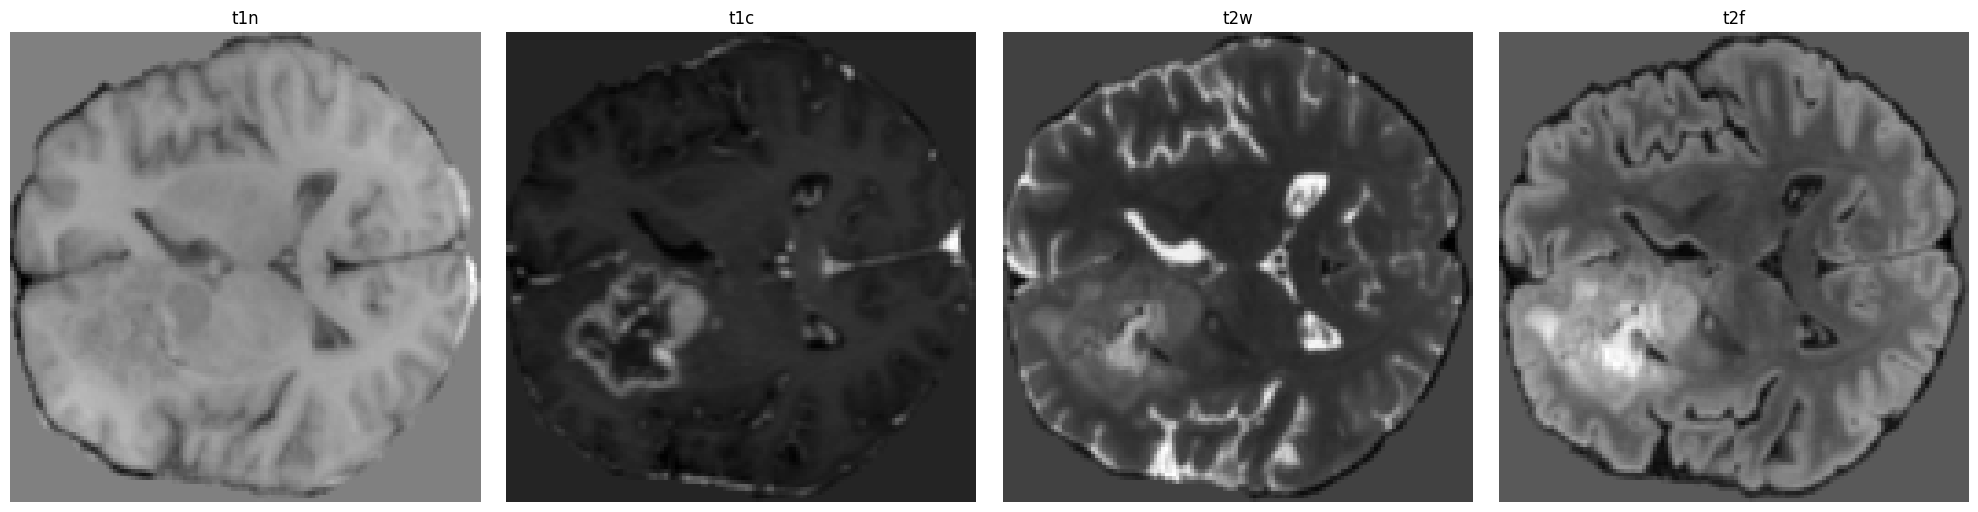

In [98]:
# Visualize a sample saved 4-channel volume
saved_files = sorted(output_dir.glob("*.nii.gz"))
print(f"Files saved: {[f.name for f in saved_files]}")
print(f"Total saved: {len(saved_files)}")

# Only proceed if something was saved
if saved_files:
    sample_file = saved_files[0]
    img = nib.load(sample_file).get_fdata()
    img = np.transpose(img, (3, 0, 1, 2))  # (C, H, W, D)
    print(f"Loaded {sample_file.name}, new shape after transpose: {img.shape}")

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for i in range(4):
        axes[i].imshow(img[i, :, :, img.shape[3] // 2], cmap='gray')
        axes[i].set_title(modalities[i])
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No preprocessed images found.")

In [90]:
# === Directories ===
input_dir = Path("C:/Users/user/NeuroSegNet/data/processed")
segmentation_dir = Path("C:/Users/user/NeuroSegNet/data/raw/BraTS2025-GLI-PRE-Challenge-TrainingData/BraTS2025-GLI-PRE-Challenge-TrainingData")
output_dir = Path("C:/Users/user/NeuroSegNet/data/processed_stacked")
output_dir.mkdir(parents=True, exist_ok=True)

# === Loop through all preprocessed images ===
for image_file in sorted(input_dir.glob("*_image.nii.gz")):
    # Fix: Remove full suffix to get proper patient ID
    patient_id = image_file.name.replace("_image.nii.gz", "")
    print(f"Processing {patient_id}...")

    # === Load preprocessed 4-channel image ===
    img = nib.load(str(image_file))
    img_data = img.get_fdata()  # [H, W, D, 4]
    img_data = np.moveaxis(img_data, -1, 0)  # [4, H, W, D]
    img_tensor = torch.tensor(img_data).unsqueeze(0).float()  # [1, 4, H, W, D]

    # === Find corresponding segmentation ===
    seg_path = segmentation_dir / patient_id / f"{patient_id}-seg.nii.gz"
    if not seg_path.exists():
        print(f" Segmentation not found for {patient_id}, skipping.")
        continue

    seg = nib.load(str(seg_path))
    seg_data = seg.get_fdata()  # [H, W, D]
    seg_tensor = torch.tensor(seg_data).unsqueeze(0).unsqueeze(0).float()  # [1, 1, H, W, D]

    # === Resize mask if needed ===
    if seg_tensor.shape[2:] != img_tensor.shape[2:]:
        print(f" Resizing mask for {patient_id}...")
        resize = Resize(spatial_size=img_tensor.shape[2:], mode="nearest")
        seg_tensor = resize(seg_tensor.squeeze(0)).unsqueeze(0)  # Back to [1, 1, H, W, D]

    # === Stack ===
    stacked_tensor = torch.cat([img_tensor, seg_tensor], dim=1)  # [1, 5, H, W, D]
    stacked_data = stacked_tensor.squeeze(0).numpy()  # [5, H, W, D]
    stacked_data = np.moveaxis(stacked_data, 0, -1)  # [H, W, D, 5]

    # === Save ===
    output_path = output_dir / f"{patient_id}_ground_truth.nii.gz"
    nib.save(nib.Nifti1Image(stacked_data, affine=img.affine, header=img.header), str(output_path))
    print(f" Saved: {output_path}")

Processing BraTS-GLI-00000-000...
 Resizing mask for BraTS-GLI-00000-000...
 Saved: C:\Users\user\NeuroSegNet\data\processed_stacked\BraTS-GLI-00000-000_ground_truth.nii.gz
Processing BraTS-GLI-00002-000...
 Resizing mask for BraTS-GLI-00002-000...
 Saved: C:\Users\user\NeuroSegNet\data\processed_stacked\BraTS-GLI-00002-000_ground_truth.nii.gz
Processing BraTS-GLI-00003-000...
 Resizing mask for BraTS-GLI-00003-000...
 Saved: C:\Users\user\NeuroSegNet\data\processed_stacked\BraTS-GLI-00003-000_ground_truth.nii.gz
Processing BraTS-GLI-00005-000...
 Resizing mask for BraTS-GLI-00005-000...
 Saved: C:\Users\user\NeuroSegNet\data\processed_stacked\BraTS-GLI-00005-000_ground_truth.nii.gz
Processing BraTS-GLI-00006-000...
 Resizing mask for BraTS-GLI-00006-000...
 Saved: C:\Users\user\NeuroSegNet\data\processed_stacked\BraTS-GLI-00006-000_ground_truth.nii.gz
Processing BraTS-GLI-00008-000...
 Resizing mask for BraTS-GLI-00008-000...
 Saved: C:\Users\user\NeuroSegNet\data\processed_stacked\Br

Stacked files found: 1246
Segmentation unique values: [0. 1. 2. 3.]
Segmentation min/max: 0.0 3.0


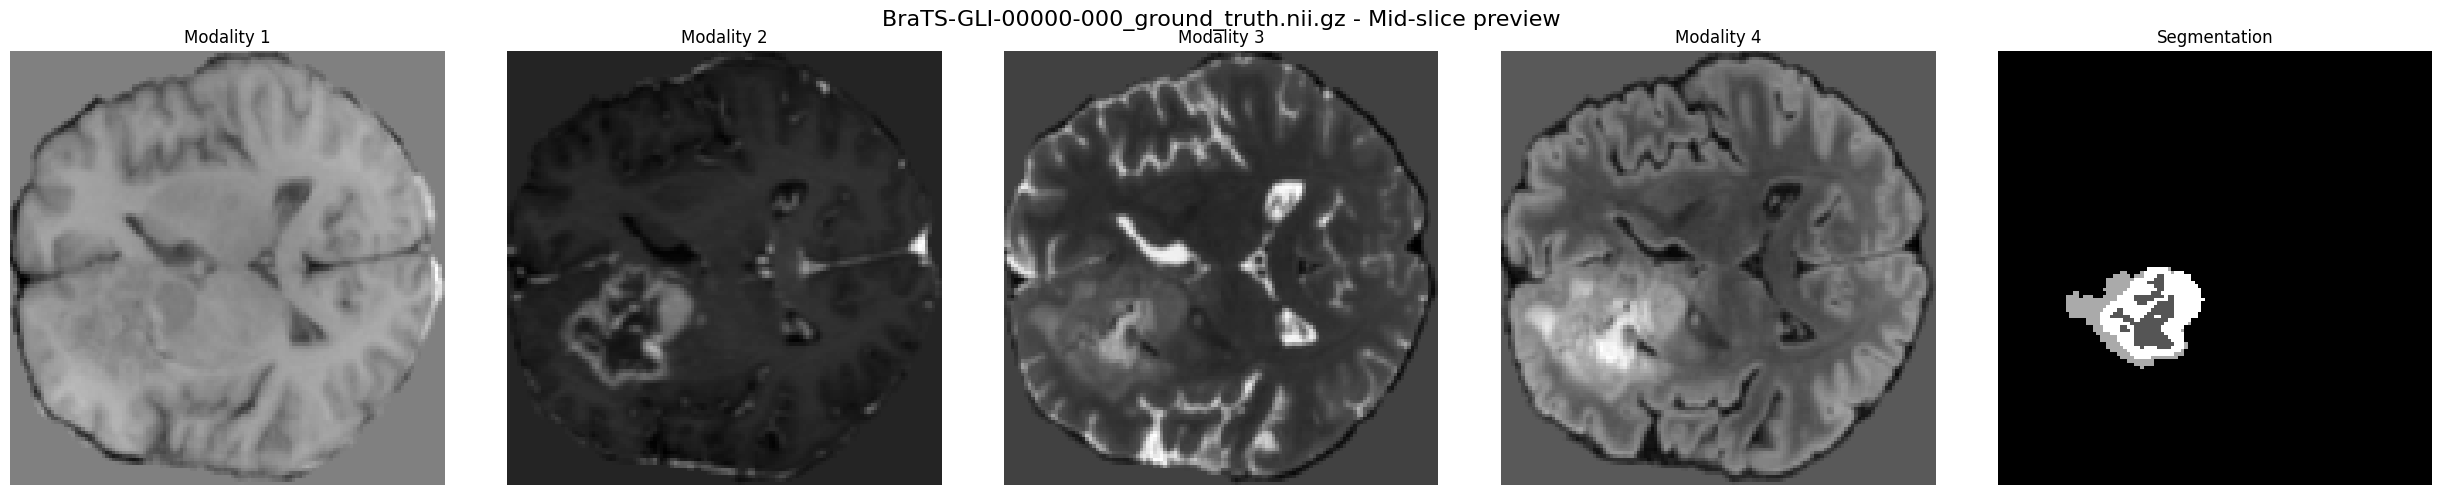

In [3]:
# === Define the path to the stacked data ===
stacked_dir = Path("../data/processed_stacked")

# === Load stacked files ===
stacked_files = sorted(stacked_dir.glob("*.nii.gz"))
print(f"Stacked files found: {len(stacked_files)}")

if stacked_files:
    # Load one stacked volume: [H, W, D, 5]
    img = nib.load(stacked_files[0]).get_fdata()
    img = np.transpose(img, (3, 0, 1, 2))  # [5, H, W, D]
    
    # Extract segmentation channel
    seg_channel = img[4]
    print("Segmentation unique values:", np.unique(seg_channel))
    print("Segmentation min/max:", seg_channel.min(), seg_channel.max())

    # === Visualization ===
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    mid_slice = img.shape[3] // 2  # Mid axial slice

    for i in range(5):
        slice_img = img[i, :, :, mid_slice]
        if i < 4:
            axes[i].imshow(slice_img, cmap="gray")
            axes[i].set_title(f"Modality {i + 1}", fontsize=12)
        else:
            axes[i].imshow(
                slice_img,
                cmap="gray",
                vmin=0,
                vmax=np.max(seg_channel),
                interpolation="nearest"
            )
            axes[i].set_title("Segmentation", fontsize=12)
        axes[i].axis("off")

    plt.suptitle(f"{stacked_files[0].name} - Mid-slice preview", fontsize=16)
    plt.tight_layout()
    plt.show()

else:
    print("No stacked volumes found in:", stacked_dir)

Preprocessing Validation Data

In [110]:
# Configuration
val_root = Path(r"C:/Users/user/NeuroSegNet/data/raw/BraTS2025-GLI-PRE-Challenge-ValidationData/BraTS2025-GLI-PRE-Challenge-ValidationData")

output_dir = Path("data/val_preprocessed/")
output_dir.mkdir(parents=True, exist_ok=True)

modalities = ["t1n", "t1c", "t2w", "t2f"]
print(f"Path exists: {val_root.exists()}")
print(f"Sample folders: {[p.name for p in val_root.glob('*')][:5]}")

Path exists: True
Sample folders: ['BraTS-GLI-00001-000', 'BraTS-GLI-00001-001', 'BraTS-GLI-00013-000', 'BraTS-GLI-00013-001', 'BraTS-GLI-00015-000']


In [111]:
# Define a new preprocessing pipeline for validation data
modality_keys = [f"image-{mod}" for mod in modalities]
preprocessing_val = Compose([
    LoadImaged(keys=modality_keys),
    EnsureChannelFirstd(keys=modality_keys),
    ConcatItemsd(keys=modality_keys, name="image", dim=0),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    Spacingd(keys="image", pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
    CropForegroundd(keys="image", source_key="image"),
    Resized(keys="image", spatial_size=(128, 128, 128)),
    SaveImaged(keys="image", output_dir=output_dir, output_postfix="norm", separate_folder=False)
])

c:\Users\user\anaconda3\envs\brain_mri_env\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [112]:
# Preprocessing Loop with Debug Prints
processed = 0
patients = sorted(list(val_root.glob("*")))

for patient_path in tqdm(patients, desc="Preprocessing Val MRI"):
    patient_id = patient_path.name.strip()  # strip whitespace
    data = {}
    missing = False

    for mod in modalities:
        expected_file = patient_path / f"{patient_id}-{mod}.nii.gz"
        
        if not expected_file.exists():
            # Print all files in the folder if missing
            available = list(patient_path.glob("*.nii.gz"))
            print(f"[Missing] Expected: {expected_file.name} in {patient_path}")
            print(f"Available files: {[f.name for f in available]}")
            missing = True
            break
        else:
            data[f"image-{mod}"] = str(expected_file)

    if missing:
        continue

    dataset = Dataset(data=[data], transform=preprocessing_val)

    try:
        _ = dataset[0]
        processed += 1
    except Exception as e:
        print(f"[Error] {patient_id}: {e}")

print(f"Successfully processed {processed} 4-channelled val MRI.")

Preprocessing Val MRI:   0%|          | 0/219 [00:00<?, ?it/s]

2025-05-28 17:53:29,639 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00001-000-t1n_norm.nii.gz


Preprocessing Val MRI:   0%|          | 1/219 [00:03<11:50,  3.26s/it]

2025-05-28 17:53:32,949 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00001-001-t1n_norm.nii.gz


Preprocessing Val MRI:   1%|          | 2/219 [00:06<12:14,  3.39s/it]

2025-05-28 17:53:36,997 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00013-000-t1n_norm.nii.gz


Preprocessing Val MRI:   1%|▏         | 3/219 [00:10<13:10,  3.66s/it]

2025-05-28 17:53:40,304 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00013-001-t1n_norm.nii.gz


Preprocessing Val MRI:   2%|▏         | 4/219 [00:13<12:30,  3.49s/it]

2025-05-28 17:53:44,242 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00015-000-t1n_norm.nii.gz


Preprocessing Val MRI:   2%|▏         | 5/219 [00:18<14:04,  3.95s/it]

2025-05-28 17:53:49,511 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00015-001-t1n_norm.nii.gz


Preprocessing Val MRI:   3%|▎         | 6/219 [00:24<15:55,  4.49s/it]

2025-05-28 17:53:54,494 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00027-000-t1n_norm.nii.gz


Preprocessing Val MRI:   3%|▎         | 7/219 [00:28<15:37,  4.42s/it]

2025-05-28 17:53:59,057 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00037-000-t1n_norm.nii.gz


Preprocessing Val MRI:   4%|▎         | 8/219 [00:32<15:20,  4.36s/it]

2025-05-28 17:54:02,735 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00047-000-t1n_norm.nii.gz


Preprocessing Val MRI:   4%|▍         | 9/219 [00:36<14:26,  4.13s/it]

2025-05-28 17:54:06,923 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00079-000-t1n_norm.nii.gz


Preprocessing Val MRI:   5%|▍         | 10/219 [00:40<14:43,  4.23s/it]

2025-05-28 17:54:11,489 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00080-000-t1n_norm.nii.gz


Preprocessing Val MRI:   5%|▌         | 11/219 [00:45<15:03,  4.35s/it]

2025-05-28 17:54:15,779 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00080-001-t1n_norm.nii.gz


Preprocessing Val MRI:   5%|▌         | 12/219 [00:49<14:50,  4.30s/it]

2025-05-28 17:54:19,868 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00082-000-t1n_norm.nii.gz


Preprocessing Val MRI:   6%|▌         | 13/219 [00:53<14:07,  4.11s/it]

2025-05-28 17:54:23,363 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00091-000-t1n_norm.nii.gz


Preprocessing Val MRI:   6%|▋         | 14/219 [00:56<13:26,  3.93s/it]

2025-05-28 17:54:27,143 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00114-000-t1n_norm.nii.gz


Preprocessing Val MRI:   7%|▋         | 15/219 [01:00<13:33,  3.99s/it]

2025-05-28 17:54:31,035 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00119-000-t1n_norm.nii.gz


Preprocessing Val MRI:   7%|▋         | 16/219 [01:04<13:07,  3.88s/it]

2025-05-28 17:54:34,432 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00125-000-t1n_norm.nii.gz


Preprocessing Val MRI:   8%|▊         | 17/219 [01:08<13:07,  3.90s/it]

2025-05-28 17:54:38,539 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00129-000-t1n_norm.nii.gz


Preprocessing Val MRI:   8%|▊         | 18/219 [01:12<12:42,  3.79s/it]

2025-05-28 17:54:41,966 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00135-000-t1n_norm.nii.gz


Preprocessing Val MRI:   9%|▊         | 19/219 [01:16<12:54,  3.87s/it]

2025-05-28 17:54:46,030 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00141-000-t1n_norm.nii.gz


Preprocessing Val MRI:   9%|▉         | 20/219 [01:20<12:59,  3.92s/it]

2025-05-28 17:54:50,079 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00145-000-t1n_norm.nii.gz


Preprocessing Val MRI:  10%|▉         | 21/219 [01:23<12:38,  3.83s/it]

2025-05-28 17:54:53,539 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00153-000-t1n_norm.nii.gz


Preprocessing Val MRI:  10%|█         | 22/219 [01:27<12:27,  3.79s/it]

2025-05-28 17:54:58,966 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00161-000-t1n_norm.nii.gz


Preprocessing Val MRI:  11%|█         | 23/219 [01:33<14:37,  4.48s/it]

2025-05-28 17:55:03,944 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00163-000-t1n_norm.nii.gz


Preprocessing Val MRI:  11%|█         | 24/219 [01:37<14:13,  4.38s/it]

2025-05-28 17:55:07,472 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00174-000-t1n_norm.nii.gz


Preprocessing Val MRI:  11%|█▏        | 25/219 [01:40<12:59,  4.02s/it]

2025-05-28 17:55:11,124 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00181-000-t1n_norm.nii.gz


Preprocessing Val MRI:  12%|█▏        | 26/219 [01:44<12:55,  4.02s/it]

2025-05-28 17:55:15,146 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00182-000-t1n_norm.nii.gz


Preprocessing Val MRI:  12%|█▏        | 27/219 [01:49<13:47,  4.31s/it]

2025-05-28 17:55:20,257 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00190-000-t1n_norm.nii.gz


Preprocessing Val MRI:  13%|█▎        | 28/219 [01:54<14:01,  4.41s/it]

2025-05-28 17:55:24,272 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00200-000-t1n_norm.nii.gz


Preprocessing Val MRI:  13%|█▎        | 29/219 [01:58<13:47,  4.36s/it]

2025-05-28 17:55:29,303 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00208-000-t1n_norm.nii.gz


Preprocessing Val MRI:  14%|█▎        | 30/219 [02:03<13:58,  4.44s/it]

2025-05-28 17:55:34,747 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00213-000-t1n_norm.nii.gz


Preprocessing Val MRI:  14%|█▍        | 31/219 [02:08<14:42,  4.69s/it]

2025-05-28 17:55:38,458 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00229-000-t1n_norm.nii.gz


Preprocessing Val MRI:  15%|█▍        | 32/219 [02:11<13:01,  4.18s/it]

2025-05-28 17:55:41,505 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00252-000-t1n_norm.nii.gz


Preprocessing Val MRI:  15%|█▌        | 33/219 [02:15<12:21,  3.99s/it]

2025-05-28 17:55:44,893 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00256-000-t1n_norm.nii.gz


Preprocessing Val MRI:  16%|█▌        | 34/219 [02:18<12:05,  3.92s/it]

2025-05-28 17:55:48,455 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00264-000-t1n_norm.nii.gz


Preprocessing Val MRI:  16%|█▌        | 35/219 [02:22<11:13,  3.66s/it]

2025-05-28 17:55:51,237 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00287-000-t1n_norm.nii.gz


Preprocessing Val MRI:  16%|█▋        | 36/219 [02:24<10:10,  3.34s/it]

2025-05-28 17:55:54,443 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00307-000-t1n_norm.nii.gz


Preprocessing Val MRI:  17%|█▋        | 37/219 [02:28<10:19,  3.41s/it]

2025-05-28 17:55:58,123 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00323-000-t1n_norm.nii.gz


Preprocessing Val MRI:  17%|█▋        | 38/219 [02:31<10:27,  3.47s/it]

2025-05-28 17:56:02,390 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00333-000-t1n_norm.nii.gz


Preprocessing Val MRI:  18%|█▊        | 39/219 [02:35<10:59,  3.66s/it]

2025-05-28 17:56:05,430 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00335-000-t1n_norm.nii.gz


Preprocessing Val MRI:  18%|█▊        | 40/219 [02:38<10:06,  3.39s/it]

2025-05-28 17:56:08,416 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00337-000-t1n_norm.nii.gz


Preprocessing Val MRI:  19%|█▊        | 41/219 [02:41<09:46,  3.29s/it]

2025-05-28 17:56:10,953 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00355-000-t1n_norm.nii.gz


Preprocessing Val MRI:  19%|█▉        | 42/219 [02:44<08:50,  3.00s/it]

2025-05-28 17:56:13,784 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00372-000-t1n_norm.nii.gz


Preprocessing Val MRI:  20%|█▉        | 43/219 [02:47<08:58,  3.06s/it]

2025-05-28 17:56:16,985 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00381-000-t1n_norm.nii.gz


Preprocessing Val MRI:  20%|██        | 44/219 [02:50<09:09,  3.14s/it]

2025-05-28 17:56:20,001 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00384-000-t1n_norm.nii.gz


Preprocessing Val MRI:  21%|██        | 45/219 [02:53<08:44,  3.02s/it]

2025-05-28 17:56:22,894 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00422-000-t1n_norm.nii.gz


Preprocessing Val MRI:  21%|██        | 46/219 [02:56<08:26,  2.93s/it]

2025-05-28 17:56:25,393 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00428-000-t1n_norm.nii.gz


Preprocessing Val MRI:  21%|██▏       | 47/219 [02:58<08:25,  2.94s/it]

2025-05-28 17:56:28,105 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00434-000-t1n_norm.nii.gz


Preprocessing Val MRI:  22%|██▏       | 48/219 [03:01<08:20,  2.93s/it]

2025-05-28 17:56:31,506 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00438-000-t1n_norm.nii.gz


Preprocessing Val MRI:  22%|██▏       | 49/219 [03:04<08:24,  2.97s/it]

2025-05-28 17:56:34,916 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00447-000-t1n_norm.nii.gz


Preprocessing Val MRI:  23%|██▎       | 50/219 [03:08<08:38,  3.07s/it]

2025-05-28 17:56:37,773 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00450-000-t1n_norm.nii.gz


Preprocessing Val MRI:  23%|██▎       | 51/219 [03:10<08:11,  2.92s/it]

2025-05-28 17:56:39,955 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00458-000-t1n_norm.nii.gz


Preprocessing Val MRI:  24%|██▎       | 52/219 [03:13<08:01,  2.88s/it]

2025-05-28 17:56:42,817 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00460-000-t1n_norm.nii.gz


Preprocessing Val MRI:  24%|██▍       | 53/219 [03:16<07:44,  2.80s/it]

2025-05-28 17:56:45,994 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00462-000-t1n_norm.nii.gz


Preprocessing Val MRI:  25%|██▍       | 54/219 [03:19<08:11,  2.98s/it]

2025-05-28 17:56:49,619 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00462-001-t1n_norm.nii.gz


Preprocessing Val MRI:  25%|██▌       | 55/219 [03:23<08:39,  3.17s/it]

2025-05-28 17:56:52,621 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00463-000-t1n_norm.nii.gz


Preprocessing Val MRI:  26%|██▌       | 56/219 [03:26<08:30,  3.13s/it]

2025-05-28 17:56:55,370 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00467-000-t1n_norm.nii.gz


Preprocessing Val MRI:  26%|██▌       | 57/219 [03:28<07:56,  2.94s/it]

2025-05-28 17:56:58,320 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00467-001-t1n_norm.nii.gz


Preprocessing Val MRI:  26%|██▋       | 58/219 [03:31<07:44,  2.88s/it]

2025-05-28 17:57:01,867 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00474-000-t1n_norm.nii.gz


Preprocessing Val MRI:  27%|██▋       | 59/219 [03:35<08:38,  3.24s/it]

2025-05-28 17:57:05,728 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00474-001-t1n_norm.nii.gz


Preprocessing Val MRI:  27%|██▋       | 60/219 [03:39<08:49,  3.33s/it]

2025-05-28 17:57:08,920 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00489-000-t1n_norm.nii.gz


Preprocessing Val MRI:  28%|██▊       | 61/219 [03:42<08:41,  3.30s/it]

2025-05-28 17:57:11,430 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00492-000-t1n_norm.nii.gz


Preprocessing Val MRI:  28%|██▊       | 62/219 [03:44<07:58,  3.05s/it]

2025-05-28 17:57:14,584 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00503-000-t1n_norm.nii.gz


Preprocessing Val MRI:  29%|██▉       | 63/219 [03:47<07:54,  3.04s/it]

2025-05-28 17:57:17,728 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00503-001-t1n_norm.nii.gz


Preprocessing Val MRI:  29%|██▉       | 64/219 [03:51<08:20,  3.23s/it]

2025-05-28 17:57:21,618 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00521-000-t1n_norm.nii.gz


Preprocessing Val MRI:  30%|██▉       | 65/219 [03:55<08:37,  3.36s/it]

2025-05-28 17:57:24,640 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00521-001-t1n_norm.nii.gz


Preprocessing Val MRI:  30%|███       | 66/219 [03:58<08:22,  3.29s/it]

2025-05-28 17:57:27,576 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00535-000-t1n_norm.nii.gz


Preprocessing Val MRI:  31%|███       | 67/219 [04:01<08:01,  3.17s/it]

2025-05-28 17:57:30,494 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00535-001-t1n_norm.nii.gz


Preprocessing Val MRI:  31%|███       | 68/219 [04:04<07:44,  3.08s/it]

2025-05-28 17:57:33,554 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00553-000-t1n_norm.nii.gz


Preprocessing Val MRI:  32%|███▏      | 69/219 [04:07<07:45,  3.10s/it]

2025-05-28 17:57:36,965 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00553-001-t1n_norm.nii.gz


Preprocessing Val MRI:  32%|███▏      | 70/219 [04:10<07:53,  3.18s/it]

2025-05-28 17:57:40,246 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00560-000-t1n_norm.nii.gz


Preprocessing Val MRI:  32%|███▏      | 71/219 [04:13<07:50,  3.18s/it]

2025-05-28 17:57:42,971 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00560-001-t1n_norm.nii.gz


Preprocessing Val MRI:  33%|███▎      | 72/219 [04:16<07:33,  3.09s/it]

2025-05-28 17:57:45,844 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00573-000-t1n_norm.nii.gz


Preprocessing Val MRI:  33%|███▎      | 73/219 [04:19<07:16,  2.99s/it]

2025-05-28 17:57:48,757 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00585-000-t1n_norm.nii.gz


Preprocessing Val MRI:  34%|███▍      | 74/219 [04:22<07:09,  2.96s/it]

2025-05-28 17:57:52,155 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00592-000-t1n_norm.nii.gz


Preprocessing Val MRI:  34%|███▍      | 75/219 [04:25<07:37,  3.18s/it]

2025-05-28 17:57:55,836 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00595-000-t1n_norm.nii.gz


Preprocessing Val MRI:  35%|███▍      | 76/219 [04:29<07:35,  3.18s/it]

2025-05-28 17:57:58,419 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00603-000-t1n_norm.nii.gz


Preprocessing Val MRI:  35%|███▌      | 77/219 [04:32<07:22,  3.12s/it]

2025-05-28 17:58:01,559 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00644-000-t1n_norm.nii.gz


Preprocessing Val MRI:  36%|███▌      | 78/219 [04:35<07:09,  3.05s/it]

2025-05-28 17:58:04,510 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00647-000-t1n_norm.nii.gz


Preprocessing Val MRI:  36%|███▌      | 79/219 [04:38<07:09,  3.07s/it]

2025-05-28 17:58:08,185 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00647-001-t1n_norm.nii.gz


Preprocessing Val MRI:  37%|███▋      | 80/219 [04:41<07:30,  3.24s/it]

2025-05-28 17:58:11,790 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00662-000-t1n_norm.nii.gz


Preprocessing Val MRI:  37%|███▋      | 81/219 [04:45<07:30,  3.27s/it]

2025-05-28 17:58:14,234 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00671-000-t1n_norm.nii.gz


Preprocessing Val MRI:  37%|███▋      | 82/219 [04:47<07:01,  3.07s/it]

2025-05-28 17:58:17,133 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00681-000-t1n_norm.nii.gz


Preprocessing Val MRI:  38%|███▊      | 83/219 [04:50<06:46,  2.99s/it]

2025-05-28 17:58:20,218 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00699-000-t1n_norm.nii.gz


Preprocessing Val MRI:  38%|███▊      | 84/219 [04:53<06:48,  3.03s/it]

2025-05-28 17:58:23,348 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00699-001-t1n_norm.nii.gz


Preprocessing Val MRI:  39%|███▉      | 85/219 [04:57<07:03,  3.16s/it]

2025-05-28 17:58:26,874 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00702-000-t1n_norm.nii.gz


Preprocessing Val MRI:  39%|███▉      | 86/219 [05:00<07:08,  3.22s/it]

2025-05-28 17:58:29,571 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00702-001-t1n_norm.nii.gz


Preprocessing Val MRI:  40%|███▉      | 87/219 [05:03<06:57,  3.16s/it]

2025-05-28 17:58:32,817 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00712-000-t1n_norm.nii.gz


Preprocessing Val MRI:  40%|████      | 88/219 [05:06<06:38,  3.05s/it]

2025-05-28 17:58:35,758 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00712-001-t1n_norm.nii.gz


Preprocessing Val MRI:  41%|████      | 89/219 [05:09<06:37,  3.06s/it]

2025-05-28 17:58:39,261 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00719-000-t1n_norm.nii.gz


Preprocessing Val MRI:  41%|████      | 90/219 [05:12<06:50,  3.18s/it]

2025-05-28 17:58:42,620 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00719-001-t1n_norm.nii.gz


Preprocessing Val MRI:  42%|████▏     | 91/219 [05:16<06:51,  3.21s/it]

2025-05-28 17:58:45,260 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00721-000-t1n_norm.nii.gz


Preprocessing Val MRI:  42%|████▏     | 92/219 [05:18<06:23,  3.02s/it]

2025-05-28 17:58:48,165 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00721-001-t1n_norm.nii.gz


Preprocessing Val MRI:  42%|████▏     | 93/219 [05:21<06:14,  2.97s/it]

2025-05-28 17:58:51,191 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00749-000-t1n_norm.nii.gz


Preprocessing Val MRI:  43%|████▎     | 94/219 [05:24<06:17,  3.02s/it]

2025-05-28 17:58:54,564 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00762-000-t1n_norm.nii.gz


Preprocessing Val MRI:  43%|████▎     | 95/219 [05:28<06:45,  3.27s/it]

2025-05-28 17:58:58,195 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00762-001-t1n_norm.nii.gz


Preprocessing Val MRI:  44%|████▍     | 96/219 [05:31<06:41,  3.26s/it]

2025-05-28 17:59:01,504 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00769-000-t1n_norm.nii.gz


Preprocessing Val MRI:  44%|████▍     | 97/219 [05:34<06:27,  3.17s/it]

2025-05-28 17:59:04,116 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00779-000-t1n_norm.nii.gz


Preprocessing Val MRI:  45%|████▍     | 98/219 [05:37<06:10,  3.06s/it]

2025-05-28 17:59:06,781 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00779-001-t1n_norm.nii.gz


Preprocessing Val MRI:  45%|████▌     | 99/219 [05:40<06:14,  3.12s/it]

2025-05-28 17:59:10,341 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00821-000-t1n_norm.nii.gz


Preprocessing Val MRI:  46%|████▌     | 100/219 [05:44<06:15,  3.16s/it]

2025-05-28 17:59:13,508 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00822-000-t1n_norm.nii.gz


Preprocessing Val MRI:  46%|████▌     | 101/219 [05:47<06:13,  3.17s/it]

2025-05-28 17:59:16,614 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00825-000-t1n_norm.nii.gz


Preprocessing Val MRI:  47%|████▋     | 102/219 [05:49<05:50,  2.99s/it]

2025-05-28 17:59:19,135 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00826-000-t1n_norm.nii.gz


Preprocessing Val MRI:  47%|████▋     | 103/219 [05:53<05:54,  3.05s/it]

2025-05-28 17:59:22,171 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00829-000-t1n_norm.nii.gz


Preprocessing Val MRI:  47%|████▋     | 104/219 [05:55<05:47,  3.02s/it]

2025-05-28 17:59:25,447 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00833-000-t1n_norm.nii.gz


Preprocessing Val MRI:  48%|████▊     | 105/219 [05:58<05:44,  3.02s/it]

2025-05-28 17:59:28,773 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00997-000-t1n_norm.nii.gz


Preprocessing Val MRI:  48%|████▊     | 106/219 [06:02<05:45,  3.05s/it]

2025-05-28 17:59:31,579 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01006-000-t1n_norm.nii.gz


Preprocessing Val MRI:  49%|████▉     | 107/219 [06:05<05:44,  3.08s/it]

2025-05-28 17:59:34,391 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01667-000-t1n_norm.nii.gz


Preprocessing Val MRI:  49%|████▉     | 108/219 [06:07<05:30,  2.98s/it]

2025-05-28 17:59:37,296 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01668-000-t1n_norm.nii.gz


Preprocessing Val MRI:  50%|████▉     | 109/219 [06:10<05:15,  2.87s/it]

2025-05-28 17:59:39,995 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01669-000-t1n_norm.nii.gz


Preprocessing Val MRI:  50%|█████     | 110/219 [06:13<05:07,  2.82s/it]

2025-05-28 17:59:43,261 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01670-000-t1n_norm.nii.gz


Preprocessing Val MRI:  51%|█████     | 111/219 [06:16<05:24,  3.01s/it]

2025-05-28 17:59:46,252 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01671-000-t1n_norm.nii.gz


Preprocessing Val MRI:  51%|█████     | 112/219 [06:19<05:16,  2.96s/it]

2025-05-28 17:59:48,725 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01672-000-t1n_norm.nii.gz


Preprocessing Val MRI:  52%|█████▏    | 113/219 [06:22<05:00,  2.83s/it]

2025-05-28 17:59:51,571 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01673-000-t1n_norm.nii.gz


Preprocessing Val MRI:  52%|█████▏    | 114/219 [06:24<04:57,  2.84s/it]

2025-05-28 17:59:54,769 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01674-000-t1n_norm.nii.gz


Preprocessing Val MRI:  53%|█████▎    | 115/219 [06:28<05:14,  3.02s/it]

2025-05-28 17:59:58,303 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01675-000-t1n_norm.nii.gz


Preprocessing Val MRI:  53%|█████▎    | 116/219 [06:31<05:27,  3.18s/it]

2025-05-28 18:00:01,878 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01676-000-t1n_norm.nii.gz


Preprocessing Val MRI:  53%|█████▎    | 117/219 [06:35<05:47,  3.41s/it]

2025-05-28 18:00:06,318 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01677-000-t1n_norm.nii.gz


Preprocessing Val MRI:  54%|█████▍    | 118/219 [06:40<06:17,  3.74s/it]

2025-05-28 18:00:11,635 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01678-000-t1n_norm.nii.gz


Preprocessing Val MRI:  54%|█████▍    | 119/219 [06:45<06:54,  4.14s/it]

2025-05-28 18:00:16,099 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01679-000-t1n_norm.nii.gz


Preprocessing Val MRI:  55%|█████▍    | 120/219 [06:50<07:01,  4.25s/it]

2025-05-28 18:00:20,432 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01680-000-t1n_norm.nii.gz


Preprocessing Val MRI:  55%|█████▌    | 121/219 [06:53<06:44,  4.13s/it]

2025-05-28 18:00:23,283 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01681-000-t1n_norm.nii.gz


Preprocessing Val MRI:  56%|█████▌    | 122/219 [06:56<06:02,  3.73s/it]

2025-05-28 18:00:25,900 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01682-000-t1n_norm.nii.gz


Preprocessing Val MRI:  56%|█████▌    | 123/219 [06:59<05:28,  3.42s/it]

2025-05-28 18:00:29,130 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01683-000-t1n_norm.nii.gz


Preprocessing Val MRI:  57%|█████▋    | 124/219 [07:02<05:13,  3.30s/it]

2025-05-28 18:00:32,394 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01684-000-t1n_norm.nii.gz


Preprocessing Val MRI:  57%|█████▋    | 125/219 [07:05<05:10,  3.30s/it]

2025-05-28 18:00:35,307 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01685-000-t1n_norm.nii.gz


Preprocessing Val MRI:  58%|█████▊    | 126/219 [07:08<04:59,  3.22s/it]

2025-05-28 18:00:37,951 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01686-000-t1n_norm.nii.gz


Preprocessing Val MRI:  58%|█████▊    | 127/219 [07:11<04:45,  3.11s/it]

2025-05-28 18:00:40,908 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01687-000-t1n_norm.nii.gz


Preprocessing Val MRI:  58%|█████▊    | 128/219 [07:14<04:26,  2.93s/it]

2025-05-28 18:00:43,767 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01688-000-t1n_norm.nii.gz


Preprocessing Val MRI:  59%|█████▉    | 129/219 [07:17<04:30,  3.00s/it]

2025-05-28 18:00:46,700 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01689-000-t1n_norm.nii.gz


Preprocessing Val MRI:  59%|█████▉    | 130/219 [07:20<04:29,  3.03s/it]

2025-05-28 18:00:50,129 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01690-000-t1n_norm.nii.gz


Preprocessing Val MRI:  60%|█████▉    | 131/219 [07:23<04:37,  3.16s/it]

2025-05-28 18:00:53,835 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01691-000-t1n_norm.nii.gz


Preprocessing Val MRI:  60%|██████    | 132/219 [07:27<04:41,  3.24s/it]

2025-05-28 18:00:56,613 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01692-000-t1n_norm.nii.gz


Preprocessing Val MRI:  61%|██████    | 133/219 [07:29<04:17,  3.00s/it]

2025-05-28 18:00:58,807 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01693-000-t1n_norm.nii.gz


Preprocessing Val MRI:  61%|██████    | 134/219 [07:32<04:05,  2.89s/it]

2025-05-28 18:01:01,970 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01694-000-t1n_norm.nii.gz


Preprocessing Val MRI:  62%|██████▏   | 135/219 [07:35<04:11,  2.99s/it]

2025-05-28 18:01:05,722 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01695-000-t1n_norm.nii.gz


Preprocessing Val MRI:  62%|██████▏   | 136/219 [07:39<04:24,  3.19s/it]

2025-05-28 18:01:08,774 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01696-000-t1n_norm.nii.gz


Preprocessing Val MRI:  63%|██████▎   | 137/219 [07:41<04:08,  3.03s/it]

2025-05-28 18:01:11,119 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01697-000-t1n_norm.nii.gz


Preprocessing Val MRI:  63%|██████▎   | 138/219 [07:44<03:57,  2.94s/it]

2025-05-28 18:01:13,720 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01698-000-t1n_norm.nii.gz


Preprocessing Val MRI:  63%|██████▎   | 139/219 [07:47<03:44,  2.81s/it]

2025-05-28 18:01:16,450 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01699-000-t1n_norm.nii.gz


Preprocessing Val MRI:  64%|██████▍   | 140/219 [07:50<03:51,  2.93s/it]

2025-05-28 18:01:20,379 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01700-000-t1n_norm.nii.gz


Preprocessing Val MRI:  64%|██████▍   | 141/219 [07:53<03:58,  3.06s/it]

2025-05-28 18:01:23,327 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01701-000-t1n_norm.nii.gz


Preprocessing Val MRI:  65%|██████▍   | 142/219 [07:56<03:54,  3.04s/it]

2025-05-28 18:01:25,903 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01702-000-t1n_norm.nii.gz


Preprocessing Val MRI:  65%|██████▌   | 143/219 [07:59<03:45,  2.97s/it]

2025-05-28 18:01:28,540 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01703-000-t1n_norm.nii.gz


Preprocessing Val MRI:  66%|██████▌   | 144/219 [08:01<03:31,  2.82s/it]

2025-05-28 18:01:31,763 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01704-000-t1n_norm.nii.gz


Preprocessing Val MRI:  66%|██████▌   | 145/219 [08:05<03:34,  2.90s/it]

2025-05-28 18:01:34,362 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01705-000-t1n_norm.nii.gz


Preprocessing Val MRI:  67%|██████▋   | 146/219 [08:07<03:31,  2.90s/it]

2025-05-28 18:01:37,685 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01706-000-t1n_norm.nii.gz


Preprocessing Val MRI:  67%|██████▋   | 147/219 [08:10<03:29,  2.92s/it]

2025-05-28 18:01:40,255 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01707-000-t1n_norm.nii.gz


Preprocessing Val MRI:  68%|██████▊   | 148/219 [08:13<03:24,  2.89s/it]

2025-05-28 18:01:43,405 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01708-000-t1n_norm.nii.gz


Preprocessing Val MRI:  68%|██████▊   | 149/219 [08:16<03:25,  2.93s/it]

2025-05-28 18:01:45,815 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01709-000-t1n_norm.nii.gz


Preprocessing Val MRI:  68%|██████▊   | 150/219 [08:19<03:09,  2.75s/it]

2025-05-28 18:01:48,295 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01710-000-t1n_norm.nii.gz


Preprocessing Val MRI:  69%|██████▉   | 151/219 [08:21<03:07,  2.75s/it]

2025-05-28 18:01:51,410 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01711-000-t1n_norm.nii.gz


Preprocessing Val MRI:  69%|██████▉   | 152/219 [08:24<03:12,  2.88s/it]

2025-05-28 18:01:54,793 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01712-000-t1n_norm.nii.gz


Preprocessing Val MRI:  70%|██████▉   | 153/219 [08:28<03:15,  2.97s/it]

2025-05-28 18:01:57,205 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01713-000-t1n_norm.nii.gz


Preprocessing Val MRI:  70%|███████   | 154/219 [08:30<02:56,  2.72s/it]

2025-05-28 18:01:59,789 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01714-000-t1n_norm.nii.gz


Preprocessing Val MRI:  71%|███████   | 155/219 [08:33<02:57,  2.77s/it]

2025-05-28 18:02:02,622 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01715-000-t1n_norm.nii.gz


Preprocessing Val MRI:  71%|███████   | 156/219 [08:36<03:03,  2.92s/it]

2025-05-28 18:02:06,047 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01716-000-t1n_norm.nii.gz


Preprocessing Val MRI:  72%|███████▏  | 157/219 [08:40<03:18,  3.20s/it]

2025-05-28 18:02:09,739 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01717-000-t1n_norm.nii.gz


Preprocessing Val MRI:  72%|███████▏  | 158/219 [08:43<03:12,  3.16s/it]

2025-05-28 18:02:12,608 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01718-000-t1n_norm.nii.gz


Preprocessing Val MRI:  73%|███████▎  | 159/219 [08:46<03:01,  3.02s/it]

2025-05-28 18:02:17,681 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01719-000-t1n_norm.nii.gz


Preprocessing Val MRI:  73%|███████▎  | 160/219 [08:50<03:30,  3.58s/it]

2025-05-28 18:02:20,268 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01720-000-t1n_norm.nii.gz


Preprocessing Val MRI:  74%|███████▎  | 161/219 [08:54<03:20,  3.46s/it]

2025-05-28 18:02:23,883 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01721-000-t1n_norm.nii.gz


Preprocessing Val MRI:  74%|███████▍  | 162/219 [08:57<03:11,  3.36s/it]

2025-05-28 18:02:26,891 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01722-000-t1n_norm.nii.gz


Preprocessing Val MRI:  74%|███████▍  | 163/219 [09:00<03:02,  3.26s/it]

2025-05-28 18:02:29,651 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01723-000-t1n_norm.nii.gz


Preprocessing Val MRI:  75%|███████▍  | 164/219 [09:03<02:52,  3.13s/it]

2025-05-28 18:02:32,716 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01724-000-t1n_norm.nii.gz


Preprocessing Val MRI:  75%|███████▌  | 165/219 [09:06<02:46,  3.08s/it]

2025-05-28 18:02:35,423 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01725-000-t1n_norm.nii.gz


Preprocessing Val MRI:  76%|███████▌  | 166/219 [09:08<02:36,  2.95s/it]

2025-05-28 18:02:38,706 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01726-000-t1n_norm.nii.gz


Preprocessing Val MRI:  76%|███████▋  | 167/219 [09:12<02:42,  3.12s/it]

2025-05-28 18:02:42,217 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01727-000-t1n_norm.nii.gz


Preprocessing Val MRI:  77%|███████▋  | 168/219 [09:15<02:44,  3.23s/it]

2025-05-28 18:02:44,780 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01728-000-t1n_norm.nii.gz


Preprocessing Val MRI:  77%|███████▋  | 169/219 [09:18<02:31,  3.03s/it]

2025-05-28 18:02:47,769 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01729-000-t1n_norm.nii.gz


Preprocessing Val MRI:  78%|███████▊  | 170/219 [09:20<02:21,  2.89s/it]

2025-05-28 18:02:49,939 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01730-000-t1n_norm.nii.gz


Preprocessing Val MRI:  78%|███████▊  | 171/219 [09:23<02:11,  2.73s/it]

2025-05-28 18:02:52,194 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01731-000-t1n_norm.nii.gz


Preprocessing Val MRI:  79%|███████▊  | 172/219 [09:25<02:03,  2.63s/it]

2025-05-28 18:02:55,423 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01732-000-t1n_norm.nii.gz


Preprocessing Val MRI:  79%|███████▉  | 173/219 [09:28<02:08,  2.79s/it]

2025-05-28 18:02:59,073 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01733-000-t1n_norm.nii.gz


Preprocessing Val MRI:  79%|███████▉  | 174/219 [09:32<02:16,  3.04s/it]

2025-05-28 18:03:01,897 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01734-000-t1n_norm.nii.gz


Preprocessing Val MRI:  80%|███████▉  | 175/219 [09:35<02:13,  3.03s/it]

2025-05-28 18:03:04,464 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01735-000-t1n_norm.nii.gz


Preprocessing Val MRI:  80%|████████  | 176/219 [09:37<02:04,  2.89s/it]

2025-05-28 18:03:07,297 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01736-000-t1n_norm.nii.gz


Preprocessing Val MRI:  81%|████████  | 177/219 [09:40<01:55,  2.75s/it]

2025-05-28 18:03:10,897 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01737-000-t1n_norm.nii.gz


Preprocessing Val MRI:  81%|████████▏ | 178/219 [09:44<02:12,  3.23s/it]

2025-05-28 18:03:15,132 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01738-000-t1n_norm.nii.gz


Preprocessing Val MRI:  82%|████████▏ | 179/219 [09:48<02:16,  3.42s/it]

2025-05-28 18:03:18,207 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01739-000-t1n_norm.nii.gz


Preprocessing Val MRI:  82%|████████▏ | 180/219 [09:51<02:09,  3.33s/it]

2025-05-28 18:03:20,864 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01740-000-t1n_norm.nii.gz


Preprocessing Val MRI:  83%|████████▎ | 181/219 [09:54<02:00,  3.17s/it]

2025-05-28 18:03:25,647 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01741-000-t1n_norm.nii.gz


Preprocessing Val MRI:  83%|████████▎ | 182/219 [10:00<02:28,  4.00s/it]

2025-05-28 18:03:31,748 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01742-000-t1n_norm.nii.gz


Preprocessing Val MRI:  84%|████████▎ | 183/219 [10:05<02:37,  4.39s/it]

2025-05-28 18:03:36,163 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01743-000-t1n_norm.nii.gz


Preprocessing Val MRI:  84%|████████▍ | 184/219 [10:09<02:32,  4.35s/it]

2025-05-28 18:03:39,935 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01744-000-t1n_norm.nii.gz


Preprocessing Val MRI:  84%|████████▍ | 185/219 [10:14<02:28,  4.38s/it]

2025-05-28 18:03:44,852 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01745-000-t1n_norm.nii.gz


Preprocessing Val MRI:  85%|████████▍ | 186/219 [10:18<02:24,  4.39s/it]

2025-05-28 18:03:49,019 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01746-000-t1n_norm.nii.gz


Preprocessing Val MRI:  85%|████████▌ | 187/219 [10:23<02:23,  4.47s/it]

2025-05-28 18:03:52,759 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01747-000-t1n_norm.nii.gz


Preprocessing Val MRI:  86%|████████▌ | 188/219 [10:26<02:04,  4.02s/it]

2025-05-28 18:03:56,336 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01748-000-t1n_norm.nii.gz


Preprocessing Val MRI:  86%|████████▋ | 189/219 [10:29<01:55,  3.86s/it]

2025-05-28 18:03:59,897 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01749-000-t1n_norm.nii.gz


Preprocessing Val MRI:  87%|████████▋ | 190/219 [10:34<01:57,  4.04s/it]

2025-05-28 18:04:04,878 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01750-000-t1n_norm.nii.gz


Preprocessing Val MRI:  87%|████████▋ | 191/219 [10:38<01:55,  4.12s/it]

2025-05-28 18:04:08,698 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01751-000-t1n_norm.nii.gz


Preprocessing Val MRI:  88%|████████▊ | 192/219 [10:42<01:47,  3.99s/it]

2025-05-28 18:04:12,273 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01752-000-t1n_norm.nii.gz


Preprocessing Val MRI:  88%|████████▊ | 193/219 [10:46<01:42,  3.94s/it]

2025-05-28 18:04:16,136 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01753-000-t1n_norm.nii.gz


Preprocessing Val MRI:  89%|████████▊ | 194/219 [10:50<01:38,  3.92s/it]

2025-05-28 18:04:20,015 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01754-000-t1n_norm.nii.gz


Preprocessing Val MRI:  89%|████████▉ | 195/219 [10:53<01:33,  3.89s/it]

2025-05-28 18:04:23,620 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01755-000-t1n_norm.nii.gz


Preprocessing Val MRI:  89%|████████▉ | 196/219 [10:57<01:24,  3.67s/it]

2025-05-28 18:04:26,840 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01756-000-t1n_norm.nii.gz


Preprocessing Val MRI:  90%|████████▉ | 197/219 [10:59<01:15,  3.45s/it]

2025-05-28 18:04:29,917 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01757-000-t1n_norm.nii.gz


Preprocessing Val MRI:  90%|█████████ | 198/219 [11:03<01:12,  3.44s/it]

2025-05-28 18:04:33,187 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01758-000-t1n_norm.nii.gz


Preprocessing Val MRI:  91%|█████████ | 199/219 [11:06<01:08,  3.43s/it]

2025-05-28 18:04:36,930 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01759-000-t1n_norm.nii.gz


Preprocessing Val MRI:  91%|█████████▏| 200/219 [11:10<01:05,  3.44s/it]

2025-05-28 18:04:40,012 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01760-000-t1n_norm.nii.gz


Preprocessing Val MRI:  92%|█████████▏| 201/219 [11:13<01:00,  3.35s/it]

2025-05-28 18:04:43,263 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01761-000-t1n_norm.nii.gz


Preprocessing Val MRI:  92%|█████████▏| 202/219 [11:16<00:54,  3.23s/it]

2025-05-28 18:04:46,403 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01762-000-t1n_norm.nii.gz


Preprocessing Val MRI:  93%|█████████▎| 203/219 [11:19<00:53,  3.32s/it]

2025-05-28 18:04:50,242 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01763-000-t1n_norm.nii.gz


Preprocessing Val MRI:  93%|█████████▎| 204/219 [11:23<00:51,  3.44s/it]

2025-05-28 18:04:53,463 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01764-000-t1n_norm.nii.gz


Preprocessing Val MRI:  94%|█████████▎| 205/219 [11:26<00:46,  3.35s/it]

2025-05-28 18:04:56,432 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01765-000-t1n_norm.nii.gz


Preprocessing Val MRI:  94%|█████████▍| 206/219 [11:30<00:43,  3.37s/it]

2025-05-28 18:04:59,837 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01766-000-t1n_norm.nii.gz


Preprocessing Val MRI:  95%|█████████▍| 207/219 [11:33<00:41,  3.49s/it]

2025-05-28 18:05:04,445 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01767-000-t1n_norm.nii.gz


Preprocessing Val MRI:  95%|█████████▍| 208/219 [11:38<00:42,  3.88s/it]

2025-05-28 18:05:09,013 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01768-000-t1n_norm.nii.gz


Preprocessing Val MRI:  95%|█████████▌| 209/219 [11:43<00:39,  3.99s/it]

2025-05-28 18:05:12,835 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01769-000-t1n_norm.nii.gz


Preprocessing Val MRI:  96%|█████████▌| 210/219 [11:46<00:34,  3.87s/it]

2025-05-28 18:05:16,427 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01770-000-t1n_norm.nii.gz


Preprocessing Val MRI:  96%|█████████▋| 211/219 [11:50<00:31,  3.90s/it]

2025-05-28 18:05:20,686 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01771-000-t1n_norm.nii.gz


Preprocessing Val MRI:  97%|█████████▋| 212/219 [11:54<00:28,  4.02s/it]

2025-05-28 18:05:24,476 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01772-000-t1n_norm.nii.gz


Preprocessing Val MRI:  97%|█████████▋| 213/219 [11:58<00:23,  3.86s/it]

2025-05-28 18:05:28,019 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01773-000-t1n_norm.nii.gz


Preprocessing Val MRI:  98%|█████████▊| 214/219 [12:01<00:17,  3.60s/it]

2025-05-28 18:05:31,362 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01774-000-t1n_norm.nii.gz


Preprocessing Val MRI:  98%|█████████▊| 215/219 [12:04<00:13,  3.49s/it]

2025-05-28 18:05:34,627 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01775-000-t1n_norm.nii.gz


Preprocessing Val MRI:  99%|█████████▊| 216/219 [12:08<00:10,  3.48s/it]

2025-05-28 18:05:38,263 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01776-000-t1n_norm.nii.gz


Preprocessing Val MRI:  99%|█████████▉| 217/219 [12:11<00:07,  3.57s/it]

2025-05-28 18:05:41,689 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01789-000-t1n_norm.nii.gz


Preprocessing Val MRI: 100%|█████████▉| 218/219 [12:15<00:03,  3.46s/it]

2025-05-28 18:05:44,903 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01790-000-t1n_norm.nii.gz


Preprocessing Val MRI: 100%|██████████| 219/219 [12:18<00:00,  3.37s/it]

Successfully processed 219 4-channelled val MRI.


In [118]:
# Save preprocessed 4-channel validation MRI modalities volume to disk
output_dir = Path("../data/val_preprocessed")
output_dir.mkdir(parents=True, exist_ok=True)

for patient_path in tqdm(patients, desc="Saving preprocessed volumes"):
    patient_id = patient_path.name.strip()
    data = {}
    missing = False

    for mod in modalities:
        expected_file = patient_path / f"{patient_id}-{mod}.nii.gz"
        if not expected_file.exists():
            missing = True
            break
        else:
            data[f"image-{mod}"] = str(expected_file)

    if missing:
        continue

    dataset = Dataset(data=[data], transform=preprocessing_val)

    try:
        img = dataset[0]["image"]
        img_np = img.numpy()  # shape (4, H, W, D)
        img_np = np.transpose(img_np, (1, 2, 3, 0))  # (H, W, D, 4)

        out_img = nib.Nifti1Image(img_np, affine=np.eye(4))
        nib.save(out_img, output_dir / f"{patient_id}_val_image.nii.gz")
        print(f"Saved {patient_id}_val_image.nii.gz")
    except Exception as e:
        print(f"Failed to save {patient_id}: {e}")

Saving preprocessed volumes:   0%|          | 0/219 [00:00<?, ?it/s]

2025-05-28 18:30:14,381 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00001-000-t1n_norm.nii.gz


Saving preprocessed volumes:   0%|          | 1/219 [00:04<14:45,  4.06s/it]

Saved BraTS-GLI-00001-000_val_image.nii.gz
2025-05-28 18:30:19,242 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00001-001-t1n_norm.nii.gz


Saving preprocessed volumes:   1%|          | 2/219 [00:09<17:21,  4.80s/it]

Saved BraTS-GLI-00001-001_val_image.nii.gz
2025-05-28 18:30:25,198 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00013-000-t1n_norm.nii.gz


Saving preprocessed volumes:   1%|▏         | 3/219 [00:15<19:26,  5.40s/it]

Saved BraTS-GLI-00013-000_val_image.nii.gz
2025-05-28 18:30:31,631 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00013-001-t1n_norm.nii.gz


Saving preprocessed volumes:   2%|▏         | 4/219 [00:21<20:13,  5.64s/it]

Saved BraTS-GLI-00013-001_val_image.nii.gz
2025-05-28 18:30:36,167 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00015-000-t1n_norm.nii.gz


Saving preprocessed volumes:   2%|▏         | 5/219 [00:25<18:34,  5.21s/it]

Saved BraTS-GLI-00015-000_val_image.nii.gz
2025-05-28 18:30:41,747 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00015-001-t1n_norm.nii.gz


Saving preprocessed volumes:   3%|▎         | 6/219 [00:32<20:09,  5.68s/it]

Saved BraTS-GLI-00015-001_val_image.nii.gz
2025-05-28 18:30:49,144 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00027-000-t1n_norm.nii.gz


Saving preprocessed volumes:   3%|▎         | 7/219 [00:38<20:38,  5.84s/it]

Saved BraTS-GLI-00027-000_val_image.nii.gz
2025-05-28 18:30:54,354 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00037-000-t1n_norm.nii.gz


Saving preprocessed volumes:   4%|▎         | 8/219 [00:45<21:19,  6.06s/it]

Saved BraTS-GLI-00037-000_val_image.nii.gz
2025-05-28 18:31:03,202 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00047-000-t1n_norm.nii.gz


Saving preprocessed volumes:   4%|▍         | 9/219 [00:52<22:44,  6.50s/it]

Saved BraTS-GLI-00047-000_val_image.nii.gz
2025-05-28 18:31:07,998 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00079-000-t1n_norm.nii.gz


Saving preprocessed volumes:   5%|▍         | 10/219 [00:57<20:50,  5.99s/it]

Saved BraTS-GLI-00079-000_val_image.nii.gz
2025-05-28 18:31:13,378 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00080-000-t1n_norm.nii.gz


Saving preprocessed volumes:   5%|▌         | 11/219 [01:02<20:04,  5.79s/it]

Saved BraTS-GLI-00080-000_val_image.nii.gz
2025-05-28 18:31:18,244 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00080-001-t1n_norm.nii.gz


Saving preprocessed volumes:   5%|▌         | 12/219 [01:07<18:50,  5.46s/it]

Saved BraTS-GLI-00080-001_val_image.nii.gz
2025-05-28 18:31:22,722 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00082-000-t1n_norm.nii.gz


Saving preprocessed volumes:   6%|▌         | 13/219 [01:12<17:58,  5.24s/it]

Saved BraTS-GLI-00082-000_val_image.nii.gz
2025-05-28 18:31:28,074 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00091-000-t1n_norm.nii.gz


Saving preprocessed volumes:   6%|▋         | 14/219 [01:17<17:42,  5.18s/it]

Saved BraTS-GLI-00091-000_val_image.nii.gz
2025-05-28 18:31:33,176 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00114-000-t1n_norm.nii.gz


Saving preprocessed volumes:   7%|▋         | 15/219 [01:22<17:30,  5.15s/it]

Saved BraTS-GLI-00114-000_val_image.nii.gz
2025-05-28 18:31:37,410 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00119-000-t1n_norm.nii.gz


Saving preprocessed volumes:   7%|▋         | 16/219 [01:26<16:19,  4.83s/it]

Saved BraTS-GLI-00119-000_val_image.nii.gz
2025-05-28 18:31:41,378 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00125-000-t1n_norm.nii.gz


Saving preprocessed volumes:   8%|▊         | 17/219 [01:30<15:52,  4.72s/it]

Saved BraTS-GLI-00125-000_val_image.nii.gz
2025-05-28 18:31:46,931 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00129-000-t1n_norm.nii.gz


Saving preprocessed volumes:   8%|▊         | 18/219 [01:35<16:02,  4.79s/it]

Saved BraTS-GLI-00129-000_val_image.nii.gz
2025-05-28 18:31:51,540 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00135-000-t1n_norm.nii.gz


Saving preprocessed volumes:   9%|▊         | 19/219 [01:40<15:36,  4.68s/it]

Saved BraTS-GLI-00135-000_val_image.nii.gz
2025-05-28 18:31:55,921 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00141-000-t1n_norm.nii.gz


Saving preprocessed volumes:   9%|▉         | 20/219 [01:45<15:54,  4.80s/it]

Saved BraTS-GLI-00141-000_val_image.nii.gz
2025-05-28 18:32:01,095 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00145-000-t1n_norm.nii.gz


Saving preprocessed volumes:  10%|▉         | 21/219 [01:50<16:27,  4.99s/it]

Saved BraTS-GLI-00145-000_val_image.nii.gz
2025-05-28 18:32:05,747 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00153-000-t1n_norm.nii.gz


Saving preprocessed volumes:  10%|█         | 22/219 [01:55<15:33,  4.74s/it]

Saved BraTS-GLI-00153-000_val_image.nii.gz
2025-05-28 18:32:10,729 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00161-000-t1n_norm.nii.gz


Saving preprocessed volumes:  11%|█         | 23/219 [02:00<15:52,  4.86s/it]

Saved BraTS-GLI-00161-000_val_image.nii.gz
2025-05-28 18:32:16,513 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00163-000-t1n_norm.nii.gz


Saving preprocessed volumes:  11%|█         | 24/219 [02:06<17:23,  5.35s/it]

Saved BraTS-GLI-00163-000_val_image.nii.gz
2025-05-28 18:32:22,491 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00174-000-t1n_norm.nii.gz


Saving preprocessed volumes:  11%|█▏        | 25/219 [02:11<17:16,  5.34s/it]

Saved BraTS-GLI-00174-000_val_image.nii.gz
2025-05-28 18:32:27,815 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00181-000-t1n_norm.nii.gz


Saving preprocessed volumes:  12%|█▏        | 26/219 [02:17<17:25,  5.42s/it]

Saved BraTS-GLI-00181-000_val_image.nii.gz
2025-05-28 18:32:33,018 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00182-000-t1n_norm.nii.gz


Saving preprocessed volumes:  12%|█▏        | 27/219 [02:22<17:14,  5.39s/it]

Saved BraTS-GLI-00182-000_val_image.nii.gz
2025-05-28 18:32:38,473 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00190-000-t1n_norm.nii.gz


Saving preprocessed volumes:  13%|█▎        | 28/219 [02:28<16:52,  5.30s/it]

Saved BraTS-GLI-00190-000_val_image.nii.gz
2025-05-28 18:32:43,622 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00200-000-t1n_norm.nii.gz


Saving preprocessed volumes:  13%|█▎        | 29/219 [02:32<16:05,  5.08s/it]

Saved BraTS-GLI-00200-000_val_image.nii.gz
2025-05-28 18:32:48,310 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00208-000-t1n_norm.nii.gz


Saving preprocessed volumes:  14%|█▎        | 30/219 [02:38<16:34,  5.26s/it]

Saved BraTS-GLI-00208-000_val_image.nii.gz
2025-05-28 18:32:53,894 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00213-000-t1n_norm.nii.gz


Saving preprocessed volumes:  14%|█▍        | 31/219 [02:43<16:15,  5.19s/it]

Saved BraTS-GLI-00213-000_val_image.nii.gz
2025-05-28 18:32:58,621 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00229-000-t1n_norm.nii.gz


Saving preprocessed volumes:  15%|█▍        | 32/219 [02:47<15:16,  4.90s/it]

Saved BraTS-GLI-00229-000_val_image.nii.gz
2025-05-28 18:33:03,162 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00252-000-t1n_norm.nii.gz


Saving preprocessed volumes:  15%|█▌        | 33/219 [02:52<15:42,  5.07s/it]

Saved BraTS-GLI-00252-000_val_image.nii.gz
2025-05-28 18:33:08,903 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00256-000-t1n_norm.nii.gz


Saving preprocessed volumes:  16%|█▌        | 34/219 [02:58<16:16,  5.28s/it]

Saved BraTS-GLI-00256-000_val_image.nii.gz
2025-05-28 18:33:13,435 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00264-000-t1n_norm.nii.gz


Saving preprocessed volumes:  16%|█▌        | 35/219 [03:03<15:21,  5.01s/it]

Saved BraTS-GLI-00264-000_val_image.nii.gz
2025-05-28 18:33:18,587 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00287-000-t1n_norm.nii.gz


Saving preprocessed volumes:  16%|█▋        | 36/219 [03:08<15:19,  5.02s/it]

Saved BraTS-GLI-00287-000_val_image.nii.gz
2025-05-28 18:33:23,908 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00307-000-t1n_norm.nii.gz


Saving preprocessed volumes:  17%|█▋        | 37/219 [03:12<14:59,  4.94s/it]

Saved BraTS-GLI-00307-000_val_image.nii.gz
2025-05-28 18:33:28,471 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00323-000-t1n_norm.nii.gz


Saving preprocessed volumes:  17%|█▋        | 38/219 [03:18<15:08,  5.02s/it]

Saved BraTS-GLI-00323-000_val_image.nii.gz
2025-05-28 18:33:33,094 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00333-000-t1n_norm.nii.gz


Saving preprocessed volumes:  18%|█▊        | 39/219 [03:22<14:36,  4.87s/it]

Saved BraTS-GLI-00333-000_val_image.nii.gz
2025-05-28 18:33:37,829 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00335-000-t1n_norm.nii.gz


Saving preprocessed volumes:  18%|█▊        | 40/219 [03:27<14:36,  4.90s/it]

Saved BraTS-GLI-00335-000_val_image.nii.gz
2025-05-28 18:33:42,687 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00337-000-t1n_norm.nii.gz


Saving preprocessed volumes:  19%|█▊        | 41/219 [03:31<13:54,  4.69s/it]

Saved BraTS-GLI-00337-000_val_image.nii.gz
2025-05-28 18:33:46,612 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00355-000-t1n_norm.nii.gz


Saving preprocessed volumes:  19%|█▉        | 42/219 [03:35<13:16,  4.50s/it]

Saved BraTS-GLI-00355-000_val_image.nii.gz
2025-05-28 18:33:51,375 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00372-000-t1n_norm.nii.gz


Saving preprocessed volumes:  20%|█▉        | 43/219 [03:40<13:31,  4.61s/it]

Saved BraTS-GLI-00372-000_val_image.nii.gz
2025-05-28 18:33:56,719 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00381-000-t1n_norm.nii.gz


Saving preprocessed volumes:  20%|██        | 44/219 [03:45<13:52,  4.75s/it]

Saved BraTS-GLI-00381-000_val_image.nii.gz
2025-05-28 18:34:01,276 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00384-000-t1n_norm.nii.gz


Saving preprocessed volumes:  21%|██        | 45/219 [03:50<13:55,  4.80s/it]

Saved BraTS-GLI-00384-000_val_image.nii.gz
2025-05-28 18:34:05,782 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00422-000-t1n_norm.nii.gz


Saving preprocessed volumes:  21%|██        | 46/219 [03:55<13:55,  4.83s/it]

Saved BraTS-GLI-00422-000_val_image.nii.gz
2025-05-28 18:34:11,291 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00428-000-t1n_norm.nii.gz


Saving preprocessed volumes:  21%|██▏       | 47/219 [04:00<14:08,  4.93s/it]

Saved BraTS-GLI-00428-000_val_image.nii.gz
2025-05-28 18:34:16,357 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00434-000-t1n_norm.nii.gz


Saving preprocessed volumes:  22%|██▏       | 48/219 [04:05<14:00,  4.92s/it]

Saved BraTS-GLI-00434-000_val_image.nii.gz
2025-05-28 18:34:20,965 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00438-000-t1n_norm.nii.gz


Saving preprocessed volumes:  22%|██▏       | 49/219 [04:10<13:49,  4.88s/it]

Saved BraTS-GLI-00438-000_val_image.nii.gz
2025-05-28 18:34:26,073 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00447-000-t1n_norm.nii.gz


Saving preprocessed volumes:  23%|██▎       | 50/219 [04:15<14:04,  5.00s/it]

Saved BraTS-GLI-00447-000_val_image.nii.gz
2025-05-28 18:34:30,537 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00450-000-t1n_norm.nii.gz


Saving preprocessed volumes:  23%|██▎       | 51/219 [04:20<13:34,  4.85s/it]

Saved BraTS-GLI-00450-000_val_image.nii.gz
2025-05-28 18:34:35,302 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00458-000-t1n_norm.nii.gz


Saving preprocessed volumes:  24%|██▎       | 52/219 [04:24<13:03,  4.69s/it]

Saved BraTS-GLI-00458-000_val_image.nii.gz
2025-05-28 18:34:40,411 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00460-000-t1n_norm.nii.gz


Saving preprocessed volumes:  24%|██▍       | 53/219 [04:29<13:26,  4.86s/it]

Saved BraTS-GLI-00460-000_val_image.nii.gz
2025-05-28 18:34:45,346 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00462-000-t1n_norm.nii.gz


Saving preprocessed volumes:  25%|██▍       | 54/219 [04:35<13:47,  5.01s/it]

Saved BraTS-GLI-00462-000_val_image.nii.gz
2025-05-28 18:34:49,885 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00462-001-t1n_norm.nii.gz


Saving preprocessed volumes:  25%|██▌       | 55/219 [04:39<13:21,  4.89s/it]

Saved BraTS-GLI-00462-001_val_image.nii.gz
2025-05-28 18:34:55,351 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00463-000-t1n_norm.nii.gz


Saving preprocessed volumes:  26%|██▌       | 56/219 [04:45<13:35,  5.00s/it]

Saved BraTS-GLI-00463-000_val_image.nii.gz
2025-05-28 18:35:00,875 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00467-000-t1n_norm.nii.gz


Saving preprocessed volumes:  26%|██▌       | 57/219 [04:50<13:46,  5.10s/it]

Saved BraTS-GLI-00467-000_val_image.nii.gz
2025-05-28 18:35:05,699 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00467-001-t1n_norm.nii.gz


Saving preprocessed volumes:  26%|██▋       | 58/219 [04:55<13:53,  5.18s/it]

Saved BraTS-GLI-00467-001_val_image.nii.gz
2025-05-28 18:35:11,322 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00474-000-t1n_norm.nii.gz


Saving preprocessed volumes:  27%|██▋       | 59/219 [05:01<14:01,  5.26s/it]

Saved BraTS-GLI-00474-000_val_image.nii.gz
2025-05-28 18:35:17,137 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00474-001-t1n_norm.nii.gz


Saving preprocessed volumes:  27%|██▋       | 60/219 [05:06<14:05,  5.32s/it]

Saved BraTS-GLI-00474-001_val_image.nii.gz
2025-05-28 18:35:22,158 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00489-000-t1n_norm.nii.gz


Saving preprocessed volumes:  28%|██▊       | 61/219 [05:12<14:24,  5.47s/it]

Saved BraTS-GLI-00489-000_val_image.nii.gz
2025-05-28 18:35:27,812 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00492-000-t1n_norm.nii.gz


Saving preprocessed volumes:  28%|██▊       | 62/219 [05:17<13:56,  5.33s/it]

Saved BraTS-GLI-00492-000_val_image.nii.gz
2025-05-28 18:35:33,349 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00503-000-t1n_norm.nii.gz


Saving preprocessed volumes:  29%|██▉       | 63/219 [05:23<14:04,  5.41s/it]

Saved BraTS-GLI-00503-000_val_image.nii.gz
2025-05-28 18:35:38,377 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00503-001-t1n_norm.nii.gz


Saving preprocessed volumes:  29%|██▉       | 64/219 [05:28<13:50,  5.36s/it]

Saved BraTS-GLI-00503-001_val_image.nii.gz
2025-05-28 18:35:44,404 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00521-000-t1n_norm.nii.gz


Saving preprocessed volumes:  30%|██▉       | 65/219 [05:34<14:41,  5.72s/it]

Saved BraTS-GLI-00521-000_val_image.nii.gz
2025-05-28 18:35:50,297 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00521-001-t1n_norm.nii.gz


Saving preprocessed volumes:  30%|███       | 66/219 [05:43<16:29,  6.47s/it]

Saved BraTS-GLI-00521-001_val_image.nii.gz
2025-05-28 18:35:58,668 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00535-000-t1n_norm.nii.gz


Saving preprocessed volumes:  31%|███       | 67/219 [05:51<17:49,  7.04s/it]

Saved BraTS-GLI-00535-000_val_image.nii.gz
2025-05-28 18:36:07,886 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00535-001-t1n_norm.nii.gz


Saving preprocessed volumes:  31%|███       | 68/219 [05:57<17:07,  6.80s/it]

Saved BraTS-GLI-00535-001_val_image.nii.gz
2025-05-28 18:36:14,253 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00553-000-t1n_norm.nii.gz


Saving preprocessed volumes:  32%|███▏      | 69/219 [06:04<17:19,  6.93s/it]

Saved BraTS-GLI-00553-000_val_image.nii.gz
2025-05-28 18:36:21,108 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00553-001-t1n_norm.nii.gz


Saving preprocessed volumes:  32%|███▏      | 70/219 [06:10<16:07,  6.50s/it]

Saved BraTS-GLI-00553-001_val_image.nii.gz
2025-05-28 18:36:26,035 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00560-000-t1n_norm.nii.gz


Saving preprocessed volumes:  32%|███▏      | 71/219 [06:16<15:35,  6.32s/it]

Saved BraTS-GLI-00560-000_val_image.nii.gz
2025-05-28 18:36:31,917 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00560-001-t1n_norm.nii.gz


Saving preprocessed volumes:  33%|███▎      | 72/219 [06:21<14:53,  6.08s/it]

Saved BraTS-GLI-00560-001_val_image.nii.gz
2025-05-28 18:36:37,769 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00573-000-t1n_norm.nii.gz


Saving preprocessed volumes:  33%|███▎      | 73/219 [06:27<14:21,  5.90s/it]

Saved BraTS-GLI-00573-000_val_image.nii.gz
2025-05-28 18:36:42,411 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00585-000-t1n_norm.nii.gz


Saving preprocessed volumes:  34%|███▍      | 74/219 [06:32<13:24,  5.55s/it]

Saved BraTS-GLI-00585-000_val_image.nii.gz
2025-05-28 18:36:48,151 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00592-000-t1n_norm.nii.gz


Saving preprocessed volumes:  34%|███▍      | 75/219 [06:38<13:47,  5.75s/it]

Saved BraTS-GLI-00592-000_val_image.nii.gz
2025-05-28 18:36:54,482 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00595-000-t1n_norm.nii.gz


Saving preprocessed volumes:  35%|███▍      | 76/219 [06:44<14:02,  5.89s/it]

Saved BraTS-GLI-00595-000_val_image.nii.gz
2025-05-28 18:37:00,240 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00603-000-t1n_norm.nii.gz


Saving preprocessed volumes:  35%|███▌      | 77/219 [06:52<15:39,  6.62s/it]

Saved BraTS-GLI-00603-000_val_image.nii.gz
2025-05-28 18:37:10,097 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00644-000-t1n_norm.nii.gz


Saving preprocessed volumes:  36%|███▌      | 78/219 [07:01<17:03,  7.26s/it]

Saved BraTS-GLI-00644-000_val_image.nii.gz
2025-05-28 18:37:17,613 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00647-000-t1n_norm.nii.gz


Saving preprocessed volumes:  36%|███▌      | 79/219 [07:10<18:16,  7.83s/it]

Saved BraTS-GLI-00647-000_val_image.nii.gz
2025-05-28 18:37:29,646 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00647-001-t1n_norm.nii.gz


Saving preprocessed volumes:  37%|███▋      | 80/219 [07:21<20:04,  8.66s/it]

Saved BraTS-GLI-00647-001_val_image.nii.gz
2025-05-28 18:37:37,471 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00662-000-t1n_norm.nii.gz


Saving preprocessed volumes:  37%|███▋      | 81/219 [07:28<18:44,  8.15s/it]

Saved BraTS-GLI-00662-000_val_image.nii.gz
2025-05-28 18:37:44,144 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00671-000-t1n_norm.nii.gz


Saving preprocessed volumes:  37%|███▋      | 82/219 [07:34<16:58,  7.44s/it]

Saved BraTS-GLI-00671-000_val_image.nii.gz
2025-05-28 18:37:51,032 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00681-000-t1n_norm.nii.gz


Saving preprocessed volumes:  38%|███▊      | 83/219 [07:42<17:15,  7.62s/it]

Saved BraTS-GLI-00681-000_val_image.nii.gz
2025-05-28 18:37:58,219 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00699-000-t1n_norm.nii.gz


Saving preprocessed volumes:  38%|███▊      | 84/219 [07:48<16:09,  7.18s/it]

Saved BraTS-GLI-00699-000_val_image.nii.gz
2025-05-28 18:38:03,931 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00699-001-t1n_norm.nii.gz


Saving preprocessed volumes:  39%|███▉      | 85/219 [07:54<15:42,  7.03s/it]

Saved BraTS-GLI-00699-001_val_image.nii.gz
2025-05-28 18:38:10,844 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00702-000-t1n_norm.nii.gz


Saving preprocessed volumes:  39%|███▉      | 86/219 [08:01<15:07,  6.82s/it]

Saved BraTS-GLI-00702-000_val_image.nii.gz
2025-05-28 18:38:16,850 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00702-001-t1n_norm.nii.gz


Saving preprocessed volumes:  40%|███▉      | 87/219 [08:06<14:13,  6.46s/it]

Saved BraTS-GLI-00702-001_val_image.nii.gz
2025-05-28 18:38:22,787 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00712-000-t1n_norm.nii.gz


Saving preprocessed volumes:  40%|████      | 88/219 [08:13<14:11,  6.50s/it]

Saved BraTS-GLI-00712-000_val_image.nii.gz
2025-05-28 18:38:29,835 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00712-001-t1n_norm.nii.gz


Saving preprocessed volumes:  41%|████      | 89/219 [08:20<14:04,  6.50s/it]

Saved BraTS-GLI-00712-001_val_image.nii.gz
2025-05-28 18:38:35,456 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00719-000-t1n_norm.nii.gz


Saving preprocessed volumes:  41%|████      | 90/219 [08:25<13:31,  6.29s/it]

Saved BraTS-GLI-00719-000_val_image.nii.gz
2025-05-28 18:38:41,888 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00719-001-t1n_norm.nii.gz


Saving preprocessed volumes:  42%|████▏     | 91/219 [08:31<13:07,  6.16s/it]

Saved BraTS-GLI-00719-001_val_image.nii.gz
2025-05-28 18:38:46,816 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00721-000-t1n_norm.nii.gz


Saving preprocessed volumes:  42%|████▏     | 92/219 [08:36<12:27,  5.89s/it]

Saved BraTS-GLI-00721-000_val_image.nii.gz
2025-05-28 18:38:51,995 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00721-001-t1n_norm.nii.gz


Saving preprocessed volumes:  42%|████▏     | 93/219 [08:42<12:07,  5.77s/it]

Saved BraTS-GLI-00721-001_val_image.nii.gz
2025-05-28 18:38:58,480 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00749-000-t1n_norm.nii.gz


Saving preprocessed volumes:  43%|████▎     | 94/219 [08:48<12:26,  5.97s/it]

Saved BraTS-GLI-00749-000_val_image.nii.gz
2025-05-28 18:39:04,001 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00762-000-t1n_norm.nii.gz


Saving preprocessed volumes:  43%|████▎     | 95/219 [08:53<11:44,  5.69s/it]

Saved BraTS-GLI-00762-000_val_image.nii.gz
2025-05-28 18:39:09,722 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00762-001-t1n_norm.nii.gz


Saving preprocessed volumes:  44%|████▍     | 96/219 [09:00<12:07,  5.92s/it]

Saved BraTS-GLI-00762-001_val_image.nii.gz
2025-05-28 18:39:15,871 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00769-000-t1n_norm.nii.gz


Saving preprocessed volumes:  44%|████▍     | 97/219 [09:05<11:30,  5.66s/it]

Saved BraTS-GLI-00769-000_val_image.nii.gz
2025-05-28 18:39:21,018 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00779-000-t1n_norm.nii.gz


Saving preprocessed volumes:  45%|████▍     | 98/219 [09:10<11:20,  5.62s/it]

Saved BraTS-GLI-00779-000_val_image.nii.gz
2025-05-28 18:39:26,762 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00779-001-t1n_norm.nii.gz


Saving preprocessed volumes:  45%|████▌     | 99/219 [09:18<12:13,  6.11s/it]

Saved BraTS-GLI-00779-001_val_image.nii.gz
2025-05-28 18:39:34,252 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00821-000-t1n_norm.nii.gz


Saving preprocessed volumes:  46%|████▌     | 100/219 [09:23<11:53,  6.00s/it]

Saved BraTS-GLI-00821-000_val_image.nii.gz
2025-05-28 18:39:39,496 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00822-000-t1n_norm.nii.gz


Saving preprocessed volumes:  46%|████▌     | 101/219 [09:29<11:29,  5.84s/it]

Saved BraTS-GLI-00822-000_val_image.nii.gz
2025-05-28 18:39:44,816 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00825-000-t1n_norm.nii.gz


Saving preprocessed volumes:  47%|████▋     | 102/219 [09:35<11:49,  6.07s/it]

Saved BraTS-GLI-00825-000_val_image.nii.gz
2025-05-28 18:39:51,870 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00826-000-t1n_norm.nii.gz


Saving preprocessed volumes:  47%|████▋     | 103/219 [09:42<11:53,  6.15s/it]

Saved BraTS-GLI-00826-000_val_image.nii.gz
2025-05-28 18:39:57,351 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00829-000-t1n_norm.nii.gz


Saving preprocessed volumes:  47%|████▋     | 104/219 [09:48<11:44,  6.12s/it]

Saved BraTS-GLI-00829-000_val_image.nii.gz
2025-05-28 18:40:04,434 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00833-000-t1n_norm.nii.gz


Saving preprocessed volumes:  48%|████▊     | 105/219 [09:54<11:51,  6.24s/it]

Saved BraTS-GLI-00833-000_val_image.nii.gz
2025-05-28 18:40:10,806 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-00997-000-t1n_norm.nii.gz


Saving preprocessed volumes:  48%|████▊     | 106/219 [10:01<12:10,  6.47s/it]

Saved BraTS-GLI-00997-000_val_image.nii.gz
2025-05-28 18:40:18,640 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01006-000-t1n_norm.nii.gz


Saving preprocessed volumes:  49%|████▉     | 107/219 [10:08<12:13,  6.55s/it]

Saved BraTS-GLI-01006-000_val_image.nii.gz
2025-05-28 18:40:24,185 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01667-000-t1n_norm.nii.gz


Saving preprocessed volumes:  49%|████▉     | 108/219 [10:13<11:26,  6.18s/it]

Saved BraTS-GLI-01667-000_val_image.nii.gz
2025-05-28 18:40:28,684 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01668-000-t1n_norm.nii.gz


Saving preprocessed volumes:  50%|████▉     | 109/219 [10:18<10:22,  5.66s/it]

Saved BraTS-GLI-01668-000_val_image.nii.gz
2025-05-28 18:40:33,965 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01669-000-t1n_norm.nii.gz


Saving preprocessed volumes:  50%|█████     | 110/219 [10:23<10:15,  5.64s/it]

Saved BraTS-GLI-01669-000_val_image.nii.gz
2025-05-28 18:40:39,425 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01670-000-t1n_norm.nii.gz


Saving preprocessed volumes:  51%|█████     | 111/219 [10:28<09:34,  5.32s/it]

Saved BraTS-GLI-01670-000_val_image.nii.gz
2025-05-28 18:40:43,865 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01671-000-t1n_norm.nii.gz


Saving preprocessed volumes:  51%|█████     | 112/219 [10:32<08:45,  4.92s/it]

Saved BraTS-GLI-01671-000_val_image.nii.gz
2025-05-28 18:40:47,987 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01672-000-t1n_norm.nii.gz


Saving preprocessed volumes:  52%|█████▏    | 113/219 [10:37<08:42,  4.93s/it]

Saved BraTS-GLI-01672-000_val_image.nii.gz
2025-05-28 18:40:53,599 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01673-000-t1n_norm.nii.gz


Saving preprocessed volumes:  52%|█████▏    | 114/219 [10:43<09:09,  5.23s/it]

Saved BraTS-GLI-01673-000_val_image.nii.gz
2025-05-28 18:40:58,966 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01674-000-t1n_norm.nii.gz


Saving preprocessed volumes:  53%|█████▎    | 115/219 [10:49<09:20,  5.39s/it]

Saved BraTS-GLI-01674-000_val_image.nii.gz
2025-05-28 18:41:04,818 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01675-000-t1n_norm.nii.gz


Saving preprocessed volumes:  53%|█████▎    | 116/219 [10:54<09:19,  5.43s/it]

Saved BraTS-GLI-01675-000_val_image.nii.gz
2025-05-28 18:41:10,007 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01676-000-t1n_norm.nii.gz


Saving preprocessed volumes:  53%|█████▎    | 117/219 [10:59<08:50,  5.20s/it]

Saved BraTS-GLI-01676-000_val_image.nii.gz
2025-05-28 18:41:14,910 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01677-000-t1n_norm.nii.gz


Saving preprocessed volumes:  54%|█████▍    | 118/219 [11:03<08:26,  5.01s/it]

Saved BraTS-GLI-01677-000_val_image.nii.gz
2025-05-28 18:41:19,631 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01678-000-t1n_norm.nii.gz


Saving preprocessed volumes:  54%|█████▍    | 119/219 [11:09<08:33,  5.13s/it]

Saved BraTS-GLI-01678-000_val_image.nii.gz
2025-05-28 18:41:25,013 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01679-000-t1n_norm.nii.gz


Saving preprocessed volumes:  55%|█████▍    | 120/219 [11:14<08:29,  5.14s/it]

Saved BraTS-GLI-01679-000_val_image.nii.gz
2025-05-28 18:41:29,350 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01680-000-t1n_norm.nii.gz


Saving preprocessed volumes:  55%|█████▌    | 121/219 [11:19<08:06,  4.96s/it]

Saved BraTS-GLI-01680-000_val_image.nii.gz
2025-05-28 18:41:34,906 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01681-000-t1n_norm.nii.gz


Saving preprocessed volumes:  56%|█████▌    | 122/219 [11:25<08:33,  5.29s/it]

Saved BraTS-GLI-01681-000_val_image.nii.gz
2025-05-28 18:41:41,091 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01682-000-t1n_norm.nii.gz


Saving preprocessed volumes:  56%|█████▌    | 123/219 [11:30<08:41,  5.44s/it]

Saved BraTS-GLI-01682-000_val_image.nii.gz
2025-05-28 18:41:46,515 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01683-000-t1n_norm.nii.gz


Saving preprocessed volumes:  57%|█████▋    | 124/219 [11:35<08:24,  5.31s/it]

Saved BraTS-GLI-01683-000_val_image.nii.gz
2025-05-28 18:41:52,159 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01684-000-t1n_norm.nii.gz


Saving preprocessed volumes:  57%|█████▋    | 125/219 [11:42<08:47,  5.61s/it]

Saved BraTS-GLI-01684-000_val_image.nii.gz
2025-05-28 18:41:58,620 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01685-000-t1n_norm.nii.gz


Saving preprocessed volumes:  58%|█████▊    | 126/219 [11:47<08:41,  5.61s/it]

Saved BraTS-GLI-01685-000_val_image.nii.gz
2025-05-28 18:42:03,376 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01686-000-t1n_norm.nii.gz


Saving preprocessed volumes:  58%|█████▊    | 127/219 [11:52<08:22,  5.47s/it]

Saved BraTS-GLI-01686-000_val_image.nii.gz
2025-05-28 18:42:08,531 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01687-000-t1n_norm.nii.gz


Saving preprocessed volumes:  58%|█████▊    | 128/219 [11:58<08:08,  5.36s/it]

Saved BraTS-GLI-01687-000_val_image.nii.gz
2025-05-28 18:42:13,894 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01688-000-t1n_norm.nii.gz


Saving preprocessed volumes:  59%|█████▉    | 129/219 [12:03<07:51,  5.24s/it]

Saved BraTS-GLI-01688-000_val_image.nii.gz
2025-05-28 18:42:18,489 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01689-000-t1n_norm.nii.gz


Saving preprocessed volumes:  59%|█████▉    | 130/219 [12:07<07:21,  4.96s/it]

Saved BraTS-GLI-01689-000_val_image.nii.gz
2025-05-28 18:42:22,708 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01690-000-t1n_norm.nii.gz


Saving preprocessed volumes:  60%|█████▉    | 131/219 [12:12<07:17,  4.98s/it]

Saved BraTS-GLI-01690-000_val_image.nii.gz
2025-05-28 18:42:29,456 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01691-000-t1n_norm.nii.gz


Saving preprocessed volumes:  60%|██████    | 132/219 [12:19<07:58,  5.50s/it]

Saved BraTS-GLI-01691-000_val_image.nii.gz
2025-05-28 18:42:34,729 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01692-000-t1n_norm.nii.gz


Saving preprocessed volumes:  61%|██████    | 133/219 [12:24<07:47,  5.44s/it]

Saved BraTS-GLI-01692-000_val_image.nii.gz
2025-05-28 18:42:41,001 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01693-000-t1n_norm.nii.gz


Saving preprocessed volumes:  61%|██████    | 134/219 [12:32<08:39,  6.12s/it]

Saved BraTS-GLI-01693-000_val_image.nii.gz
2025-05-28 18:42:47,729 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01694-000-t1n_norm.nii.gz


Saving preprocessed volumes:  62%|██████▏   | 135/219 [12:37<08:22,  5.98s/it]

Saved BraTS-GLI-01694-000_val_image.nii.gz
2025-05-28 18:42:53,210 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01695-000-t1n_norm.nii.gz


Saving preprocessed volumes:  62%|██████▏   | 136/219 [12:42<07:53,  5.71s/it]

Saved BraTS-GLI-01695-000_val_image.nii.gz
2025-05-28 18:42:58,719 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01696-000-t1n_norm.nii.gz


Saving preprocessed volumes:  63%|██████▎   | 137/219 [12:48<07:36,  5.56s/it]

Saved BraTS-GLI-01696-000_val_image.nii.gz
2025-05-28 18:43:03,247 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01697-000-t1n_norm.nii.gz


Saving preprocessed volumes:  63%|██████▎   | 138/219 [12:52<07:07,  5.27s/it]

Saved BraTS-GLI-01697-000_val_image.nii.gz
2025-05-28 18:43:08,491 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01698-000-t1n_norm.nii.gz


Saving preprocessed volumes:  63%|██████▎   | 139/219 [12:58<07:09,  5.37s/it]

Saved BraTS-GLI-01698-000_val_image.nii.gz
2025-05-28 18:43:14,556 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01699-000-t1n_norm.nii.gz


Saving preprocessed volumes:  64%|██████▍   | 140/219 [13:04<07:30,  5.70s/it]

Saved BraTS-GLI-01699-000_val_image.nii.gz
2025-05-28 18:43:20,070 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01700-000-t1n_norm.nii.gz


Saving preprocessed volumes:  64%|██████▍   | 141/219 [13:09<07:00,  5.39s/it]

Saved BraTS-GLI-01700-000_val_image.nii.gz
2025-05-28 18:43:24,272 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01701-000-t1n_norm.nii.gz


Saving preprocessed volumes:  65%|██████▍   | 142/219 [13:14<06:47,  5.30s/it]

Saved BraTS-GLI-01701-000_val_image.nii.gz
2025-05-28 18:43:30,448 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01702-000-t1n_norm.nii.gz


Saving preprocessed volumes:  65%|██████▌   | 143/219 [13:20<06:50,  5.40s/it]

Saved BraTS-GLI-01702-000_val_image.nii.gz
2025-05-28 18:43:35,000 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01703-000-t1n_norm.nii.gz


Saving preprocessed volumes:  66%|██████▌   | 144/219 [13:24<06:18,  5.04s/it]

Saved BraTS-GLI-01703-000_val_image.nii.gz
2025-05-28 18:43:39,769 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01704-000-t1n_norm.nii.gz


Saving preprocessed volumes:  66%|██████▌   | 145/219 [13:28<05:56,  4.81s/it]

Saved BraTS-GLI-01704-000_val_image.nii.gz
2025-05-28 18:43:44,056 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01705-000-t1n_norm.nii.gz


Saving preprocessed volumes:  67%|██████▋   | 146/219 [13:33<05:57,  4.90s/it]

Saved BraTS-GLI-01705-000_val_image.nii.gz
2025-05-28 18:43:49,161 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01706-000-t1n_norm.nii.gz


Saving preprocessed volumes:  67%|██████▋   | 147/219 [13:38<05:45,  4.80s/it]

Saved BraTS-GLI-01706-000_val_image.nii.gz
2025-05-28 18:43:53,108 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01707-000-t1n_norm.nii.gz


Saving preprocessed volumes:  68%|██████▊   | 148/219 [13:42<05:35,  4.72s/it]

Saved BraTS-GLI-01707-000_val_image.nii.gz
2025-05-28 18:43:57,838 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01708-000-t1n_norm.nii.gz


Saving preprocessed volumes:  68%|██████▊   | 149/219 [13:47<05:23,  4.61s/it]

Saved BraTS-GLI-01708-000_val_image.nii.gz
2025-05-28 18:44:02,921 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01709-000-t1n_norm.nii.gz


Saving preprocessed volumes:  68%|██████▊   | 150/219 [13:52<05:24,  4.71s/it]

Saved BraTS-GLI-01709-000_val_image.nii.gz
2025-05-28 18:44:08,420 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01710-000-t1n_norm.nii.gz


Saving preprocessed volumes:  69%|██████▉   | 151/219 [13:58<05:52,  5.18s/it]

Saved BraTS-GLI-01710-000_val_image.nii.gz
2025-05-28 18:44:14,546 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01711-000-t1n_norm.nii.gz


Saving preprocessed volumes:  69%|██████▉   | 152/219 [14:03<05:53,  5.28s/it]

Saved BraTS-GLI-01711-000_val_image.nii.gz
2025-05-28 18:44:19,684 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01712-000-t1n_norm.nii.gz


Saving preprocessed volumes:  70%|██████▉   | 153/219 [14:08<05:44,  5.22s/it]

Saved BraTS-GLI-01712-000_val_image.nii.gz
2025-05-28 18:44:24,265 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01713-000-t1n_norm.nii.gz


Saving preprocessed volumes:  70%|███████   | 154/219 [14:13<05:24,  5.00s/it]

Saved BraTS-GLI-01713-000_val_image.nii.gz
2025-05-28 18:44:28,789 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01714-000-t1n_norm.nii.gz


Saving preprocessed volumes:  71%|███████   | 155/219 [14:18<05:23,  5.05s/it]

Saved BraTS-GLI-01714-000_val_image.nii.gz
2025-05-28 18:44:34,144 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01715-000-t1n_norm.nii.gz


Saving preprocessed volumes:  71%|███████   | 156/219 [14:24<05:31,  5.26s/it]

Saved BraTS-GLI-01715-000_val_image.nii.gz
2025-05-28 18:44:39,799 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01716-000-t1n_norm.nii.gz


Saving preprocessed volumes:  72%|███████▏  | 157/219 [14:29<05:32,  5.36s/it]

Saved BraTS-GLI-01716-000_val_image.nii.gz
2025-05-28 18:44:44,583 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01717-000-t1n_norm.nii.gz


Saving preprocessed volumes:  72%|███████▏  | 158/219 [14:33<05:02,  4.96s/it]

Saved BraTS-GLI-01717-000_val_image.nii.gz
2025-05-28 18:44:49,037 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01718-000-t1n_norm.nii.gz


Saving preprocessed volumes:  73%|███████▎  | 159/219 [14:38<04:50,  4.85s/it]

Saved BraTS-GLI-01718-000_val_image.nii.gz
2025-05-28 18:44:53,433 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01719-000-t1n_norm.nii.gz


Saving preprocessed volumes:  73%|███████▎  | 160/219 [14:43<04:40,  4.75s/it]

Saved BraTS-GLI-01719-000_val_image.nii.gz
2025-05-28 18:44:58,745 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01720-000-t1n_norm.nii.gz


Saving preprocessed volumes:  74%|███████▎  | 161/219 [14:47<04:35,  4.74s/it]

Saved BraTS-GLI-01720-000_val_image.nii.gz
2025-05-28 18:45:03,654 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01721-000-t1n_norm.nii.gz


Saving preprocessed volumes:  74%|███████▍  | 162/219 [14:53<04:44,  4.99s/it]

Saved BraTS-GLI-01721-000_val_image.nii.gz
2025-05-28 18:45:08,818 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01722-000-t1n_norm.nii.gz


Saving preprocessed volumes:  74%|███████▍  | 163/219 [14:58<04:36,  4.94s/it]

Saved BraTS-GLI-01722-000_val_image.nii.gz
2025-05-28 18:45:13,399 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01723-000-t1n_norm.nii.gz


Saving preprocessed volumes:  75%|███████▍  | 164/219 [15:03<04:31,  4.93s/it]

Saved BraTS-GLI-01723-000_val_image.nii.gz
2025-05-28 18:45:17,922 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01724-000-t1n_norm.nii.gz


Saving preprocessed volumes:  75%|███████▌  | 165/219 [15:07<04:19,  4.81s/it]

Saved BraTS-GLI-01724-000_val_image.nii.gz
2025-05-28 18:45:23,324 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01725-000-t1n_norm.nii.gz


Saving preprocessed volumes:  76%|███████▌  | 166/219 [15:12<04:14,  4.81s/it]

Saved BraTS-GLI-01725-000_val_image.nii.gz
2025-05-28 18:45:28,005 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01726-000-t1n_norm.nii.gz


Saving preprocessed volumes:  76%|███████▋  | 167/219 [15:17<04:08,  4.78s/it]

Saved BraTS-GLI-01726-000_val_image.nii.gz
2025-05-28 18:45:32,695 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01727-000-t1n_norm.nii.gz


Saving preprocessed volumes:  77%|███████▋  | 168/219 [15:22<04:10,  4.91s/it]

Saved BraTS-GLI-01727-000_val_image.nii.gz
2025-05-28 18:45:37,541 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01728-000-t1n_norm.nii.gz


Saving preprocessed volumes:  77%|███████▋  | 169/219 [15:27<04:02,  4.84s/it]

Saved BraTS-GLI-01728-000_val_image.nii.gz
2025-05-28 18:45:41,854 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01729-000-t1n_norm.nii.gz


Saving preprocessed volumes:  78%|███████▊  | 170/219 [15:31<03:47,  4.64s/it]

Saved BraTS-GLI-01729-000_val_image.nii.gz
2025-05-28 18:45:46,036 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01730-000-t1n_norm.nii.gz


Saving preprocessed volumes:  78%|███████▊  | 171/219 [15:35<03:40,  4.60s/it]

Saved BraTS-GLI-01730-000_val_image.nii.gz
2025-05-28 18:45:51,152 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01731-000-t1n_norm.nii.gz


Saving preprocessed volumes:  79%|███████▊  | 172/219 [15:40<03:34,  4.57s/it]

Saved BraTS-GLI-01731-000_val_image.nii.gz
2025-05-28 18:45:56,028 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01732-000-t1n_norm.nii.gz


Saving preprocessed volumes:  79%|███████▉  | 173/219 [15:44<03:32,  4.62s/it]

Saved BraTS-GLI-01732-000_val_image.nii.gz
2025-05-28 18:46:00,341 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01733-000-t1n_norm.nii.gz


Saving preprocessed volumes:  79%|███████▉  | 174/219 [15:49<03:32,  4.71s/it]

Saved BraTS-GLI-01733-000_val_image.nii.gz
2025-05-28 18:46:05,242 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01734-000-t1n_norm.nii.gz


Saving preprocessed volumes:  80%|███████▉  | 175/219 [15:55<03:35,  4.89s/it]

Saved BraTS-GLI-01734-000_val_image.nii.gz
2025-05-28 18:46:10,655 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01735-000-t1n_norm.nii.gz


Saving preprocessed volumes:  80%|████████  | 176/219 [16:00<03:29,  4.88s/it]

Saved BraTS-GLI-01735-000_val_image.nii.gz
2025-05-28 18:46:15,077 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01736-000-t1n_norm.nii.gz


Saving preprocessed volumes:  81%|████████  | 177/219 [16:03<03:12,  4.59s/it]

Saved BraTS-GLI-01736-000_val_image.nii.gz
2025-05-28 18:46:19,291 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01737-000-t1n_norm.nii.gz


Saving preprocessed volumes:  81%|████████▏ | 178/219 [16:09<03:15,  4.78s/it]

Saved BraTS-GLI-01737-000_val_image.nii.gz
2025-05-28 18:46:24,783 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01738-000-t1n_norm.nii.gz


Saving preprocessed volumes:  82%|████████▏ | 179/219 [16:14<03:12,  4.80s/it]

Saved BraTS-GLI-01738-000_val_image.nii.gz
2025-05-28 18:46:29,339 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01739-000-t1n_norm.nii.gz


Saving preprocessed volumes:  82%|████████▏ | 180/219 [16:18<03:03,  4.70s/it]

Saved BraTS-GLI-01739-000_val_image.nii.gz
2025-05-28 18:46:33,176 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01740-000-t1n_norm.nii.gz


Saving preprocessed volumes:  83%|████████▎ | 181/219 [16:22<02:49,  4.45s/it]

Saved BraTS-GLI-01740-000_val_image.nii.gz
2025-05-28 18:46:37,213 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01741-000-t1n_norm.nii.gz


Saving preprocessed volumes:  83%|████████▎ | 182/219 [16:27<02:49,  4.58s/it]

Saved BraTS-GLI-01741-000_val_image.nii.gz
2025-05-28 18:46:42,873 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01742-000-t1n_norm.nii.gz


Saving preprocessed volumes:  84%|████████▎ | 183/219 [16:32<02:48,  4.68s/it]

Saved BraTS-GLI-01742-000_val_image.nii.gz
2025-05-28 18:46:47,327 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01743-000-t1n_norm.nii.gz


Saving preprocessed volumes:  84%|████████▍ | 184/219 [16:36<02:38,  4.53s/it]

Saved BraTS-GLI-01743-000_val_image.nii.gz
2025-05-28 18:46:52,318 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01744-000-t1n_norm.nii.gz


Saving preprocessed volumes:  84%|████████▍ | 185/219 [16:42<02:54,  5.14s/it]

Saved BraTS-GLI-01744-000_val_image.nii.gz
2025-05-28 18:46:58,414 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01745-000-t1n_norm.nii.gz


Saving preprocessed volumes:  85%|████████▍ | 186/219 [16:48<02:55,  5.32s/it]

Saved BraTS-GLI-01745-000_val_image.nii.gz
2025-05-28 18:47:04,251 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01746-000-t1n_norm.nii.gz


Saving preprocessed volumes:  85%|████████▌ | 187/219 [16:53<02:49,  5.29s/it]

Saved BraTS-GLI-01746-000_val_image.nii.gz
2025-05-28 18:47:09,425 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01747-000-t1n_norm.nii.gz


Saving preprocessed volumes:  86%|████████▌ | 188/219 [16:59<02:46,  5.36s/it]

Saved BraTS-GLI-01747-000_val_image.nii.gz
2025-05-28 18:47:15,378 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01748-000-t1n_norm.nii.gz


Saving preprocessed volumes:  86%|████████▋ | 189/219 [17:05<02:47,  5.60s/it]

Saved BraTS-GLI-01748-000_val_image.nii.gz
2025-05-28 18:47:20,774 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01749-000-t1n_norm.nii.gz


Saving preprocessed volumes:  87%|████████▋ | 190/219 [17:10<02:34,  5.32s/it]

Saved BraTS-GLI-01749-000_val_image.nii.gz
2025-05-28 18:47:25,035 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01750-000-t1n_norm.nii.gz


Saving preprocessed volumes:  87%|████████▋ | 191/219 [17:14<02:23,  5.12s/it]

Saved BraTS-GLI-01750-000_val_image.nii.gz
2025-05-28 18:47:30,676 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01751-000-t1n_norm.nii.gz


Saving preprocessed volumes:  88%|████████▊ | 192/219 [17:20<02:19,  5.16s/it]

Saved BraTS-GLI-01751-000_val_image.nii.gz
2025-05-28 18:47:34,868 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01752-000-t1n_norm.nii.gz


Saving preprocessed volumes:  88%|████████▊ | 193/219 [17:24<02:07,  4.90s/it]

Saved BraTS-GLI-01752-000_val_image.nii.gz
2025-05-28 18:47:39,206 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01753-000-t1n_norm.nii.gz


Saving preprocessed volumes:  89%|████████▊ | 194/219 [17:28<01:59,  4.77s/it]

Saved BraTS-GLI-01753-000_val_image.nii.gz
2025-05-28 18:47:43,974 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01754-000-t1n_norm.nii.gz


Saving preprocessed volumes:  89%|████████▉ | 195/219 [17:33<01:55,  4.82s/it]

Saved BraTS-GLI-01754-000_val_image.nii.gz
2025-05-28 18:47:49,181 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01755-000-t1n_norm.nii.gz


Saving preprocessed volumes:  89%|████████▉ | 196/219 [17:38<01:50,  4.80s/it]

Saved BraTS-GLI-01755-000_val_image.nii.gz
2025-05-28 18:47:53,631 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01756-000-t1n_norm.nii.gz


Saving preprocessed volumes:  90%|████████▉ | 197/219 [17:42<01:39,  4.50s/it]

Saved BraTS-GLI-01756-000_val_image.nii.gz
2025-05-28 18:47:57,372 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01757-000-t1n_norm.nii.gz


Saving preprocessed volumes:  90%|█████████ | 198/219 [17:47<01:35,  4.55s/it]

Saved BraTS-GLI-01757-000_val_image.nii.gz
2025-05-28 18:48:02,748 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01758-000-t1n_norm.nii.gz


Saving preprocessed volumes:  91%|█████████ | 199/219 [17:52<01:34,  4.73s/it]

Saved BraTS-GLI-01758-000_val_image.nii.gz
2025-05-28 18:48:07,005 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01759-000-t1n_norm.nii.gz


Saving preprocessed volumes:  91%|█████████▏| 200/219 [17:56<01:26,  4.57s/it]

Saved BraTS-GLI-01759-000_val_image.nii.gz
2025-05-28 18:48:11,197 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01760-000-t1n_norm.nii.gz


Saving preprocessed volumes:  92%|█████████▏| 201/219 [18:00<01:21,  4.52s/it]

Saved BraTS-GLI-01760-000_val_image.nii.gz
2025-05-28 18:48:16,477 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01761-000-t1n_norm.nii.gz


Saving preprocessed volumes:  92%|█████████▏| 202/219 [18:05<01:19,  4.69s/it]

Saved BraTS-GLI-01761-000_val_image.nii.gz
2025-05-28 18:48:21,657 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01762-000-t1n_norm.nii.gz


Saving preprocessed volumes:  93%|█████████▎| 203/219 [18:10<01:14,  4.65s/it]

Saved BraTS-GLI-01762-000_val_image.nii.gz
2025-05-28 18:48:25,366 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01763-000-t1n_norm.nii.gz


Saving preprocessed volumes:  93%|█████████▎| 204/219 [18:14<01:05,  4.39s/it]

Saved BraTS-GLI-01763-000_val_image.nii.gz
2025-05-28 18:48:29,220 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01764-000-t1n_norm.nii.gz


Saving preprocessed volumes:  94%|█████████▎| 205/219 [18:18<01:02,  4.46s/it]

Saved BraTS-GLI-01764-000_val_image.nii.gz
2025-05-28 18:48:34,362 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01765-000-t1n_norm.nii.gz


Saving preprocessed volumes:  94%|█████████▍| 206/219 [18:24<01:01,  4.74s/it]

Saved BraTS-GLI-01765-000_val_image.nii.gz
2025-05-28 18:48:38,986 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01766-000-t1n_norm.nii.gz


Saving preprocessed volumes:  95%|█████████▍| 207/219 [18:28<00:55,  4.66s/it]

Saved BraTS-GLI-01766-000_val_image.nii.gz
2025-05-28 18:48:43,490 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01767-000-t1n_norm.nii.gz


Saving preprocessed volumes:  95%|█████████▍| 208/219 [18:33<00:51,  4.68s/it]

Saved BraTS-GLI-01767-000_val_image.nii.gz
2025-05-28 18:48:49,491 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01768-000-t1n_norm.nii.gz


Saving preprocessed volumes:  95%|█████████▌| 209/219 [18:39<00:51,  5.12s/it]

Saved BraTS-GLI-01768-000_val_image.nii.gz
2025-05-28 18:48:54,775 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01769-000-t1n_norm.nii.gz


Saving preprocessed volumes:  96%|█████████▌| 210/219 [18:44<00:45,  5.05s/it]

Saved BraTS-GLI-01769-000_val_image.nii.gz
2025-05-28 18:48:59,257 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01770-000-t1n_norm.nii.gz


Saving preprocessed volumes:  96%|█████████▋| 211/219 [18:49<00:39,  4.95s/it]

Saved BraTS-GLI-01770-000_val_image.nii.gz
2025-05-28 18:49:05,044 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01771-000-t1n_norm.nii.gz


Saving preprocessed volumes:  97%|█████████▋| 212/219 [18:55<00:37,  5.38s/it]

Saved BraTS-GLI-01771-000_val_image.nii.gz
2025-05-28 18:49:10,872 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01772-000-t1n_norm.nii.gz


Saving preprocessed volumes:  97%|█████████▋| 213/219 [19:00<00:31,  5.27s/it]

Saved BraTS-GLI-01772-000_val_image.nii.gz
2025-05-28 18:49:15,291 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01773-000-t1n_norm.nii.gz


Saving preprocessed volumes:  98%|█████████▊| 214/219 [19:04<00:24,  4.99s/it]

Saved BraTS-GLI-01773-000_val_image.nii.gz
2025-05-28 18:49:20,553 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01774-000-t1n_norm.nii.gz


Saving preprocessed volumes:  98%|█████████▊| 215/219 [19:09<00:19,  4.90s/it]

Saved BraTS-GLI-01774-000_val_image.nii.gz
2025-05-28 18:49:25,276 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01775-000-t1n_norm.nii.gz


Saving preprocessed volumes:  99%|█████████▊| 216/219 [19:14<00:14,  4.80s/it]

Saved BraTS-GLI-01775-000_val_image.nii.gz
2025-05-28 18:49:29,449 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01776-000-t1n_norm.nii.gz


Saving preprocessed volumes:  99%|█████████▉| 217/219 [19:18<00:09,  4.65s/it]

Saved BraTS-GLI-01776-000_val_image.nii.gz
2025-05-28 18:49:33,697 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01789-000-t1n_norm.nii.gz


Saving preprocessed volumes: 100%|█████████▉| 218/219 [19:23<00:04,  4.64s/it]

Saved BraTS-GLI-01789-000_val_image.nii.gz
2025-05-28 18:49:38,810 INFO image_writer.py:197 - writing: data\val_preprocessed\BraTS-GLI-01790-000-t1n_norm.nii.gz


Saving preprocessed volumes: 100%|██████████| 219/219 [19:28<00:00,  5.34s/it]

Saved BraTS-GLI-01790-000_val_image.nii.gz


Files saved: ['BraTS-GLI-00001-000_val_image.nii.gz', 'BraTS-GLI-00001-001_val_image.nii.gz', 'BraTS-GLI-00013-000_val_image.nii.gz', 'BraTS-GLI-00013-001_val_image.nii.gz', 'BraTS-GLI-00015-000_val_image.nii.gz', 'BraTS-GLI-00015-001_val_image.nii.gz', 'BraTS-GLI-00027-000_val_image.nii.gz', 'BraTS-GLI-00037-000_val_image.nii.gz', 'BraTS-GLI-00047-000_val_image.nii.gz', 'BraTS-GLI-00079-000_val_image.nii.gz', 'BraTS-GLI-00080-000_val_image.nii.gz', 'BraTS-GLI-00080-001_val_image.nii.gz', 'BraTS-GLI-00082-000_val_image.nii.gz', 'BraTS-GLI-00091-000_val_image.nii.gz', 'BraTS-GLI-00114-000_val_image.nii.gz', 'BraTS-GLI-00119-000_val_image.nii.gz', 'BraTS-GLI-00125-000_val_image.nii.gz', 'BraTS-GLI-00129-000_val_image.nii.gz', 'BraTS-GLI-00135-000_val_image.nii.gz', 'BraTS-GLI-00141-000_val_image.nii.gz', 'BraTS-GLI-00145-000_val_image.nii.gz', 'BraTS-GLI-00153-000_val_image.nii.gz', 'BraTS-GLI-00161-000_val_image.nii.gz', 'BraTS-GLI-00163-000_val_image.nii.gz', 'BraTS-GLI-00174-000_val_i

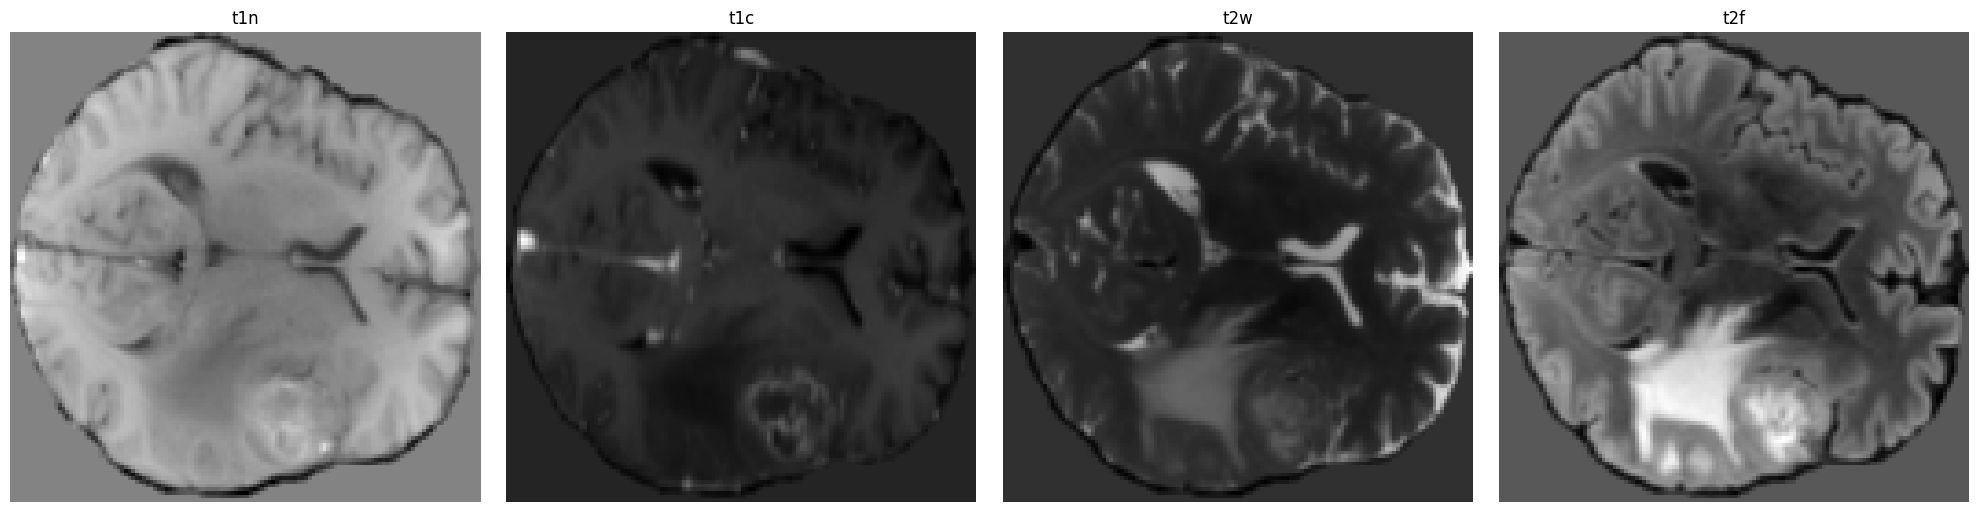

In [119]:
# Visualize a sample saved multimodal mri preprocessed data
saved_files = sorted(output_dir.glob("*.nii.gz"))
print(f"Files saved: {[f.name for f in saved_files]}")
print(f"Total saved: {len(saved_files)}")

# Only proceed if something was saved
if saved_files:
    sample_file = saved_files[0]
    img = nib.load(sample_file).get_fdata()
    img = np.transpose(img, (3, 0, 1, 2))  # (C, H, W, D)
    print(f"Loaded {sample_file.name}, new shape after transpose: {img.shape}")

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for i in range(4):
        axes[i].imshow(img[i, :, :, img.shape[3] // 2], cmap='gray')
        axes[i].set_title(modalities[i])
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No preprocessed images found.")